# Exercise

ให้ทดลองปรับพารามิเตอร์ต่อไปนี้ แล้วเขียนอธิบายว่าทำอะไรเพิ่มเติม และมีการเปลี่ยนแปลงอะไรเกิดขึ้นบ้าง
1. VGG16 Model Architecture (เช่น node, layer, etc.)
2. training parameters (เช่น learning rate, optimizer, batch_size, etc.)

เพื่อให้ได้ Loss ต่ำที่สุด และ สามารถทำ Data Augment เพิ่มเติมได้หากจำเป็น
กำหนดให้ใช้ Performance metrics เป็น F1-Score ของทั้ง 2 classifications


<font size="3" color="red"><b>ในการเขียนโค้ดให้เขียนภายใน</b></font> `### START CODE HERE ###` <font size="3" color="red"><b>และ</b></font> `### END CODE HERE ###` <font size="3" color="red"><b>เท่านั้น ถ้าเขียนนอกเหนือจากกรอบนี้ตัวตรวจโค้ดจะไม่ตรวจแล้วจะไม่ได้คะแนน</b></font>



***สิ่งที่ต้องส่ง***
1. ผลการทดสอบโมเดลกับ **Test dataset**\* ที่กำหนดเป็นไฟล์ `.csv` ประกอบไปด้วย 3 คอลัมน์ ([ตัวอย่างไฟล์ csv](https://github.com/NextGen-AI-Camp/curriculum/blob/main/Week%236/Transfer_Learning/sample_submission.csv))
    - คอลัมน์ที่่ 1 เป็นชื่อไฟล์รูปที่ใช้ predict ```[เช่น img1.jpg, img2.jpg ..., imgN.jpg]```
    - คอลัมน์ที่ 2 เป็นผลัพธ์การ predict จาก language classification 2 classes (0, 1) ```[โดย english คือ 0 และ thai คือ 1]```
    - คอลัมน์ที่ 3 เป็นผลัพธ์การ predict จาก number classification 10 classes (0, 1, 2, ..., 9)

2. ไฟล์ weight ของโมเดล (`.pth` หรือ `.pt`)
3. ไฟล์ source code (`.ipynb`)

***กรุณาส่งไฟล์ดังนี้:***
- ไฟล์ `.csv` แยกต่างหาก
- ไฟล์ `.zip` ที่ zip ไฟล์ weight ของโมเดล (`.pth` หรือ `.pt`) และไฟล์ source code (`.ipynb`)

In [1]:
from PIL import Image
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models
import torchvision.transforms as transforms

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import f1_score

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

`MultiLanguageHandwrittenDataset()` is a custom dataset that handles handwritten digit images from different languages. It stores image paths, digit labels, and language labels, and can apply transformations to images when loading them.

In [6]:
### START CODE HERE ###
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
### END CODE HERE ###

## **Preparing Dataset & DataLoader**

In [7]:
### START CODE HERE ###
!curl -L -o train_set.zip https://github.com/NextGen-AI-Camp/curriculum/releases/download/Transfer-Learning-Exercise-Dataset/data.zip
!unzip -o  train_set.zip
!curl -L -o test_set.zip https://github.com/NextGen-AI-Camp/curriculum/releases/download/Transfer-Learning-Exercise-Dataset/test.zip
!unzip -o  test_set.zip
### END CODE HERE ###

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 15.9M  100 15.9M    0     0  15.6M      0  0:00:01  0:00:01 --:--:-- 15.6M
Archive:  train_set.zip
  inflating: data/data/eng-handwritten-dataset/0/img_1.jpg  
  inflating: data/data/eng-handwritten-dataset/0/img_1029.jpg  
  inflating: data/data/eng-handwritten-dataset/0/img_1046.jpg  
  inflating: data/data/eng-handwritten-dataset/0/img_1047.jpg  
  inflating: data/data/eng-handwritten-dataset/0/img_1076.jpg  
  inflating: data/data/eng-handwritten-dataset/0/img_108.jpg  
  inflating: data/data/eng-handwritten-dataset/0/img_1091.jpg  
  inflating: data/data/eng-handwritten-dataset/0/img_1093.jpg  
  inflating: data/data/eng-handwritten-dataset/0/img_1096.jpg  
  inflating: data/data/eng-handwritten-dataset/0/img_110.jpg  
  inflating: data/data/en

In [8]:
### START CODE HERE ###
class MultiLanguageHandwrittenDataset(Dataset):

    def __init__(self, root_dirs, languages, transforms=None):
        self.root_dirs = root_dirs
        self.languages = languages
        self.transform = transforms
        self.samples = []

        for root_dir, language in zip(self.root_dirs, self.languages):
            for subdir in os.scandir(root_dir):
                if subdir.is_dir():
                    label = int(subdir.name)
                    for file in os.scandir(subdir.path):
                        if file.is_file():
                            self.samples.append((file.path, label, language))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path, label, language = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label, language
### END CODE HERE ###

In [9]:
### START CODE HERE ###
en_path = "/content/data/data/eng-handwritten-dataset"
th_path = "/content/data/data/thai-handwritten-dataset"
### END CODE HERE ###

## Data Preparation

Use your `MultiLanguageHandwrittenDataset()`  to load the dataset in the cell below.

In [11]:
### START CODE HERE ###
class ReverseIntensity:

    def __init__(self, threshold=150):
        self.threshold = threshold

    def __call__(self, image):

        if isinstance(image, Image.Image):
            image_np = np.array(image)
        elif isinstance(image, np.ndarray):
            image_np = image
        else:
            raise TypeError(
                "Unsupported type. Expected PIL Image or numpy array.")

        if np.mean(image_np) > self.threshold:
            reversed_image = 255 - image_np
            return Image.fromarray(reversed_image)
        else:
            return image
### END CODE HERE ###

In [12]:
### START CODE HERE ###
import torchvision.transforms as transforms
root_dirs = [en_path,th_path]
languages = [0,1]

transform = transforms.Compose([
                  transforms.Grayscale(),
                  ReverseIntensity(threshold=100),
                  transforms.RandomAffine(degrees=(-30,30),
                                          translate=(0.05, 0.05),
                                          scale=(0.4, 1.2),
                                          shear=10),
                  transforms.Pad(15, padding_mode='constant', fill=0),
                  transforms.RandomResizedCrop(size=224, scale=(0.746, 1.0)),
                  transforms.ToTensor(),
                  transforms.Lambda(lambda x: torch.cat([x, x, x], 0))
])
dataset = MultiLanguageHandwrittenDataset(root_dirs = root_dirs, languages = languages, transforms = transform)
### END CODE HERE ###

HINT: Explore the dataset before training.

In [13]:
### START CODE HERE ###
image, label, language = next(iter(dataset))

language_labels = ['English','Thai']
image.shape, label, language_labels[language]
### END CODE HERE ###

(torch.Size([3, 224, 224]), 3, 'English')

HINT: Explore the dataset before training.

Complete the `load_data()` function that loads the image using `ImageFolder()` with the specific `transforms.compose()` provided below.
<details>
<summary>
<font size="3" color="orange">
<b>specific requirements</b>
</font>
</summary>

- `load_data()` will return `DataLoader()` and print the information about the Dataset.
- This function must load only a pair of classes from the entire dataset.

Resource : [`transforms.Compose()`](https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html#compose), [`torchvision.transforms v1`](<https://pytorch.org/vision/stable/transforms.html#v1-api-reference:~:text=custom)%20tv_tensor%20type.-,V1%20API%20Reference,-Geometry>)

In [19]:
### START CODE HERE ###
def load_data(reverse=False, normalize=False, batch_size=32):
    root_dirs = [en_path,th_path]
    languages = [0, 1]

    transform = transforms.Compose([
        transforms.Grayscale(),
        ReverseIntensity(threshold=100),
        transforms.RandomAffine(degrees=(-30,30),
                                translate=(0.1, 0.1),
                                scale=(0.4, 1.2),
                                shear=10),
        transforms.Pad(15, padding_mode='constant', fill=0),
        transforms.RandomResizedCrop(size=224, scale=(0.746, 1.0)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: torch.cat([x, x, x], 0))
        ])

    dataset = MultiLanguageHandwrittenDataset(
        root_dirs=root_dirs,
        languages=languages,
        transforms=transform
    )

    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size

    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return train_loader, test_loader

### END CODE HERE ###

HINT: Explore the dataset before training.

In [20]:
### START CODE HERE ###
def get_dataset_stats(loader):
    label_count = {}
    total_samples = 0

    for images, lables , languages in loader:
      total_samples += lables.size(0)
      for lable in lables:
        if lable.item() in label_count:
          label_count[lable.item()] += 1
        else:
          label_count[lable.item()] = 1

    return label_count, total_samples
### END CODE HERE ###

In [21]:
### START CODE HERE ###

train_loader,test_loader = load_data()

### END CODE HERE ###

Use your `load_data()` function to load the dataset in the cell below. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

```
📃Train Dataset:
	Number of images in class 0: 307
	Number of images in class 1: 305
	Number of images in class 2: 305
	Number of images in class 3: 318
	Number of images in class 4: 316
	Number of images in class 5: 314
	Number of images in class 6: 307
	Number of images in class 7: 305
	Number of images in class 8: 312
	Number of images in class 9: 316
	Number of training samples: 3105

📃Test Dataset:
	Number of images in class 0: 81
	Number of images in class 1: 84
	Number of images in class 2: 84
	Number of images in class 3: 70
	Number of images in class 4: 72
	Number of images in class 5: 74
	Number of images in class 6: 81
	Number of images in class 7: 83
	Number of images in class 8: 76
	Number of images in class 9: 72
	Number of testing samples: 777
```

![image.png](attachment:image.png)

![image-1.png](data:image/png:base64, iVBORw0KGgoAAAANSUhEUgAABGoAAAPECAYAAAD2Bt0WAAAgAElEQVR4AeydCfxVU/f/n+fhZx4zpijz1CBDE4pESaNIiQxpkCnRoJCKUqIohaKINEhpJoVKJBmiFJUpYyKZeZ7f/r/e+/c/ud3nDvvc7x3OOffT6/Xt3OHcc/bZ67PXXnvttT7rH//4xz+M/tQHwoAwIAwIA8KAMCAMCAPCgDAgDAgDwoAwIAwEAgOBaIScRXKYCQPCgDAgDAgDwoAwIAwIA8KAMCAMCAPCgDAgb5kcVcKAMCAMCAPCgDAgDAgDwoAwIAwIA8KAMCAMBAYDgWmIvGbynAoDwoAwIAwIA8KAMCAMCAPCgDAgDAgDwkCxY0COGnkNhQFhQBgQBoQBYUAYEAaEAWFAGBAGhAFhQBgICAYkiIAIotg9hnp+ec2FAWFAGBAGhAFhQBgQBoQBYUAYEAaEATkp5KgSBoQBYUAYEAaEAWFAGBAGhAFhQBgQBoQBYSAwGAhMQ+Q1k+dUGBAGhAFhQBgQBoQBYUAYEAaEAWFAGBAGih0DctTIaygMCAPCgDAgDAgDwoAwIAwIA8KAMCAMCAPCQEAwIEEERBDF7jHU88trLgwIA8KAMCAMCAPCgDAgDAgDwoAwIAzISZGZo+qyyy4z/DvppJOyAiKuNWzYsKxcy5Mp1+zdu3dG1+R3qf5ddNFFGV3Xa5uOmeFO/aZ+KykGoq674vvnrLPO2qrK9tlnH+ktGX7CQIgxIP2lOTBex+u9MBEGDBSD7urXr5+ZMWOG2bBhg7W7xowZo/m25POtBngmAzzqA65MmTKmWrVq//W3YsUK88svv5g999xTg6/kg099qD7MOwairrti9fmuu+5q1q9fv9VokKNG830sPvQ6fHiQ/gqfzDTOJDNh4B+mGHTXzz//bJYsWWJGjBhhfv/9dyNHTVbGflYukvfFRqEHfTEMuPg+LleunPnPf/5jnnjiiaKTd3xf6L30RlgxUEy6iyjF5cuXm759+9rdHTlqNG7DOm7V7v/DrvSXxrDGgjAQRgwUg+765z//uXV9+NNPP8lRk53NaA34TAa8y4DbcccdzeDBg83bb79tNm/ebDZt2mQ9jY0bN94KZO/erCJYVLRv396sWbPGeiJXrlxpEqUYHXDAAeahhx4yn3/+ufnjjz/sjvHtt99utttuu22uyzUzTX3y2hV77NOnj13s1KpVa5v7xJ6j1xpPwkCwMVAsuuu0006z+rFKlSpWD6K85KgJNjalOySfdBiQ/hJG0mFE3wsjQcRAsegur+/lqMnaOMzahYpq8e4y4PbYYw/z2GOPmdatW5szzjjDnHPOOWbQoEHm3//+t7n00ku36S8WEZ9++ql5//33rXOmYcOGZvbs2dYx0rx5863n4qThvI8//ti0a9fO1KlTx/Tq1cv89ttv9l7eAOHIv3hHDb/jL/Y8l9d4Sbnvhx9+6Pu3LtfXORqHwkB+MFAMumunnXayDu+BAwdafeVxbslRkx+MaSyrn3OFAekvYStX2NJ1ha1cYqAYdFds/8lRk7XxlLULFdUC3mXAxQKW1//6179s1MuoUaNsOH7s9zhV4H7Zf//9t/Yj569atWob58jIkSPNli1bzMEHH7z1PK7TpUsX65g59thjt36eyFHz0UcfGf5i7+3yul69evb63bt39/1bl+vrHI1DYSA/GCgG3XXPPfeYtWvXGhw24EqOmvxgS2NY/ZxrDEh/CWO5xpiuL4zlAgPFoLti+02OmqyNo6xdqKgW8K4D7oILLjCLFy82ADb236+//rpNf/Hd9OnTt/kMwHsLDMh9eU+603PPPWcdPqQ6eX84aPjXsWPHrdfgfXxETewg8vN60qRJ5s8//zRE9Pj5nc7V+BIGgoWBqOuuU045xfz111+Gak8e9jw9qoiaYGHRk4+OkosrBqS/hBVXrOg8YSVIGIi67orvazlqsjb+snahrUZxvLCi+N5lwDVr1sw6TyZOnGiaNGliKyhRznv06NH289h+4YNHHnnkv/qwQ4cO9txKlSrZ73CWpPp36623br0G52XDUcPiBvbuqVOnbr12bNv1WmNIGAgPBqKuu9577z2DzqUynfc3YMAAqzYPPfRQs9tuu0mPZYfgTv2ofsw7BqS/pL9kb4TH3pCs/pZV1HVXvKzlqPlb9vF94/N91i6U9wnb54NmtX0uA27KlClm3bp1/3XfcePG2UVDbPv5wCWi5ssvvzRz5841OHwS/ZUuXXrr/bhmNhw1nTt3tu0977zztl47tu16rTEkDIQHA1HXXVZZpfgPcnfhNTx4lawkq1gMSH9Jf8XiQa+lH8KCgajrrng5yFGTtbGZtQsVlfHrMuCeeeYZ88EHH2zTL6QOwTHDv1hQ8z4ZR00spwxRNxs2bDB77bXXNr+PvZb3mmtmw1HDDjX3hDPHu7aOGjfCQDgxEHXdVbt2bRP/N2bMGNShoeIeDm5hN5zYldwkN+kv6S/pAemBMGIg6rorXiZy1GRtnGbtQkVl/HoDrmvXroaqTPF/O++8s7n88svt4uDBBx80Z555pmnTpo0l8qX8Nv9iQc37ZFWfWrRosfXcAw880FZtgmQYPhque+6555qrr77azJgxw3hcNlybf/GOGr9kwlWrVrXXufPOO7e2Ibbdeq3xIwyECwPForticYke5J84asKF1VgZ6rVkBwakv4QD6QJhIIwYKAbdVatWra3rYbhYFyxYsPX9vvvuq3VkZunSGvCZDHhvwFnrP8F/5cqVs4Ds1q2bWb9+vS2fvXLlStO2bVvrPOEnsffl/bBhw6zzBWfKH3/8YSs+tWrVapvz+A2LjaFDh9q0Ks777rvvzLJly0y/fv3MLrvssvV8rhnvqPFbnvvhhx82//nPfwzcDrHt1WuNG2EgnBgoFt0Vi085asKJ1VgZ6rVkCAakv4QD6QJhIIwYKAbd9dJLL7H0TPiPSOcwyi0AbdaAD4AQBN7MvIzqN/WbMCAMCAPCgDAgDAgDwoAwIAwIA8JA1DAgR40cNcKAMCAMCAPCgDAgDAgDwoAwIAwIA8KAMCAMBAQDEkRABBE1D6CeR15tYUAYEAaEAWFAGBAGhAFhQBgQBoQBYcA/BuSokaNGGBAGhAFhQBgQBoQBYUAYEAaEAWFAGBAGhIGAYECCCIgg5GX072VUn6nPhAFhQBgQBoQBYUAYEAaEAWFAGBAGooYBOWrkqBEGhAFhQBgQBoQBYUAYEAaEAWFAGBAGhAFhICAYkCACIoioeQD1PPJqCwPCgDAgDAgDwoAwIAwIA8KAMCAMCAP+MSBHjRw1woAwIAwIA8KAMCAMCAPCgDAgDAgDwoAwIAwEBAMSREAEIS+jfy+j+kx9JgyEHAOjR482v//+u/nPf/5j/vd//zfl33fffWeGDx9u6tevb7bbbjvJPuSy19wr+ytqGNhpp51M7dq1zcKFC81ff/2VUp+h79B7vXr1Mttvv730mfSZMCAMCAPCQDwGZChEzVDQ8wjTwoAwEBYM/POf/zTjxo0z//73v9MualjYLF++3Jx22mlmhx12iJ/M9F4GjjAgDBQcA5UqVTLz5893ctTgzPnss88MvwmLzlY7ZV8IA8KAMJA3DOTtRpqEZEAJA8KAMCAMbIMBHDU333yz+fzzz50cNR9++KG56aabzJFHHrnNdWQ0aC4XBoSBIGDgX//6l2nVqpVBV7lECi5btkyOGs2Lms+EAWFAGEiEAU3sQZjY1QbhUBgQBooVAzvvvLN59NFHnRY1RNXMmjVLjhoZNIkMGn0mXBQcA6QxHXbYYWbOnDlOUTXotI4dO5oyZcoUvO3FOgfpuWV/CQPCQEAxIMEEVDCasGVwCgPCQFFggIVNmzZtzMaNG52iaj744ANzySWXmF133bUo+kdzlOwUYSA8GCBKsFSpUmbixInmzz//dNJpQ4YMMdWrV5c+05wvDAgDwoAwEIuB8Ex+MlQkK2FAGBAGoomB8uXL21QBdpfT/f3666+mf//+Zu+9946dzPRaxo0wIAwUHAM4aogSnDRpkoEAPZ0+4/tvvvnGdOjQoeBt1/wazflVcpVchYHQYiC0DdeEJoNMGBAGhIGIYABHzTvvvGO++uqrtAsbeB8WLVpkq6uoWormcBmgwkDQMABPzZlnnmm+/PLLtPoMRw2V7+SoEY6DhmO1R5gUBgqOgYI3QAutiCy0NJg1loQBYSBTDFBu+9xzz7UVUFx2oJcsWWKqVatmWBBlek/9TngVBoSBXGEAnTZ58mSninY4n1955RVToUIF6TPZxMKAMCAMCAMeBjRJ52qS1nWFLWFAGBAG3DFA2e2VK1eaTZs2pd2Ffu6552y1qH322cebzHSUYSMMCAOBwsALL7zgRJKOo+bNN980o0aNClT7NX+5z1/qK/WVMCAM5AAD6tQcdKomWhmLwoAwIAz4xACcM3369DFbtmxJ66jhnN69e5s99thD/eyznzXnye4RBvKDAQiCV61alVafEUUI9xakwjvssIN0mnSaMCAMCAPCABjIz2Sl+6ifhQFhQBgQBlJhAKdLjx49zPfff592YfPzzz+bW265RY4azeEyZoWBwGKgUqVKpkuXLgZ95ZLSuW7dOnPhhRca0qZS6Up9p7lUGBAGhIGiwEBRPKQmPBlywoAwIAyEAAM1a9Y0b7zxhlO6wEsvvWQOP/xwyTUEcpVBKVurWDGAo+bbb791ctSsX7/etG3b1iilU+OlWMeLnjt82IcrkD/PwUzlu1133dXstNNO5qCDDtpqo/H9jjvuaPieP8naSdZOJ6kzZQgLA8KAMCAM5BQDTPQQBM+bN8/88ccfaRc2L7/8siXf1ISveVwGnzAQVAzgTF66dKn566+/0uq0f//732bx4sWmRo0aIkrXfJvT+Tao40XtCo8uP+yww6yeOuWUU8wJJ5xgGjdubBo2bGguvvhi06lTJ9OmTRvLu9WsWTNz2WWXmUsuucS0bt3anHjiiaZcuXJmr732kp5Lr+fCAwgNXslKGBAGhIHoYgBHDakC06ZNc3LUbNiwwZbo5nfCRXRxIdlKtmHGANxbjzzyiOWgcUl/+uqrr0y7du3EVZN+ASO9rz4SBvKMgf/5n/8xO++8s9l///3NwIEDzZ133mkr1r344ovmgw8+MB9++KGNIPziiy/Mxx9/bG25zz77zHz55ZcGm2316tVm5syZZty4caZOnTqmdOnSkmFqGcoACLMBoLYLv8KAMBAVDBAZQ+rTa6+9lnbnmQXPmjVrTPfu3cVTk3qSlxGk/hEGCoyBihUrmrlz5zrptV9++cUMHTrUHHDAAZJbgeUWlblVzyE7MRsY2GWXXUzlypXNvffea6hoh1P5t99+20avUcEukUP6999/tyntRBbymqhpKt3Nnz/fEJkTmyKVjbZG6BoCb4SEqUldk7owIAyEGgP77befefzxxxNO9PGTP5N9t27dDMaD9LjmcmFAGAgqBnC6zJkzx2zatCmtbmMhw+4zqQPSbcJ0UDGtdhUPNuGWIdr5gQcesByCGzduNKRpxttkmb4nygZuwkMPPdQceOCBsue2XccUD9CkVCRrYUAYEAaCjYFSpUqZMWPGOBkALGhatmxptt9+e03s207s6g/1hzAQIAygo5o2bWq++eYbJ90G+fBVV11ld5k9gk7NXcGeuyQfySdqGID4F76shQsX2rQm9Neff/7ppMP8Om2IxCHC5phjjrFpVVHryxI8jwZWCTpPhlCADCHJUWNZGIgGBurXr2+NApeJ/tlnnzVly5aVLpYuFgaEgcBiAF4HFjw9e/Z0XuRAqs4utsjSozGvyT6RHMOEgd133906TB566CFnneVis6U7B0fQ+PHjre7bc889pf/CBBq1VUpOGBAGhIHoY4BKAZDPpZvQ+X727Nm2coBwEX1cSMaScZgxAKnwoEGDLD+Di27jHKILiTIM83Or7Rq3wkB4MIBjeLfddjNNmjSxKZiuuioX5916660Gfi8ie4oYQ+EBTxELqZgBqmfXLqkwUEQYIMyfBc2ECROcytnC5XDkkUcKI0WEEdkCstvCigFIMydPnuyk21j4sLPMbxRVI8yHFfNqd3iwSzUnIpQHDBhgtmzZYn744QenDbNcOGm8a3bt2tU0b97c8nUVqcMmPADSYJeshAFhQBiINgZYkFStWtUSy3kTdbIjZHZE1Ki8Y7QxoTEv+UYFA+i3tm3bms2bNzstgL7//ntL4Ekp3Kj0gZ5D41kYCCYGTjnlFNO7d2+zePHinHHRJLPn0n3epUsX065dOxvts8MOOxSTPgwmWDSIJRdhQBgQBooPA//617/M6aefbpYvX552IQOZ8KxZs8xRRx1VTJO2nlXRQ8JASDGAo6ZevXpmxYoVtlRtusXJr7/+atavX29OO+00yTykMpcdU3x2TNhkjt11xBFHmLvuust88cUXaW2vdHorV9///PPP5qabbrLcObQ5bP2cYXs1gDLsuGIBiJ5TxoEwIAzkDQMsZNjVWbJkidNChmoEKueoeVzzuDAQFgwcf/zxZsSIEYYSty4LGqJvKIurUt3CeFgwrnaGB6tEp5Be2bp1a7Nq1SonnZRMb7F59scff2y13YgIxNkM5yAR0FR2SvZb18/XrVtnWrRoYSpUqJA3u7TAeA4PmArcUcUCCD2nFuXCgDBQUAyUL1/ePP7443aCTzd5r1271tStW7eg7dXcJDtCGBAGXDGwxx57mKuvvtqZMB0duHTpUtO3b19x1Whu1lwnDGQVA/vss4+57rrrzHvvvWd++ukn344Uz/ny22+/mU2bNpl33nnHvPrqq2b48OHm3XffNaNHjzbLli0zL730kvnll198kaknsv+4DxGJnTt3Nttvv31W+8JVh+f5PE2uee7wYgCVnlETiTAgDGSMgVq1apnXX3/d7sAkmqhjP1u0aFEx7axk3Kea52TrCAPBwcABBxxghgwZ4rwwYoEzZcoUjX/Nq8KAMJA1DBxzzDGGqGTX6L5Y28t7TTntBQsWWALiypUr2+IOVGqCO5BCDziCypUrZw4//HBz8cUXmz59+pgff/yxRBw4OJTmzJljqlevnrW+CPD8GJyJK8CdVAxA0DNK+QsDwkDBMUDe8e23327LQmIAeMZAsuOHH35oGjRoUPB2a/6SLSEMCAOuGKC6CpVV5s2bZ1MFkum32M/ZrW7VqpV0neZpYUAYKDEGSDPv1q2bjXKJ1TN+Xg8bNsw0a9bMECVYpkyZrW3i2ol0IREwVPUk/ZPqd6R1ehE5fu7Lb3D2dOzYsRiiajSxJgKTPhMuhAFhQBgoDAbat29vvvrqq7ROGib2hx9+WNwNMloTGoUav4UZv+p3t34/+OCDzZNPPumcCvDdd9+ZRo0amZNOOkl4l84TBoSBjDFAmevx48cbOGX8OEi8c6dOnWrTMU899VSTSclsHDvov+eff95uymXirKEtpL7fdttt1vkT4XnHbUKJcAdkDHT1ibAjDAgDwkB2MbDrrruae+65x5CH7BkFyY5E3Fx++eXmf/7nf6THZbQKA8JA6DBQqVIlmzbgumD64IMPzLHHHiuuGmE9dFiXrZRdW6kk/YmD2FXnxNpf/ObLL780PXv2NKRvJouccW0baVGkSL311ltm9erVNrrGj9MGgmK4ak488USz3XbbRXVMBAc4roLVeZKZMCAMCAPRxACT7RVXXGE2bNiQ1lHDhA5JXalSpaI6Qeu5tCATBiKMgeOOO840adLEfPvtt2n1HQsmKqiMHTvWHHroocJFhHEh+yaa9k0Q5IrugN8FJ0esEybda1KNli9fbtq2bWtI3czms+y3334GvhyqfW7ZssVX2+DveuWVV2yETkkdR9l8pixeS4Mhi52ZVeCqXcKmMCAMFBsG9t13X2sIfPTRR2mNCAjwSH3abbfdpHu1aBEGhIFQYuCEE06wlVLSLZT4nkjDuXPn2lK6EV2UhFKGxTZP63nDa5sOHTrUqaJmrD4ikubFF1+0ZMDwy+RC/my44bh+6qmn7Aacn8ga2nrllVdG1RYML9hyARRdU3gQBoQBYaBwGCBv+cYbbzTr1q1L66j55JNPzJgxYyyRnWRWOJmp79X3wkDmGCB1c9SoUcbFOc2ChOib7t27mz333DMnCybJMnNZqu/Ud0HGAJwylMl2KdTgOWo4d/78+aZly5aG1PRcPh/FJPbaay/rEKK0NxGEXjvSHYkSOvDAA3Pavlw+e4pra1Cl6JwoClzPpF1HYUAYCCwGIMp84YUXnCqhLF261NSrVy/KucmBlZPmTdlOwkB2MEC6Z9OmTc3rr7/utCghNYDS3ixKWNhIDtmRg/pR/RhlDJx22mmWD+uPP/5w0jM4Rn7//XczaNAg07t377xWVzrooINstLQfRw3Pdd5550Vx404DM8oDU88mfAsDwkCYMFC1alWbb+xCdEe+dM2aNbVYkeNRi1VhINQY2GmnnUyHDh2cSuWyw82ueI0aNUL9zGGal9RW2VFhx0CbNm0sEXC6yJTY77GxjjrqKFOuXLm86hoc0Oeff7559tlnbRnu2Dalek0Uzt133x21zTsNvrAPPrVfGBYGhIEoYICdZYwJytCmmoy976gOBQldFJ5dz6AxLAwULwbQfVdffbWteuLpt1RHCDQHDhxo0wSEm+LFjWQv2btggGganC4uG2Ce3iGS5rDDDiuY02Pvvfc2derUsXw1rsTHRAB16dLF1K9fP0p2oUDuAnKdI5wIA8KAMJBbDBDKP3jwYPPTTz+lddRs3rzZfPzxx6ZixYpRmpD1LIoMEQaKFAP777+/mTp1alrdx0Lq+++/N/369TOUt9W8lNt5Sf2r/g07Bs455xwn3j/PSQORb48ePQrmpPH6u3Llyua+++5zijT02o4Te9asWWaXXXaJim7UAPQAoaOwIAwIA8JA4TBAxSdyob/55pu0ixWcOSNHjjT8RjIrnMzU9+p7YSA7GNhhhx1MrVq1zOeff55W/7GQevXVV83JJ58s/Vekjj2Nu+yMuyj3I5XhSCd///330+oUz9FBVEqfPn2yXoI7k37G2QJp+ocffuirZPfXX39tunXrZsqWLRsF/SigZwIe/Ua4EQaEAWEguxiAc+HTTz91MiiWLVtmzj77bEPFFMkhu3JQf6o/hYH8YwCeGtKfqOrkLZqSHXHUTJo0yVDaWzow/7LS+FCfhwEDRClTsQlHRzJdEv/5I488EriUcnhn1q5d6/wMv/32mxkxYoStUoWzKgyyStFGDbYUnRN24ar92mkRBoSBUGBg++23N40aNbIh/fGGQ6L3b7zxhjnrrLPyWolAc4XsBWFAGMglBuCEmDt3rlOo/8aNG831119vdtttt1Do+Fz2m66tcSkMbIsBCHlJeVqzZo2zg4No5p49e9ooliD1J07su+66y5nDC5uRKKJWrVpFgcdrW8EGSTBqi2QjDAgDwkD0McCOxzHHHGPGjRvnZFAQmkt5WjgdhI/o40MyloyLBQOHHHKI1YMu6U8sRh5//HFTunRp6UFtyAgDwsA2GNh5553N4sWLnWwqbzOMKks4i4Omb3E6EVWzcOFC5+fZsmWLdXqTTsrvg/ZMPtojA8BHZ4VZ0Gq7lLgwIAwEEgNMorD7r1y50mkSpirUgAEDzAEHHBDI59GcIrtCGBAGMsHAjjvuaJo1a+bMKTFt2jRz/PHHmwiE90uXyz4RBrKIgY4dOzrxXXlOGoozXHPNNYGNQGFjjnT31atXO/PV8Ey33XZb4FK5fM4Nmkx9dpgUSRYVifpe408YEAZYnNx5550GAjjPaEh2JJpmzpw51rHD74Qf4UcYEAaiggEcLpTSffHFF82mTZvS6kOqRLVu3ToQxJ9RkYGeQ/ok7Bjo2rWrWbBgQVr94dlZRPAF2UnjyYPoQQpOwNHltT3VkfTQ2bNn24ht7xohPGpAJhOadiiEjWTY0OfChjCQHQygZ48++mjrfPnzzz/TTr7//ve/zYwZM+xvJIPsyED9qH4UBoKDgfLly5vRo0ebn3/+Oa0+hHz9wgsvFKGwNhC1aSEMbMUAkXY//vhjWv3hOTlWrVplateuvfX3QZ0P4DKsWLGiWbJkiZN+xF4kqqZJkyYGnpugPleadgVnckrT0Jx3MMz5lAJr27atqVevnhk4cKDZfffdzT777LPNvbfbbrtt3he63bq/MCwMCANhxsBJJ51k5s2b52RU4MyBnybEk67mDxnUwoAwkBQDVapUMSNHjnSq1MJCZPDgwYFNVwjzvKS2y64KIwbuu+8+89NPPznZUzhqqDJHVN4OO+yQVCcFqR8o133TTTc5V4H66quvbKo8vwvSc/hoS/EORHZy4Tho3Lix6dChg2XHBqzUj//ss88MC4KPPvrI4GmcMGGCZcK+4IILDGRv++67r/KCZWiFddCr3cJuYDBANM306dPNX3/9ldaw4JylS5eaBg0ahMao8DEZB0YmanPx2kWSfeFlz64x1Zw2b96cVidShrZFixaKqNGcrvlDGLCkuWPHjnWyp7xomi+++MI0bNgwVPg5/fTT7docR7X3HMmOpEmxnidiKKSZMoWflAphGBA9AwEbeXzr1683kFMy4SVaLCBkwPDHH39YYZP39+abb5q6detaJw9eSCbWQjyH7lmc+JXcJfeoYAD9CR+DS9oT58D6f8YZZ0jfyigVBoSByGIA+3L58uVOpJlwdpUtWzayfRGVuU7PIbstlxigyhPRNC4pk55Tg3LcF198ceh0x7HHHmuoUOUaOcQ6/qqrrgrrBl9xDRzIJ/fee28bPfPSSy+l9cR5YE50BCAMiGuvvdY0b97cpkmFJXQsl8pC1y6uMSV5S96ZYoBQVCIaEznIE+ncL7/80lx++eU2RTXTe+p3wqswIAwEGQNUwbv00kvNihUrzK+//prWTsV53ahRI6O0fOE6yLhW23KLz86dO5tFixY56QzsK5wXnTp1shHKYZMNuq5ChQpm5syZTs5snhc+r1KlSoXOKb1/90AAACAASURBVPWPsAmnJO1FsHDP9OvXzzz44IPOYE60YIj/bO3atTZliutTQkwRNrlVSCXBgX4r2QgDwcDAJZdcYhcj8fo00XuMivfff9+Gr6raUzDkp3EkOQgD2ccA4flEfM+aNcvJiU20NxE4OHgkj+zLQ32qPg06Bvbbbz/Tv39/8/3336d17Hr21XvvvWeDFoL+bMnaxzMPGDDAZsR4z5TqiJ5s2rSpDapIds2Afl4cAxBCYPhlSFsiHy+VMEvyHUzUw4cPN5DBieyyOLAV0IEtg01pAYHGAETtkydPdg7ThRAO0kxFLUqvSucKA1HGAA6XqlWrmueff94pJZQFSJcuXQwLlyj3i55N414YSIyBOnXqmLfeesu5bDXrXCJwwtyfe+yxhyVBXrlypfNzv/766wZ+m5A5tRMLPczCS9T2U0891SAgQuzZmS2JMybVb7m2x8IfYuKiUA/eRPLXZ8UxziXncMiZqENCbuEGS6VPY7+DrwESYfjFJOdwyFlykpyEgcwwgCP75ptvNnBIxOrBRK9x1IwbN84cdNBB0o3aoBEGigwDu+66qyUf37BhQ1pd4ekPovWothlm/UyWTJkyZcykSZMsh6z3bKmOmzZtslQlIdvwy2wSCYtwEWS1atXszu2WLVucQZxK0C7fEbXzyiuv/Fdp77D0m9oZ7XEh+Uq+hcQAjvO5c+ea33//3VknU+2pdOnSYWXtD7VBVEis6N7SVcWIARzS7dq1syW6XSqbPPbYY+aII46QnimyRXoxjg09899zAnriyCOPNPfff7+zPTV16lQbTRMFig42/c4//3znTBmCKdjwg98mRDj6W+AharRzBxMa1aNHD187ty6OGJdzqFDCRHvhhRc6tzeKMtAzRXuMSb6SrysGCDclDXXUqFHObP3o0Xfffde0atUqbOGq0vtaNAkDwkBGGICnpnr16s7pDK+99ppNuXfVxTpP87YwEH4M4KiB1uOzzz5zzhaBnqNcuXIZ6aWgYYbIGIpSLFu2zPn5Z8yYYU4++eQwPX/4gZoMOLvttpvp1q2bXRDkMt0pmdOGe3777bcG3hrKpoW0fnuYwKy2yigWBgKMAXYxcJwTdvvLL784R9M8+eST5rjjjpNsAyzbZPOwPo+ujSXZ5la2rVu3NmPGjDEu0eBUIO3YsaN0pHSkMFAkGGBNeeKJJ1onRbJ1aPznL774oo0midp6lI28Dz/80MmmfPnll22/hWj+yu1EU8iO2Guvvcxdd93lJLh4MGfz/UcffWSZqStWrCgFWiQKtJC4172jq9PCLFvCbAlRpUSiSyi/p4Nx6JQvX166U7pTGBAGigoDxxxzjJk+fboT/8K8efPM4Ycfrg1BjZGiGiNhtolK2nbPUbNq1SqndS7BA+gJKspFzVHTsmVL5yhtKmNVqlQpTBHa0VzUEA7WoUMH51Aob1HAAoJQeyJh4E8gnOy3336zOxq//vqrU6lE71rekWtCZEweIWH/JR2c+n00MSu5Sq5RxQDRjZdffrmZMGGCoXqTpxvTHX/88UcDQR5O96j2jZ5L414YEAYSYQC9R/lZl4ga7Fa4F0JWzUR6XY4lYSBDDEA43qdPH2d7iqCB5s2bR7JyJoTKX3/9tVNfQL4+ceLEMG0ARnOCpExh3759nXYiYhcL69atM+SvwYY9duxYc9FFF1mSJjgVcLa8+eab5ocffjA4bWJ/l+41Ey2laBs3bmwgOE40KeuzaGJRcpVcixkDsPI3bNjQrF+/3mzevNnZ2c3uDylSROFEbfenmPGgZ5c+FAbcMMBCbM6cOU5pojjAqfrEgkX969a/6if1U5gxcOCBB5pBgwY5rUWxp1jfXnzxxWbHHXeMnI6AXgSaERzW6dbjVH+ePXu2LU4REvlHb6Bi1Ldo0cI5DAqhkt+LE6Z79+6mcuXK1pni7UxwpNpIlSpVLDnwkCFDDKVi2e31U7WEyJrx48dbZv4osG2HBOCRU0jq9+jprCjKFB0Hmfszzzxjc4f9lOJmxwP9WqdOHSNdKbxHcXzomYTrdBggEpEKLS6LD8p4swhLd019L9wJA+HHANWOWOemc0p43+PIveGGGyLryGXd37lzZ2s3es+c7IijhnQxAjpCMhbCD9j4jqZEIQ4Rl8kNLyNOmrfffts0a9bMGcSdOnUyDz/8sFNIaixY2FUeMWKEOfbYY7VLnGG4X7y89T56Y1gyDb9McbLcfvvtvnUk+nLt2rU2Teroo4+WnpSeDIsxpXYKq1nFQKlSpWxktwvx+urVq83gwYOzen/Nw+GfhyXDaMrw1FNPtWvJ2PVlqtcLFy40UeZJJaCCjBWcMKn6ge8ImliwYIE56qijwqIvowfiRo0apRWUJ0h2bhEYnkk/3jU4cCC4hD3aNS+Oe+IYIm3q3nvvNTVr1lQalAy7sCgKtVNYdcIAiwsqNEFaR8qnyyLD08cciVJ84IEHLOEd4awyNKM3R0umkqkwkB4DkH526dLFbNq0Ka1Ni115zTXXSF9qnhYGIo4BnBI9e/Z0zhr56aefzIMPPmhIlYqy3qXktoujhnOmTJliCYVD0h/pJ4uQPIgFIGlL5KnFGv7JXuNV+/zzz235QxYXmTwn9et79erlq4oJ7SFMFTZ/kQtHC3+ZYEi/EQaigAFCT+FUuPbaay2vAsZBMt2b7HOcNG+99Za5+uqrRSAccWMzCpjXM0h35xIDhx56qI0sdEmxx1Fz+umnZ2TH5vIZdG2NEWEguxjA1rrvvvuc7SvSznH4enQeUZUHHF0uxSrQpwRLNGnSJCz6MrsAKjQATjvtNFuxKdlCIPZzvGovvPCCIbw+UwCz40uZL0L1cfzEXj/d63fffdd069ZNof1akIRFWaidwmpSDFSoUMEMHTrUvP/++05pp/H6kWhDCNtr1Khh9t13X0UbCmtJsVZoO0P3j5bdGER5Ek3Tpk0bq0/jdWWi90QuUlmURVwQn0dt0pgRBrKDASpoUpk4kR6I/4x17nPPPecrYySscrrxxhstlUl8H8S/Z62+ePFiU7Vq1bDoyuwAJwiCJZqG3VgXhwmLApwrRLWUtPQrDNrsZFDuKx4Qqd7j1fvggw/MGWecYfbcc8+wAEbt1AJKGBAGtmIA3UXlAUgvSSVFt6bSe4m+Q2fjpLnppptM2bJlt147CPOK2hAdG0GylCzDgAEI1Nu3b28op4tOTaQz4z97+umnDRE4YXg+tVHjUBjIHAPXX3+902YYttiyZctsAZsddtgh8roBHwAkwfG6Mf49/LU4r2677baw9EnmYAnSQCOqpX79+nZiixdKovcsDF599VVblSQbz0FkzRVXXGHLn7lOrF67Zs6cafAEaickGljMBp50DWEhqBgg+nC77bazf127djWjR4/OyDnj6T8mze+//95WLGGhkSy6Ef2IniW9Cj4xFjOezkz2m6D2odql8S0MRB8DsXoJXeW954gOheuQI5t9p5xyii2vTTj+pZdeand8/fAfwut1wAEHhGXhoXZqs0cYyAADxxxzjPn000/TOiOwrzxHTbHohbp16zpzxpLRQuR2SObh8E+WTHZMcnS8624uDPmTJ0+2E2U2BIW38oQTTjB9+/Y1VHZybYe3WPnkk08MA5ByjNloj64RflxLhpJhkDCAYwRHCeGilIG98sorLVmwX13n6TzPkCD9lJ2NevXqJdR9LHBw4EBQPHz4cNOyZUv7Bz/YmWeeab/DUa8y3hovQRovakvx4RGny0477WQ3ANFZRFofcsghttoKlT7PPvtsW2mEFH2qjPbv399ccskl5pFHHjHoM6Ji4JrZvHmz00LM06U4uqtXry7OwwwWvhqnxTdOwyzz7t27mzfffNNJP6AX4PsL8/P6aTvrZxfnNjbrypUrTatWrUxIIo3CP0iZAAEjzg5v4kp1/O2336yQdt1116wDuGHDhpZN+scff3Rqi9dOSoSPGjXKLn78AFPnhh+/kqFkGFQM4PxgIitXrpw566yzLCEdYbeEl7pUIvH0W6IjpG8ffvihrX7H4ia+D3DQUE4Szhqc32vWrLE6lWhIJlpSR4nGWbdunWndurU58cQT7Y40zqT4a+m9xpgwIAzkCgPoqv333986kzt16mTuv/9+u5h65ZVXbDo+upIIbhYRGzdutLwzpOlTNZTd8Vhnt0vqfrw+nTt3rrnssstsdE6unlHX1fgRBgqLARzBpJn/8MMPTuvLjz/+2PJcFYvciBz67LPPnPvm/PPP3xrlGPA+KizwSto5u+yyi42mWbRokZNwmOAA77Bhw0wuHDWEUtWuXdtWnnJh6o+dcHHWjBw50nI0aHc43LgsKa71e8k/XxhgkcG9iEzEKcNOcJkyZSx3FxNZixYtzLRp08xrr71mI2gwEjJZTHi6jkUJBHe9e/c2F154oSGvOP5Z4b3BSbNw4UKnHRIiJCdMmGAGDx5scNx7KQbx19V7jSthQBjIJgaqVKlincl33323GTJkyDYlc9F1sU6YWB2Y6HPvez9Hom/atm1rSpcu/V96NJvPqWtp3AgDhcUAESM4f10DAYjQ8+w7v7LDKUSkMpketWrVCoVu4VlxfqfTn+heNv7Q15n2j9/+LOH5hQVeCRtvnRrwJLDjmk44fM+kxg7swQcfnDPgIXgWIA899JCvBQ2OHXZd+C05yyXtG/0+3NiW/CS/XGCAyR5HcLVq1axxj4FPKD5RKejSXr16mUcffdSw8MCpDek6uhPnSkkcNJ5+xqny5JNP2sVNIj1HdA0cDewS+y3xDTk7aVmkUeF4ykX/6Zoal8KAMAAG4EQgegYnNhttRGt7ei4fR+6HnVmnTp2whPBLJys9SxjIAAOsK0n1pqqmi5OXKnDYcH7nKkpcU1WqadOm5vnnnzczZsww7733XmhKWU+aNMlJB3/++ef2OXFI+e2jApwf3gmXaBrC3VlUuBL4EhbVsWPHnETTxAqP8HucQSx0XCdvBt+WLVvsxE8IV0g8fWEAudqYwcQQi2e9Dq+e9GRH+hLlW6mshA5cunSpeeaZZywvAmH46Cp2anDMoE9ZeGRzsYHhsHz5cnt/2gIpcLyOI32gXbt2NiIxk3vTbrjKIDhWJb3wY9bDro6SZdAwQJo7XBGkb2K74cjORGeV5Dc4vXHSxOvRoPWV2qPxKwyUDAOMcTahXDhY0CmzZs0y3bp18732oSgPeo1NL1LL2ZzjDwfRrbfeanm2gipLbMqxY8c66WH6kTT+kERflww8hRTY3nvvbY1+uGlcPIzffPONrQpFaH8+2s3AOvfcc22alZ/JmHJqAwYMUKlFORfygtN8jAXdozB6dp999rGklVQSefzxx21YKNwwTFLe4oLJ2I9+yuRcHNCE7BK5k4pp/6STTrJGAoSamdyH32BUYKRwL6pDCXuFwZ76Xf0eRQygVyD0xLmdjQjDTPQcm384iCBhxw6OYj/rmaQ/hIG/MUDk8/jx4y03n4vOQD9RgMFPH1IQhyrEiTbp0HVs5C1ZssRu9AXRtiJ1nyIXLv3DxmTNmjVtir+fPirQuX8DoUAN8AUkr41ErBAGhkPDNWKFUCd2H/LJ/0L4PaW32b12zStkVxjyOSoEaKcknPj0cKqj5FcIDKDj2H0hhJWKIt99953Vk4VYWBBJc/PNN9s0gVRhpnvssYfp06eP3cVxmWhTnYOh8dxzzyXkvymEPHRP6QFhIPwYIIJ7wYIFNvK5ELoUnYeD/Y033rAOePgjhKvw40oylAxTYYANN7j8XPhX0BFE92H/HXXUUc76gWjroUOHmhUrVqR0dLDenjJlijniiCOcr53q2bL5Han0r7/+esr2e3bjt99+a/soUfp9NtuUpWuFc4DAs9CjRw9bytDr+FRHhNK4cWNDulSWOs75OoT533LLLb53X/CewiMRktAs5/7Id//rfuEc45JbZnJjQqfUKw4SrzJSKt2Yq+9YUDz44IPmjjvusM7xVHqMyfLOO++0DqVstYe0AJzdwlFmOFK/qd+Egf/DAFGA6LJ58+b5tuOypc+4Ds4hIsM7dOhgy3FrI09jVGM0+hhg3UqhBNdIY2yvNm3a+Fo74vRFv/HbVDoLJxC8NaxN8xn04IpzNvuwfVM9A99t2LDBVjL148xybUMOzgsfyAEHThcM+3TC8L6Hm6ZBgwYFK19YtmxZWzkFMmOvTamODIa3337b8jWExOOnBZFStYSBAmIAEt5DDjnEUAGP9KZ8cyYwwXNPUqnGjRtn9XOistuJJjHOu+eee5zDelPpztjvSA9gFzzRPfVZ+OZ+yUwyyycGCKXfa6+9zBNPPGGJNWN1S75e45xBtxJlTWlvqvDlsw90L405YaCwGKCSJfbRl19+6bR+JM0djr5Um2OxMvVShrDd0jlq0HtU46xevXrB1tOxbY9/TcSji24mHf/2228Piy4tLADjO9nlPWW1r7jiCidhIDCcI5AGkVOXKvTe5d6ZnkObL7roIvPSSy85DQTazYDp27dvIEPMMu0H/S58400yC77M0GvwJrCgcCVWd5nMXM9hp+eLL76wlZowEihZ62okgC+iDiGrc72f63nwl0H6GcSdH42r4I8ryah4ZYROveqqq8xTTz2Vdb2USn/h7Mb2w0HDYuKdd96xJOytWrUyjRo1CsvCQu0s4KaN9Fa09BbFZUaNGuVE84GzBZ4Zv8UUTj/9dMtd6JLSSWp5//79fd8j17jE5uzcubOTvoYK5bLLLiuYT8BnX4QP0BUqVDCdOnVy2jEGdJQWw0lS6MgUFguUnWXx4LrbjZOJFCiFuIYPpz4HogwbGTYZYYBJ/JxzzrG5ua56JdVCwc93P/zwg93lwYjgD04cSO/8lMZGLxKmS5lbP/d2PRf9T0SjxqN0qDAgDLhioGLFinajzGXhkk4XedeA3wEnjPdHiP5PP/1kWDTwmshvSC7nz59vF1twMFK5hahAP45v12fUeRoPwkDwMUAGCcUYXDIyiKauXbu2b32BjoH7KhGRcLx+w+6jQEWhAh+SYRaeQ6pAx7c30Xs4Y++66y7jGvWd7J55+jz4II3vCFj3XYUB6BBGqVKlArGrevjhh9tcQzhzEoEn/jMmeML3S8KwLSdP+DAej3m9lwzjMcC4Jiwfot5PP/00r5E0RM/wd/fdd9vKI0cffbQ56KCDbMnt+Hame0+0IalS33//fVqdiD5klxljhFSAeH2Z6D25yDiCFFWjMZQOi/peGAED7EZDwo5eTaRTXD7D6QKfDKTmlLuF5HLy5Mm2sMQzzzxjJk2aZCZMmGBGjhxp2rZtawYOHGgjxYmMxPkOgSgLD9ISZMMJl9JNxYsBHDVEHKer0IkDeO3atbbasF/HbpkyZcxjjz3mpO9oB9GGhQ5+iB8T2JLwwbroZ+zXli1bhqVqXrjAz4SF0Y13MZ0w2F2mlFi9evUC4zUDSOw6r1q1ypmUjueoVKlSyrK2sYBlgLIowVMIURKT/mGHHWbvCwlzENm6Y9uv1+Eak5JXYeTFJHnWWWdZArh0ujDT75n40T84RUhvWrlypU3fJKIRQktINvnzG2Ybixl0omtFPBzvlN6Gn4xKei7PhXOHRVFIdk4U+aPIOmGgQBjAdkIfXX311ZYPxkW/JDqHzbVrr73WloolrZP0yxo1apjjjz/esNF48MEH28hDCDxZIKGb0OfYt36iEWP1qF4XZh5Wv6vfc42B5s2bmzVr1qR11BCdB7dpJgS5rBMfeOABG+2XSKfFfkZ6PTZg0Gyq3Xff3TrGY9ua7DVRjEQRhcQJHq5BxqIAtml2KpIJwPscMGGgs9Pr17uYy4EHCRO74F9//XXaZ+BZWCjhJTzwwAOTGnAAlJ2Xpk2bmmHDhtmonX79+hn4Ihh8c+fOtWR47ODA2H3TTTeZ8847z/ZNISph5bJ/de1wjWnJKzN5lS9f3kydOtUpEsXTiS5HdCsOEcL0iVxkF5hSj7feequtJkXqKYuZbE3S9evXd44GYgFUp04dS2TnShrH7g8lJ0llENYyw5r6Tf1WDBjAaK9Zs6Z1AmN3uejL2HOI9ENftmvXzkYXeqkB2Gb0X0gWBdKTBXIUFsMY0zP6m0tY2xFl5xJxzGba9OnT7brObz9j00Guy+ZcrE5L9BobER238847B0pXENDgGgVJpHXVqlUD1f4UMvMHmhQXyssD41QYMWKEk2EPQ3bXrl3NySefnJe2ufYN4GZHBe6ERIMg/jNyl/GmEgrLPZjs8X6yO3PvvfdabggijIjUWb58uSGtioUWu9Qc8bKyq8x7jA8G80cffWQ9j5Rjo8w5CzHPmHB9Dp0XrrEjeUVHXqRCsmPrmv4Tr1N4j05hYUEIKLswTz75pNUFY8eONc2aNbNh+Pvvv7/VVYTgYzBkyznjYZEd5RdeeMGJswuHy7vvvrvVuYyz2TWFlNxr0k69++oYnbEgWUqW2cAAThWiW+Dawm5KpDNTfQZvAyW8If0lcjkbbdI1hG1hoLgxQKQd6zPWbKn0D9/hzMFGOvTQQ33rH+w7AgJILU93Hzbxpk2bZqMCg4JPdO7DDz9s7dl07ccZhU249957++6nAj1vuAYBTgp4EVy8fpQyDGJ4FoLmOXr37u1EDsWzvvbaawYnVeXKlU379u1t+gELHDybHkEdRFM4ZFz6hvN+//1368RhsYeRceONN9pc6QIBMSwDRu3UblNBMYDuIBpu9uzZTpNq/KRFyhApoYsXL7Zh+KRP4TgmYo9dFY8MONZxyz1zoRfgDoMLIr6Nid6jr3AmER2J8XLfffc5Oey51nXXXZd1J1Mu+kPXDJc9InlFR17owC5dujhvoHk6Cntr6NChplevXtaZjW4SLqKDC8lSsiwkBsgIITiBDXZP5yQ7sq7z9JDfNqP/2KRjPZns+t7nbPgTzZ0qy8Pv/Ut6PnZhnz590qaH8QzobDjDiEov6X3z9PtwDUJyfYkQ8QCT7AiQKGsYxBJinmDxSLqE1zJAv/vuO5s3jcOG8H8GJH/Jnj+Tz71oG4wVPLgAP1cLNK8PdAzX+JO8CisvxiMEwuzauuiOWD1ANZGFCxfaCkjwILCDwvUKOcbPPfdcW+Uktp3JXhP1g6Paw2Dr1q1tlZRk58d+DkmeF5Ho/V7HwmJZ/a/+DwoG4PQjbH7ixIm+9CoG/6BBg2wkopfmFJRnUjs0voSB8GMA/j/WsemIhLF32KyH7iMTBwQ2IWno2FmxtlOi16xJ0ZVEKRfSfozFN2lMZNG4OJo4p2fPnoFpe+xzJHkdHiADiFNOOcWJeJJFDCUOmXyTPHhBPydMy9VR4w0Ul0gZ79ySHiFaIuKHsr+kagWJ4yeI8lSbwqNHwiwryM+IpqFKkusYZ4InvYmcYib9oEysyIFUg1dffdXpWYiQbNGihSVKZ1GEfnJx2uPQhhMsNkIozBhQ26VrhIHsYgC92LlzZ7N+/XonXYTupaoTHIDZiqAhrZQ/wvE9XkVtlmVXzho36s+wYQCny1NPPeWsl+644w5DSjk2kh9bD93TrVs3G7mTLgiAtSgFHUpSRCLbcoC0nc1IF7uYaBpoQ7Klu7P9LAmuF56BywRGmUMXQeCoIbQf4t4ED13wzwjbh3vG5VkKeQ6AHjx4sGXHhqciiH2pNoVnDEtWmcsKo/2QQw4x69atc46mY0KFt4ryr0EKU/VwgEEBT46LjoN8/YQTTrA6iGc5++yzbZ6xy28/+eQTA6+Pd18dM8eh+k59FyUMsJhBn5BS76JLOIcdWZzfZ555pq/FUKJ+Qy9xfxzPOKKffvpp89BDD9lqpfArwhOWbW6wRO3QZxrXwkDwMIB+uuaaayxVhYt+gsoCJ3Lt2rWtI8V1k50N+euvv96JtBgOr5deeskcffTRgbCp2ITD8UJ6vEsfkbYV1CCOJGMweMBM0lAbzvXiiy86CYLQLHL1gsZKzbPByzB69GinnEMX0OXjHIBNf4ok77/HC57r2JSMZPjV5//dd+oT9z7BUc0uRrrdjlh9wKTNBMZCIIih+aSyLlu2zEmnk/5Zr149G91HmC7k6UT+xT5votcsqkh9gn9HeHPHm/pKfVUMGMDIb9CggZk5c2ZaXYJ+YRPQK79dUvsSxzt2FdU4iQ4kdJ9qpdwDPc9mI9yBtI+Kp8jDdeFVDLLTM0pHRR0DRH3ccMMNvvgIsfvgL23SpInd0CK1M53eIHVo7dq1TjqQIg4DBgwIDBkvfUR0o0t6GDocx9epp54aJnswHAMdr2KtWrWcQt0RBOS4EAkHsfT0aaed5pQHmGjRUajPMByoUoXBEHXF6Pf5cLxBwuX3dzo/HLonCHJC/1100UVm0aJFTmTh6AkM/5EjR9pys0F4hkRtIMeZxYmLXiN32tPnOIzZ/XH5Lbs/7FbDyZOoDfpM41AYKF4MoBcGDhzoXOmJ9Kjx48fbqpvo5Uyxg+6jSsmCBQvsAiNZaju2LHofHVajRg0bYZPpPfW74sW5ZB9O2eOEoArn+++/72QnxdpSVIEiAhvHBGs3ImASRRaziQU3qWsVTYpR4DwKSuoTOpwgDpdNTPTslVdeGTY9Gg7wIgiA4UIUBFDxJsLnEDTldNJJJ5kxY8Y4D4jYQVfo1+xeYzAw0EtioARNJiVpD31BmWBKHZfkOvptOPRQIeTEWIPLBSJgHKYueoC0Sso5HnnkkZbTpRDtdrkn+dcYEi7PxHnNmze344wKBcOGDXOqmoex0r179zDlI0uXqLKcMJAHDLDLfP7555vJkyc7OcCJ1MZ+q1ChQsZ6lehGdrpJb4L8M53u8xYfLKJIRb/ttttsCqyLftU5siuEgXBjgEjoww47zJL3erognc6I/R7HBM5eIpcfeOABy8V1wAEH2MwOsMH1cQCPGjUqrS7iulxvypQpNrq5pBGF2cIm0eZz5sxxctRgQ9etW9cW5cjW/fNwnXCAGEfNPffc4xTaBJAIdfdCRfPQic5GFdVacCLFDqQw7IPjzAAAIABJREFUvUZRkLZF/mOQ+rUQbWEBXaVKFasAwVwh2qB7hkN/lVROxx57rA23d9UVH3zwgenbt29gQlOTPT8cNS5VBnhujA2c9VyrbNmyzumjLIZuvfVWRdTkYeGbTM76vDj0VNjkjKMGrisXhwk6iM2qrl27ZlxBjgVFv379bIqB6z09nY+Nwd+GDRtsRM9xxx0XyHTWsGFA7ZVuCjoGjjjiCJvaQ3Swpw/8HNEbpFRSkAH+mieeeMIWs2nUqJG58MILbZVfMiZcromj45FHHrHROUFIp6cNpJCSuuqykYmzm/4MWbBBOAYpoV/sELsACVBSOixIVT4AE86NN954wwlMLs/pcg4Dm7y9Tz/91HobyV10+V2qczBWrr766qJ2TIAtSphTLt2L8gq6slf7wqHr4uXEDizGPY6KVOMy9rsLLrjAOqrT5SXH3yvf7+GogYMhtu3JXqPHCG9lUiYNlrHnMjGzC07YL3na+X4+3S+cY05yKw65UV1p+PDhTtE06BoINKmEmQnfFY4V9B0kxJnsjHt6EfuW9CsigUgFDcJiSeOlOMaL5FwYOTPOocxw5fPzdEWyI2sW9Bm6iGIOFFvATkp2fuznVOk8/fTTA2VPkdqFAzu2ncleE5kdxGybNGOrMMBL06j/MqjbtGljXJ0MlOhip9bvPXJ5PpMp4a4unArJAObyOazX9NO7775ro4ogfGratKmhdBlhb9dee6156623zKpVq5xAneieGBmkQAUl7C2Xckt2bSpgEbrsOWnop2Tn6vNw6Jggygmvf8eOHc38+fPNjz/+6DRmmXDBZhh2DFjwUDo7kZ6J/4wFCo5u0p7QaS46jN+g7/hNEOWrNkk3CAOFwwDzOGTr8bom0Xs4vyD9zcTIx0kMF42Lzkp07/jPPBsMQsygO+OF78LhW30fnb6n8tujjz5qI6tL4uiN1yV+3+OoIVUqKHqHjTs2+3A6pXsW1sdDhgwxFKMI2dgIPpDZDYVlP50QvO+J+MDjFwRBAGaILyGb3bJli/MzeM+S6shgxStK7nKPHj3sgocFCbwUOGYgq+PeOIm8nRdew6vCBP/ss8/aKCW/g56FIOV+CRkOQh/nuw0QaGHcxTOM57sdul/wdVdJZYSzpXPnzoaKR6l0Qex3PXv2DGTaZ6K+YKEE4TGOqNhnSPQapwtRRdOnT7cVn1zJ9SjrHZQykon6QJ9FfxxLxsGUMXM50cYu6eikDRDZmIiMM5V80eHPPfecefnll9PquER6L9VnkyZNMoceemhR2mGp+lzfBXO8SS4lkwtOierVqzvpq1R6I9PvsMFIe4KKJCiyZLOPDJr49ViyZ5w3b15g2u6jD0sGHB83yqhzmOTOOOMMG/Ll4lDAY0bUSK7b5Xr9OnXqmBNOOMGG7CcDjt/PGSzkGzL546AhNYJStZmkerVu3dqS4xH+FhsdkqpN3B+v6imnnBKYfnaVR0nPI4qoWrVqZsaMGf8VLl3Sa+v3wdZFhZAPjgz4VVwdNYxjFhJh2jGA2I7d5lQ6x/uOOYDwX5zM6Hrv81RHFjNB5CsrBJ50T+kYYeBvDKB72NhLpT+875YuXWq5Dfz0H/YrBSSIxvGuk83jtGnTbPWpTGw/P8+hc//GjPpCfVFIDMBXePLJJ9uUJVe7MFs6hzUiESlBqfZEIES3bt3M8uXLndav2MctW7YM47o12IOOhfEtt9zivFAhuiQo/CmUbSYnOZvpTixOIIMiV7pFixZ2UZaNEDTSD8jVduF8YNCThtGnT58wAj6jNhO6jFEH90cyw66Qylv3DrYey1Q+OGogryQqJN1ky47Cm2++GTqnxP77728dLziA0z0j57CzvXLlSqdUWAwLqmWxE5WpDPS7aI4tyVVyZaOLCnnp9A56hKi/Tp06OaeUYjPgNF+xYoWzUzldOxJ9z4YdEeSU8RWmhWlhoDgwULFiRRvEgC2UbE2SSF9k+hmZFKResQ4KCsZwUMNPgwPG5bmInLzqqqsC034f/RhsULNQobSqS2gqgqLMIrl8PjogZ+fiuXvwwQdLRBzngQ8HCrwzlEXDg8ggZbcmm89JhIwrqzg8OLfffntg8hSz2Q+JrkXqRK9evczTTz+ddIGY6Hf6LNj6JcjyYXzXr1/f7hYQQefpgmRHylATfRPG3VWqp7k8o/fs6EMXpzLkw/RhJuSfQcaG2ia9IgyUDAM4NoiMdXHUoJuwvfw4fEk7b9++fdZT3j0dGHukbWeddVagCD6Fz5LhU/2n/kuHAZzBkJSjZ9auXZvWRozVGX5fw68FrUZQomnoG8jgia52eRaq7BGBiE8hXb8G8PtgD4by5cvbCdIlLYdz7rjjjoI7alhgVahQwQ4e17y5VEDDSKDiFSz/lKXdZ599cpLaQOlw2L9TtcX7jr6GWyLqFQdQSrCtk5e5ZMmSlH0TwMEdRoWkNv//MsroEZy9TMAuTgwmUs5n8g4bFuHWIkXJ0y/ZOKKjGLdlypTJulM7bP2r9gbbzpF88i8fjHzSKF1sNHaTx48f7+zwJdXy+OOPt5XpXCIFPX2HnkePsxHmWjyD31Jad/DgwZaTUFjKP5bU5+rzQmGAjTkcyJdeeqktu53NDA5PL6H/yKAIkpOGTBKc0xSL8NqZ6kjUEQV15Kj5/wuMbAGWBQepJuQGu/ARcA6cK9lIBSrJM0C0NHToULuw9zNJJwIZgw6iJFKo9tprr5w+G2UnBw0a5AR6Up+I7ClJP4XhtxD14YWFGyNdnnkYnkdtDI9Bgf4jTNPVYIfocu+99w7lmERnQxqfSAcm+wxHTLKoGvQmBO5wd5GCKtyHB/eSlWSVawzgBCfdm7k9mX6J/RwuCKIVXdtFylPv3r2ddTf3wlaEq6tu3br2XmvWrHFqm9dOIq7PPffcnNqIrs+v8zSGhYH8YoCCMaSRQ/1BtV/sI083lORINSUoRYJGWg4P48UXX+xclnvu3LmmcePGYQ0uyC+Y/AxePIWkPRHS7+LwmD17dsGJ1XCm3HfffRbYLm1ONoB4ZgbaqFGjLHmtn37L9FwG4sMPP+w0uKnCxY5RpvcK8u9YNBK2TLUdDCfXal1Bfia1Lbh6LplsiFa75JJLnNM+n3/+eRs9kux6Qf6cMUfZW3aFk+nE+M/ZfYZ/hupPOGw8snmcyIsWLbJOfqU8hQ/3Qcap2hYNPKFbqcLkSsa5fv16U7lyZSd7B15FLyTf00nxuiv+PfqLaOaaNWvaiEjsSKLDCdePPzfV+xtuuME0atQorIsRp/7VGIzGGJQccyNHbB4IzOFuYXOZCL1UOiPdd8OGDTPNmjUreKZKPF7QsbTNJXWVZ5w5c6at/omTPv5aIXifG7CU9MHpTFJOyD9zJQqaM2eOLUntCYIdaSbkfKYC4NFkwZQO/Km+x8GD0wmyYCo65av9RNTgjXUxLtixpjy319cllXdQfo+BxIKRNDCYxF36wpNlUJ5B7QimTvMrF3YMcNRAHu5hLNkRZyIO4rBG1NA3GBhEECV7xvjPSVlgfqDKHyTK7K48/vjjduySAnbEEUeEcUJWm7Mcmet33On8aOjPVHKsXbu2s62D3sEZ7FqSltT0m266yRfBJ7oMDrzYVHJC9O+99960kbyxehFbuUOHDnZRJXLh6OM4Fcb1XfHKn7EPV2uTJk1shB4ZHtOnT7ebzq6RNm+//baNOixdurTB+RwkPGHn9u/f33kTHYc8a7ow8jf+/34PLphZMFPdyCUyhRw6HBtEQvBgAItFN5+x2CG3LtcOD+4BebBLznPs5Oq9ximwYcMGC8Arr7wy794/eCJWr16ddqGEPBjEROCEeWGYSPGUK1fOpq0R7ufHSYMME11PnwVXvwRdNjhpL7roIkPIpqcjkh0Zj3C8MKkG/bmStY9JtG3btr7GHbspOGs8hzbjl51vdH3UnMjJ+k2fS8cIA/4wgJ5x5TYgpZ5qT659jN5hN5t0gWT6OvZzzqNyk2e7xt6nZ8+evqNqiMa+8cYbA7cDHvtceu0Pr+ov9VcmGMDxS7QyjhvsIpy48Pb98MMPSXkPWb8+88wzZurUqTYyJ4h2FM7w+++/38k3gK4lyprNOzY/M+nHAPwmmAOAyJQ2bdpYL2DspJbsNWHwgBAHB+GfTH540diNpqzixx9/bEPhKS0GcHPR8eQls6ObrI3pPoeLYsKECebUU0/NWRuTPTe72ThdXMiEcdRQchIip2TXC9vnKLTq1atbvKGoknFfpJJh2J5Z7Q2m7vPkgrMZfYbuSoU7viPEFQ6FRMa+d70wHNFDcDu4OOd5bpypb7zxRqBKRoahn9XGYI99ySd38sG2JNrOpaQt+oX0IyJwXI18OLHGjBmTVmd7Op1IQKreJZI5iyTmANeqp1wTxxKLseuvv965zYnurc9yh0H1rfq2EBggKpDiCqRVDhw40EYKwtXFRt+TTz5pi9bMmjXLcl0FLYrG6y/0MMTJBDV4OjTVEX0IiTB637tGCI/BHDB06t133+0kCIT0xBNP2FQVIiES5fXyGdVT2EVh1zXbXkJAzcSI5y4VaBJ9x6Lk66+/tpE/hQIQziuI6FwcFDgynnrqKZtyUKj2ZvO+YAHl1bVrV6c0k0QyJKIrm23StYKpl/IpFzBJZbV0JNbgkTzkevXq5TxqMNfPjx4llQlHu5+INpw1hPrmun26vsalMBBeDDDXn3HGGXbH2KWSHrp18uTJNmTe1WbEdmXRk8hOiP+MjTF0PESgqXAFd5dre7kHm35w7LEwy9XGZKr26rvwjhHJrnhkh24g+pjsCBzMRGS76rlC4YT2QgrMmjlen8a/Z22N/YzjHHu6UG3Own2DB0rCtOA/8bMrwYTnQvoKgVwudhoAD212DacFUDhFNm7caKtDQRpMtE8WBJrRNRicRJS45i+uXLkyMmTCpMiRPlGSlDWMuULJTvcNng7Lhkww3tu1a+e88xu08omZ9gGLi9tvv92SyMdPvMneU56WCL+Qll6U7hAvjTCQBwygW7ArcWS4RO1ho3Xp0sWWv3XVZ2x4sSmYTFfFfk5lOngk0kXr9O3b16YrxP423WsiMamCKgd2NO0DVzzqPMk/Shgg84NU0XT6j++JpoGbp0KFCmGfX4MHYticO3bs6CQIF2HFn0NKFDlu6SZHP+DGUXPeeecZFgzx90v0nhzB8ePHm9GjR5uyZctmtS1+2u2dS/sxBlyMF855/fXXTaVKlUINfgyY008/3eZzu+aTx8sSjowZM2bY8uleX+oYPJ0SRpmww3Hbbbc5cR3gZIRMOMwcNZ6McNSff/75tiqLq+MYcnMIP4kq8q6jo8ahMCAMxGKAAhXDhw93dnqQHsVGDimZsddJ9poU6oYNG1pdlC4ikAgZ9JZr9Uyc1ziY4m2QVO+xTcqXL+/U9mTPpM81hoQBYSAIGCCggKI3FI9Ipfe87yBXv+KKK6Kg/4IFQEKxzjzzTLv49To720e8bPXr1886kzV5zyNGjEg7meLooHzskUceaZ0dQQhNpZzbiy++6AR+dpng0sG5E4TB67cNkJYiqxo1aphXXnnFkLbkF2MsIElzozxwxYoVAx8u6LePdH7h9SIRNa4cNeCX3OKjjjoqEljk2SHw9MPNwKIKktCqVatGog80Bgs/BiWD6MgAI5/S1UuWLHFKI8LR0q9fP1+baGz+XHjhhXbDLt2mF04XHCmk4rvgjPYTsU2pcFd7Bec1pXVxfrvcQ+dEB++SpWQZNQw0bdrU8qO66D/WqazvWOdFoB+CBWbCmgYMGODEy+AirGTnLFiwwNSsWTOrAsQBULduXfPOO+8knUhZ3BNJQ3hskIg/WRC6cGHQn0QkQdiM4RDGAXDIIYfYcGbKqLuky8VjCCcNMob0lIicdPnlYewjtbnwepHdWQjSXXivWBTA6QUROb8Lu/x4BhzZRAm5OlIZl0zMjEuNycLjN+wYVPujhSEitbG7li1bltQ+i53r0TvHHXecLzvnsMMOM0OGDDFr1qxJew+ieNFVROy4Yg1uhilTpqS9tvccVIBiU+2UU06JxLzg2k86L1pjV/KUPMEAJOmebkt3JGJx4sSJhmrGEcBPsAAAmSQpOJnyhaQTnvc9HCsw+WdTgDgucL6wEzxs2DC7wPKcH0TxsJhiN4doniDlDRPB9NprrzmRd7LLBK8OFbmy2Xf5uNa+++5rw+CmTZtm2c2RiYcH1yOLZqKmSHMjKieszqp89LfuUXLdijOZ6Dt2B9JhlHREdhzCGumWCC/sBpMmmu7Zve9x1sD7QE5yyMnjQqdfE8lPn5VcB6gPs9OHVFYaN26cM/fVpEmTbFq6n/4nXbV///6GlGhPJyU74qiBn8aPvsbeOPnkk52jn7GjmT8KUUnUT7/p3OxgXP2ofowqBigyQapoMn0a+zlr7Q8//NBcdNFFgVprl0A2wQI2k1CLFi2cd1FjhePnNZEU1apVy4kxjLMJUkvKnkFER+kzar7jgGKXmO9LILCs/xYwuw4AFoyPPfZYoKKB0vUlxg3GUOXKlW2FhZ9//tmJiyceTwx+HHw4adixj0LkQrq+0/eF1Y+1atWyO8BgLx6P8e8JiSfCKwiplNnCDbqyffv2ToTKXn/g2IEwFEdqttqh6xR2HKj/1f8lwQB8hAceeKDlp3GtnjRo0CDLZeh6X2yMOnXqODvWidiBz8bvZg9FJyDTdE2BwnlNtKWfyB3XZ9Z5GpfCgDCQDwzce++9TsEE2IFEEpK2SoGJfLQtD/cIFsgoE0ZerWd05+qIY2LPPffMqRCZuPkjyoY/0rryIFBf9yBVCwJkl4UgsuA8CJCD9hzJ2oMRBFlzr169bMqWq5EWjzt2pjDc2KWXgyZYOiOZ7KPwOU6Xa665xomrhbE5c+bMQOqZksiCiD8iEePHZLL39APnk5uM3o2S46ok/ajfSm8VKwaIYCbt6Y033nDSI5R+JSrPL7fL0UcfbV544QWne8ydOzcjjkJsGlKZVq9e7XQfonuuu+46+zzYo8WKAT239J8wED4MoO9uueUWJwoAzyZks44NvgjZfsERHJ1Keoofo9wTjN8juxlhr1pUUqXDpE3oLSFirv1H2pBf46Wk7cz09+AJ8kBKVLoSJSfqB6KIKP/OblmQUtYy7Rf9Ljg6L50s2AkmKs+1Khm8S/vtt1+kjPFjjz3WQHY+b948Zz3FOP7ss8/MxRdfbOAOS9fP+j48Y0Kykqz8YgBjH34X17LZK1asMJdeeqmvtCTsDfgQ4Fh0SX2icgk2RSbOE56HSGh2jhPZLPGfrVq1ykaQR2jhIp2eh3L2fseZzpduzjYGrr76aku3Ea/Tkr1nU51slmy3o8DXCxawBg4c6DTxJBOS6+c4J4qVcJLJmmdv0KCBWbp0qXN/Y3yQ9rT77rsHehDwfPvvv79d3BEi7IfjIhY/DPhPP/3UsPilxCXGUYEHq+5fZMYJYw0nxbPPPmtcOZWeeeaZyGEVAvBRo0bZCTtd2VtvDNNfEHuSAqUFSrDmeelRySOfGNhnn30MofOebkh1JCLvtttus9Xj/OoNnMoUquAa6e5BSjy6PZN+wPl82WWXmXXr1jnTBMyePdscfvjhGd0vkzbqNxrjwoAwUBIMYP/eeuutzg5pdC4luSmOU5L7BvC3wQESC+HOnTs756GlmgjTfQd5Lgz9ARRITttEH1P9ANJReBzYdU7XV973L7/8sm9yvXz3Lw4ojJHHH3/clkmHj8Zrv58ji0FCi3FmEZGjXfng6Il8Y6rQ9zvxxBNtNSMchy4YhjwyatGCRPFR9haeLz+OVxZMOK5Kly7tq8xuoWWu+0vfCAPZwwDcgDi7XfQnhj6kw3DB+JUBqZYsLFyc6mwWktbp1xnktQnn9cMPP2xcbBz04Jw5cyxvg1K3s4crTxY6qk+FgexjAJvv448/dtLbnm6/4447fOvtEMgu+52b6UMzgVBe1evwVEcmHpfw0mTXmD59elGSTR5//PG2JCQ7Mcn6JtHnmzdvtiG9QSWkwwGF4UI1Kqoyff755xk7/KjURaQReZEQEGaKZ/0uOLolzLIA15Ql9FNKHkdlJiH1Qe4n0sDYRd6wYYOvvsAZ3aNHD4PuC/LzqW3SF8JA9jGAbQCpJA6YRLZN/GdTp061lZUy0Z9E8j744INpbQ/s18WLFxvI4jO5DzjBwXPVVVdZUmGXqoBUrHziiSeUvl1kUbnSKdnXKerT3PcpAQWQoH/33XdOehs9/s4771iC9gjKJ/cd7tpp8NMsW7bMSSjk5pKWwoIcvhmE5BoSz7nLly83eN6YxF3bF/bzIDNmB2bTpk2GSgDxBkqq93C0lGT3J1d9h/zg5ICL4oYbbrA56H6fLfa5MaAoc4wnl7C7TI2oXD2vrhscfZVPWVAJz7UyG3ieOHGiufzyy82uu+4aGf3GWCcKsnfv3r4J5yEH7dixo9X34pkqzjGUz/GqewUHY0S5dO3a1WljD9uBSGOicjOxDXGq83vPJo21LeJfb9y40Vx//fVOOtpL08dZ7WELRw2R0djMLkUS2NjEOYQdmMmzeffVMTjYliwkiyhigGhGnDSu3IzoVrhtKY4Txf74R5AeqlSpUuaLL75wciAgQPgHmjdvbksuwuZPSLxrlA33IUQ1SM+fi7bgbCAqBHIlUgAwDlxTKDzDggiTYcOG2YiVXLSxJNckJally5YGsryPPvrIl7POez7viNOPyk5nn322LWUpY0aTYEmwmc3fUm3svvvuc3awguVJkyZFMr3zuOOOs7xRLrvI3thmAbZy5Upb/URluzWuszk2da1g44mdWYoguOgLnOGQAZMqmYlcuRe2EtErnu5JdiQysFOnTmkdNVRCpT2kwD711FOmXr16hs9o3wknnGDuuusu52gh0giILpJtE2zMZoI9/UYyjQoGiH7GqZxMdyb6/KGHHjI777xzRno7BP0WHHC3a9fO4BRwmVAxvEeOHGkFQ/llBEvd9G+++cZJuOxAUL4rqvm67LzUr1/fnHrqqeb222+36QIu/ZpoABB6RuUZb1cnCKD2dsnYvcL4cK1+kOj5yPEm1WnWrFm2MoT4aIKjE4KAtaC0gTB3Fz4CME50IVWSGjZsGLmUH/hq0Gs8n58oSvoFni3K9GqhojEelHGtduQOi9h32EGkbiea+2M/I5oWW4Iolz322CMjg5+FAtWY1qxZk/Z+2LA4ddigTIQBSnBfccUV1smE3uKa6H/4FbFVBg8ebM477zxbncqVa5BrUGAhqnZvon7UZ7kbX+pb9W22MUBmDYUj8AXE6udUr+Hfqly5cpTtuuAADQZ819Sn9evXG3ZWcUh4ZGzsOk+ZMsXJeMf5QCWfbIMsCNfbc889bZoS+cjsrAN4jJBUQE/2HSkDcLWQe13oxQ0pTuwgnXzyyTY1idQ3L8Q40+fjuYnGwTiDfycspceDgDO1Ib+6k0UA1UhcnRMQWlIClh3UqMmKhRQRRq4RlJ5+w0FPZA1pYXLI5he/UcOgnif4+ME+xHHywQcfpLV/0Kvvv/++OeecczK2dbgf5WRdFhlENnPuUUcdtdWG9TBFBA1OGjgbic6J3WTjNXrsvffeM/Pnz7cpsfDvuMwL3BNbx7uPjsHHsGQkGRUTBtB9OF48m83lOH78eEuBEeF+Cs4gYEHhujPgTVTdu3e3BneVKlXM/fff7zRBInh2M0iZiYpgcVaxM9O4cWNDNQEWaS4Td7JBwG8hL4XLB8PFc4YVor/Y/WFhhmPuzjvvtIYJ8k/WdtfPuQZOKHg8cPIV4tl0z+DonzDI4rrrrnOqKOKNAXaI0QnwskSNb4m0zlatWvni7qFfcO5CzkzJ3kI7n8OAObVROiqsGMAmwh5ysYU459VXXzXVqlUrkS2AvmUTydPBqY5eRbrY/sXZQ1EENhNTpamzOcUftmysIyfV/eAnxMEd4RSBEskuVg56Lb0nDOQPA9hipI7OmDHDObAA/Ud04dFHHx31cZ8/QaQDPQsJCIRSTTTx3xENMXToUEsUuXDhQucJi0iTTPOQ0z1Hvr9nwcGChXxnUnhKEl1C/2KwwPczc+ZMU6NGjYIMAIwVIoMgD6WKAuG+GCP8uRhd8Tjx3tM3OGjYgXrhhRfMMcccU1AnVL6xovsFR99lKovOnTtvjSTzcJ3qiI6EyytqJLo4jxs0aGDeeustJ06I2D5Ch5BOAO9DpnLQ78I/liTDaMuQDRiigmPHfrLXOHBJn8f2yBQXROQSJQPXjctmEvYIRPGxqUiE/lPowtXZk+x5En1Om0ipyvT59LtojxfJV/ItFAZwkK9YscJJV3u6jXVh1apVi0GfBQeYpNdQWaikjgZPiKmOhLjWqVMnlALG88giBYMCUrlu3bqZyZMnZ63f2IEaOHCgTQ9Ilj+dzcHMs5CGwB+75ETPEK5MtAt52OwCuRg9qeTNd+xOwWWzaNEiSxisXaXgjP1s4inq17rmmmusc8J1TECcDk8VFUmiGEECOfDzzz9vI41cd5bRB5RypLobOi6K/RL1caDnk/5OhQHGNI5cSHvT2QboUooRXHvttds4TVJdP9l32GQTJkxIGQ3jtYcUKSLJYx01LDxcyIi9a/g5Yv8QeZ6s7fpcY0oYEAbyhQF0NBkNbJj37NnTVyo7kYSQxFeoUKEY9FlwQInQWJgT7eBn8snk3MceeywpiVu+QOrnPjgzWJDA43PGGWfY8FyIQokKwQHhSjKaqq/YZYa/AcdPxYoV7Q48zhMcQvwhH3blOXpODqKg+OM8jA1Ifjl633vPyDl87v0ePhiu41WlghSvdevWlrS4V69eljfGxcBK9Tyx3+H8W7t2rU15IPIoHw4o79l1DI6OiYIsINJlAQJPVyzGU73GQCcSJ0rluj1ZoptIFXjppZecd8+9voJkFKJ09JZ3PR01XoWBaGAAPrvXX389rZ7EPoAPBkLKksgeOw1dApeYS4EDbDc2pGLtEVKNqBtnAAAgAElEQVS8ScFKlfbk6S+/R6KTiVIuyTPqt9EYG5KjPzmyXmFsEzXnlbhnvKsf/fUj/UW/sQasWbOm5eKiarPfTInVq1dbovgi6X//nZzLjiHXbOLEiWknVr8TVPz59957ryHENJfPko1roxhQEOzS4HEkvQuAYlQQFeRCWhf/7Mne46GkpC87PBDZsRhkh6ljx442ugajh885sjCqXr26adKkia2iwudEQ3E+jiSOOHsodc0OESTAkObxOwYnzhjSMfr06WOjdzBMSEfzyIGTtdHv5+ywUwnsySefNDfeeKONKojdvcqGjHSNYOmQqMsDfUDKDkTBGzdudNKVkO6S+8vYjneiRqW/GjVqZKNkWHS5RmWiH9A9OInFU6VxHJWxoOf4h7WbsD3YfEpnN8DpN27cOMuRgH4tSf9RHZMIRjhm0ukh7B2cJ14aPvc+8sgjzdNPP511Wwi+sksvvTSSzvqSyEu/ld5PhQHspbp161pO0759+5oLLrjAbmZDC8Fa6IADDrAb1amuoe/+xhibhaeffrohMpx1rGtkeKwOJzBh7NixNhKnSPr27w4MwgMjRBbwpLv49bDFCjLda4z6kk7Iue4vdoqZWHGUQDqH1zETUKfrC+97Fi0QCLNwIf2J/D+4apAF6RM4iT755BM7uIhO4TyMIDgi+Jz2EQXDkQUk6QikF7DTzSLx2WefteHF7HBhxBARgCGDnHmuXDwbhhAD+uCDD94a9ZNruen6wdIpUZQHuxHt27e3Y88bvy5HKsFF1SFB6ixcXegpFl4u/eGdgy7DiUxkYBTxomeSTio2DKAPevfu7WRH4sh+9NFHtzpMStJX2G1t27Y169atS+uoYcGBDeU5argv7WYDy6VSlae/0h2xse655x67aRZ0u7ckfa/fSs9lEwNE2MFbRTVieKeIcmNc8pr10dy5c+0ajSg4sgVkP6TGH7qHNCfs0DVr1mS0zkdXP/zww3bjP5uyDvi1UndsIRoPRwnVnCB7TDcBZfI9Qi5btmygHTWkNY0ZM8Y6OlAKmTxnSX7jOVBSXYNzvL9ETjU+4w8HEEfv3FTXzMZ33AcHzQMPPGB3ykkZU4hi8MZ5IXRLlO55+OGHW74lPxXevv32W7tzzGIgSn3hPQu7X0QeEh3oR5cQmUikImT2qgYlXeHhScfwYoG0aiKEXfQA0byXX365LWBQUplja9SuXdtGPGKLpLq/t/CLje4mtYId/Hnz5hlSM7ORAsW1IC2mT0r6fPp9eMeEZOdPdueff761C5KNQdY2OBxw2rDRQ8ojqYVNmza1KVJKqf67v9E9pJlTpIaN/ERrxlS60vsOahQyOIoMy393ZFAeHK8bOYBMnDDfMxg8IZX0yICjxC27HkF53kTtICwMQGbz2Uvad2H4PX1GeOKoUaNMpUqVAi/nRLLXZ8HTSUGUCToMpnwWI34iSFiUEHoaxGcqaZuYOw488EDToUMHp5SHeJ0GrwQpn+yOlbQt+r3GsTBQOAyQkoAd4BKpS1oQ4z5bO+I4e6dPn542ogb9Q1QNzuXYSBecNaeddppd1Ph1OsfqNH5LBMDFF19s9ttvv23uIWwWDpvq++D3PalNCxYscLatoFjAsQolBdkCDz30kHXcnHvuuZbw9thjj7WFUqKaep4I0ziqCIqgL8ikwL5K5vSK1VvJXrO+u+qqqyy/TaL7RfizYA4YeEQQMDsT8+fPz4qjhlBU8gs93pegCpW0LCbXdLsxycBcbJ97kTrsisNFc84559jwYUXRBHNsB3XchbFdpDExCfrhdmK84KyBlyWMz5yuzcwdhCyzUMpEF2JsEc0JcbscNtIh6fCm74OJkYMOOsimbqfTAejDd999N6vElLVq1bLpEi67xjiSsEvhIYzFEvYLTmd4xUiPIl2cZ+F8V9uQRREVPKn4F/TNydhn1+tgjqlikQtUCWz24KhxHWuxeobfULmNNSdVZkePHm2aNWtm7rjjDnP88cfbyBJoPsqVK7fNmA97/+JspnAMTi6cz/379zeDBg2ya3gXXRjbh/GvodSASqNIqjzF4yLYCoEJhvCzIUOGZFyykKgUdi2o9AS5XJDJZJmcW7ZsaSOJ4oGq9//7XwsvFqjkjw4fPtzy0LCwQr6xu1NhV35qf7B1VKHlg+OZkquMBf656Al2WjHgo2y8YwSRC53JjjSLoltvvdVGdrK7LX2iMVjoca77+8Mg45+Nm3T6kAUECwAqT2arj+GcGTFihHM1TvRNvKPGawsLH3QQThuuyc40uh7ewM8++8zu+OOQQc/hxIFTkAhLHNUsConu8a6loz8Mqb+Ks7+wqci8yBbtBI4b1qHoGvg8ceIQgDBr1ixLPN6uXTu7NoV7EDLysG0y0150FIVkoJyYPXu2WbJkiX1OnjsTZ1es3kavTZkyxdpjRTomgz0QMZABwNChQ+2CnNAnwJ4uJQhgQIRLSCupAexwhKE0LRWRCJ2LBale/7eDBsMGwuOLLrrIeqohqNJiKthjuUgVbM6NZJwtVFnDAHCdEJn4+HvkkUe2KQ0bJRmRE42xhZ5IN18k0rH0DyHM8KXBIRFlp1aU5K5n0TwABlyJhLEnX3zxxazah6QZ4STy4yRm5z0VdyJ0ADwXm1FU0bzkkkvM5MmTzYQJEwxVTOHFGDlypI2UhDiY1C85aTQWpA/9Y4BovLvuust8/fXXOV2LYZfgdOU+rGkYz6SzE33DeGf8sv7NVkpmtrCAY8b7o20UvUEnsTFGtHYieyqTz9CfRDgTnVNMKWMJ5OQfxAkukvPFCE4WvI1UD2JShbuGVBcmWQQJEzReSt5TuYhFyw033GDL2ELMFhYjm3B7iKkyAXWUf8MCFBlTbertt9+2pJ/kKqLEwiLbQowb3TMc+q2kcmLXtVOnTnY31VUPYCRMmzbN8tVENcWH6Lr69etbQkBXJ1Z8/y1dutQ6hHGiS9cUx3gq6XjU7wuLEzZt4ITAJowfz/Hvccg+99xzNiU+m3LDlqOaHDZp/D0TvYfwt0ePHmnTLWM3pHiNXUwEQOxCJmw78tnsd12rsGMvCv3P+CE1nHVkJps8ica362dsDrG2JSIOnUC0DW2pWLGideSWKlXKphflyxbhPvQHG1/8oWtIPyI75cwzz7QOY9ZlBEa4PmO687DV0JvoZVL70aVFrtPCNaipCMVOwbBhw2y4P6WfH3/8cQvq++67zx4J6b/pppvseWGIovEUG5PuiSeemHFeZDrwh+17BivkU4QfkivKDhWl2wlpZmHq9ZuO4RrDklf25YXuYOJkd9V1F5eJkAkWgyDKeb9UuLrlllvMe++950wMGK8rSScgMpNKW+x4BW2HS2Mq+2NKfRrePsVp0blzZ6eFAzvZN954oyX6zKbM2URC70AyGq9PEr1nQUjaQGyp7my2R9cKL54lu/zLDtoNItTY+E80XnP9GfYZKY1U6oTrZvHixTYCmuhp1kHw8HlUHtgjrIn4Q/dx9Bwb6CHee5E5sd955/AZNiR/nMcfaZPYOm3btjWUH69Xr57dDCQA4plnnrE8fkQCZduRRdrmRx99ZJ599llz5ZVX2ohv2lXkYyD/AyAbHQ6QCA0DrBAXUcWEBTwha2EWKo4luBHg1Mm1Igja9XHM8Mfgf/rpp23aAURUlLw78sgjrTcZ+SL7bGBI1wjn2JfcksuNFEDKTLuObQyBV155xVx44YWRXyBQRfDNN9907pvYPsQYYUE3btw46zCuUqVKqOcZjaHkY0h9E/6+Ydd34sSJTo5ZxnW3bt2yUpo7FjtE86FX4b+J1SWpXuPUoRgCm5Gx19Lr8GNSMgyXDIkyxikBiS3pSanGbT6+Y9OaCMG33nrLVgRm45q2kd5N2etWrVpZZ0rHjh1tBDDBCpCU4yxu3769jXyBKgIOVLIRICnnczaySNUkYpjPqBDHc3t8WKxFibxmTQYnFu1gncYzE42YzWdnU570LyKIKHOOA0njxo6bcA2eVEJjAR9mJw3PxjOQe8zknu1BED+gPMcIn3vhuaSRsShhcHKkDbxmQcf5nneZXXs+I0QPJcbr2OuTpsTv+Y6jd/3Ye3ENdvQJ9aPKFV5jFlI4qurUqWPJ/ahqA4me5/lNJX99F52xLFlmJktCU1u0aGEWLly4zZiLHZuxrxnTGzdutIuaU089NdLjDGOERRARmK5RR7F95b1GN48dO9ZWcMDwoc+F18zwqn5Tv+UCAxByYvS72FCkN1SvXj0nUXJE4F1//fVODiP0C/YUkeHsZueiX3RNjTdhwB0DRLfhwJg5c6Z1kLCWKYnt4NkQ2TiypuIP543Hx4ptsmHDBruWwq5jbUVEDg5golTWrFljOftYby1fvtxWu4OkF24Z0jSh3YDTj9/C74r+jF27ZaPdia6BrmYNie4jSoh0qzBlw+RhTLmDNg+NKfrJCYcEjokHH3zQ8vAw6DzvZSKAe58xwaNEvDxBfoOzhDAyBilHrsUCg3NWrFhh/6iYxM4TKWR33323VUikQvTp08fuHJMfSJoZYf933nmnmTt3riXXhKiP/EGqcRGuy0DnewjxBg8ebJUDyo1qTISw4SWlRN3UqVNN165dbe4nHlqu0aZNG1uGnYUieZgQaJGHKbxpbAoD/jHAJEcZSBd+Bk9/MMGfffbZNvw/yFXxSooH+obKBOxKoR+95/dzxHhB3+LURn+yQ0WYNCHHlPXULpB/zJZUrvq9+jwWA1RwYvc33bhmEQLvITwQsb/P1msWGw0aNLCLOxc7jnOo5gR5Jtwz2WqHrqPxIQxkjgEi+lmbEOHPOooovHS6pdDfe5vn3tFrDzoGZxO6z8vc4DWfx5/r/SaXR+49fvx4c9lll9mMGKWVJ8Rpwg81QfyjsP1C6CvKAQcKThUcHCwOcISQq0j5MxwfeEzfffddqzhwsBAGRwUAQm4bN25sBgwYYK6++mobxtawYUMb0kbeYfny5W05SJi6CTEjlB/DgNfcm3A4Kp2QXobThLQy+IEoIUlYMQsS0pBwKvE7zud7chk5/5RTTrHfcQ472V5a2lFHHWU9pew0cX081h4RXtijoTQRFnbMqP//7n+cnYSvuvIj4MiFuI7Q16hPlEQtoueuueYa6zDO1AjBsPEqNhAN+Pzzz1unNAsz+hB9KEz+jUn1hfoiXxgg0o2CE+nGNosE+BawW3LVNpw12Groi3Tt4XuiltkAw0YiMihX7dJ1NR6FAX8YYE6H2JaIfzao4QSkypHn+HAZ3zrn/6r4YnPioGGtyjox6nZnCceaP6CW8GaadHw6gHCC8EfpRSZuj+CJMo44RNjJxZkCNwVKhIUWofjs6vLHosQ7slPOd0TteKlEnnPEO7rKN9n53ufeMf56yT6PP0/vNS6FgcwxwFgn0oMwVlfDgLBY8pNjq4dEVQYYBUTwEfWXrV0kIhoJJ161apVZuXKldQKRxonjGz0c1b7Uc2U+TtV32e877B0ifxmD6XQfjhoib7CfcikLNqPYcEvXHu97nEwdOnQoCl2cy37XtbM/voq9T1nDeGsp1l9Ul4NwFw48KhIvWbJkK2WEN551/D/nDDbSV199ZSkvyKwgmEDk6U5j1OmknE5ixT7wXZ5fDg7h1AUnOkc4AQM4YiFapzQ1+ciuhgLVjSByI0Uo6liij3ByYzC4Rh659qN3Hrtt/fv3t3nu7I5HOa0s6njR84VDtzKu4Tlgx9Ybh8mOLBxIfcK5421e5ULOXJ80SdeoGtpLOiqcWvw2F23SNcOBZ8kp2HLCCctGDFE2bKbDs0LFOThhSJMiE8KjoYhNL/KjC5Lpr6B/zjOiY9HFpItBqUGKEyTHZGdoXeuMbecTNVn4jIaRghW2hAFhoFAYYBI8+eSTzdKlS50WLUz68Nr06tXLpitGdRLluYgsJD2ze/fulkAPYyKXRg8OsJdfftnUrVtXCy/No7KlcogBIpCPOOKIrYUPUo1rFhJE3+TDgUrUDlVaXHUNDnaI4UkRz6UTqVDzk+4r2yiKGECXsNFFejWOG+wM0ntuvvlmS1vx2GOP2Sg+IuxcyM5T6a+gfsdz8UdUI45wUpzgNUU349iKotxz/ExSFjnuYIEyh0aZZKfxKwwkxwBcUvfcc495++23fe3m9ujRI5ITKpxaLJgGDhxoZs2aZZ0zpD/kw+AhDQ3uiaOPPlo7SZoTZBfkCAMskm688UYnhwhpj6Qs5COCEK6+Jk2aWLJgV2fNe++9Z1NYxXeVfI7T/K++CToGvIg96CrYKMJxQ6W5cePGWduM9Euv6ItXVSpfdkm2bB+vvehU0r/g77n22mvtcyoqsMRjtMQXkMGRI4Mj6MpH7dPYEQaCjwF2dF555RUbfusabssu87nnnhsJgrcyZcpYYnbI2SH1pIJdtoyTTK5z++2352VhqLEZ/LEpGWVfRuxo33XXXbYqW7rxSdWT888/Py/E37SrVq1aZv78+U7RPl7bKR5BQQgI4oWX7ONFfao+LQQG0AcQjUNkfumll1qnxpNPPmmeeuopmzZFuWwinL///ntbocnVdvP0Rj6OnsOZI1HDRAxOmzbNpjehr6IalV0AvGiQFqDTNeHKuSUMCAN5wQAV2SCmJAXKT6gtxHgQ4YZVPxI9c+KJJ9r0gaefftpQFS8fxku6e5ACddppp4W2X8OKB7W7OGw9iMJxTLPASTcWf/jhBxuxwoIpH/gg9J9oHyIcvR3odG2E5wJnTaVKlfLSxnz0g+5RHGNRcnaTM04b0hupfgQ5McVjqFw3fPhwq8tWr15tNm7caKtLFcphg77yuGbgm8GJRFXihQsXmrvvvtty/VGggYhlOWjc5O5jfGT9gppMtAAVBoQBYSBAGKBKHLs1LgSb3sKBhQ4RKESi+JhQCn4u/DNnnHGGJa57/fXXDX9eOLH3bIU8UtIbx1mY+lRtlZ0UFgxQiYWoFW+3N9VYZwEEf0K+ng0nUs2aNc2UKVOc2ue1nYURUUKkTuSrrbqPxrwwkH8MeGmYRKRgtxGFR1GINm3amJEjR9o/0qhnz55tS4Pj9EXX8QdxMTbel19+aW0eNuZw7EBmzHc4VzydkugY6wTySo5zfc+Oeu655yyHYfv27U3z5s1NlSpVTI0aNWxkkJfeJD6tnGAmJxfVZBKgRZqUrTAuDBQ3BlggsFMzZ84cX+WoyZu+5JJLQqHPMRAaNmxorrnmGhs6zOImkTFS6M/I4R4zZkwo+lR6o7j1RhjljzNj1KhRTo4QwvXhqMnnc+60006mVatWhsWWH12Ec+eOO+6wi6J8tlf3kg4QBgqLAWwbHDhECRMhTaQwXHeQjVPhrmPHjjZ9atiwYWby5Mlm+fLlBtJiuGL69etnXz/wwAM2qhrnNPx8a9euNU888YSB1Bji8jVr1ti0JWyTe++91/JpkSaOk4jqc0TKlC9f3hIC77zzzlujZogGEj5yjo+c30BClNNGGBAGhIECY4Adj6FDhxoiOlwXCOzEfPzxx7Y6UpB3cwkVxqGEc2bz5s3Oz+faD9k8j1SGxo0bazwUeDzIuIym7UcaU8uWLZ2iB9mFhlg835VIKOfbtm1buyPuqlvg08EBtffee8tZI92h+aPIMUB6Ec4bnDiQjaMXSFWHtLx06dLWoVKhQgX7ebly5eyR1CqidPj+zDPPNPD3kYbNkUhEvuOPaB6uzTWxG/lTOlNB58uC3lzKpsiVjYxljT9hIH8YYCeEKlBEdbguEHDswOBfuXLlQOlr2tO6dWu7I87OuJ+0LtdnT3ZebIhwsnOSfX7ZZZeJTFjzXqDGUpR0MAuXsWPHOuk4dAY70oVYhEBizC62H72FLkZ/U7I7SjLTs+TPBlBfF09fp9Jr3ncc0ZnCRaBxEejGCTwyaIUBYUAYyBIGmJDZyfWTFoRTx2P0Zxem0JP6nnvuaUs+kiP9zjvvODuckjlOEn0OcR7PzS42C6mVK1fa3W9ytIkwIj8cDh8ijvjj3HTkoJzDbyDcK3QfyiiT3RNVDLDw6NOnjx2XicZ27GeMbbgfSA0tRH9QppfUAxc+HdrNeTNmzDCkOJACUYg2657SHcKAMCAM5BUDeb2ZJpYsLbg0SIRbYUAYyAQDLGQgtPQTFcK5n3/+uSWSIze6EAsb2s1OcpMmTSxZ6Hvvvee0GItdmKV7zY71li1bbDUDCEnhhBg8eLBp1KiRzdMmtJgUMHLEieih2sGIESMMVaWef/5568RZv369Je7zFlYQ+pGORdnKa6+91hxxxBEF2cHPBCv6jXRM2DAABwyOVBf9RiUVOK1w/hbqOeF/QGe4tBedAsknBMjon3ynbBWqj3Rf6SFhQBgoYgxI+EUs/IIZJ+pzjTthoHAYOOywwwxlookGSee88L73Ikxee+01WyoWx0k+ZcgOMoR4ODxIGfDalY0jzhmiXdipxjFDpasGDRqYatWqGcjyEj0redvkcOM8wvlC6V0cYCeccIK9Bm2cN2+eJffr0aOHyutqkyKv4yWfYzNI9yJaDbJel0pvRKgQJVdIQkyqpixatMhXChSO3yFDhthyvkHq+//H3pvAXzXt//9fl+sSKkRpIIQKKUk3VIakECrJlFnKUMYiFDKVUIoQojJnKkrGUClDGRoMGSqFcLnc64uu7/o/nuv335+7O51h7XP22WeffV7n8fh0TmfYw3o/13ut9V7vQddSujFdba+2FwOJZSCxN6ZJkSbGYkAMiIEMDGCMmDVrllMuB78xhEpQ119/vU0+F9XEoHPnzmbQoEGGHXDXnWf/Nad7jZHq66+/tn9UObjoootCSZqHUYdkfBh6aGMqNUTVTjqP5jOVzgAG1OHDh9uwxXT93v8e4Yp4zpXaM+Wggw4KHMZJ9ZauXbuaatWqpTUkVzoHun/pQjEgBhLCgASZEEFqMZBhQSr5qo+LgXUZoDoKYUSTJk0yP/74o7OHCgYOcreceeaZRd+JJsSKcKOFCxfaPDn//Oc/na/TvyDzv8YziDwz5J3BQMPuu5JzrsuH+ozapBwZwKMGw+6XX36ZU1dg9H3llVdsqdtS3+uoUaPMW2+9lfOaPV1GnjGSJrdt29ZQRarU16/zS1+IATEgBorCQFEOqkFDRgMxIAbEQMwZoAoUZa2XLFnivEBgoUDIAAaeAQMGWENKsQbnnj17mokTJwYKC/AWMumeuc/XX3/dtG/f3v5RkrJY167jam4hBqJnAI82KiqtXLnSSactXrzYEApaalm1aNHC3HPPPTmTkvv1GkZzQljR4RjeS30POn/0vKvN1eZiIPEMJP4GNXjFfLEoJaM+KAZKwwBhAg0bNjRUH5k3b54h8a1/IZDtNXkS2AE+7LDDQtex5KPZb7/97PGDlK/NdL0sxhYsWGB3zrfffvvQr1f8loZftbvaPR0D6I9XX33VSZd98803pkOHDiULH8JIhEcMeaxOOOEEs2rVKqfr9nQdOptE7/fee6+hKl+69tB76idiQAyIgbJloGwvXAOSDDBiQAyIgQIZYAca48Vdd91lgoYWkePlvvvuM0OHDjVNmjQJTRYYaR555BEb7uQtSPJ5ppoKxqTddtvNVmvSREXjvRhIPgMYajDAUMUtl94ghOixxx6zOjAqNvBk5I8cM3PnzrXJhAk/JQE5eXNyXXO6zwlHPfroo83gwYMN4V9R3YvOk/z+JBlLxmKgpAyU9OQaTApcZKnziF8xIAYKZYCStixu+vfvb1avXh1oocCOLu73rVq1CsX9nt3lYcOG5R3uRAWn2bNnm9dee82W1cZrqND20e/Vx8RA+TCAoQIPk3QGjdT3yFk1efLkSBIKYxTfZpttbFU4khiTR4dqc/kaZ1LvhUpXM2bMsPdCbi8xWz7MSlaSlRgQAxkYUMNkaBgNcjIiiQExUFEMtGzZ0nqguJS29S8SqMbEwmPs2LF2IcKCJB+9usUWW5hzzz3XfPDBB4GrUbHY4XeUxCZ3Tj7n1280HxAD5c8Axll02fLly52MNXjedenSpajJ0atXr2569eplbrnlFuu5iAeMX4eG9Ro9SDW/gw8+WEmGNX/ROCgGxED5M1D+g7ImVpKhGBADYqBwBqh+RM6Exx9/3CYMDrJ4oILKm2++ac477zzTrFkzg5dOEIMNiytClDh30BAsvIBYbJEvp0aNGoHOK24K50ZtqDaMGwNNmzZ1TihMknESl5OvK+z72Gyzzczmm29urrjiiqIYZlJ1NHr4hx9+sAniTzrpJJvsXaFQ6p9hc63jiSkxEBkDkZ0o9AFQkEh2YkAMiIFwGWBhcdttt1kPGcKIUhcC2f7P90lsSWUlEltutdVWTnofIw07wCTUJGwp2zlSP6PyCR40lAunLK94CJcHtafasxwZwFD8/PPPOxl9CX+aPn262X333UM18m655ZZm0KBB5sYbbwyk01J1XD7/J0fPCy+8YA3nePOUowx1zdI9YkAMiIHydwnSACQZigExIAZCYgAvmL322ss0b97cVoIKukhgRxfjydSpU83IkSNtRSlKx2bLFVOvXj2bzPjbb781QYxDCxcuNOPGjTONGjUqatiCJgqaLIqB8mKgWrVqZvTo0earr75yMpLglUfYJTmygngCpuOCEE48E6+99lqrC4Pq0LC+T4LiKVOmWAM2yYvTXaveKy+uJS/JSwxUHAMVd8MarEJa0ElZqO+IgeQywC7smDFjrGfNL7/84rTYSbfAWLp0qTnmmGNsWNP6669vDSr+hdApp5xibr75Zlv9JN3v073nufdfcMEF1kiDF5BYTC6Lkq1kG5QBdMzOO+9s3n33XSfdRc6YSZMmmV133bWgqkkYadq1a2d1508//eR07nQ6Lqz3yFkzf/5863WIh0/QdtT31ffEgBgQAyVloKQn16Aho4kYEANiIIYMsNDZZZddTO/evW2+g3wXDmvWrDGffvqpTXBJ6dhOnTrZUt7sXl911VXm0UcfteEJQSqfUCnliSeeMG3btmG6fO8AACAASURBVDUbbrih+IkhP5rYaW5VSgbQX9tuu615//33bc4WF/2FNx9hSlTAC3rthFq1bt3aXHzxxeadd96x1ZxczhnVd7744gvzzDPPGHL3BL03fV99WQyIATFQMgZKdmINFppciwExIAZizIBnrCHPAjkc8GTJd2GBIYbQpg8//NC89957tgw4C6Ogu84Yfh544AGz44472oTFmjxoDBcDYiAdA4T79OnTx/z222/OemvixInm8MMPN4RrpjtmuvcI6zzwwAOt1wqJfPPVkcX8HfoX3bnvvvs631e6e9V76mtiQAyIgUgZiPRkGiBivChTx1NfEANiIJUBKobgzo/3S9Cy3ekWHhh78jX4cH7Kb5N0eI899tB4ovFEDIiBjAxgQMEwcc011zgbTzDqXHjhhc6Gmg4dOpju3bvb3Frk5kqn84K+h37EqBLEy9D1HOStwbMmVc/r/xr7xYAYEAOxZCCWF6VBRJMvMSAGxEBMGCC8iPK1l112mZkxY0bJEmR+99131mBE7gny3WhSofFbDIiBbAyQv+ryyy+3hg9XYwaGEkKYatSokVHHYMCmylyPHj0KNqhwPow8eBdOnjzZ5gW77rrrzKuvvmqmTZsWehjV77//br0Ss7WbPlO/EgNiQAzEgoFYXETGwVCQSD5iQAyIgdIzQBgUeRhOPfVUm/eBndl8PWNcF0z+733//fe2CtXpp5+u8SImBjz1y9L3S8kgtwxq165tRo0aFcgjcOzYsdYThypQ/jbGSwc92KVLF4Ph2K+jgr7Ga4bS4HPnzjW9evUy559/vqlVq5ZNgoxxvGbNmqZ///7mtddes2GjJHXn+4V62hByesYZZxjaxX9vep2bJbWR2kgMiIGIGVCDR9zgGhi1yBADYqBsGSBB52677WYwmHzzzTcFLVRcFzbsAA8dOtQcccQRZquttirbttNYo/mGGIieAbxfdt99d/PSSy8F0lfkq2ncuHFVwnKMJwcddJD1tiE5r6v+Svc9dNrnn39unnzySVO/fn173ExscP14NN5+++3WaENydow86Y7r8h7Gnscee8xsv/320qWai4gBMSAG4s1A9INmpsFI70sWYkAMiIH4M0DYEbu95K1hN3jlypV5LxpyLSy+/PJL88orr9hziY34syEZSUZxYwBvwEaNGplHHnnEYCDJpXP8nz/++OPmkEMOMQ0aNDDko5k9e3ag3/uPxWuMJIQ4Pffcc2b48OGBvFrQu23atLGhXJQdx8OGYwb1bOR3AwYMMK1atdICLd4LNMlH8hEDYkCTirhNKnQ9YlIMiIFyYIAwgP33398MGzbMEJrEIiR1YZLv/1lQUSWKnDgkBKWCSzm0ia5RfVcMxI8BdBXeMHPmzAnkjbJixQrzwQcfmIcffrhgIw1eMF999ZU9VrNmzfLWZ9WrVzeHHnqoIY8N1fiChmChpzEU5VOGXGzHj23JRDIRA4lmINE3l/dAKOjFhRgQA2IgNwPVqlUzO+ywg+ndu7chVICQgDAMNjNnzrQ7zv369asKPZA8cstDbaQ2EgPrMkD4ELpq3Lhxgcp1Y2gOo9odXofz5s0zXbt2tWFYhcgIDyEMT5tvvrnZddddzVlnnWWeeuopZwPU0qVLzUUXXSS9qp16rZHEgBiIPwPrDmiFDCD6rdpTDIgBMVB5DLAIatq0qd3lff31182bb74ZOMyARRGhTiw6brjhBtOkSRND1RbxVHk8SeaSedgMYKzBkwUjcKEJeYN4CqLT0IcYVcK8Jww2HA9vw5NPPtnqzEWLFmX1asSjh3DVLbfcMtRrCfO+dCz1fTEgBsRAFQNVL6S0429Vk4wkIzEgBmLLAAshStrWqVPHtG/f3u4gkzCTHAqpeRT8CyXCnP7xj3+Yu+++21Y+adiwoalXr57561//Gtt71SRCcwcxUH4MYNTYcccdzTvvvJPVoBHEEJPtu+g/PA7r1q1bVF22ySab2GpReNeQO4yQLf91rVq1yhrBMX4riXD5cStdI5mJgYploGJvvKiDpjqUuBIDYqCSGSDxJflrSDpM6Vl2lFkcLV682CxcuNBWHXnhhRds5ZNzzjnHnHjiiTY0AUNPakncSm5H3bv0iBgIlwGMGrNmzTLLly9fy5jhN2wU+hpDCbqOKnlRyQ8PGypTYYg57bTTbJWoMWPGmPfee88sWbLEGnKiuhadJ1xm1Z5qTzFQsQxU7I1HNniqc4kxMSAGKpmBjTbayOyxxx42NIodXUrlktiTpJh4z1Ry2+jepRvEQPQMoHvmz58feggUnoLLli0zBxxwgPFCk0opXzwTyWWDAaeU16FzR8+42lxtLgYSwUAibkIDkMJBxIAYEANiQAyIATEgBpwY2GKLLWy+mtWrV4fiWUN4EVWYunfv7nR+LaK0/hADYkAMiIEcDKiBcjSQBlxN+sSAGBADYkAMiAExkCAGNt10U3PGGWfYvFiUzs63Wt2//vUv8/XXX9tKSppPak0hBsSAGBADITKgxgyxMTWJS9AkTlxIN4gBMSAGxIAYSC4DJCzv1KmTeemll2xC86C5aX788UebA6Z///6a/2n+JwbEgBgQA2EzkNwBWJMryVYMiAExIAbEgBgQA2IgEwMkL2/Xrp1Nvkt+GRdjDVXqvv32W3Puuefa0tiZjq33xZ0YEANiQAwUwIAar4DGC9tqpuPJEisGxIAYEANiQAyIgYgYIOkvCc+bN29uBg4caJ599llDOFMmg80PP/xgPvroI3P88ccbqttpDql1hBgQA2JADBSJATVskRpWg3dEkyzJT31YDIgBMSAGxIAYKIQBjDV169Y1Bx98sHn77bfNoEGDzHfffWcIb8JoQ9LhDz74wPTr189WsSNsqpDz6bfiVQyIATEgBnIwoAbK0UAaiGVwEQNiQAyIATEgBsRAwhnAuwYDzDbbbGNq1qxpEw23bt3aDB482AwZMsScddZZ1vtG80atHcSAGBADYiACBtTIETSyJncJn9yJIekRMSAGxIAYEAPJYmCDDTYwlPGmQhSvFeqULPmqv0qeYkAMxJwBCSjmApKRR0YeMSAGxIAYEANiQAyIATEgBsSAGBADlcOADDUy1IgBMSAGxIAYEANiQAyIATEgBsSAGBADYiAmDEgQMRGErKOVYx2VrCVrMSAGxIAYEANiQAyIATEgBsSAGMjEgAw1MtSIATEgBsSAGBADYkAMiAExIAbEgBgQA2IgJgxIEDERRCZLmt6XlVUMiAExIAbEgBgQA2JADIgBMSAGxEDlMCBDjQw1YkAMiAExIAbEgBgQA2JADIgBMSAGxIAYiAkDEkRMBCHraOVYRyVryVoMiAExIAbEgBgQA2JADIgBMSAGMjEgQ40MNWJADIgBMSAGxIAYEANiQAyIATEgBsSAGIgJAxJETASRyZKm92VlFQNiQAyIATEgBsSAGBADYkAMiAExUDkMyFAjQ40YEANiQAyIATEgBsSAGBADYkAMiAExIAZiwoAEERNByDpaOdZRyVqyFgNiQAyIATEgBsSAGBADYkAMiIFMDMhQI0ONGBADYkAMiAExIAbEgBgQA2JADIgBMSAGYsKABBETQWSypOl9WVnFgBgQA2JADIgBMSAGxIAYEANiQAxUDgMy1MhQIwbEgBgQA2JADIgBMSAGxIAYEANiQAyIgZgwIEHERBCyjlaOdVSylqzFgBgQA2JADIgBMSAGxIAYEANiIBMDMtTIUCMGxIAYEANiQAyIATEgBsSAGBADYkAMiIGYMCBBxEQQmSxpel9WVjEgBsSAGBADYkAMiAExIAbEgBgQA5XDgAw1MtSIATEgBsSAGBADYkAMiAExIAbEgBgQA2IgJgxIEDERhKyjlWMdlawlazEgBsSAGBADYkAMiAExIAbEgBjIxIAMNTLUiAExIAbEgBgQA2JADIgBMSAGxIAYEANiICYMSBAxEUQmS5rel5VVDIgBMSAGxIAYEANiQAyIATEgBsRA5TAgQ40MNWJADIgBMSAGxIAYEANiQAyIATEgBsSAGIgJAxJETAQh62jlWEcla8laDIgBMSAGxIAYEANiQAyIATEgBjIxIEONDDViQAyIATEgBsSAGBADYkAMiAExIAbEgBiICQMSREwEkcmSpvdlZRUDYkAMiAExIAbEgBgQA2JADIgBMVA5DMhQI0ONGBADYkAMiAExIAbEgBgQA2JADIgBMSAGYsKABBETQcg6WjnWUclashYDYkAMiAExIAbEgBgQA2JADIiBTAzIUCNDjRgQA2JADIgBMSAGxIAYEANiQAyIATEgBmLCgAQRE0FksqTpfVlZxYAYEANiQAyIATEgBsSAGBADYkAMVA4DMtTIUCMGxIAYEANiQAyIATEgBsSAGBADYkAMiIGYMCBBxEQQso5WjnVUspasxYAYEANiQAyIATEgBsSAGBADYiATAzLUyFAjBsSAGBADYkAMiAExIAbEgBgQA2JADIiBmDAgQcREEJksaXpfVlYxIAbEgBgQA2JADIgBMSAGxIAYEAOVw4AMNTLUiAExIAbEgBgQA2JADIgBMSAGxIAYEANiICYMSBAxEYSso5VjHZWsJWsxIAbEgBgQA2JADIgBMSAGxIAYyMSADDUy1IgBMSAGxIAYEANiQAyIATEgBsSAGBADYiAmDEgQMRFEJkua3peVVQyIATEgBsSAGBADYkAMiAExIAbEQOUwIEONDDViQAyIATEgBsSAGBADYkAMiAExIAbEgBiICQMSREwEIeto5VhHJWvJWgyIATEgBsSAGBADYkAMiAExIAYyMSBDjQw1YkAMiAExIAbEgBgQA2JADIgBMSAGxIAYiAkDEkRMBJHJkqb3ZWUVA2JADIgBMSAGxIAYEANiQAyIATFQOQzIUCNDjRgQA2JADIgBMSAGxIAYEANiQAyIATEgBmLCgAQRE0HIOlo51lHJWrIWA2JADIgBMSAGxIAYEANiQAyIgUwMyFAjQ40YEANiQAyIATEgBsSAGBADYkAMiAExIAZiwoAEERNBZLKk6X1ZWcWAGBADYkAMiAExIAbEgBgQA2JADFQOAzLUyFAjBsSAGBADYkAMiAExIAbEgBgQA2JADIiBmDAgQeQjiJNPPtnwaNmyZShWTY41evToUI7l3Q/HHDJkSF7H5HfZHj179szruN616Vn9TgyUhoGk6y642nHHHc2ECRPMsmXLzK+//mqWLl1qbr75ZrPFFltIb1XOLpRknUBZV4L+8o+NBx10UNVUbMsttxTTCWTaL2+9Ls28KIp2l+5KrmyLzI8aLp8GTnqHq1evnmnduvU6fx988IH597//bWrUqKEJgyYMYqAMGUi67qpVq5b57rvvzGeffWZOOukks//++5sLLrjA/Pzzz2b+/PlmvfXWE7dlyG0+47R+k7z5XdL1l5/ZTTbZxHz++efmq6++ssYaGWqSx7Nf3nqdbPlKdyVbvkXsv2q4fBq3kjqc1z7bbbed+fPPP+1OtfeentV/xEB5MZB03XX66afbRc2BBx64lkHm0ksvte83b958rffFb3nxK3lVtrySrr/8fONl/e6775prrrlGhhoZlzVulTkD0l2VPXb5dXvA12q4gA1mlaVLh/vb3/5mRowYYRYsWGB++ukn88MPP5g5c+aYI444Yh2FyyjMoNy7d2/z8ccfm99++80sWrTIpAsxql27trnzzjvNihUrzO+//253XAYPHmzWX3/9tY7LMfMNfUrXJldffbWdLLRr126t86T7rt5TvxID8WQg6boLLxoeqWGpffr0se83btxY+qvMJ7zSLfHULVHIJen6y2vD/fbbz87vWrRoYedxKC951FQu9x4Xei5fBqS7yld2Je53arh8BODS4apXr27uu+8+c8IJJ1j3+44dO5rhw4eb//znP6ZXr15rLRYYhMmnsHDhQmucOfzww820adPswqJ79+5V38VIw/e++OILc+aZZxp2jS+//HLzv//7v/Zc/nvhx6mGGn7Hn/97Lq8JF+C8n3zySeDfuhxf31E/FAPRMJB03YXe/fLLL83MmTNN06ZNDeEDbdu2te8988wz0l8y0oiBMmYg6fqLcXCjjTayG3bDhg2zrHo5A2WoiWaM1FxE7VwMBqS7xFWeXKnh8mk4lw6Xety//OUv1utl3Lhx1p3V/zlGFXK/bL311lWTSL6/ePHitYwjY8eOtbkWGjRoUPU9jnPhhRdao06TJk2q3k9nqPn0008Nf/5zu7w+5JBD7PEHDhwY+Lcux9d31A/FQDQMVILuqlOnjpk9e7bVWd4/jz76qNlwww2lv8p4kS4dEY2OiHM7V4L+uummm2wCdAw2yEKGGnEf5z6pa3PjU7rLrZ3E0zrttM4bmsg6TGRdO9zRRx9tZs2aZX755RdvvWCfqUTih5E3p0yZstZ7fO4N0CT35f+EO7ErTJiT/w8DDQ/c+73j8v9Ujxrvs6DPjz32mPnjjz8MHj1Bf6vvq4+JgfgwkHTdVbNmTTNv3jzz4YcfmuOOO84QQoBeXLlypXn++efXCREVm/FhU7KQLHIxkHT91apVK7NmzRpDtSevLbx5oDxq1D88JvRcfixId5WfzGLSz9Rw+QjCpcN17drVGk/YyT3yyCNtBSXyJtxzzz32ff95eePuu++uGpi9z8466yz73WbNmtnPMJZke1xxxRVVx+B7YRhqmByQM+epp56qOrZ3fXpW/xED5cVA0nXXDTfcYHM74FXjZ5PqTzzIYeN/X6/Li1/Jq7LllXT9hYGZOSOVNb0/dBqP7bff3my66abSXw6bqdITla0n4ih/6S7prjy5VGfOp+FcOtwTTzxhS8SmHn/ixIl20PW/zxsuHjWrVq2yu8IYfNL9bbPNNlWDOMcMw1Bz/vnn2+s97LDDqo7tv3a9Vh8SA+XDQNJ11/Tp022C9VQmyVXDgzxhqZ/p/+XDr2RV2bJKuv6ySirLPxSnUB+o7D4g+Zen/KW7pLvy7LvlCXyeNxvaAOfS4SZPnmyWLFmy1jkJHfr555/tMOy/B97IlKPGn1MGr5uvvvrK4N7v/3261xwzDEMNOzyck5w56c6j99SHxED5MJB03XXvvffaMM26deuupa86dOhg9W6/fv3Wel/slg+7kpVklXT91b59e5P6N378eKu7qBiaWs1OfUJ9QgyUBwPSXS0198rPG7A8AI+bIvI63CWXXGKoypT6t/HGG5tTTjnFDq633367OeCAA6zLPUYXym/z8N8T/89U9emYY46p+i7u/FRtIskweRc4bufOnU3fvn3N1KlTjZfLhmPzSDXUBE0mvPfee9vjXHvttVXX4L9uvVb/EQPlxUDSddeee+5pQzUXLVpkq+sR8nTuueeab775xnz99dcqcZvfREH6X+0WCwaSrr/SjafM43goR015jbXpZKn3KleG0l2VK/sC+70aLp8G9DqcHT3T/LPddtvZSc2AAQOsGz7ls1k4nH766dZ4wk/85+X/o0ePtsYXjCm///67NcaQDNP/PV4zWI8cOdKGVfG977//3rz99ttm6NChplq1alXf55iphpqg5bnvuusu8+eff9rY6NTr0P/Vd8RA+TFQCbqrefPmhtDT5cuXG3Tv0qVLbQ6w+vXrV+lHsVt+7Epmklkl6K9UzmWoEfepTOj/5ceEdFf5ySwm/UwNFxNBaAGhHUsxIAbEgBgQA2JADIgBMSAGxIAYEANiQIYaGWrEgBgQA2JADIgBMSAGxIAYEANiQAyIATEQEwYkiJgIQlZTWU3FgBgQA2JADIgBMSAGxIAYEANiQAyIARlqZKgRA2JADIgBMSAGxIAYEANiQAyIATEgBsRATBiQIGIiCFlNZTUVA2JADIgBMSAGxIAYEANiQAyIATEgBmSokaFGDIgBMSAGxIAYEANiQAyIATEgBsSAGBADMWFAgoiJIGQ1ldVUDIgBMSAGxIAYEANiQAyIATEgBsSAGJChRoYaMSAGxIAYEANiQAyIATEgBsSAGBADYkAMxIQBCSImgpDVVFZTMSAGxIAYEANiQAyIATEgBsSAGBADYkCGGhlqxIAYEANiQAyIATEgBsSAGBADYkAMiAExEBMGJIiYCEJWU1lNxYAYEANiQAyIATEgBsSAGBADYkAMiAEZamSoEQNiQAyIATEgBsSAGBADYkAMiAExIAbEQEwYkCBiIghZTWU1FQNiQAyIATEgBsSAGBADYkAMiAExIAZkqJGhRgyIATEgBsSAGBADYkAMiAExIAbEgBgQAzFhQIKIiSBkNZXVVAyIATEgBsSAGBADYkAMiAExIAbEgBiQoUaGGjEgBsSAGBADYkAMiAExIAbEgBgQA2JADMSEAQkiJoKQ1VRWUzEgBsSAGBADYkAMiAExIAbEgBgQA2JAhhoZasJlYL311jP8qV3DbVe1p9pTDIgBMSAGxIAYEANiQAyIATFQEQxUxE3KaBCRRRIDzW677Wb22GMPs+2225pNNtlERpuI2l4KW7pMDIgBMSAGxIAYEANiQAyIATGQCAYScRMyxJTYGLDRRhuZunXrmr333tssXLjQLF261Dz++OPmzDPPNA0bNjTrr7++ZFRiGUlhS9eJATEgBsSAGBADYkAMiAExIAbKgoGyuEgt8mO8yK9Ro4bp1q2bueOOO8y8efPMn3/+af7v//7PPi9fvtzccMMNplGjRvKsibEMpaylB8WAGBADYkAMiAExIAbEgBgQA7FhIDYXImNMGS7kq1WrZrp3727mzJljfvvtN2ugwUjj/WG0WbZsmTn33HPNpptuKhmXoYylrKUjxYAYEANiQAyIATEgBsSAGBADkTIQ6cm0UE/QQv0vf/mLadmypXn66afNr7/+WmWc8Yw03vOaNWvM5MmTzY477ij5J0j+UtTSnWJADIgBMSAGxIAYEANiQAyIgaIwUJSDakFeAQtyEgX37dvXrFixIqORxjPWzJ8/37Rq1UpcVAAXUtTSqWJADIgBMSAGxIAYEANiQAyIgYIYKOjHWnhX8MK7du3a5vTTTzdTp041//nPf7Iaa/744w/z4osvmu22207MVDAzUtbSt2JADIgBMSAGxIAYEANiQAyIgZwM5PyCFtZaWKdlgEpOBxxwgHnrrbeyGmk8r5oJEyYYjDvqlOpzYkAMiAExIAbEgBgQA2JADIgBMSAGMjKQ8QMtqGWgycoA1Z4GDRpkfvzxx5yGGjxu+K4SCqu/SRmLATEgBsSAGBADYkAMiAExIAbEQFYGsn6YdaGuhq3stqPk9owZM6rKcXueM+meSTZ80kknmb/+9a9iSgZAMSAGxIAYEANiQAyIATEgBsSAGBADmRmobGODjE35y7958+bm448/zulNg+GGEt1HHHGEIVxKbZ5/m6vt1HZiQAyIATEgBsRAGAxssMEGZqONNrKbaFTyDOOYOobYFANiQAyExkBoB5KCz2wNS2Tb7LnnnuaLL75wMtR88803ZujQoaZOnTqJbAspJOkRMSAGxIAYEANioBwYwECz2WabmXbt2pkLL7zQHHfccaZ169amZs2amqNV2Fy+HHjVNUqvVjADEn4FC7+gAblWrVrmxhtvND/99JOTsWb27NmmRYsWZr311ivovJKX+qwYEANiQAyIATEgBoIzUL16dXPYYYeZsWPHmjfeeMPO4T7//HPz2muvmYsvvtjUr19fczQZa8SAGBAD8WAguJLXwKg28xjo0qWLWbVqlZOhhupQ7NjIvVb8ePzoWSyIATEgBsSAGIiGAYw0ffr0MR988IH5/fffDYUevMeff/5pVqxYYUaMGGG22WYbg9eN5BKNXNTOamcxIAYyMKCGydAwGqAcLIlBDDVffvml6dSpk/LUOLSrmJReEgNiQAyIATEgBsJigGIOvXr1MnjPYJRJ9yCn4OrVq83JJ59sNtlkE82DNV8TA2JADJSWAQ2CYQ2ClXicww8/3Nmj5l//+pcZMmSI2XjjjdXpS9vp1f5qfzEgBsSAGBADFcIAhRyOOuooO1/LZKTBcIOhZs2aNWbixIk2h00lzmt1z1oXigExECMGJIwYCaPsJk2HHnqodZVNV5I79T0G/1dffVXJ6ipkYqh+Jd0qBsSAGBADYqD0DJA0eOHChdYQk86Txv8ec7c//vjDPPXUUzLWaL5WdusS6ZvS6xvJIFQZhHowdegKU+r77befWbBggVOOGgb/jz76yDRt2lScVBgnUtrSs2JADIgBMSAGSsNAx44dzdy5c21OGuZiuR4Yap544gl5QGuupvm6GBADpWWgNIOGButktDvltq+//npD+W3caVO9aNL9nyR2SlKXDPmrH0uOYkAMiAExIAbiywAlt19++WXrJeNipOE7hKpfd911yilY2gWaFshqfzEgBuI7uGjgLw/Z1KhRw9x5553m119/dTLU4H676aabSvlI+YgBMSAGxIAYEANioEgMYKShyhObaS4Pb3Pt008/tcUfNA8vj3m45CQ5iYHEMpDYG9PAX6SBP1UZ/O1vfzO9e/c2X3/9tZOhhu8ddthhKtMdkXxS5aX/S+eJATEgBsSAGEg2AxtttJHp1q2bmT9//lpluLMZbDDU/PDDD2bo0KFmyy231Dxa8zQxIAbEQGkZSPZApYlI8eW73nrrmfbt2xt2YLzdmGzPJBV+7LHHTP369dX5S9v51f5qfzEgBsSAGBADCWOAUtxt2rQxTz/9tPn3v/9t52bZDDTeZ3z3tttuM9tvv72YSBgTWg8Vfz2kNlYbF4EBNWoRGrXiBri///3v5uOPP3Yy1GDEWb16tTnjjDMMkwm1v/qgGBADYkAMiAExIAYKZ4DNsyZNmtgS2z///LOTkYZ52U8//WRuvPFG07BhQ3k8y0ijubkYEAPxYKDwQUEDq9owqKGGxMMYayZNmiT32ngoAilkyUEMiAExIAbEQJkzQF4aDC4//vijk5EGbxoMNStWrDCnnnqq2XDDDcVAmTOgdZnWZWIgMQwk5bErMgAAIABJREFU5kY0sJRwYPnLX/5iDj30UPPdd985e9UwMVi0aJFp3LixZFdC2UmZSweKATEgBsSAGEgGA5tvvrm57LLLquZjXlhTpmfmYuSlufjiiw1GHnGQDA4kR8lRDCSCgUTchAaWGCz0yVPDjgyDvusfhp2zzz5b8ouB/KTQpQvFgBgQA2JADJQvAyQQ7tmz51o5AzMZaDxPGow0V155pbybNQ/TXFwMiIH4MVC+A5ImE/GS3a677mpmzpxpqwu4Gmr+9a9/meHDh0sxxE8xSCaSiRgQA2JADIiBMmKgXbt2Zt68eXazLJuBxjPSEIZ+9913mwYNGhhy22heHa95teQheYiBimeg4htAA1NIk5CNN97YnHfeeearr75y9qj59ddfzahRoySDkGQghS59JgbEgBgQA2Kg8hjAm2bWrFmBSnGvWrXKHH/88Wb99dfXPEzzMDEgBsRA/BiovMFME5jiybx27drm2muvNRhgXLxq+B6lICWT4slEbau2FQNiQAyIATGQXAZIANypUyfzxx9/OHvT4NE8YcIE06hRI83B4rc4k0wkEzEgBmAguQOX7q00st1pp53M3LlznQw1a9asMbNnzza460pepZGX2l3tLgbEgBgQA2KgPBmgmMPee+9tXnrpJWcjze+//27z2Fx++eWmevXqmn9pLSQGxIAYiCcD5TkwaUIRX7n99a9/Nfvtt58ZN26ck7Hm559/NldccYXZYIMNpCTiqSQkF8lFDIgBMSAGxEAMGdh5551Nly5dzNKlS50NNXjTPPPMM6Zjx47mb3/7m+QaQ7lqnRPfdY5kI9lEyIAaO8LGrpjBEGNN3759nQw1v/32m3nggQfMtttuWzHtI+akd8SAGBADYkAMiIFCGCABcLNmzcxDDz1kML4Qcp7twef/+c9/zDvvvGMOP/xwU61aNc27ZKQRA2JADMSXAQ2ShQyS+m16foIYapg0kAAP1121Z/r2VLuoXcSAGBADYkAMiAE/A3Xr1jVjxowxP/30U9XGWC5DzerVq02fPn0MyYf9x9JrsSUGxIAYiB0DsbsgDRzxteo5yyaIoYYdnvfee8906NDBEGstJaE+KQbEgBgQA2JADIiBzAwQsnT66aebZcuWORtp8GDGsFOzZk3NtRIw11b/yNw/1DZqm4QwIEEmRJCxGnQx1LBj41UgyFUBasmSJea4444zm2yySazuQ2xIP4gBMSAGxIAYEANxY6BJkyZmxowZNpTJJeTp3//+txk/frzCzGWg0TxbDIiB8mFAg2/cBt8kXA+JgXv27GlmzpxZFTedzVizfPly8+yzz9rqT+uvv74USPkoEMlKshIDYkAMiAExECEDW2yxhbn00kvNt99+mzMvDaFQzL8eeeQRs9122xny2iRhnql70PpNDIiBCmBAQq4AIUc+KBPCRHJgkty98sorVW652Yw1CxYsMO3btzcy1KhPqk/GgwEMrrjXkwehQYMGpn79+mbzzTdXH41wQaa+EI++IDlIDnFhYNNNNzUnnXSSDRknx5/L488//zQ9evSQ7pbujnw9EJd+o+uQDi9TBiS4MhVcWSjbRo0amWnTpjkbatq1a6eJhCYSZcF2kvXGVlttZZo2bWrOOeccc+GFF5rbb7/d3HPPPWbcuHFm2LBhZt999zVt2rSxyShV2lVjaJL7gu5NfMeNAQzn6GPyzeQKefK8aQhD79atm8H4Hrf70fWoj4kBMSAGMjKQ8QMpcy2YC2YgiKGGhMKdOnUy5LdRh1W/FAPRM0Cp1qOOOsrst99+5uGHH7Zhi+Q1oOzrr7/+anjN4mDOnDlm3rx55txzz7WGHNzwN9tsM/VbjRliQAyIgSIzsP3225unn37a5qZx8aZZs2aNeeONN0zt2rUlmyLLRvOW6OctanO1ecIZkIATLuCSDswYap577jknjxoSCvfu3VsJhTWRKCmzlaoPMLQcdNBB5vXXX7eGGIwz2UIV+WzVqlU2R8JTTz1lrr76alOnTh2z8cYbS37qw2JADIiBIjGwzz77WN3rYqQh5Im51THHHKNNsCLJo1LnDLpvrZ/FQCQMRHISDdgVOkDsuOOONklwrgUfn3///ffm2muvVdnICmVFCr80unjDDTc0zZs3t+FNS5cutZ4zLv3V/x3c6klqiVcc5WLJZSMX+9LIU/1I7S4GkssAhvD+/fsbvGRcHv/85z/NddddZwhnFRfJ5UKylWzFQDAGyIdK6P5ee+1lPcMJKY1pGwa7sZjeRFwbt+KvC0PN1KlTc+7Ms+hj54dd/EGDBtnOI9bUN8VAcRlg0r/HHnuYM844w3zyySdO/dRvoEl9jcEGgyu7t7jnq7pIceWn/qH2FQOVwwD6lNxhL730kp0vZTPUoJvRx4RIoeMp8CBWKocVyVqyFgPpGdhkk02sU8CkSZOsZ+LXX39tpkyZYoYPH25uuOGGOG4ypr8RCVjtEhYDu+66q3nmmWfM77//7rQQHDlypPJdyKtGk8oIGNhyyy1tyBK7rqlGl0L+Tz6bn3/+2bRs2dLssMMOkmUEsgxLX+s4GvvFQP4MYExJ/cNIsvfee1t9uNNOOxmqNuVjxMb78eyzz7bGcPRzpgefsfG1cOFCc/TRR2vjS/pXY7AYEAP/PwN4Fz7wwANWR3rzXPQlFfQmTJhgxowZY2688cY4tVf+A5IGc7WdCwM1a9a01ssff/zRaTF411132RLALsfWd8SgGMiPAcKT7r//fqc+6Q1mQZ9/+eUXQzhVw4YNDQmHJav8ZKV2U7uJgXgwgNGFggfp/kjW27Fjx3X+Dj30UKtnScZOeCihSCRsr1Wrlj0OBnPmSbjhZ/N8wcjzyiuv2GNlMtLwPnoa3Uu1vhi782s8kPFADIiBSBnYaKON7Jw011yWYhnkbczHoF6EsToeg18RbixS4ev6s3NEkuBvvvnGaVF40003KaGwlLf6bxEZ2G677cyVV15pFi9e7NQncw1q2T7H/Z5dCs7HTjJxwdKX2fWl2kftIwZKywATeqrgpf7hJXjCCSek/WMXNtcDXUmINwab8ePHmx49eph33nnHTJ8+3Zx33nnW84awURYJGHIw/nANGHA6d+5svvvuu1ynsJ//7//+r3n00UfNLrvsIn1bxLFU/bS0/VTtr/Z3ZQCjS4sWLcyKFStyzns//vhjm4YjJsUxJGRXIet7+bNy5plnOhtqRowYIUONJhaaXBaRgbvvvtuGJmUzsIT92aeffmp69uxpFx8x2aUQY0VkTONl/uOl2q40bYcRGaNIjRo1bAXKSy65xKT+vfDCC06GklxfQr9ixMbwgts9/ydk9MMPP7Q5aC688ELDXOjee+81ffv2NW3btrVGnFmzZuU6tD0Wi5HTTjvNEC4lnkrDk9pd7S4G4sMAuhADucvcFo/Eyy67TB41Ajg+ABdbFkEMNXfccYcqP2kBpcllkRg45JBDzLvvvmvjcV0GrLC+Q46q559/3u4gE3ZVbJ2j41fO+CJZS9aFMMAEHp104IEHmn79+plhw4aZf/zjH3ZCn9MqUoQvkCsBD2TCxdGbJGjH+3HGjBk2pCnXKTH8zJ492+y+++7Ss0UaRwvhTb+VvhID0TOwzz77OHnTMOdFB7/66qtxyZcafWMJ0Mprc0r2rlq1ysmSuWjRInPEEUfExZKpiY4mOolhgPwJuNu7Jvb2jDTsLrBY8HZ+vfeDPv/00092xxjDbZ06dbLmY9A4UXnjhGQumUfNAF40VEUaOHCgmTZtmp2n4OmCbivlw9OtXIP32tO/2a6L75LI/ZZbblFeMM1dEjN3iVov6HzJG4vIC0aYqadPsz2ja/kuucNiwELyhBGDRo2DYGN1DSS0I0kwsdnZOof3GS5nymWhvqm+HC4DuPFThtub8Hv9LdvzmjVrzOuvv27dQClfiCE1qKHHf3zOjfvpww8/bPMvSMbhyljtqfYUA24MkPcFozGeKsuXLzck+/V0YzZjSJw/Q9d+9dVXNp9NtsTEYsSNEbWT2kkMlD8DhNt36dLFXHPNNU5rUPTo+++/b7bZZps4rKXLXwDqROUhw8GDBxvXMsDUsieZn2RbHrKVnOIvJ8q0fvDBB4Ykk37DSbbX5Ey4/vrrjVdStnr16uaAAw4wVDFZvXq1+e2335yP5T8PbqULFiyw1U+oniJ+4s+PZCQZJY2Brbfe2nz77bc2Vwz6KQkPDE1z5syxucCSJi/dj3SQGCiMAa+ynN+Iy2uSlpMovV27dqZRo0aGghPM+/iMeV8S2r1Xr17WIO+fi2Z6zTz5qquuMhtssEEc7r0woSdBeLqHaBi44oorDKEPmTqG/30qP8Uk23YcOqmuQS7MBTNARRHXymv0RbxmyJHQv39/W0LW05MM3PyR/6B169bW8JOPhw2eOnjYkTOHMCjv+HqORh+rndXOlcwARhry4aHrkvLgXlhgjB49WqHjmjNoTBUDazFAonQSjFOB87XXXjOXX365ufrqq83hhx9uk6bj6bxw4ULz1FNPmSlTphhSVtx33302p+H+++9vdtttN3u8TTbZJGOS8jgXijjxxBOdNyqZ0zI+xOR+NFmp5MlKlPd+6aWXViXo8xtl0r3muywGo7w+nUu6IKkMUG1p2bJlTkZS+iM5GvC+adKkSdaBijKybdq0sf3aNawxtb+TT+HNN9+0scDyrlEfTGof1H2Vnm0m3VtssYXp1q2befDBB62eS4qRhvtAt+JRM3fu3LgkwdQcTsYCMVAiBjx9R0nqsWPH2pwrJMhlLoiewBjBhtnSpUurQj49HcIzczMvFJTvEVL5yiuvmJtvvtmw8U7kQ4MGDeyG3eabb26YD2IMIlyI3C61atWyBh2/V0opDB8ki+/evbv1nkydf2b6PwU38Cracsst48Bv6QdPTWAqQwZYcYN41MSkg8Shk+oaSjTQJUE34ep61llnmZUrVzobaiZMmGAHKRdPFwZhdlrIf0Op2Xy8awixGjBggGHXRrmpKmM8SELf0j2UD6voqT333NM88MADNmEw4ZdM0qN6cC7O6S18inFezsGC6pFHHtFGl+YMmjdWGAMYQdjg3mqrrUy9evXsRhuhTNOnT7fzMk/nZTJOuL5PLi/mbC+99JKZP3++9bwmnwtGIHKRLlmyxBqG7r//ftO3b1+b3xADecOGDe0fxhxSW/CXbkPeu49Cx1fmkqwjmzdvbki94br+RIcSPrrXXnvFpQ+Vz0BbqND0+9LK+tRTTzWffvpp1UQll1IYMmRIRvc6ybK0slT7l0/7t23b1nrH5Opv3ucYW4YOHWrYIQkiZxKG4yo7a9YsO4h7CxLvuLmeGRwZ+Nn9YQckyLn13fLhUbKSrKJmgMUAxuRHH33U6iZ0UbEeLIYwVqf+4XHIQoY5EFX0vEUT1+HpxkKvieOgv3Hxj7qNdT71azEQPQMYNTBC16hRwzRu3NgcdNBB5s477zRstmFQ8SrYeTomimdyF/KHjvNyGXJNGG7w7u7Xr58hZ2KfPn2sRzbXTTiVZ1zCIwfjCh46m266qTXmYHBhXki+HPS530sH7piv8jmePByLfDtePsVnnnnGtoXrveM5dNRRR9m5aEyYjh6smNy4BrISWJuJnXZNZkr8pEIh1D+lL/JngAEL48lnn31WtRjINVg99thjpn79+nnliGIHg4RtLIhwm811Lv/nDOok9rztttvMjjvuaPAEkuzzl73aTm0nBv4fA+zcskBYvHix3Sgq1CCCEYYd5XR/hIzec8896/yNHDnShgn06NHD7jYT7vn555/b3WgWUxhy/MabfK6RudWkSZOU86sEc1v1NenbKBjwQocwavCHkaNjx47W6PHss8+a77//3s67XNdZ/jlYsV+zGcccj8qjbMrx+q233rJ/GG3wduT9UaNGWaM2nkAYdcihg/4+8sgjzcCBA61n5GGHHWafjzjiCGv0GTRokA1pvfbaa83ZZ59tPv74YzvvpWhFEC9vDEyrVq2yFaKikKfjOdS5HBtKi4YQBr8xY8Y4G2pwVdPOuvqn+md+DGDoYIB74oknrDu8yyDMQoZytYVk+ee3DJ7Tpk1zPq//2li83HvvvXZHxJuUiIH8GFC7qd3EwP/YvDQXX3yx+eKLLwIZatBLLC4wyGBIwROGPwzRePym+2MnFgN56h/u/sgCYzY7xng64vmC9yKJO4cNG2ZmzpxpVqxYUWW84fyuDzwYMf7ss88+acMJxIF0gRgofwYIH8I4c+utt9qk4XiLEHbE3A0jQ1BPZv/cqxSvvevFOML1pxa8+Prrr82XX35pnn76aZvomPCll19+2b4mITKfU/SCP3LteIaWfO8FQ9fEiRPNLrvsEqc1f/mDK+VTPjKUoaZ8ZKV+Vd6ywmBCae3URHHZBjC8aXA3LVT2eOTggsui44cffgjkWcPAjcuu5yYrz5ry5rBQlvR7yb9QBv7+97/bxYy3KHA1fpB0EyMKBpnevXtb70Q8FEmy7uVYSH1OdcnPdO0YodFt5G7Ydddd7TM5dAgJYHd48uTJNnmn39MG3Z3ugScOCzWSJHM9mc6p99WXxEB5MUCYD54z5EvBUwR9RAglhol//vOfgeZW2eZ+5fYZuhy9hyHd0+uF3gNGeLx8Yhg6Wl7QSsnkLy8mK8QxprYh4UV4rvDMHxMN4gKJ6SbvRJgLpSChT0yOwjx36n3r//mzpLaLd9uxa8tgg/unqwssu7GUyg5roo9OYXFz4403Bp5MMPD+4x//sLsmZN5XCGS8eZM+kHziygB6iJK06MEgD3TQSSedZA3XGL39c6SwPf38x/PyTey8887moosusknWn3vuOZt7JtVQwyKFHejnn3/eGrZ32GGHdeZ3cZWLrks6QwxkZ4C5D6E/FGqg2hKGYy88slCjhH7/f+vMSzF+DR8+PI6ho9lBUUcqr/bBEMOOD39nnHFG1R8TjnfeecfGAFJS7dxzz7U73o0aNbLxgCiBGTNm2OzghB2Q+BdX4RdeeMGcc8451g2MiUqhPNx+++3WNc1FSVx22WVaoIUQblaozPT78tIByIvJPn2cHQKXvsZu7IgRI8zuu++etRx3UBY23nhjW6IR75iFCxc6XYv/evHGoYIJYQRBz63vlx+3kplkFiYDGEAwXjz55JNW97gaajCAUOI6aEL1sK+dcCn+SKTJfTAXw2jjeSlioDnvvPNs7gbyerl684R5nTqW+qwYCJeBzTbbzPb5a665xhDeQ7hPmJ4j/jmWXv/XYMPmIDqWjc6YMR0uYDG7ubg1dlGuh07duXNnuzAjkRI7R8Tp+f9YsLFDRGfnczo+ma2pQEDSTz7jz3Ml837L/4nZw5DDsffYYw8Lcr4TmCChT1xzDF3QiiJD9RvpoTAZIE8CsbuuCX0//PBDm8+mGJ4rGFmIq8a7Jp9JATrowAMPNK1bt1bfC9lwW6tWLeWzCLlNw+zHOlZh48K2225ry8V6Butshhp0E7pm5cqVhnlKq1atIu0bGJVS/1LljyGmQYMG5phjjrHJQ7lG3ktX4jb1t/p/YSyp/dR+xWYAAwH5/QgZZ/6GQZYw8HzmTfrNfw0wLm3BWhiHBi+XWLFlHfD46nwBGyw2iwVim6mw8vDDD0fiEofxhlAKYqbJfUFCvHx2cEjEh1EoV+chUzeJTTUJUR8t1z5aiuumv3Tv3t2GDuXqY3yOwXbs2LE27Cmf/uxyjxiA2rRpYxdNVDhx6f/+a2fxhN7AKF2sa3S5jyR8h8UgxjP0N5X1HnroodiMaUloX91DPMYrwpWoHuJV/MhmpOEzNrHefvttawShxCv9JGxZckzPSyb1Ga9DSupS+YRStueff771cNxpp53yqsAX9rXrePHgWnJInhyYs+E1R7gjUQxB50f+uZLra89Dh2d+4/2fctr8kdyXuRrrPj73NvFdj19O32NDc968eXYzMKbrzeRBXwmKDJguvfRSu/tDB4q6U6BIKLGGx0vQPDIYllwUEUpiwIABqvykHd/QJ8xJ1hEkpkzNnJ9JP9APP/roI7uTEFZummxtS7JMFiNMAlx0gP+62VkibFNVTfIbs9mtw0BDuCvlg7/77jsrA7wNsslMn+XX3mq30rYbeoIqT+gQlwf6iNLaXbt2LXjOQZg43mq1a9de64+EoI8//njaP87Pg+tlTke/pLQs+XX23XdfhYFrHiQ9nTAG2HQiPLxZs2Y2pJFNcP+cJ+zXrKm8iItZs2bZBORPPfWULThB6ot3333XrrnQOVSlo9ISOVvQo5TN5jtEWGDYYD7mbbqVYg0aRttw/cyDLrjggtByMxZp3C/tYFqkmypIoVGxBPdSEurG8fro3CzG6DhhwJrvMYD8jTfeMAcffHCgiQ07Ri4dm+Oz4xvFAjKOctY1STcFZQDPleOPP74qh0Guvs2AS1nYrbfeOrDBNei18X2uj6pS7Bh/9tlndhcn1zV6n7Pj895775kDDjjAENKQz/kr7TeeVwBjBjkuTj75ZFtRZv78+XbC5rVtpbWL7jfZupXFD4nRycvnGUCyGWvoB0zYCe/eaqutCtIt5AmkchMlXqdNm2bz/k2fPt0+szgK8uC6WCRRjY/EouI22dxKvpUjXzZOSCVBLlGSBX/++edFW8/hVUgYFfqHjTI2am666SbTqVMnO/c77LDD7JoXL1s/g3gWsrnDnIty1XhFY8RhznjbbbcZClC89dZb9toxKvOaqklsFFKRyiu57Xk1evONUj97hvCZM2fatsCoH8O8NH5ZVE7H8APIBBZjR/PmzU2LFi1sh8Gqyf/HjRtnB1mScWKEYBcYtzR2SOrUqVPyGDbc/3GLJRyg1MCz63PfffcZ3HNdXcaI/3bpuBhqqHpQjLwZfhb0ujJ1QNLkzmIcPbVkyRInvcACZtGiRXbxHnVcLjoVY43nXuuqx3799VfrokolBBZEniEiabIM637YdGCc69Onj90Zo1R7upj3sM6n40iXlpoB5gvkecBIw4Q81wPdwzyGpOWFJlNnDkR+MELEvZCCXOfP9Tn3QE5BFlXSd+pfpe5fOn/hDGIMJs/U0KFDrYEYLxfXOZDL95jboTfIu0IRh7vvvttcddVVVocwJ8CQHVSOGDKYc/HM9RNa2q5dO9OyZUu7HuWZNTTJzfv372+uvvpqawx6+eWXraGZikqsWdGLzOO4Ru6b63S5p0K/w5qTc2MQw1mAROwYoFKNU0HbJaLvFw5dRBcaGKx018VAB2xYB9ntoB49WbWBCQ8VLGyeSxfJnKiGwmdYH2+++WabY6Fv3752QPd7ekQ1gLIYo0M8+OCDzolCCwU81+/pfBdeeKFzhQQqP7kYavjO2WefHXdLZyhcpmNV71WWbipU3ux8MEgSX5yrz/I5g9YTTzxRkoGKcEk8f8iNw6Dtcr3ed7hudnJITkxoQaHtlrTf07ZMpE444QSbo4MFKG1Mu3ltmPqctDbQ/VSu7txtt93snM3jPZchhA0h5ngHHXRQwZtCeCai0+hfYT44HsZWhX1WLtfSacmQPeMzuTcJsyR9BAaL1PE4n/8zxhM6hXEG7xa8ZkmOe+SRR9o1b7HybsElhh9vDYyxmtBP/po2bWq9cDCAs5bDGwePHioLs/YeP3689ZLmell3Y8zBcIM3jmfMCdoW6H3alN/jRUQ7L1++3Dz77LNWz+PBRDEcwklZw3vXHfP+lQz4szUyu7fkOqHcNM8YXIgTRpAeBAg2U4dB8IQIsOtCYiUycs+ePdt63hDbdtxxx1lrJfHHxfT+wJKJkYbkj+yweNde6mc6FkoBV2MXt2E6Kh0z13UjD4xouNtlk68+S34floyzyxi9w0Se0CDXHQpc6tn99Ruco2xnDOaUlGWRRNhBLn3g/xzdzfUTylO3bt1yGWyLqsfwisIjFD3MjhaeVUx4GLf8bZfudZRy17my92W1T/7tgx4cPHiwnfDDea4H3yHnAq7/+ewy+2WFHkUfsWNbjAcLjoEDBwYKM/dfn17nz5XaTm0XBgOEOt16663WQEMp6HRjcZD3mOtxHMZ4cs0QjoRxBo/Cv//97zb6o5hrUtc2wWjD+pVrIa0IoeteBAthoni20C54SrN5iPcP4Vm33HKLdaggdw5GKMKqaB/ul9B5/o9DBZ7hQ4YMse/hPYQ3JQZzjokBnj+MRhiM4prSJEdbJqsDYh3DYsnuMkaD/fff31rwgBnrGn8YXXC5ymSYce0oGG1YYDAwYzh57rnnLBCcP0ejB/6c+2rcuLGt8MTk2/Uao/oeu1JYcufOnWsXjNkWf+SowO3M5doIjejSpUvg9gq7/XW8ZOmJpMmTAZB8TkEMHkz8SSxb6rZo3769NaAH1cfoX4w8lO2OOnSr1G3mnZ+xhnA3xjpKmOPSyySFGHHPo8BFz3rH07P0XDkzgKc0VVM89nMZTNA55G0IY87GTjKbSsyBivGgH59zzjlF3QwsZ9nr2qW74s4ABmEMC/TloPOd1HEcQwUGCowbVPnEAMI8gLlQGPosirZk3spaESMOqUVYt5OLi4rGbMDxjHEFI0vnzp3tRhRGHOY6eAoR3cIfm1Oe4QevRqpn8Ux7EIUSxb0U+RzJ6dwIvVWrVjbREWUZGYABGeNMKuTF+D+7vC+++KIFKuyOAszkpSl2VvBC2wXlQ5uTsyYbuK6GGnaFMbZlO5Y+S04fliyDyxIjbocOHWySWFdDDUYO+hUDZKnbnGvA2EDCTEqFB9FBGIjvuOMOc/rpp1eMVw07/7QZMeJMbPAU9fL95BvzXWoGdP7g/V5ttm6b4V7P5g46JNeD77Aj27Nnz9B0IGFXeAEX44GuY7FSJq76obWpOF+Xc7VJ+bUJoTbkrnL1eM40D2INeOONN1rDDIafcjLM5MOtp++8uSrzHy+8inU2fxhjEmKQyaQ3yw/4TMLu1q2bTWCEpZHOUKjFMlNHyfY+gynlbnv16rVW3F6ma3Z9n4RHc+bMCbSI4TrlFcV9AAAgAElEQVRpA/8fCzkWaV77eG3EDpT/j/e5l3ySXHFsQsIy3RsdCoNWtnb0rp17JnQt07H0fnL6r2SZnywZyPBK+fDDD3P2Ka/PoQMIo8zW5gyM9FVcRRkYvQEz22/y/Yxj4zFIzHZQYzR6C1dY2qBM3VqzyoE2pX2YkGCwJ/cMJTOXLVtmDVvk8io0FDZfuel3+fVZtVv47UaRhcmTJ1cthHIZS9CFeFoTDh+GPDCasruLsTnsB9fKxiOhomFcq44RPn9qU7VpJgYYvwm/8UJ3vHmY6zPrMdZV5EydOnWqDR1iblbMOVmme9H7JeG8JCcNdbDBwrb33nvbpEGe4cG1AxTreyTYJVkmsXdhWPrIPcDE3PV6WYiRN4ZdaspEEr84b948c+yxxxqqWV155ZU2MfIrr7xicz1wrW3btrVZvIlxfPLJJ+1v2K3mXoK2K4maPQtoascmUzjVR3LdC4qJcLI4hGek3oP+X/56Iyky9Nz9c/Un73OMGuiBdPdPn8XYgUccXm9PP/20DR2l+hq5uFgMZerX6Y4X5D2OjWcMusMl2bh3P94zExgSleNZmYQJDO3MvWCkJ+acsCbyaWCUSVe5yWuHfJ6DyEnfle6LIwP0l+uvv94abXMZSugj3s40iSULvR8M2VQI9Urs5jp/0M8xKKmwgvpdoZzq96VhiPDsU089NVBoujeOs5ZjA+uyyy6zoTySYWlkWOJ2L8+bZiLuLSjIoP3666/HpgoSHQzDBiFAb7/9ti3DRl6WbHlbckHAb6ld7+LhgicM1auYOOAWR1uRuNPvmcICgAkK14URyH9tTHj4PmXLcbUljIxs3J7icHlmdz9T+BOGIn8i50zHw1BDxRJiFnO1jz4vz34suRUmN/oq4Z5vvPGGc/8k6Rq6IdWYwWID131if0eOHGkXMp6Blr5IDioMuB07drSxw6m/D0uWxB9PmTLFuXqVpz/QeyTTo+xlGIuvsO7H9TgY9Em6R2w2mw8YtJEF1RFYgGKk8e41zGdk7HqN+l5h/VXtV7z2o89jWIbnXA++Qy6bOnXqhMI+8yU2xOiXYT84JhttlNUVP8XjR22rti0GA3jC7rffftYbJui4zYYMayk21vGmK9acqxj3rWOG2p9CPVgkAwmwMpmlFK1XMYSFRNBOENX3WUDgtsqkmwl4PgCza/7WW2853SOut2edddZaxpd8zslvWAgSW0np8iC73Lj44aKf7ryEqJF7xqX92T2m9He64+i98uu7klm4MiO3C14kLn2J75C/AUOp3zCLPmWhQdU6ErXh7eYZaNIdF888DDn8phjy5NqoWDB9+vTAYVDsPlEhADdjPFGKcX1hHhPjGGUzd9hhBxuKxhiBFyQJAmlnJmnZZJFOPkHfw1MzzHvSscLt42rP3O2JDiORL4m04T/XA2+asPJacW5yRZDA2+Xcua4t9XOOSVlbNtfEQm4W1EZqozgxsOuuu9rwSkpEu4zNhHKjn1jvsQHHxlgp74f5GOtA5ilhGbZLeT9leu7y69RYKK+77rqq7Nku8Jf6OywgSDJ3+OGH51WhBMML7q+57gOD1fvvv28OPfTQ0Do3E4RTTjklcOgVCw68eJjI+DsHu8aUXct1L3y+evVqQ917/+/1uvz6rGQWvszolyQEDuJNQ1hRvXr17MCL0RiDN151GFUxJrvmh1mxYoUNNy2WXMlXg6cklamCGirQtQsXLrSuwhhAGC+KdZ2FHpdwL5KZjhkzxnorYZihKmHQe3bRpf7veHlt8CqgrHuh96Hfh9+/1abubYo3DZ6CeJ3letC3mItl8vgN2u4YhJnrsMAK+0GfZVedeaMMNe48BJWhvq+2LRYDGGqIcPCPv9leU/zmmWeesfMrxuZibYhlu1/mhnhdU4mJuSEeQZdeeqnd5CMEnkgLUmVUarXNbG1XpM/Kr4NSrivfpEzZOoj/sy+//NLGOoc5YSbcB5d+QhXYSXUVKN99/PHHnSbvnINcBtSpdz2+y/fYuafDUuPetU0oI37ttdeuk+CTsmmPPvqok+IiMTSl11yuUd8pv74smeUvMwZJEmG69kfKQlI5jr6M8ZTku4TUEM5EPit0h+uxSEpOWGKxjCBcH5MFPEvQOfl4TJIvggkPIUSUeUw1GJeKPdqM3SkSztP+7JzlkwfMP165vkbGGLEIox0xYoQdi7QAzL8Ploohnfe/MiNkkHBJDNYuxhI8X8j3EtYig/kMVdfQUWE+6NMYbdGznEMy/6/M1RZqi3JggHkHVRldq1nS3wnfZvMGL5ao75FzklKE8HEvPyEe1m+++aZdczNPxAP3vffes57LJE8/+uijYzO3irq9IjxfeXV4QOrSpYvTIt9l8srgigWTUBxc5vkDRhLqYmRgkYCxgPAljsez62Im3flZ4GCZJO+Ka0ds0KCBszcLO0ok/izGAgqDEUmbXUOw2NmmCkPqztUee+xh8/ekax//e7Qz8kj9fYSdI3JFqXsrL31UKnlhdCAckv7l7zPZXpOQjpAiBmJ0EB40ruW80x0XrwwGabxCitUO7JRTnQqjbz56l91o8juQhwvjCPderGvNdFxkxWKSpOiEZN111102STrjSqHVmtLJJfU92g3PRMYyZI6nEmNK7dq1E5N4OVPb6/3k61MWQ1dffXVVHr1sxhLmJGzyMUcKy1BD/+Z49LOwHvRhdNdDDz1k51xhFKRQX0h+X5CM4yVj1nlssqeOyZn+jxG5R48edjMtallWr17dJjxmvkR+VfRkujkXa2AvDQYGqC+++MJWuzvxxBMjn1tF3UYlPF+8wM7VEOwCY0jJBHqQ97FesqN5zjnnWDcvwnT4I1cDu7m4nOE6j0cH3+O8WBmZ7LJwCHIu77sYhjB0sBO+1VZbOYG9zz772JLa6TqNd1zvmYkIHa1Yxg0mN2PHjnW6d64XQwvX75crlbCoPONdc6Znfk9bl2NiUP/96nV56ZhykJdnqKF/ZOo//vfpbySku+SSS6yxYMGCBVXGZ//3gr7GK6PYJWNZpFxzzTXmxRdfdLpX/z2gb0nATqJPvEiYjETpQYJxCDdh/thgYOHFjhTXhX5z0en++8nn9ccff2wefPBBa9hjPKOMsOsmQTn0BV1jZetX9ANzDApK0D+yPehveNqR9yEs4we6mF3zsB7cA55vGOHxvo5SX6kvVXZfkvzDkz/rFnL+uW7GULCFyk6Es6NTopQFuhCdSI4vb24SZK6BgwAGm0GDBpmjjjoq0muPsp1KeK7wwCz2TbCzOnv27Lzc4DFgMGGl3DOhQTfffLO54IILbFJNcqYwcaVzeH/+e+Ezdo2bNGlidyKJOSQeOt/wKxZNuI5RGpsdbv+50r1moCYnj0vH4T7vu+++vJMWpzu//z3aZ+jQoc4y+Oijj6wC8CseYh89i2y2e2JShbwJ1fBfg16XT5+VrIojKwymGI89T79s/YjP+B7u+eRmwIuGEIFcv3H5HB248847F31igSfMjBkzqpKFulyb/zvoGww2N9xwg83Jgk4PEn4ahGM2EzzjDAlLybPDzhMTNvQzEyH/tRXjNbmG2J1jAYlhHAMVRqMg96HvFqfvql3DbVfmFmyuuRpqKEARZmg45w/LUIMuQE8RsomRJixjkpgLlzm1p9ozFwPkdyH3nOv4zryMEt5hefrluj4+Zx7UtGlTm0MHY0uhcxMMzGwCUgAGL2bpr9D6SWgHKuokkF3b559/Pq8FBvCNHj3aEHJD8kwsnWSy9hsPXKD2f4eFg5dg15t8B4WcxQMVW3IliyKMid1wlw6Ppw9WTf+1hv2aqjGuHkW49xMe4d8VIp7cxaOG+2WByaQFpRf2feh45dH3Jae15cTgSnLxm266yUkn0I+YBLBj46JDgnwHHUaYaBRGAHRA165dbT4XVwNV6r1g/CUMaODAgXbnh7AJxgLPaJNtTGDSwee0P38Y+PFOweMSr0yMMlRtmjNnji1ljjEsLINY6n2k/p8xiBBeKkUR484ij/hxwpuKEQarPrl2n1R7lK496IfHHnus3dHN5dWCvsILMEx9FZahhj6NvsBLkgpWWuSUjin1Z7V9IQxgbGHN5uoxy9wMTz/Ch9BnhZzb9bcNGza0oeA4HRBmmTqnyPf/3DPHY05EZIrr9eh7Wftc1g9j0chAT6iQqwsZgGE0YVeRREi4m7du3boo9wKIJH7CLZ8kjUGNNST4ZAc22wIBjxJ2gVw6Dju3uM4VE3qSOZO4j0mPyzURMkZuBm8xxLV16tTJqcIME5dnn33WOUysmPetY8dfV1SCjDASdO/e3RosXPpfsb+D4YPBnusqdvvj2ci9E97pOgnKdP9esmF2sdBHhAXxTEgqXpM8s0FASUpyumBwbtGihXVnxliNd2bv3r3NPffcYz2VcP1lNzzT+cJ8H0MVxhkmROh8vEMJ/+AauW6/YbzYMtHxpRdLyQC8Y5xkrpDrQeVMDMthLobCMtSgzwiLp8KKf65UyrbVudW3xUBwBtBJGIRdx3zWtuQNLGa+v1Q57rvvvjaqw/Uag36PEG88mHM5IqRel/6flre0bxZ9wu0qDHY72aUkVCiIEYTFAyFOlDXEg6aYAx+DfrNmzaxLPeFVQa6TwZlFByVzM7UJbrqUw3XpKJ9++mnRc0ZwnZSkJJ7R5ZrIU9OhQ4e1dohwx0dGuX7PgoS8QOrs8e6nmdjV++HLjb6AV1ohiYBz9bsgn2MQJ9ySHZpsBuewWMCbkd0aFjVBjPfp7gm9iqGDsAkmFhhaqEiH4f3WW28106dPt3m2CCPCMEL1A7wBcRNGdwfR9enO7/oe50IXYhzHvZiwWfLu4JF5+eWX26pWpUiUHJZMdZzw9USltClzL+YYLg90BguUsOeDVHBDj+T7QA/Qr9mFL3bOr0rhQvcpnVIKBvCEYyPHdWxnDoFDwWmnnRZZ2BNzBYoKMI9xvc6g32O+MnfuXFs4pxRySNg5492Z2cm84447nENtgInJLB4fGGlwTY9KYJRQJBnU8uXLA+32suDq06dPRjcxjBquoUZ0eL5fbLdZDDVvv/22UydfvHixDTPw7/KSuMrlnujsJNXDYBeVHHWeeOuESpcPOWHQiUEHzmJ9nz6K4YBkuVHIBsM44wIeJA8//LBd4IR1b+zKYxTBAOQZYngO6/hBj0Pbcn6MYWwCoAuJe8dDsXHjxqEvOKOQn84h/RoWAxiG27VrZ70LcxlJ6HsYN6nEEtb5veMQXkjC83we9HGMxIR4Kx+f+obHlJ7Lk4Xtt9/eetm6zhvwisUjEM/dqGSOsZrNp6DzkaDfpw3wOo4y705UbRjxeeLdGYCXiSkVmlwgYVdi6tSpNm9AKWLz2Q2ZMGFCoJg/LKrEJWdyeWUiwiTd5f5ZYGAsKnZsIIYarKUu10R419lnn73WNbGoc9mNZhJD6FrYO2ARd7LIFLDuK976LAz5kKgWA4XrRMClj6Z+hzAe+p7rjgveJuPGjYs0Hwr5VwhpnTlzps0Jk3oP5fx/DEa06auvvmpDPwktY8JDeJbf4B0GTzpG8nVGUmWM0fb444+3eiqXkQR9QBg14Ythh2kGNdSgu9GtzKHGjx9vd9MJKdeCRn0xqX21Uu6LqkeEWLqsb/jOhx9+aMMxo/KIZd5EQRjXPKGFzqPwSiY3bKXIv0j3GW/FyEScyj+uixIGPyoplWoyiycLORRIohsEcAxMuNv369dvHddXcs64Gmo47xFHHFF0wwbeQyR3dlFG3Bu7Tf74S8LZXNqHxQo5IIoEv477P/Hu/5L72vJhBxlvik8++cSp/7j0sdTvYOx94YUXbJ91CU/k9+hnwgqo6FZsI7HHBG3BgoswMHKz4KEXVY6Y1DYL6/8kFSTXGfHqJANG9xPagaHa+4sivMxrYz2v3f/UHvFqD+Zb9BGSaDMXyfWgAht5qML2OA5qqMEI/sQTT1h9ySJGHsPx4kr9XPLIlwGqA1Nd02VOgB7Ak26XXXaJbC2CoZooB5frC+M7X375pbnooosiu7985Rbz38W3QzIxpZIGHhkuwHjQl3rQoxQqi6mXXnrJ2cDE/THRIHSJ/Av+nZVLLrnEaQHC/T/yyCM2V0SxoeMeKXGOISWXbFjEkVjLn2fG1VDDb5csWWKOOeYYdXQZVcTA//yPdd139XTJ1Tf9n1NqmwS5PXr0MC1btrRu+ORrcTXWMCBjXEA3FFv/+I+PsYaddarwUQkLYw260H9vcX6N3sdjFOMYJdfPOOMMqytZTPIX9u6/v+30Or7zH8nGTTaEAFJsgblCrgfG5LZt24bepzxDDXrG5cG1Pvnkk3aBJsOrm5zVH9RO5cAAFTlXrVrlNP8grxX5bPzrvWLeY/369c1dd93lVMgldc5EiBYh2EHzAqLrCNmWniuo/xb046JOyMkvQ9Zo1+pCJBzGQBIHIPDoYeGAC5yLMcPrFNzrtGnTzF577VXlFYM3CrB738n0TAc6//zzQ5+EpFMcGMNQSHTcTNfjf5/SsSxAPCMa3jUYoPzfyfSaHD4os3TXoffi238lm+LIhsU7SSddJwOZ+pX3Pn2YHDMjR440hx56aJVHDIbyk08+2TlpOHoO463fcy5KBpjs9O/f3yYBJvwVY42L3vTaIcpnrg1dT0U8DGEY2DFGE+rLuBeHMSxK2elcxdEVldCuTZs2tTkJ6b+5HiQDL0YyYQzFJPWmX7s8uFb0N/rVmxNVgqx0j+rnSWfgkEMOMWxaucwnGPvZmI+qTchvyFzP5dr4DvMnQqQGDx5s9txzT5v3lc24999/P9C6FkNNzZo1I7vPqNozwvPEV3GwU4LRwgUqDCJkzY7K7d5FQIDJwmXOnDnOCwZ2V0nyhHGGEm9bbLGFjWF2aQOss127do2sM7Agu/DCC53z8eD+5smHiQ2/dbkvkjN369Ytsvtyka2+E1+9kXTZsIjHoELCdJf+k+k7LCrIhbJy5UprpMFIkOq9gfGDmGu+l+k43vvoLow97NqUIj8YckevkCds9OjRZsGCBTmv2bv2KJ5pHzYTmPiQV4fYbRaNlAJHL4YdjpH0fqD7kw6GAQw1VG2jD+d6EEZPOD1G6DD5oe8ee+yxtpCEy3VwnegDdDjXL8OsWA6TRx2rNDzRjwlbdgnBxghCiBTrXH+0QbFkR4gl+bCY97nOdwjFpioxxRu4LvQmG0qsNV2PwfdwIDjuuONC1bnFaqeYHrc0QOdqDBYMVG0KkouBpLNxS1pEhYGLL744cGUSLJbkXmjfvr35/PPPnToFpbmJ187VtmF9jtcQJd5ck1L5DTVUNyBG26Wzw0CbNm0iu6+w2kfHiaduSYJcNt98c5sjioHUpQ/5v4MnB3mjKGlLqBD5pjLl9CLBHcnRXfs4leDwaiy10YEJE8ZdJhkYvoNMTvxtVehr2ppJG+1H0kDyeqHXaR9vceY9J4FL3YN0XtQMBPGoYdOMuUTYhhruedtttzWEiqJb0Ru5Hp5uYZORXfVUI3nU7ajzqe+KgcIZaNiwoXMUCGs7Qs0zzb/ClAfVqB577DHn+SJ6CY8/v15Cb/bq1cs5HYmn49g0q1WrltZw+aevKBzMMGHyjgW4GB3YAfGEne2ZRJJYMqOK9fOu0+V5t912szup2a4/9TMGewwbQRITs+uNi5nnteJybYV8pxBDDZMaSlKm3ne6/5NckwRdhVyrfhvPfi655CcX+h7eGAMHDrQeMeQ4IYY4U6gPxgK+g7v9ddddZ40YJB2n0kg2GTAwsxCiylS6vpn6HgYRqj9RFS7bcaP8jHGBhOTkOiMPD22UqZ1S78fl/+yM88cxMcjQzug2EsBPmjTJhqnhNoxxGqOMDDP5MR8lMzpX+cgoiKEGjzYqThYr3IiwRQpCeDnEchlr+BwdgwGJcHf/okgMlg+DkpVkBQPMlzp27OjkgUy/ZyPngQceKHppbiIzbrnlFqc5nDfnYQ2KYYfIEPQa90d+r6CFcjge8y551BTURwr6cdEm4yzkmfC7uJAxScb1lfLWcRzo2JUmxwoVB7zdFq8z5HoeNmyYTdDpsrCgreiMUQ0aQQ01eBZ5hjSszt5kJlcbYHXGu6pYk6uo2kvniaeuKWe5sPinyh2hkoQdoWNISI6ewT2VvDEYKPAsmThxos2jcOKJJ1b1w1z3jlGBco7k22JSkauvYizq06ePDUHKdeyoP2cniGsjTwUbABitMKrQRowh3v2l877x9C/3x/f443tsEBCayY4RYQyjRo0yY8eOtcmY2cHiHmWYUb+PmvVKOh9ey/fff7/ty+inXI8ZM2bYcINi9ctWrVpZw4vLtXjXyiYbxnAM53g4VpL8dK/Sj0liAKMGVejSzSNS50/MH5i3EXZerDbAeER4Nd5+qed3+T9e1+SoIaS8d+/eVeGdLr/1voMhGoeFYt1jBRw3fkoCYwveNFT78QSd7ZlksxdccEHJkli6QIKrO9ZIqhN4C4Js9+R9xg6Qq7sanf7UU0+NrDMENdTQ2b1Eo+TfIYGma6LlV1991ZAIy6Wt9Z349WnJpLgyoT9htCGRHeVnMcpgmMBwQNLvAw44wPY9Bu2gsiDvy0knneSc7R9DRdxCUL175v4phckuPHHTeNqQK+bFF1+0xizCR6dMmWKTAb7zzjvWAINRh9fsJLEgpDLWnXfeaX+Ld9KAAQNsHp8ddtjBTri4dzYavHPqubjsq33Vvvvss48h7JJ5U64HeQ8bNWpUNAMqehj94G0y5roePue6mQs9+OCDdlOPzT1xLa7FQPkxwFpv0KBBdhPHW8dlemaDCM9b8lsVK1yczXG8ijNdg8v76DLCttlcd8lXmHpMEhjjVSye8+Y57x8WrdEJ3SHRrEtFIUD3ICjWDklYcFG2lh1dPES8HdpUoFP/Twchx0Lq++n+j8GKRHlhXW+u42CowfjEDpWL9Zgd5w4dOlTFY7J7hEtcuntJfY9S5yyEcl2TPo9ff5ZMopcJux8YvMMY/DHUkO+FCUVqv0z3fxLkYTDid3GUPeMEkxc8hTD+sshr3ry5adasmb3PFi1a2Njs008/3SbOw5WZvDtHH320LY3Od/Hu86oz0c7ownyMYHFsH11T9P1VbV5YmzMP8ZKH5zKMsODAWFus+SKJ1KlwyXzHm8PmuiZPj+Lh53mHS58UxoT6lNqvFAwwHzjhhBNsSLrXr7M9UxEXrxU8A8Pu8+g4PFkKNdRku36Xz6jeXCx9WwoZl+Cc8evMDKLscGKEyQUB7v2UZMUIUoLGC3xO7u3xxx939iTh/l2NOpSEo7NH1Q50PHZ+KEvpmmzUn1CYBQ/l6XLJmM+fffZZu7CK6t50nvjpBcmkNDJh8rDTTjtZLx0XXbRixQobquhqJMLIgVEHrx8mFRhM0Oeuvy+UCyZW6DLvfFwLiy0qHRCfzbVoklEa9gqVrX5fGXJr166dLRnLXCHXg00fPOrC6tMkBydRJnoE3jguhnKqo8yfP79qHpvrurx50E8//WQXbnjmiN/K4FdyTo6c0QNsVLkWeiDC4qOPPjIjRowIfY3DtRDqjh7y9EvUz4Tj4ykYVe7UhPaleHUQwCIDvmv+EqyR1157rS1lXQ4CAlby1ZAfIewOwwSEEIgo24EFDblnyBDucj9nn322XQQxmSGZqYuBB0VGwi0q3UR5bzpXvHSD5FE6eWCQJczHxVBDfhyqweUamDGMUPqbHe4XXnjBhhcR4shONBXhKEGOPgt7l0kclY4jtb3avhgMkJ+QKnbMQXI9guaowXB74403rvPHLvEVV1xhPXkIT2dBRKldDCzovoMPPtigzzxv41zX5X2OjmUDi7xi3Jf0n/pMMfqMjlkcrljboAfIDeiyJuI7hBNdeeWVVakhwpIN62k8g13mba7XGvR75OvBK5lrCeu+KvA4xYG1kIYkCePUqVOdIMeLBDdTL0ltIeeN4rd0YnaNCddy8RgK0imw4JKrJ8qkuxhqLrvssqpEfrmul9AvfkOnHT58uFO+HiYt5JOI8r6iYEHniJ/ukUzSywRDDbrF1QNuyJAhWQ2reP4xmcFIww4yupA/Jiw88x5JkVl8kU8il9FHcksvN7WL2qUSGCB88a233nIy1JBjCo+X1Hah6hIFLFL/yEtFEvF0f57uYjOJzSq8CefOnWvuuOMOez2EPnm5apgbuT74Lue76667rGdf6rXq/+rXYiC+DLAeJX2Ha9oK+ju58vAmDtMwSwRHPlWacq3jXD8nzQdzOOZ64rUgXgv6ceiNjyGDKiYkb8wFA5N6kvMywJYTBHiGsEND8t9c9xjkc3ay+/btW5UDJoo2wXhy1VVXOVezwmqMEqtXr17VxCrbPWIJpjw3OSLCVGBRtI3OES/dInnkLw+SgGOocc0pRUgqxlXCmtK1O6FUVF/KlZiOZOp4CtaoUSO0UIV016P38mdDbae2KzUDQXLUEFa/9957211eqmrilo9HDEnD0Ufp/tIZWPzzFj73/s+chWOk7mKnO0a29zgehh8X78RSt7/OLx0gBv7LAJvReLK4zpfo6+il22+/3c51wmpLqj0xz/J0U5TPGKhJWcE1aO32XzbylG3BB0g7Ec/zYgz13tnRcKmMxI4D2fVJCpnv+Ur1O9z+KXWGESKszsPuTc+ePSPtFBhqqOaELFzuY9KkSdZIQxUZV2sz4VFxriRTKoZ03njprqTLAz370EMPrbMASdfvmaBccsklaV15yf1CXocguq9Hjx6mfv36Zafnk86E7k86KA4M4FGDi73npZzLAEJYAnkhCJ1nrukZVbL9Luhnnl4M+jvv+97vMXrjNe4lL49De+sa1O/FQHYG2Nyi+pMX+uj150zPfI+w7zDTV1x99dVOa+lM15TP++jSRYsWWeM3XkVssomV7Kw4tE/BBwhVCFThWLlypdOin4U+OU+8JJAONxvqtRZ6PjyBiEP2Jhf5dAr/b/DQ6dy5c6T3SPw2XjzLli1zvg9c/DlHMgAAACAASURBVFBit956q9NvqGal0Kd49dNC2dfvy0+eTCCuv/56u7jx651Mr8eMGWMIY/XLmpBHqioxIcn0u3TvowMw4ONxyZ//mHpdfixJZpJZ2AxQmY5wSfRHkh7cD4bv448/3jRp0kT673/Ud8LuOzpe+EyxLmU9hkeLP/wx3fzG/1779u1DS+Vx8sknB/Lq8V9HPq/xJCQ8nvxdDRs2jG3lzzLkPXxAC2kE3KS8koa5QHn77bfNHnvsUbZJirA0Dhw40Cmhbq624HMMV+xUF9L++fwWNz/Kv7E75XKd77//vrWy4ubn8n12v0455ZTI7yufttBv4qVPJI/w5IGhpl+/foa8YC79FsMxYZF+wwqJNkePHh14l4cJAOV3ibkuV8O8WAyPRbWl2jKVAYoTfPzxx4kz1GB0Ypd6zpw55r777rP5dfw6NbUd9H/1DTFQegbYlCK/HnMgvOJc5kx8h2IzpP8IQ4ZsrLmm2Pjtt98MG2Lk2nKJaEl3P6zVbrvtNnPYYYeFcv1htEFCjlF6oP0NSclmEgm7eJkwcd9///1tiWj/McrlNYMtOyRhlU6jDFop8vWwcDr22GNtPHW6zpv6HsmtCHEj4V7qZ+n+L0NNvPpoufQvXWe43OAFt/vuu5vXX3/dqd/iynvNNdestatC+BIJMl1DJf36gMnOqFGjbJJiLVTCla36itqz3Bno2rVrIj1qPO8gFk8spkhuTEU8QqHKXWa6fumdJDPAPAWjxZIlS5zmTMx3iE448sgjC3ZA4Nzbbrutefzxx53OjUGHaptsujPHY93lsg7nmjEkU8zm7rvvtmvyJMu0RPcWL0XBRH7AgAE5k0wChxe7i0dHiRqv4PMSOjR06FDnDuFfuKS+/uKLLwyublG3B4miMJh9+umnTgoBRYScZaiJV98r1z6k646GIwZ+DKzkqWHBkKp/0v2f/FX+BcU222xjd4VdJwD+Y2L4oYJA69atMyYpFgvRsKB2VjvHjYGjjz7aUGUEnZHkB7qTfDz77rtvwfPPuMlQ1yO9kjQGDj/8cBvqTbEX/3wm2+vzzjuv4NwuzNdq1aplqHKX7VzeZ1Swo9gLFTbbtWtnjjvuOMPmP+tKdA5zvnTzPrydKf7z8MMPG6p5koMwaTKMwf3ESzFgZAAsL7mbB1G6Z6yUhPqUc0ZpOhOxfBinMGCku0/X91AEdLRMlVaKCRueUIsXL3a6fgxslGuToSZefa+YfOjYyZA1+mr48OHm559/durrlKolt4Inf3Q1YYyET7no+FTdx67PPffcY/PceMfUczLYkhwlx0IYSLpHjWd8QieuWrXK5gYs57lvIbLWb6UryoUBQsYPOOAAQ8qH1PlMpv9TaOGcc86pmjfle6+k1yAfoMtci5QjkydPXmtu1aZNG3vtM2fONOPHj7ehUVTixFDMhh3RLyQ6Z/Nsv/32K9gLKN/7rIDfxavDk8MAK14mgP3vA0zLli0LhjkOQsbDBPDz2Wn22oRFTBidO5/2ILeQq9xIFk1uIVdDDTvpr732mqEEZz7Xpt/Eq49LHuUtD4yyrt5z7MDccsstpmbNmlV9F+87SlEGSbDn6Th2b5588knr2SOOypsjyU/yC5MBwoGoNsKiJMkPdCF5JPBWrFatWpVeDbMtdSz1TTEQDgMYU/EqfvXVV50MJvRvwhzJ9bL55psX1L+pyjtt2jTndSUh6TgN8Du//HEmqFevniHRMWs3quztuOOO9o+oEDbwSuEg4L/GhL8OB8awGoldEZfa8wzG7NZiIAjr3KU8Du5mF1xwgXNCXm/h4n8mphB3tVLcR9OmTQ2GM//1ZHqNMQpXOYxsrvGTJAnEhbAU96ZzxktHSB6llUedOnXs7pCrKy8Tjq233rqq76LrGOg//PBDJ32RqkdYjB1yyCFl7UkphkvLsNo/ee3PgoEqoMyD0BlRPThX1MYh8kEQMk/eMLGcPJYl0+TJlHCm5cuXO895iFDwh43nwwQJjXv06FGlE1PnUun+TwLiTOfF6IRRxnvO55r0m7zYzutHRRscKOnKrmk6gPzv8R0slLvttlvRriVKoIC/WbNmZvbs2Tnv3d8O/teEgrEAivK6vXNx/bi/4ZLrv6ZMr0kojOwmTJjg9H0MNcokHq++6slez5UnF8ovsqubqX/730enX3755WvpJXZmqPoWpBqCd0w89wh5ZRIi9iqPPclcMs/EQJ8+fWx5WHRFPg9+x0YS80v/HyVnL7744rX+LrnkEjNy5EibKBSjCUUh0GfoRYzY/J4QBgxHvPb0l3ddqf/33s/1zO/YzDz//PNVAU+lujUGlgkDFHphg8nVk5jwcnKOFuqpQujVnXfeWaV/PL2T6fmtt96y+a8UVhmrcTY+F0N+mhdeeMHZPez777+3A2dSJux0KHafXTtyakejXDlVpDJNYor9Ph4y3m5W6rWl/p8EVXzf1VDDLnqnTp1Kdm/FbjsdPz56SLLILYurr77ahiC5xD6TpI7vY8z1t2316tVtcuCg+o4QT/Qkrrj+4+l1brmpjdRGSWagb9++eRtqmKMwLxkxYoT1zMHo4/2dcMIJaXUNO894E+PNQ3gnYQG9evUyQ4YMsRVQMEh369bNhnl/8skntjIK4aCpejOXccb/Ob/FG7Fz587r6NQky1b3Jt1V7gyQ3Jd1a+p6KN3/MfiSIyZ13hS0DSjgQKXNdOdI9x7ryHHjxtmKUUHPpe8XrY8W7cBpB7Zcguzdu7dT3XcGKxbvSfKy2HTTTQ27NK6JOlM7Gbs2lFfL5LaWq+0L/XzPPfcMVKKbUr8TJ07MqUCQNdVeSMhV6DXq9/Hq75JHecqjbt26hoVH6oIjVSfxf3JMkdOGxHap8saAQ7WAdL/L9N53331nBg4cKLf/MtlJTJW5/l+efb4c5HbWWWdVhc77jRsur9Fl9913n6ldu/Y6eiqfe/fvSJNrAiMOof2jRo0yc+bMseHfS5cutd436DqXB9/D4weDUr9+/Uo218unPfQb9ftKZ4CqSOTbzDS38b/PBhZ5PAvNU4MeIn8Xhh/mYv5zpHuNHpw1a5YhF6FCK2PTZ2NzIdaNk6zT6eBJfY+kR/fff3+irH64uHXs2NG8+eabTh0qtU0w1Dz11FOGnepSKERCt1yTjLLIa9Gihc0annofqf/nvsh/c+yxx66T5KoU96lzxkdnSBalkQVlutl1QQ+n9td0/6fK084777yOXsKoTFndX375xcnow7HRByx2SmWQFnOlYU7trnbPxQAbfV6OQxfDh/cd9Ao66LLLLitqOBHe3yTqpGgGu+uUwX3wwQet4SXVs9C7Nv8zRho2rajuKY9C9Ydc/UGfx4sRPGRc01swt8JQk26DK4hc0TdU3sRAhHdzuvlZ6nvkxyFk/cwzzzREugQ5n75bFOaKctC8BMvAxQI+FZp0/ycW+JhjjsnrPHEGiYGcXSFX9zh/27CAefbZZ+0EoBT3iOGFBZn/mjK9Rs7splPpKpeVl/v65ptvDEmu/NVjSnGPOmd89IVkUVpZED/tmhB42bJlpmfPnuvoa/TdDjvsYCcRLt456BP0AUYiEhQX6hYshkrLkNpf7R8mA/nmqEGvkFdm9OjRhhD0MK8p27HQf40aNTInnXSSzSPx0UcfGcrkkiyYOS7VX3hwfbwmGSle5Bh6sh1Xn6lfiYH4MYDR44orrjCEP2ZaG/nfJ2qEgjl+77x85IpXDsZd5k7+42d7TYg5RuRtt91Wuqb03svxgZkJO27t2eDxPmOBkG6HNh+I4/QbFh5dunQxDNjevbo+l9pQwwQHY0ouwwv3w0SEpFXsYLl8Hy6o6FCowoqTrHUt8dE9kkVwWTRo0MCGn7roJ/ovumGDDTZYZ9CvX7++9ZZznbxwvvfff990795dHnaln0CsI0/1peB9SW0WTpuxyfXiiy9WLYT83ii5XqNXHnvsMUN4QtTyIMcNhmfy2bCTzU468x0MR4Rj3Xvvvfb9/v37p9WhUV+vzhcOr2rHympH1nf777+/Nca6zJswzBJlgUG3EFaI1jjxxBOdz+tdG+tQCkcUcm79NhTGQzlIKIIkEa7Loh33z5kzZ5bMc6TY4O2yyy42qbLXWVyfMdQ8+eSThlw3xb7GdMdHCREL6bLgYvecql3Dhg1zMkixu0SSvnTn1Xvx6cOSReXIApfaV155xe705tJR6Oxp06YZSnOnm3RQ8puwSddk5FSXYxc6neFHDFYOg5K1ZO1nAOMxnrqEMaGTgjyYP916660lmz9xH+gzkn+yi808DuMN/0c/8rpUYe3+NtZr9TkxkD8DzJvmzp3rtO5Bj919992hFIkhhyipMfCUyTVf8z5nnUb0Q6GVp8RL/rz8/21X8AFCWzy3atXKJkrzIMn2zA7toEGDTLVq1UI7f1xgYlDG4JLt/tN9xkTjkUceSbsQiuLeWIBRHQEX3XTX538PBTBlyhTrWud/P9NrylxS2i6K+9A54qMTJIt4y4KqbYQMZOq33vv0d3IrtG3bNm0fxiX4vPPOc/YkxKDPgkwLl3jzof4r+UTNwOWXX161cxzEUEP+hgEDBtgKTlFfs86nfiIGKoMBjB6uERPMm4g+uO666wrWS4RLMv/C49Cbl7k8kzvrtNNOsyGaYrRkjJbsxOtM2NlNwGvCBR6sgoMHD7Y7tEmDh50T16TKqW1Fpx46dOg6bRtFGyE/kk+5GGrYYZ80aZJT6ATK6uWXXzaNGzcuyX1F0XY6R3z0kGThLgsqmeBVk6qHUv9Pf583b56hXG269sX1v0ePHoYkdvT31N+n+z87TeR3UDiku7zStb3eU/sliYF8DTVUYCKxeTqPvyS1j+5F/V0MlI4B1kmENeIVnG5ek/oe37v00kttNbpCcvLxW6o4UWmX+VjqeTL9n/kYJbvZlJNuLBk3JTtx2gn7qaee6gTQDz/8YMjwzwQ/iUoH19fp06cHSv5ERyNTOO67hXTofNsT76bbbrvN6Zrx/iFnBYalTArCex+lQtlxPI3yvTb9Ll79XPJIhjwwnhLq6DLw8z3yLzBRSSd/cpR9/vnnOfWBpxcYAzBoExqQ7nh6LxmMSY6SYxAGWNQEDX1Cp5D3ivwRQc6l74pNMSAGgjJwyimn2GTh3lwm2zOGkpUrV9o0EXXr1i1IP7FG69Chg62265Kiwrsu5ndUjZKhpmSsl+zEaYG78847nSbqVAEi6W5Sd1NZfOCi5rIA8joTz4Qh3H777SUpqUYZOXbXXXbE8boZOHCgc/JoJl6EOqgkb7z6a9ABSt9Plvxw43366aedw5/efPNNW5I2dcDHsIxxesSIEU7HQtehZ0h0R16KUhimxXKyWJY8kyFPChTkY6hBN1G5UhwkgwPJUXKMKwNUYSL3CxvW/vVbptdswBMaXmipbNbLhECR348Kva7n57rw7KHSp8LNS9KvSnLSjIPh66+/7gTuihUrzD777JPxOHHtoK7XVa9ePTNnzhyntvB3buIJ77nnnpJ0JtzqKLftaqml41Nm10VZkEyYsKpCFZVr++t78dILkkc85YGBZK+99jKzZ8/OqaswrJBrivKy6eSJzpsxY0bO4/j1HV41JMgjXDTV+JPuHHovnhxJLpJLWAxQ/pYS1+gJ1wcbYrNmzTJt2rSRHlElubTjU1h86jjSdXgVY/Sg/LZ/PpPtNfqJYi35roFIYoxHDeu0zp07m1GjRllPnWzn9H/GXOuBBx6w4aFiOHKGIz9hRiXI7ixlt/1wZHpNMiayWCcVGHaJXTOD+9sIQ8348eMNFttStA2hEBhV/NeU6TX5KD777DOn77733nvmwAMPTKwHVSlkpXPGR/eVsyx23XVXg4HdxZOOJMAspFKNKhh8dtppJ+fk4p5O4ZwssnAlLtQtuJxloGtXXxYD/4+Brl27mgULFlTpIxdjDfqEUriE0yexQIXYkH4QA/FhgPkOayU8iF0qHaOf2AAn1NslBQTHx3OGNTV/vO7Zs6fNjXPJJZcYdOQZZ5xhVq9e7bT++v/YOw+wp4qtbX9WbIggTVAQsaIoVlRsIFWaFcWOiIodpKgg2FCPCooF6VYsiAUrig0RkWIBRJqgICBIEVGs5/zzX/d83+ZsQpI9SXaSneTxujB5d5JdZu5ZM/PMmrW88Rbfv+WWW0zNmjXTFozEYVocpvWjrIgAbPchoJsHRbLXxYsX204VdbAYKx6hxnXy4y8nhJohQ4bkbYsQEybXuDOjR4+2gyP//Sd6z4r9wQcfXJR1XYz86pmiY1ezXRcVKlQw7733ntOAA1GFoHQEAfaLNbjkkpHAVaiPtRMEuytm4T7bdajzl057LYW6vueeezZ66roINdglPJgbNGigMYY8asSAGMgJA/Xq1TMTJ060sUVjxzSxf2OjEKAZOwXZ8Dp16tgYoO3bt7fCyoMPPmgTNaxcudKsXr3axgLE69Blcc1/H/wGO/nwww8ruUtu20h0Bijsfevbt+9Gt1U/ILHvicXCFp9iDSS5++67mxdeeMF5G5FXPmwjIg1uq1at8hK3gQbskvWJ+ySY8IIFCwKFOb775ptvmn333TfQQAUZMH0enfauuiiOusCllpVovN48O5TsFVHlhBNO2MQ7jlWfzp07p+SK678Ggxi2LYip4mBK9ah6zISB++67z1mowY4QA4Jt2GyhzOS6+q24FQNiwJWBKlWqmJtvvtl5wRrvm1tvvdXst99+m9gp5s7E17rqqqusl867775rz0lyBuZPjI/846VM3uPZw5YtbOwNN9xgGP+5Pq++l3bbSPuHWakc0iN6geCSwcR3cBtjNbcYK59sVocffrjB64SGlqwsYj9jLyENKB/l4pr6DcPx8ssvmx9//DHw2UjF3r9/f1OpUqW8PFM+ylHXjJZdUn0krg+8YVgZIlZMrC2K9zced3jeIc545XrBBRfYbHXxvu96bOzYsQnj33jX0WvielTZqGyKhQHGhowxXP7DvjAOYZJTrMkpiqVe9RyyUcXEAGOg2rVr2y3fLt4t2DREEoIBs72JbZoIJSzsI+AQu5VdFZzLNVao6/jK/z2EbeaZeAMNGDDALroXU71E8Fmi1fC7devmJEwweWev3E477bRxsB/Bws3o3miAvXr1SrnBsY+QCOH5KI9Ro0Y5q7cMjlyMCcZp+vTppmnTphpI5dbdLi8M5YNbXTOzfmD77bc3V1xxhZM3He2ZfdLs0SaoHgMOMrqtXbvWSejxDxj87xk4PPDAA4bsc6rPzOpT5afyK2QGUhFqmNTghayt1WK+kJnXvRcmv3gXE3uGTMb+8Uyi93jVzJkzx8bkY9zELgZ2JrAA5iL2JDpvOscRhRBt1q9fb5544gnTp08fjb2yM0eLFtwPPfSQ00QfKK+//nqD50mxGihiOLAdgMaQSiNatmyZzZCUj3J55plnnOqP58GouBgWJnYEVj7uuOOKtq7zUVe6ZrRsXyHXBwHuRo4c6WyriDHGIIMYY2ybYu8z7TwVOxf7XTwPBw8ebMgeVchlqXtXuxQDmTHguvUJG4Lt6devX97i+qmuM6trlZ/Kr5AZYAx03XXXpbTtG2GHhW7mwYQBiR0L5eNvxl+rVq2yOyUIXFzIdRLBe49WIx8xYoQTdKy+ItQUc4R+hBq2BKBYptLwmAThGpcP2HDjmzp1qtP9ugo1PD8TMO0fj1ZbzQdfumY0GcBW1a1b17z66qtObR979sgjj9hYNQS6c/GsC7KBDBSIW4a3jjiJJieqF9VLLhjo2bOn9dBj9TnRf9gTxiC47x955JGmVq1ashvZWQ1WuapcxUASBsjSy9Ztl4Vr7Faq4TCCxk5hf068L7Jw+hNG5MLuF/E1ojVwYCXEJUYNrlbPPfecufzyy4s6mBExe1BNU2lI33333WYxIHIFMMISUcVTud+g7xKpnHrO1TPoOtGyCaqP6NcH25fwbkQ8T1VYdhVsg+wEnyNSn3vuubIVSQaFak/Rb0+qo8zriBh/gwYNstsx44k12B1Wo8lYd9RRR+Ul+YLqOfN6VhmqDAudAcZOZOvFu89lnBP17zBnfeyxx+TdHN44LFqNHGAJSOuiGDKBZ/W0WFN0Y3zq169vxo8fn5J7G1sIyJIUGxk8F8aMiVoYq+N+Q7RkyRJz/vnna/IVXqNXWaoss8IAQq1LgHB/+w7zPZ6WPXr00EqO+M4K37noQ3WNcMakiMdkinz99ddtDIVYOzNr1iyDB/chhxwieyF7IXshBvLKAAkZ8AiOylamWHuZyt8s1iHUFGtW5jz00eF0imHdOFGwiVPjoiwyKL/jjjsMbmNhXT+K5yGI7vfff++stCJyIXbleqsQAyMmSbgbp9Kok30X0QnX5IMOOqio6ziK3OmeomUbC6E+9t57bzNu3LjQ2r/fNgTZlb/++st88803Zp999pGt0KBbDIgBm1mObU0DBw60ATjxuGMsNXfuXNOqVSs7dmTcUgi2Vfeo/lgMFDcDBx54oMEBwT/uKcT3eCvOnz/fHHPMMfJUDKcfjhb4ZAHBS8Zluw9bpB599FFDIMtiNmBnnXWWU3l4DZoJDXsEd95555yWy6677mqGDh3q5A3l3WvQK6LTxx9/bNP/FnMd69miZYdUH+nVxy677GKFdrLyBbXtVD9nS+e6desSCsELFy60QnGFChVyavfESnqsqNxUbrlgACGGMSLCTLt27ey/1q1bF3UiilyUq66h9isGwmWgUqVKZubMmc6xalIdQyGg4PFM0F9vjs08mixSCETsXuAfnzGGSzcTJ9ch5k6dOnUk1BSjUEPwoYsuusiCFAQhgsSLL75oatasWdQDcwIDp5L5iXJBMMn1ljDSW1599dW2gQfVnevnPMs777xjA5WqUwi3U1B5qjyzwQDCMuJqmFsgv/zyS9O3b19r1xhA/PTTT1a0YdBBljvS8bZt2zbn4nQ2yk/nVLsUA2JADIgBMVBaDFSpUsXOaadNmxbqQhcL3p4g07t3b+sM0b59e5t5s2PHjqZLly7mhhtusBk4O3ToYD8njMVXX32V9jju3XffNXhYi+FQGA7lJKFVxpZbbmlatmxpli9f7gQqk3j2IRczDIUi1Oy0007m5JNPdtq25irU/PDDDzaQ8Pbbb1/UdVzM/OrZomVjs10fbEVFKHYJCu9qBxDkycqCrb/22mttOt27777bvPLKK6ZPnz6mSZMmdpsD/Ue2n0/nLy2eVd+qbzEgBsSAGMg2A9ttt51dlMY72HVslOx7K1asMPfee6+5+eabTcOGDc0RRxxhyMyL5w5OEeXKlbOehYzZ2IGx4447GuZaLPLzvlmzZjY5wzXXXJPS/bC9FAGomLMyZ5uFmPNHq/Hhpnr00Udb96tkAHqfEXjpiSeesMpdse41ZqU4lX2L+fKoofxPPfXUtBVYr069V+r2gQceKPoYRDENUhPNcFwFVY55LEdSdZMiNxVPQK/d+19xoX377bcNK02IMNgYBjNsZeBfxYoV7YCCY2pH0erLVR+qDzEgBsSAGBAD7gwwxsG7BZHFPxZK5f2MGTOsZw6xSknEgiDDefnnjaNc6oRQJCT4IYPeKaecYm6//fbAe2LMNnv2bNOoUSONycIbg7sD5FKxYXwHkI499ljr0u4CJ+kVAalYV1MPPfRQM3369MAG4i8rgjHfeOONVh0No05czoFHDUH7XDJ2+e810ftPP/3UHHDAAWrs4TV2laXKMicM0LkjrixatCjtfc4ItWxzevbZZw0DBhcbpO9Erz9XnahOxIAYEANiQAy4MUD2zHTiwyCSMPfr1KmTqVGjhhVZ8JzJtNyZW+MdwzybAMGjR482JHrxz934my3piEPVqlUr2vl4pmWZ5u/dwEnz5GkDQqoygkf6QUj0/rPPPjMnnnhiUQ/mWTkmzWSiMog9TgaUe+65xyqpuaq76tWrm88//zyUQFhseULBLVbxLVd1outE076VSr2QnpF9yrjCEk+GgUSsrYr9m+/gFchviEsj91kxXCrtRc8p1sWAGBADpc0AC10XX3zxZmJI7FjJ/zceOM8995w55JBD7NYlvGeyxRFCDDFJiR04a9YsQza9L774wm53Ou644zRvC39BOJoNYv/99zdTp04NHNQD6oIFC2wgSVJ7ZwvMfJ+X1em33nrLqTwoE7xa2BK2xx575KRMUG3PPPNM59hCfgMT+54gpMS4QJzKd7nr+tG0D6qXwqkXBgwINs2bNzfz5s2zKz6eYOOtyiAss02KbAR0+njRsJ+auDRhrAiJl8LhRXWluhIDYkAMiIFSZYAFalJ1Mwf2sjPFzpP8f+NF8+abb5rTTjstp0lk9tprLztGI+QF28/LlCmjOVv4Ig1lGk1jwMD+qaeechImAJlI1cUMCVvBSNvmb5zJ3jMBev/9981BBx2Uk4ZDIKp+/fo5GZVk981nTNoIErrPPvvk5N6j2gZ0X9G0TaqX1OuFgQcB7Nq0aWPbNtkEsGdz5841S5cuta94DLI3m+DAeFQqgHjq5Sw2VWZiQAyIATEgBgqbAeazzGuHDBliF8ARY+LNnZgvkQo7n0l1tPMh66xl/QJpTbaJQk206nhgxh4jlsFNN92UUyUx10aQzE/r1q1zKg+vfAjoxH7CXN0rQatIletdP91XXOiaNm1a1FvZclUnuk407Vup1gsuvYi6ZIfDNrGXmuwAt9xyi8FlllUkPCOz6bZbqmWv55YtEANiQAyIATFQOAwQa+aSSy6x25rmz59vPY8RZ1jkwkP5scceM+3atbPjJtVr4dRrinUVzQcjMC0rqy6Tfbb5EHj2nHPOscGTUiyATYQM0pJFUR0kPZq3TcClTPgOgTxPOOGETZ4vk7JJ9lu2JwwYMMBs2LDBqc4SPQNbIrp06WIzuSS7nj6LZrtVvaheXBggODB21os/I2FG3Lhwo++IEzEgBsSAGCg1BljEatmypRkxYoR54YUXzPDhw21GJ2W8LIm2O+JbwAAAIABJREFUEM2HZOKP+ztbYAgsmWhi7x1HxBgzZozZZZddnIUJ0rsSB4Fc8TSAk046yXTr1s0KPriR0QA80YaJhPc+Hwbi+uuvDywDryy8V1zlCC6Vizg1bFX78MMPUxaTvHv1XvHIIcuVJm7RbJf5YF/XFAtiQAyIATEgBsSAGBADpczA7rvvbogNwzzJW+gq5fIokWePbqMHwh49epg1a9Y4iRSksHYVJXDBf/LJJ82kSZNsMGIyjBC9evny5dYT5ZNPPrEiB94dRNE+7LDDzNlnn23q1q2bl1g4ZFQaNmyYUzl4ogeveNXkIgo35cNWK/+1U31PMFECIFeuXNlZbCuRRqryiGgsLfEX3f5DdaO6EQNiQAyIATEgBsSAGChgBqJbecQqQBwhq5PLpJ+glK1atdrMG8Pzhtlxxx1t7BPiIRCgiexC/u1EbLvx/nEcT55ff/3V7gOcOHGiWblypfnoo4/M5ZdfnpLnThhw4LGCd5FLOfi/wz1fdNFFGW8JS/YMlG+jRo3Mt99+m/L9+e8VUal9+/Z5EcKSPZ8+i66NUN2obsSAGBADYkAMiAExIAbEgBgoQgaiW6lsNUIAIFe7f0Kf6D1Bhck85N+zR4pnUpbhmYPQ8cMPP9g4Kn6BJtH5/Me9dLK8IuDgedOrVy8bwJh4C9kGA4+Vn376yakc/PdNzBjKJJsucmRnoXxXr16d8v3575UAWXjUkB0m2+Wp80e33atuVDdiQAyIATEgBsSAGBADYkAMlDgD0QbgyCOPNJMnT3YWAD744AO7d49gxHvvvbdN9+oXA8J8j7fNlVdeabcWZTumCum5PbEolWdAkGLLFOWRTdDZmjV16lTneor3DAhReP8Uc5r1bNaBzh1tW6b6Uf2IATEgBsSAGBADYkAMiAEx4MhAtAtqn332MU8//XRKqamXLFliBRQ8Sb755puMxIN4goL/GOnSnn/+eSsKZVOsIZUt2a3813Z9//rrr5v99tsva0INnk/Nmzc3CxcuTOv+eA4Epbffftum581mOTo2iqyVla4fbXuj+lH9iAExIAbEgBgQA2JADIgBMRABBqJfCXjGkNGJmDIu4gSCBqLB+vXrnb7vcs5E30FgWLVqlbn77rtNtWrVsjLBR7g46KCD7LatRPcRdHzQoEGGTFrZAI74OYMHDzZkmQq6j3if4ylEMOfOnTvbrWTZuEedM/rtXHWkOhIDYkAMiAExIAbEgBgQA2JADFgGog8CMVDIvpROjJZ4wkDYxxAaCKRLkOFsbDHCY4W4O3fddVdaQgjPmy2hBhHpxBNPNFOmTNkkMHMqZUy9DhgwwNSqVWuzQNBqpNFvn6oj1ZEYEANiQAyIATEgBsSAGBADYiBUBkI9WVY8Nqhwtv7MnDkzrTgtqYgG6X6XAMOk977ttttM7dq1QxccEGsIipzu/WVLqClbtqy57rrrzLJly9K6N1Jyjx492qY/9weBViMvjHapelI9iQExIAbEgBgQA2JADIgBMSAGQmcg9BNmRaypXLmyIVBwOgF10xU30vkdWaUuu+yy0LMsIdSQejyde+I32RJq9thjDzN8+HCD4JLOvZHpaezYsTaGTra2ZsloFEYbVz2pnsSAGBADYkAMiAExIAbEgBgQA5aBwgCBFNjPPfdc2gF10xER0vkNnjUEP0bACBOwqAo1pP3u2LGjjTGTankhui1atMgKWzvuuGOo5RVm2etchWEjVE+qJzEgBsSAGBADYkAMiAExIAaKhIHCqUi22GzYsCEtz41kIgIBgQk8vHLlSkPK7Xfeecdu5eF4st8l+uzrr782TZs2DTV4b1SFmj333NOMGjXKIFAlKo9Exynrq666SgGE/6dw2mCRGD2JgmJODIgBMSAGxIAYEANiQAyIgSgzUDiTRALXEqsm3W02sYIB224+/PBDm7EJr5CzzjrLBgQmJfhRRx1lLrzwQuvFs3r16pRECESLq6++2pQpUya0ikeoadGiRdrPjvfKv/71r9Duhwk78WmuueYas2LFipTKx6uHuXPnZiX4ssSEwmnTqivVlRgQA2JADIgBMSAGxIAYEANiYDMGNjsQ6mQ+7AInUG+6aaARCEjdjVfOzz//bIMT77XXXoasUt59IgZ574mZQurpe+65J2VPnq5du9pMTd65wnjdZpttrJi0Zs2alIURxKO+fftufLZM74eyadCggZk0aVLKcYMQjZYsWWI6deoU2v1k+jz6fWHZAdWX6ksMiAExIAbEgBgQA2JADIiBImagsCq3Zs2aaWUYwnuGeCjvvfee6d+/v/WWOfbYYwOFAjxZ6tata1555RUr7iD0eB4hyV4HDx5sDjjggNC3Px1++OFmwoQJTvfgvz9SYJ9zzjmBz+sKOjFlevbsadatW5fyvSDSXHzxxfKmkathaDy6cqvvFZa9V32pvsSAGBADYkAMiAExIAZKlIHCqvgqVaqYjz76KGVx4LvvvrPxUIipQgBcghP7vWeSVT7fPeKII0yfPn3M9OnTnQMaDxkyxJQrVy7Uyejuu+9unnnmmZSff86cOWbfffcN7V523nlnM2DAgJTvA6FrzJgxpkaNGqFnxkpWh/qssNq56kv1JQbEgBgQA2JADIgBMSAGxEAJM1BYlU+abrxi/N4iLu+XLVtm7r33XuvlgpdMuhXO9iECD7tcc+jQoaF7jVSrVs08+eSTTtf33+PkyZNDvRfi77Rr185uH/NfJ9l7tqxNnTrV3HLLLXZLWbp1oN8VVptVfam+xIAYEANiQAyIATEgBsSAGBADKTGQ0pfTFjjCqhS8YW644QaTTkYmhIJHH300o9TZd9xxh80MlUyQ8D4jeG+YAYUpw3SEGuLTPPLII6Zx48ah1h/38tRTTzmJRmyRQmBq0qSJqVixYqj3ERZbOk9h2QLVl+pLDIgBMSAGxIAYEANiQAyIgSJloPAqluxM6aSDRkAhBXf37t3T2nZD0GHEBheRiIC5ZEQi6G6Y4KQj1HAvM2fOtBmzwrwXAi0/8cQTTsGE3377bbt9jIDIYd6DzlV47Vd1pjoTA2JADIgBMSAGxIAYEANiQAwkZSDph5GcVHfo0MEQHNjzXEn1dfbs2eaQQw5J6dkInnvRRReZBQsWOF13+fLlplWrVs5xcFwhRfg5+uijbVrxVJ572rRp1hvH9Tou39t1111Nv379zC+//JK0TP7880/To0cPI5Gm8NqaCwf6jupVDIgBMSAGxIAYEANiQAyIATEQKgOhniwl8SPdimQLz++//55UHEgmYuAR8/DDDxvEFxePFwSGFi1a2PgqLlmfOP/LL79sHnroIRu0ON3nTPQ7UpS/8MILzl5FP/74o40nQ1DkROdM5zhl17BhQ0P8m3heRnjyIOK89NJLpl69eqFeO5371W8Kr62rzlRnYkAMiAExIAbEgBgQA2JADJQgA4VX6QcffLBZunRp2kINIs6qVatM586dTZs2bQwZjBKJGIg0J5xwghk9erSZNWtWXEEinihE8OKzzz7bZBK4OBGM3G/Xrl0NAky8a3vHEEq4jy5dupjy5ctnRSjZaaedTKdOnWzZ/Prrr2bKlCnm3Xfftf/I7nTllVea6tWrZ6UcEpWPjhdem1adqc7EgBgQA2JADIgBMSAGxIAYEAMbGdj4JisT+WwUNB4lw4YNc/Yo8YSLeK/EuiF+C/FkqlatunGrEqm7EUTq169vevfubUhvjfAR7xyxxzjn2LFjDam0s/H8nPPYY481EydONGwrindfGzZsMDNmzDCXXnpp6CnC4z1T2bJlzSmnnGI9lbTFqfDaVLw61THVoxgQA2JADIgBMSAGxIAYEANiIC8M5OWiGQkYiAKNGjUy48ePN2QTihVK0vkbzxNSb+P9gUhzxBFHmD59+thtPWSLSuWciDpnnHFGVmOysG3r5ptvNm+88YaZO3euWb16tVmzZo1Zu3atfeV4gwYNDAGQ1bAKj3HVmepMDIgBMSAGxIAYEANiQAyIATFQsgwU5oMjphAQ+MMPP0xJREkkuOCVsmTJEnP77bebli1bmq+++sqsX78+5XP/9NNP5tZbb81JCuoaNWqYWrVqmbZt29rtTd26dTPev7BTcctAFGY7Ub2p3sSAGBADYkAMiAExIAbEgBgQAwXHQMHd8EYPEbxfRowYYf7444+UBZVEgs3PP/9svvvuO+dYNP7zkPp70KBBpk6dOorJ8j+Fy5WMmOpODIgBMSAGxIAYEANiQAyIATEgBvLIQOEW/nbbbWdTZi9evDg0ocYvvKTyni1Hb775pr0fAuzmsUJ1bYlEYkAMiAExIAbEgBgQA2JADIgBMSAGCpeBwhVqEEO8wMJ4wqQirIT9XbZNkV2pZs2a8qYp3MYgQ6a6EwNiQAyIATEgBsSAGBADYkAMiIF8M1DYQs1WW21lxRpiy8ybN8/8888/5sknnzQjR440K1asyIl4Q3ybd955x+y6664bs0bJo6awuVL9qf7EgBgQA2JADIgBMSAGxIAYEANiIE8MFEfBb7311qZChQqmTZs2hi1R5cuXt+mxyYxEgN9///vfWRFtOC9Znjp06JBvxU3Xl+orBsSAGBADYkAMiAExIAbEgBgQA2Kg8BkoDqEmkcpVpUoVm3b7888/tyms8X4JY9sTAs0vv/xi3n//fXPaaaeZHXbYQY2h8BuD6lB1KAbEgBgQA2JADIgBMSAGxIAYEAP5ZqC4hRoEnN12282mzH7sscfMjBkzzN9//52RWEN2pwkTJpiePXuagw46yODNk0go0vHi50t1rDoWA2JADIgBMSAGxIAYEANiQAyIgRAZKI3CrFy5ssG75tRTTzWffvqpScezht+sX7/e9OrVy9SqVctusdpiiy0k0khtFQNiQAyIATEgBsSAGBADYkAMiAExIAbCYqA0hBpP2dpyyy1N8+bNzZQpU8yff/5pPWtc4tcg0pCC+9133zX77rtvWIWv86ghiwExIAbEgBgQA2JADIgBMSAGxIAYEAN+BkpLqEGw2WabbUyDBg1M9+7dzRtvvGFmzZplJk6caLNE+UUbtkj99ttvZsGCBeaVV14x99xzjw1WvNNOO/kLUO/VoMSAGBADYkAMiAExIAbEgBgQA2JADIiBsBgoPaHG867ZdtttTd26de12qPr165trr73WptlevXq19ba5/PLLzcUXX2xatmxp9t9/f1OxYkXDb7zf67V02VHdq+7FgBgQA2JADIgBMSAGxIAYEANiIEsMlHbBshUK8YVXPGXq1KljGjdubMWZMmXK2M8IFqxYNKXNSZYan0Q/Ke5iQAyIATEgBsSAGBADYkAMiAExEMuAJuD+STiCDKLNVlttFVtQ+luNRwyIATEgBsSAGBADYkAMiAExIAbEgBjINgMSavxCjd6LBzEgBsSAGBADYkAMiAExIAbEgBgQA2Igjwyo8PNY+NlW4XR+Kb1iQAyIATEgBsSAGBADYkAMiAExIAYKiwEJNRJqxIAYEANiQAyIATEgBsSAGBADYkAMiAExEBEGVBERqQgpnIWlcKq+VF9iQAyIATEgBsSAGBADYkAMiAExkA0GJNRIqBEDYkAMiAExIAbEgBgQA2JADIgBMSAGxEBEGFBFRKQisqHC6ZxSd8WAGBADYkAMiAExIAbEgBgQA2JADBQWAxJqJNSIATEgBsSAGBADYkAMiAExIAbEgBgQA2IgIgyoIiJSEVI4C0vhVH2pvsSAGBADYkAMiAExIAbEgBgQA2IgGwxIqJFQIwbEgBgQA2JADIgBMSAGxIAYEANiQAyIgYgwoIqISEVkQ4XTOaXuigExIAbEgBgQA2JADIgBMSAGxIAYKCwGJNRIqBEDYkAMiAExIAbEgBgQA2JADIgBMSAGxEBEGFBFRKQipHAWlsKp+lJ9iQExIAbEgBgQA2JADIgBMSAGxEA2GJBQI6FGDIgBMSAGxIAYEANiQAyIATEgBsSAGBADEWFAFRGRisiGCqdzSt0VA2JADIgBMSAGxIAYEANiQAyIATFQWAxIqJFQIwbEgBgQA2JADIgBMSAGxIAYEANiQAyIgYgwoIqISEVI4SwshVP1pfoSA2JADIgBMSAGxIAYEANiQAyIgWwwIKFGQo0YEANiQAyIATEgBsSAGBADYkAMiAExIAYiwoAqIiIVkQ0VTueUuisGxIAYEANiQAyIATEgBsSAGBADYqCwGJBQI6FGDIgBMSAGxIAYEANiQAyIATEgBsSAGBADEWFAFRGRipDCWVgKp+pL9SUGxIAYEANiQAyIATEgBsSAGBAD2WBAQo2EGjEgBsSAGBADYkAMiAExIAbEgBgQA2JADESEAVVERCoiGyqczil1VwyIATEgBsSAGBADYkAMiAExIAbEQGExIKFGQo0YEANiQAyIATEgBsSAGBADYkAMiAExIAYiwoAqIiIVIYWzsBRO1ZfqSwyIATEgBsSAGBADYkAMiAExIAaywYCEGgk1YkAMiAExIAbEgBgQA2JADIgBMSAGxIAYiAgDqoiIVEQ2VDidU+quGBADYkAMiAExIAbEgBgQA2JADIiBwmJAQo2EGjEgBsSAGBADYkAMiAExIAbEgBgQA2JADESEAVVERCpCCmdhKZyqL9WXGBADYkAMiAExIAbEgBgQA2JADGSDAQk1EmrEgBgQA2JADIgBMSAGxIAYEANiQAyIATEQEQZUERGpiGyocDqn1F0xIAbEgBgQA2JADIgBMSAGxIAYEAOFxYCEGgk1YkAMiAExIAbEgBgQA2JADIgBMSAGxIAYiAgDqoiIVIQUzsJSOFVfqi8xIAbEgBgQA2JADIgBMSAGxIAYyAYDEmok1IgBMSAGxIAYEANiQAyIATEgBsSAGBADYiAiDKgiIlIR2VDhdE6pu2JADIgBMSAGxIAYEANiQAyIATEgBgqLAQk1EmrEgBgQA2JADIgBMSAGxIAYEANiQAyIATEQEQZUERGpCCmchaVwqr5UX2JADIgBMSAGxIAYEANiQAyIATGQDQYk1EioEQNiQAyIATEgBsSAGBADYkAMiAExIAbEQEQYUEVEpCKyocLpnFJ3xYAYEANiQAyIATEgBsSAGBADYkAMFBYDEmrSEWouuugiw3+HH354KMBzrocffjiUc3nPwzn79u2b9jn32WcfM2bMGLN27VqzYcMG89lnn5nWrVunfT7vvvSqNicG8sdAKdiu2rVrm6eeesosXrzY/P777+bbb781/fv3NxUqVJD9KqwBiupL9bUJA8VuvxizJfvv7LPP3qQ81Jfmry9V2avsU2FAtku2KxVefN9VQ/MVhnMHWOwNrmbNmmb16tVm1qxZpl27duaUU04xr7/+uvnPf/5jTj/9dOdySqds9Ru1STGQPQaK3XZVrFjRrFq1yixcuNBceOGF5qSTTjJdunQx69evN1988YXZYostZL80+RcDBcpAsduv6tWrm/r162/2b+bMmXbBrFy5cmK3QNnVuCZ745pCKFvZLtmuNDkt7YaTZqGZYm9wjz32mF2Jrlat2sZBwZZbbmlmz55tV6k12VG7Sbft6Hf5ZafYbVfHjh3tgnSjRo022i6Yu/HGG+3xevXqbXJcPOaXR5W/yj8VBordfsUrCxbOWCTDSzDe5zqmNiQGos+AbFf06yii7UgFl07FuDS4MmXKmPvvv998+eWXZt26dWbNmjXm008/NW3atNmss2UGwdanyy67zMybN8/8+eefVhSJ5+ZapUoVM3jwYPPDDz+Yv/76yyxatMj06dPHbLXVVpucl3Omu/WJ1ZvJkydvcj7KiefhP1Z80ik3/UbtTQzkl4Fit1140fBf7LbUK664wh7ff//9Zbu0Ii0GCpSBYrdf8frH2267zdquE044QdwWKLfx6lXH8jsWynX5y3aVVn2HyJcKLp3CdGlwO++8sxk5cqQ577zzrPt906ZNzb333mv+/e9/mwsuuGCTDpdemHgKX3/9tUGcadWqlXnrrbds53zGGWds/C4iDd/77rvvTKdOnQyrxr169TJ//PGHvZb/WfhxrFDD7/jn/16893PnzjUfffTRZt/r16+fvSeuHe93Oqb2JAaizUCx2y7s7vfff2/tV506dcyOO+5ojj/+eHts7Nixslua6IiBAmag2O1XbP+J9zJjvvnz54vbAuY2tl71d7THSdmoH9mu0qvzkDhSwaVTkC4NLva8bB3C62XYsGHm888/36TTRf0gYG/lypU3Huf733zzzSYdNFuSiLWwxx57bPwe1+natasVUA444ICNxzkQK9QsWLDA8C/23mL/fvnll20QYSY5/s8mTJhgr8M2Av9xvVc7EgOFwUCx2y44rFq1qpk0aZK1Vd7/XnjhBbPtttvKbmmyIwYKmIFSsF/+vrRZs2bWhPXs2VPcFjC3/jrV+8IYK4VdT7JdpVnvIXCkgkunEF0b3Jlnnmk++eQT8+uvv3rzBftKJhL/dTn42muvbXKMz70MAASY42+2O7EqjODj/4dAw3+493vn5e9Yocb7LOgVTx32RL/00kumVq1aVkC6/fbbzT///GOv06NHj43XCTqXPlcbEwPRYaDYbdcuu+xipkyZYgOht2/f3hx33HHWLi5btsyMGzdusy2iYjM6bKouVBdBDBS7/Yp9/tGjR5u///7b4E0d+5n+VnsRA4XDgGxX4dRVxNqVCi6dCnFpcKeddpoVNVjJbdu2rY3rQtyE4cOH2+P+63Jg6NChm3XEl19+uf3uwQcfbD+jw072X+/evTeeg++lK9Rwb8R6IHuK9x/bsryAnGzn8t+/3qsdiYHCYKDYbdfdd99tY3fhVeNnkuxP/Idd8x/X+8LgVvWkeoKBYrdffs533XVXG6/wlVdekc2SN40YKHAGZLvUh/ntewrvVXApFNZGQ+nS4PBGIUVs7PmffvppO2HwH+eAi0fN8uXL7aowgk+8f7vtttvG63HOTIQa7g+vHYJv1q5d254XoQZPmxo1amy8jv859F7tSQxEm4Fit11vv/22DbAeyyHbOPmPOGGxn+nvaDOr+lH9eAwUu/3ynpPX66+/3tqsli1bymYV+CTdX696X5r2TLarNOs9hPaugkunEF0a3JgxY8ycOXM26WBxXyXGDP/5r8vfiWLU+GPK4HWzdOlSg3u///fx3nPOTIUa/3kJ0kmGKeLX+I/rvdqQGCgcBorddo0YMcJuFahWrdomdqpx48aYRHPttdduclzsFg67qivVVbHbLz/js2bNsuM94hX6j+u92oEYKDwGZLsKr84i0s5UcOlUhNfgunfvbsjKFPtv++23NxdffLGdGDz66KOmYcOG1uUe0YX02/znvy5/J8r61K5du43fxZ2frE0EGSYeDedt0aKF6dy5s3n99deNF8uGc/NfrFDjGky4UqVK5p577jGtW7e2Gau4FiLNt99+a/xeO/5n0Hu1JTEQfQaK3XYddthhdrvA7NmzbXY9tjxdffXVZsWKFebHH380bCcQp9HnVHWkOorHQLHbL++ZjzrqKDuGu/POO2Wv5E0jBoqAAdku9WmefU/xVQWXYoFZg+k1ONuTxvlfzZo17fcIuovAQfpsJg4dO3a04gk/8V+Xvx9++GErviCm/PXXX1aMIRim/3u8Z6Lx4IMP2m1VfG/16tVm2rRp5o477jA77LDDxu9zzlihxjU9d/ny5e0Wq5UrV9p7Id3twIEDNckpgs4ilif9XVo2sNhtFzzXq1fPBkJfsmSJtb0IzHgj7r777hvto7gvLe5V38VR36Vgv2B1yJAhdps5yRzEbnGwq3os7XqU7Srt+s+g/avgMig8daASLsSAGBADYkAMiAExIAbEgBgQA2JADIiBMBmQUCOhRgyIATEgBsSAGBADYkAMiAExIAbEgBgQAxFhQBURkYoIU33TuaTmigExIAbEgBgQA2JADIgBMSAGxIAYKEwGJNRIqBEDYkAMiAExIAbEgBgQA2JADIgBMSAGxEBEGFBFRKQipHQWptKpelO9iQExIAbEgBgQA2JADIgBMSAGxECYDEiokVAjBsSAGBADYkAMiAExIAbEgBgQA2JADIiBiDCgiohIRYSpvulcUnPFgBgQA2JADIgBMSAGxIAYEANiQAwUJgMSaiTUiAExIAbEgBgQA2JADIgBMSAGxIAYEANiICIMqCIiUhFSOgtT6VS9qd7EgBgQA2JADIiBtBgoX768GT9+vPl//+//Of2bM2eOOeecc8w+++yT1vU05tW8RwyIgVwxsM0225g2bdo42TZs4D///GOGDBlidthhB9m3/+1TBWuuYNV1xJoYEANiQAyIATEgBsSAx0DZsmXN448/bjZs2OA8mZkwYYI59NBDzVZbbaXJjARCMSAGIstA/fr1DeKyqxD922+/mQEDBkio+S/T6iy9zlKvYkEMiAExIAbEgBgQA2IglwxUrFjRvPPOO2bdunXOE5rhw4ebypUrR3aClsvy07XUXsVANBk45JBDzMyZM81//vOfQNv2559/mvfee880bdrUbLHFFrJt8qiJJtQyNqoXMSAGxIAYEANiQAyUBgN41fTq1ct8+umngZMZb2V60qRJpkmTJqZMmTKa0Px39VllobIQAxFhoEqVKuayyy4zf//9t5NdQ6h+8MEHTc2aNc3WW2+tepRQUxoDAA30VM9iQAyIATEgBsSAGIguA7vttpvp3bu3Wbt2rdOkBsHmvvvus1ugiAOhuo1u3apuVDelyECrVq3M1KlTnbxp/vrrLzNq1CjTvHlz2bJNhTY1nlJsPHpmcS8GxIAYEANiQAyIgWgwgGfM8ccfb3788UdnoWbu3Ll2xVqBN6NRh2pLqgcx8L8MYJOef/5588svvzjZs/Xr15vWrVvLQ3BTkQbRSo1KZSAGxIAYEANiQAyIATEgBvLJABmg8KpJJbDw999/b5o1a2a23HJLrURrTiMGxEAkGCDu1uDBg523PX311Vdml112icS957MPiHOzP++DAAAgAElEQVRtdcpxCkWgyNCJATEgBsSAGBADYkAM5IwB4jJceOGF5tdff3Vahfbi1bRt21ZCjTjNGaeaN2nuHMTATTfdZJYuXepkxwg0PG3aNNOgQQMxvLkdE2xBsOlzMSIGxIAYEANiQAyIATGQbQbYMoBXDWlqPSEm6JUgnIcffrgmOZtPclQmKhMxkGMG8Ay89957zc8//+xkw4hPw7ZPxdqK27/GPSiocwx1tjt+nV+ciwExIAbEgBgQA2Ig2gxsu+22pnPnzjYIJ3EbgkQaPl+5cqVdjdb2p2jXrdqe6qfYGSCtdtWqVc2ECROcgwi/9tpr9jfFXjZpPp8aTZoFJzFLYpYYEANiQAyIATEgBsRAqAxsv/32pkuXLuaHH35wmuwg1rB1oEaNGtoCJRZDZVFzJM2TU2EAj0BScn/77bdOtmvVqlXm7rvvFrOJ7ZYATAVAfVe8iAExIAbEgBgQA2JADGSLAbxqCKz59NNPG7YFuHjVfPHFF3b7wE477aRJT+JJj8pGZSMGssgAXn0INYsXL3YSasaPH29233131UniOlFHm62OVucVW2JADIgBMSAGxIAYEAOpMuBtgVq2bJmTUENAzvvuu88ccMABmvQknvSobFQ2YiCLDBBn5uGHH3YSmP/880/z2WefKdtT8vpQ55lq56nvixkxIAbEgBgQA2JADIiBbDJAitvp06c7rUzjdfPRRx+Zc889VxPR5BMflY/KRwxkiYFKlSqZZ555xvzzzz+BAvMff/xhBg4cqCDCyetCnWw2O1mdW3yJATEgBsSAGBADYkAMpMoAXjVsI1i9enXgpAehhkxRY8eONXvuuacmosknPyoflY8YyAID1apVsx41LoHQFyxYYNq1a6e4WsnrQR1nqh2nvi9mxIAYEANiQAyIATEgBrLNwGmnnWZ++ukn8/fffweKNXwHrxqCCmf7vnR+sS8GxEAsA82aNbOBzV3sVa9evWy2uq233lr2KrFYI8hiIdPfYkIMiAExIAbEgBgQA2Ig3wyUKVPGDBo0yHn7E9433bp1M/wu3/eu66v9iIHSYYBsdXjIfP3114GiMjG1iE+jQMKBfAR+QYY+scqlslHZiAExIAbEgBgQA2JADGSNgWeffda8++67gZMftj+tW7fOsFJN9hVNkjXHEQNiIFcM4BnTvXt3s2HDhkBb9eOPP5qrrrrKKEtdIJ+BX5Ch1+BDDIgBMSAGxIAYEANiQAzkgYEddtjBvPbaa04BOlmpJgDxkUceqbrKQ13lalKs62j+GjUGiE8zcuRIp22axNP617/+JaEm2EYJ9KiBrvsRk2JADIgBMSAGxIAYEAMwULlyZXPQQQeZxYsXB65U//vf/zaTJ082RxxxhNliiy0k1gRPhFRGKiMxEAIDbGPq37+/U/BzxOTjjz/ebLXVVir75GWvTlADITEgBsSAGBADYkAMiAExEFUGDj74YDNx4kSnWDVsPejXr58mQcknQJogqnzEQIgMHH300eaLL74IFJO9LZqtWrUyCiQc2OcGfkEQhwhxVAcAui+1AzEgBsSAGBADYkAMRJOBbbbZxsaewWOGiU6yf3/++acZPny4qVKlisbwGsOLATGQEwaOPfZYM3PmzKS2ybNbS5cuNQg78voL7G8Cv5CTytXAQPUgBsSAGBADYkAMiAExIAY2Z4AtAm3btjVLlixxmgi99dZbNk4N8W1UnpuXp8pEZSIGwmXgxBNPNPPnzw+0T8TRmjNnjjn00ENlm4JFxHArSdCrPMWAGBADYkAMiAExIAbEQHgMsPJMgGDXrQXLly+3WVV23HFHTYaCJ0MqI5WRGMiAAbLMEXOG2DOe10yi1zVr1lg71rhxY23PDC7z8DoRdcgqSzEgBsSAGBADYkAMiAExED4Du+yyi93+xIp0okmQd3z16tWGtN6sWitVd/h1Ib5VpmLgvwwgJNeuXdu8+OKLgbbpn3/+MU899ZTZa6+9tPVJQs1/IVKDUlmIATEgBsSAGBADYkAMFCIDCDUECfbEmGSviDkINXvuuac8BYInQyojlZEYyICBbbfd1m7N/OabbwLtEzG0CIxOTBtlfQrsiwO/IHAzALcQBwK6Z7UJMSAGUmWAFVsvKJxWb8VPqvzo+2JGDAQzgG0lDsQPP/wQOBn666+/zLx588wFF1xgtttuO43lNZYXA2IgawxUrVrVdO3a1bzzzjuBtgkRGcG5fPnyWbufIupPgjuGInpYASEjJQbEgBgImQE62+OOO87UrVvX1KpVy66S1KhRw7DCov5DfawYEANiIBwGWH1u2LChmTVrlmFVOplHDZ8h6JxxxhmGjFGqg3DqQOWochQDmzPAQl2LFi2cgp2vXbvWnH/++UaBzjcvxzhsOX1JBj7kiU2cilAZq4zFgBgoOAYqV65s+vbta8gw8vTTT5uffvrJPPDAA+b999+3sRGqV69ecM8k+6xxgRgQA1FloGLFiub+++83v//+e6BQw8r1oEGDDL+J6vPovtTWxEDhM1CmTBm79enzzz83QTG0NmzYYEaMGGGqVasmuxQ87yl8ONTAVYdiQAyIgdwzUKVKFdO/f/+4kwUEm5tuusn07NnT7LzzzuqMgztjlZHKSAyIgUAG2GKA3V21alVc2+v3siFoJ6KOthjkvn/UmERlXkoMbL/99qZz587mt99+C7RLBDrv3r27IeZWKZVRms+qhpRmwQkuDajEgBgoWQZ22203M2zYsKQd8t9//22ef/55s99++5VsOal/0RhDDIiBMBlA+O7YsaOZOXNmUvvrCTaffPKJ3ZIa5j3oXGJaDIgBPwNly5Y11157rZOAvHLlSivUaBHPiSGnL2mQrQmpGBADYkAMGAQaUjCOHj060L2ViQIrJ926dRM7YkcMiAExEAIDrFw3adLEfPDBB4FCzb///W+zdOlS06BBA6XoDqHs/RNTvdf8UQz8lwFEFzyoGfN5InGi13Xr1plbbrnFVKhQQX1CsF36byELOJWFGBADYkAMJGKArU6HH364efPNNw0u9Yk6Yf9xJgpTp041derUUYcc3CGrjFRGYkAMJGWAIO377ruveeSRR5wCCrN6TRpcLytfIvuu4+r7xYAYSJcBMstdfPHFThnpiK919dVXG0TndK9XQr8TlCVU2WoQGgCKATGQFgPlypWzWZ3GjBljSPvqF2OSvee7Dz30kO3AZWvV34oBMSAGMmMAwYUg7Y8//riTVyOi+pAhQwxbE1T2mZW9yk/lJwbiM1CpUiUzcOBApxg1LOD16tXL7LTTTrJJwXOS+AUuEFUuYkAMiAEx4DGw9dZbm5tvvtngsppMmPE+M8Zs/N7cuXMVUDi4M9aARWUkBsSAEwOk227VqpWZPXv2Rjvr2d7Y1/Xr15uuXbsaVrw9e65X9e1iQAyEyQD2hZTbixYtCrRJv/zyi2nXrp22Y7r1dwI1TFB1LvEkBsRAMTJw1FFHmYkTJxpWQmInAsn+/vPPP82DDz6oCYJbh6xyUjmJgQJigG1I/KtRo4YVQojTgIiS7W1GO+ywgxVfyK6XzP56n3300Udm1113FVsFxFYxjiP0TMU7PiY9N1mfGPN5difZa+/eveVR42aPihcaGQTVrRgQA2IgHAZOO+00u1Lyn//8x6kTpoPmu5MnT87JxEX1HE49qxxVjmIgmAEEmYoVK5qrrrrKdOrUyWa3u/POO824cePM5ZdfbnbffXfDxCWbZVm3bl0rniebDPEZE6ehQ4dKqHGbFGW1zrLJg84d3G5VRtkro6222sqcddZZZs2aNYFjRLz8EGrYUq86CayTwC+oEGXcxYAYEANZZACX0SOPPNJUrVrVdlwM8FmlzfaqrGsHyeotKyVkDwmaFHifE5tm1qxZNgtA5cqVxU8W+XGtR31P4x0xkDkD2MPWrVub+++/3/z9998bbSLCNKLIvHnzbKDM448/3orU2Srzk08+2UybNs3Jy3HGjBk2EHy27kXnzZwrlaHKsJAZ2HHHHc111123iU30xoOxrxs2bDAjR4401apV09gweGyohlHIDUP3Ln7FQGEyQKfGakL9+vVt+moG3P369bP/Tj/9dNOiRQtz3HHHbYyKn+3V2WQcISD16NHDzJ8/f+OkJLbj9f9N8MqPP/7YxlBo1KiROuLgjlhlpDISAwXAAKvGZ5xxhnnggQcMcRb8ds///ueffzaDBw822D9+k8y+pvsZmZ9efvllp+Dun332mTnwwAOzch/p3r9+V5hjF9Wb6i0eAwjYHTp0cIpjiJh90003Wa/EeOfSsU0Y2+QPGfECGCgIYDErBgqXAbxk9tprL3PppZea7t27m08++cSuQOAuSrwBVmi//vprM336dPP666/bOAQXXXSRqVWrlqlXr57Jh3cKEw1WSlz3HhPgsmXLllmboIj/wuVfdae6K1QGyGpCAN/33nvPIEb7hZnY93yOV+GoUaOyFocBoYbzszode/3Yv5kYkaI7W6JRodap7lv2SAyEwwCe4YxVXTyvlyxZYm677TYJNW6aQzgVJNBVjmJADIiB5AyQOalNmzY2rSrBHVesWJHUbZ1V2ZUrVxo6tVdffdW88sor5uCDD7b7gGvWrGm3R+GZk+0tUlyjadOmZsKECYETAiYIzz33nNltt90k/Lt1wionlZMYKAAGGjdubCZNmuS0YuwJJdjuG264ISsZlwgOPGLECPPHH38E2uVVq1ZZTyACHaufTt5Pq3xUPmIgdQbKli1rbZ1LgHNi1AwbNkzjRLd+L/XKEMAqMzEgBsRA6gyce+65ZuHChXYF1GUV1Bvs80q2JQbkX3zxhQ3Qi8v7jTfeaM455xxzxBFHGNxOs1UnbLtq27at9fIJyvrESjJ7j8mCkq370XlTZ09lpjITA+kzUL16dTNo0CArrvvtssv7p556ynrVhO3Nguhyxx13JN2C5d0ffcdJJ52kmBBuEyP1XSonMZAiAwRQHzBggB2jenYn0SvjxLvuusvssssuKufgck6/41Knr7ITA2JADAQzgBfN+eefb/CQSdRxpXKc7VFsQ/r111+t8DN8+HDz2muvmWbNmtmOj/g2W265ZagdIIEx2Y7lcp941LBNQGwEs6EyUhmJgWgzgC095JBD7ASE7UwuNtD/Hex0nz59Qvd8RJxHBArahuXdy+23355VQV8cR5tj1Y/qJ5sMIByfeeaZ1gPcszmJXn///Xcbz6Z8+fKh28VsPmOezi1w81TwmsQEq4gqI5VRQTPAliSyg1xxxRUpucsn6twSHcfLhX3B69ats6942bD1iFg4YWyLYstW8+bNbYBglzg1b7zxhqlSpUpB1536BY0NxIAYgAHScBNMnaxOiWxwsuPY58cee8yeIwx77OeSFLfY/WTX5zPE/VNOOSWU/sB/fb1XGxEDYgAGtt9+exs8nS36QZ7X2CS2/xNnS/wE8hP4BRWiJstiQAyIgRQZQNwgpkGXLl3M6tWrAwfSQQPtVD+fO3euFYkuuOACO9HIxMOGlRKCA3/++eeBHTCrux07dgxNJFInrj5aDIiBfDGA7WOLKUF7U7XB/u+zgsw2JQJuhvUs3BuZU9auXet0bzNnzjT0S2FdX+dRuxQDYsBjABGaWIaLFi0KtEds/X/ooYdM3bp1FeA8eG4hyDzI9CoWxIAYCIOBbbfd1jRo0MBmdfruu+8COy3/gD7M96SPRbAZPXq0vR9WPNJ5Ps8zyDU99+TJkw37ldO5ln6jNigGxEBUGChXrpw57bTTnDPeJbPfP/74o7nwwgtDtYsNGzY0LnYZj5pnnnnGIO5EpWx1H2rnYqB4GEAEPuuss6xXN/YmmS3EO5HA7Pvtt5/skYSa4mkEMmiqSzEQfQYIvHv00UebW265xZCmOllnlc5nxpiUzslWJVYvuJcOHTpYASVV93uEp1NPPdXGqAnqgHmm77//3pZBqtcR39HnW3WkOiolBrwg6ulue/LbeDIv4QFToUKFUCYneEmefvrp1t76r5Po/Zdffpm1VOGlxISeVTZQDMRngK1MY8aMsVstE9khjhPri4QY++yzj7ZjSqiJD5MamcpFDIiBbDBQp04dm/UIN/NkHVWqn6Uq0MQ7PxmnBg8ebA499FDrgu+aKQrBhYwhH374ocGFP965/cc++eQTG9Mm7Cwn2agvnVN2QAyIgXgMYPfITOISA8Zv/xK9J24D3obHHHNMKEIN98yigOuCwPjx480ee+wR2rXjlZmOqS2JgdJl4MADD7QCjMs4ka30Rx55ZOiJL4qQv9IFqggrUx1wsDKpMlIZZY2BsmXLmr59+5p58+YFihnxBvOs2roEYYv3W5djnncNQdx69uxpAw672sFdd93Vus67XGfq1Kl2pcT13Pqe+mExIAaixgBCTdeuXZ2zKgXZRuw73obXXHONYUtVGM+L6D5hwgSne0RoV/BOtbMwuNM5xFEsA9hLPGTwqHHxQGRbfpMmTRSjJnhOJthiYdPfYkIMiIFUGWB/7rXXXmvGjh2bchpuYgyQtQmR5/rrrzfEtcFN/ocffthM8AnDs4YJxZo1a8yzzz5rY9e4PGujRo3Mu+++a9avX7/ZPcVOUH777TdTr149ubQGd8ChTNZc6k/fkU0TA6kxwDZWhJowxXNs44ABA0zlypVDsY/HH3+8TRvuMjGaNm2aqV+/vmyO7LIYEANZYaBatWrWvrl4Ic6YMcN6asvzOrBfCvxCVipTAwaVuxgQA8XEQJs2bWz8gZ9//jlQyPALG3jf4OFCViU8cgj4y/apSy+91AwfPtw8+uijZtmyZfacLu6k/nMHvWefMO6nl1xyiXWJTxZsmICaCEpkdQo676uvvmqzXRHbppjqWM8imyUGSocBT6gJsnepfI7o880335gWLVqEYhtr1apl3nrrrcCYENzjt99+awUiBRQuHYZlr1TXuWQAe0TQcry3g+wii5Esbu64446h2MJcPmeOryWIc1zgAlJKthgoQgb22msvs3z58sDOyd95MWAfN26cjecSK2rwd6VKlUz16tXNCSecYLp162Z++ukn8/HHH1uvFpegvv5rJXrPSiz3jSB03333mfPOO2+zFLJ0pAcddJBNUeuycku6WDxwMkkJLrusvlkMiIF8MoBQ4xprDLuI8J3IzvqP4/I/cuRIQzyHTJ+vatWqhphgBIz3XyPee4R+tkplek39Xu1SDIiBeAwwVrzuuuvMihUrAu0R3oUEQ8cbPd65dGwjYxvfqKCKcPIo0MW3GMguA+zLxXUT75d4g+NEx4hVwDYpXNc5R1A98Z3ddtvNtG7d2tSuXduMGDHCkMWDFNx//PGH057gRPfCcVZ62Q7FFqwhQ4bYSYRfaEEsIp2ii0DEd/Aw8v8+6Pn0eXY5VfmqfMVAagxg1wnAm8xuep+xJfSrr76y9tM7lugVW4vX4d577x1o94PqjEnOqFGjnEQittTuvPPOJnZRIOga+jw1blReKq9SZYCtT4xNXTyvEbcJ1i6PmsD2EviFjDuSUgVWzy22xEBxM8BA/ogjjrBxZVw8TbyBO/t3J06caNq3b59WIDUvEGWNGjWsF8wjjzxiPvvsM5udJJX78O4n9pXYOIsWLTIdO3a0A3uekyCUzz//vNOEgN926tTJbuNSGyjuNqD6Vf0WKwNkSHJx4cd+Ll682Nx6661OgeQRajjvxRdfnLFogl2eMmWK08QIj5owvHiKtb71XLJlYiBzBtgmzzbL2HFl7N/YIzy4JRwHlnngFyTUyNNGDIgBMRCHAVYPzjnnHIMLZ2wnlOhvOidEmltuucWQSSnTgQFeKw0aNLCCEQN/VnVd3OAT3Z//OJOJJ5980px88sl2+9Xdd9/t9Kw8I1mlKlasmPHzZVo++r36eDEgBtJhgMC7Lh6ECC9sP8LbEdHcRSzHthKoeKeddsrIRrI99oEHHnCy+QTvJB0uwns65aHfqB2JATEQxAAxD9mm7x9LJnpPPJsKFSrIHsWZX/jKWdD5CkOwJIdF5aPyEQP/xwACyX777ee0gup1UgzoiTFzwQUXGLxhwrQ9uMCzPYotSg8++KDNGsWEwWXS4N1fvFfuGQ8ZYiq89957dptVvO/FHiNDFPF1wnxGnUv9tRgQA7lioH///k4ehLj5E2vs1FNPtXbSNaA8gdzpQzJ5HgLPsz3LZasBMdFOOeWUjK6Xyb3qt2q7YiBzBly2yuernLm3Vq1amdmzZweOPRlbMk4kzla+7rdArps5NAXyoAJBIoMYEAOhMcBe/379+jmlq/ZEjFmzZtltUnXr1g3tPmLtL14sbI3q0qWLYQXVZUXYu79kr3jJ8C/Zd7zPEIfYJsUKc+z96W/1uWJADESdAYT4oUOHOgk1eMfQF7CtiJgLxB/zbGGyV/oDvCEzieV12GGHmXfeecfJzk+YMMFuYY162ev+ZB/EwH8ZwD7gBccrHngsyiHQbrfddnZrOuJIVMQb7oP4hARMT2b7vM+wgXvuuafGicnnZv+FQQ1DZSEGxIAYCGaAzujEE080dDJehxP0StDfZ5991uBOn+0ypiNn32/z5s3tNVevXu18n0HP4fr5+++/rwwjyTvfrHOQbc50/mBboTIqzDJiYvTRRx8FrgpjD7HteKrgws82UTwPXTwZiVWGdyX2Ol1O8MjBS5PV6SDbPH/+fMN23ahM6tJ9Zv2uMNuU6i31ettmm21M2bJlrbfeDTfcYBM99O7d27z00kumQ4cOhmNk5ESwrVevnhVuMhF+M60jbMvRRx9tJk+eHGiPELjnzZtnRadMr1vkv08dnCIvkLQ7TJWLWBIDpcEA25Yef/xx8+uvvwZ2Rt7gmcxMbdu2NXS8ueKEyUbNmjVtusSFCxfalIkuLvLePWfyiicPgZZz9ay6Tmm0PdWz6jkXDOCO/9ZbbzkJLnga3nzzzXbVG3v79NNPOwknpPNmwpVuLC8mRayss4XKxVbTXxEgORflp2uonYqB9BmgbSP8tmjRwowePdouCpKVk3EVwjAiB0kfSIP9xRdfGLzlevToYRcQyaKEeJOv8sd2jhkzJtB2Ii4TUxGRSeJxUlaSfpi3is4XYLqueBADYiAZAzvssIO5+uqrDalOU9lWdP311+ctCxId9zHHHGMnHm+//bZTPAOXgX+y7yxfvtwG2Nx+++3Vj8izRgyIgYJiAPHk4YcfdhJA5syZYxo1amSfD+8YBHlX1/+XX37Zrpgn63OSfUaKbyY7yWyx99mXX35pt07kc8U92bPoM429xMD/2C1OlStXth59xJVinBnkMccC3KpVq6x4Q7KKF1980ey1115pi8CZ1ANbmd58800nm/TUU09Zr6BMvAozudcC+a0MQ4FUVEENclSmalfFysDxxx9vpk2bZlNhewPgZK9Evyd9ahgZnjIpU1YscHsnG9O99967MdhwsnvP5DNc/2+//fa8DBQyKSf9VrZLDIiB9u3bmyVLljhNNgi2ftZZZ20co5EJkHTdLvZz7dq1pmnTpht/mwp7eGdedNFFZtmyZU7X4ntso0jlGvqu2oIYyC0DZINjQQ1xxmULZaydQbQhEyljzwULFpiOHTua2rVr56TdIwKzmDlo0CCnhUzieWEvJR4nZSzphzmpWBkB1YEYEAOFwADB23BFJf5KbOcY729c4hmwH3vssZFx7WTl4rTTTrPBfm+88UYr2KTiGRTvOTnGf7GfvfLKKxnFXygEJnSPsl1ioLgYIL4X2UhchBomUrfddtsmAghehGTeY7IUaxNj/0Y8wQOH4PTpcLTPPvvYlfegFXeu+9BDD2WcDjyde9Rviqt9qD6zU5+IqHjyuQYjj7Ul8f5mDIp3C17gl112md1OlW1RZN9997Vbn9ieFe+e/Mc+/PBDM2rUKBtTUVwl5CrhB2l1GipolacYEAPFykD58uVN9+7dAzsfryOik+zbt69h61HUyoTV2JYtWxpc5wcOHGj3PaezeuM9a+wrEwdWdM4+++zIPbu/Llj9kdutbJafCb0vbR6I7YUgv379+kBbv2HDBvPtt9+aXXbZZaOdq169uo1hRhD3IJvK58SXIJtLOtwRjJhtuLH2N97fn376qY1Zls519JvSbhOq/+zXP3FlEHh//PFHp/Ycr40nOoZogviMYLP//vvbzKDZqlO8t88//3y7DSvR/XjH8f656qqrTJkyZdKyf9l6hoidN/vwReyBBYP2yosBMZAyAwzeDznkEJtFyetkkr0yACdtKp1vlAOl8Vys4hCIbvbs2TZAMoGPkz1bss/8njU///yz3StNcLmo9QOsXh188ME2cwIeRkcdddTGVXHKJGr3q/vRWEUM5IYB4kMMGzbMySMGoYY4M34bz/vTTz/dELsmSKhhokKw0IYNG6Zlc8g2RewZF4+a/v37a0KksU9anMn2ZN/2kLVp0qRJWY8hOH36dBv8nGQPeImH7WHDguY111xjli5dGjiOZKzJtlESdIixhIwl/ECFJoMuBsSAGPg/BvBAadWqlSHFaTKhwvsM91XiB5QrV26TQXxUOyPuk3TeDObJIuAaY8F73kSvZMfCcydKz83q93XXXWeDcH7wwQc2cwL11adPH3PcccfZOtMKj8YGUWJW95I7Hg888EBDkEsXwXrlypV2G6k/mx9CL9uZ3njjDUNmp0S20TuO5+GFF16YsmcfgtB5553ntEWLaxGvwu/5I6Zyx5TKWmWdjAEWs0g4QUYnzy5k6xXvGsRlAp43adIkdC+7SpUq2bHkjBkznJ7l0UcfNdjcZOVT4p+p8ZQ4AGocEmPEgAMDxBBgjz8rqEEdKKuoCBS77bZbwZUt8RXYrkSKWTpaVnyDnjfZ50x28FiJip1li0Hv3r2tOONfhV63bp19VlLdEtxOExqNDaLCrO4jtyweeuihhmwrLiIL21sReGO3LuFJyXFSYiezj3xGthYmTsTGSaWuEYSIf8a9Bl3D22LFCnoq19B3c8ueyqRsRP4AACAASURBVLs0y5sFIjxd/GOSoDad6efEJiRGzMiRI+1iWliLUwjIF198sU2i4WJDX3/99bQDqpdIeynNRlEilasO2WECLhZkA4IYoOOpX7++GTdunNMqK7EJ7rzzTlOlSpWCbYOk8yY9LSs8LivLiQYNDDzwWsGtN6ics/05sWg6depkJ0aJ7pcJDR5FJ554Yt7vN9vlofPL9hUSA9jhXNwvaW3nzZsXuG0JG4JQg7AdO8lBpCd4p8sKOSvcU6dONaluEWXLAlumXLw8WWBgO5ff8ycXZalryMaIgWAGGF+6CK6Jxi2ZHEewYZv+JZdcYj0ByVCayXYo7DR2iXGfS6IKtkjVqlXLbsMSK3FZiXswJ52hKkRlLwbEQCEwgJfJDTfc4BS0EWHCS4kYO3gvhGf13yMZRdgKhXu/SwaTRIMFJisjRowwuMT6z5/L99QFzzNz5szA1Wee9bnnnrMZEnJ5j7qW7KEY+B+7VbRatWrWS4U4UmydPPzww22K2VS9TtIpTyYqeBMGxZfB3rFlkjgxsSISHnlDhw518sCkz5g2bVpaAT6vvfZaG7Q9ke31juMZ+cQTT2zm+ZNO+eg3slNiIFwG9txzT7sV22uvLq+e942LnQo6H55/P/zwg00LzpZ94sxkUsdsqXrggQcMnsou127atKlRbMCETCX8IKNKyqSC9VvViRgQA1FigE6LFKwubux0mlOmTLEeOFF6hnTvBXGFQMOkqnV5/nidMh45zzzzjGEwkq8VXVaI2IrgDW7i3ad3jBXusWPHat+0PBI1DsoRA2RfQ4QhVkvnzp1tgFxWefEWIasSGUsIuvv8889bW4LHSux2o3RtXOzvmDQQv8FlAkSGlnhbO7E3jRs3dhJRsDtMaAjAGXsvQX9TXmR9CrpXPm/Xrp0mQzniOaje9LnGuB4D2D1iTbkE38VWYHPuu+8+mwgB719iXHljl0xfGfusWbPGeo/XqVMnZXvkPROZTh955BHrcRh0TywEcq1C9kD3njtLr2osWSrYtAHX/YhJMRAtBtgyc++99zp1hogZjz32mGFFuFjqkUkUK7es+hJPIajjjff58uXLzRVXXJG3Mqldu7YZP368U8wd3HWZEOZi9b5YGNFzRMtmFVJ9kGVpjz32sGI4W0bZprN27VrbVj3XeQRW4h3wN3EVCED5r3/9y8ZoifVmyfTZyYZCymwXURePwxtvvDGuXbvyyiutR6LLeRBbmjVrFvc8iZ4HL0G2M7nEgcAm4xWqGDVqp4l40vH8sEE8K0TUhQsXOo2tWHDC6w9Pb7z52LKEyPv++++b9evXO9mteGM0/zE88Pr162c++eQT64mcqijOvb366qt2vOgiIr/33nsSkROLyPkBUwZB5S4GxEChMIBQw6TAJd4AQgbR+8OePOS7rCgDJh5MpHD393fqru9JI4tLbCb7n9MtB7ZOMMELGjTwLKxuE59HmQhko9LlTb9Lzg5u7njFNGrUyIouiKipeOzRjrFDQ4YMsZ56YW0zxW7fcccdTrYeW/HWW2+ZfffdN67AUqFCBfPmm2862RzEHDyGXLnBhiK6IFi5xBD7+eefDdvIXM+v7yXnV+Wj8gmLAUSQvn37WnE6aCyFiE2wc/9CILaUGDfdunWzsa6wpa7ibdD1sC2DBg0yp556qmHBLpVnRhjGW8blGoyvUzl3iX1Xja3EKlyNIbFqqbJR2cRlgBXfAQMGGNxCk3U63uTh6quvNmSJKjbbwuSAQJusfhBEM1lZxH5G2dDpM4ho0KBByqloMy1L7t0lPg33jSvxrbfeWpR1mGk56vcaM2XCAJOKsmXL2u1CeKNgRzKdVHjtde+99za43Gdyf/yW7UQrVqxwsm+XXnqpIfB6vGsef/zxhs9dno8V7AcffHCzoMTxzusdwwvpySefdLLFiM933XWXVq01xonLqseUXnNv3xFA8KhZtGhRoM3Bo7BDhw4Jt5CXK1fO2qOJEyea2bNnW+/ETDN3MiZikRKv8ooVK9qxW9BCJAt72Bu8sF08ConriBeO+IvLX9yDKqw8GXM//Lznn5cmlokGDZqVI+I80BCIH8ErcPO5IBfPYiB8BmhvxCyJFR9i/0aMoLPt2LFjSgPuQquzmjVrWsGF540tg2R/M2BgRQihB8+aXMarQTgjk0uy+/M+YxWI9JIKbhd+Wyo01nW/4TJAvK/27dtbOxnGBII2iwiBJyPeK+ecc44d8Kc76KfNn3XWWU4rwdw/tizRdiLGZnggugRix5Z+9tlnBrHJlTmEGuJAuHh6fvXVV3YC5x9jul5H3wu3Dag8VZ5+Bpi7EXiXbUveGCTRK55xvXr1smK3/xz+92zZxibhEfzss8/aGFbpbln37gP7RIB1tsCfdNJJNp5M0Jyzbt26ThnpuAa2D3sWdE7/c5bQezWYfFU2QKJ+8gqgNCpcU/fff3+7at2qVSvD3sXu3bubNm3a2BUo3hO4jsBTBNxjtQYlFrc3MprUqFHDNmBWldIdqOSrPHRdtcWoMoAXyddffx3YidKZzZkzx9B2i73Dwda89NJLTm79XmfPK6srTHCYOOSynLCRrkH3li1bZvd8p7ovO6r86r5kW6PAwO67726OOuooM336dLN69epAe+q3Gy7vmYwQgBiPmOOOO85Z8PCXDWMnfu/qss8qMx5C/nN4772Vche7Q9/B1sxE26i8c3qvCEpsR6Bf4rdB5UOq3KOPPrrotuR65aFX2bhCZYAFK7YXIcIEtWPGTy+//LLT+JLgvIx72Fb1+OOPO6XKDro+Yze8ZO6//34bUyvRdigE4SOPPNIGgg86J59ju1u0aBHXjhZqvYZ432rcIRamE2SeQIOQ0rp1a3PZZZeZ4cOH2yjbrAjxjyBMrMyPGzfORgInbRr7sVmNpmP23k+aNMl+DzUSF1gCYA4cONC6nHXq1MnmpqexeCs+Wk0R77nmvRiuhzjqEpeFToyJAsKO5+lWDM+f6BmYeGF3XCYKsZ01vyFQXS4EZexerVq1zDfffBM4EOK+yPiCR00uPX4SlbGOy2YXOgOMeYjXgnfJa6+9FtgGY21Fqn+TFYXYMaSZ9cdycClHXPuJl+Cyuk2A9Ouuuy7hpInnJjAxorTLM3A+JlYu94ln9RlnnOFk07j2Rx99ZBfyXM6t78jmiIH0GPDmWKl44yJ23H777U7iMEINgc5TWURi/kcsMGJvMWdEEEpnzOa3YYx1p06dau0b46R4z8v4kO1XLtdCqGHMJe7ichf3oAor5K1PdNhM3Bg0ENmfrREMWj7//HO7F9pzjXXZy0dj4Xse/N4r8R94zx5GBB3EHeJBEGsBRfXkk082uB2z+oMx8QyKGobagBhIzABtF+GF9kTb4z9/h+V/T+eFuIp3W6m0LzxrCLzrLwfX96zMhBFTIohf6uL88893CtaHbcUuM7AJOq8+T9xuVDYqG48BPDnwBsaGMjZxtQ+Zfo+JBIE3U7HFeDm/+OKLTqvPTHhOP/30uJMUnp3rcj4Xb0yelUxXTFZcAiNXrVrVelNjQ4PKCZvGBE3pb9UmvTap1/RZYExIG6V9k02S8WHjxo0NW8KZ27ErgvhUtDc+wwYhVCfyPmGrEtstXWLU0NZnzZplw1642AnPDiGmIJyQIYqkDswXXWJnJbItzDWJ2chiGwHNeXbKxc8V283Z0uVyHVKC47Tg/73eb2R04xsVUMjiDJDRABFo2Kt31VVX2f2CrCiRitFlX3GiRuJ6nMbE6hIDClZ1cK/DW4eUbkyQPE8bNQi1AzGQmAFWOSdPnhw4IEYkxcWcVdRSKU8GK4g1pCR3tUve91i1btq0aU7KCs8fFyEcsY14RAwyUpnglUp96zkT2wmVzeZlQzsibgzebC7tz7MNYbwSqPjTTz81Xbp0cQ4MzuTn9ddfd7pXtjQxEUs2jmL8x2TF5XmYrOC9GTvhiccV6Xl79Ohh2KYZdG7GgfRfTBbjnUvHNudWZaIyiccA7ZmFuGOPPdZmwWRcgbCL+IE3NV5xeJHMnz/fxl1hPEg2JmwgWe5YMMLG+D1QGGewu2LJkiWBbZm2Tna83r17Owm6/mdArEE4JsRG8+bN7f2FMQ/lHFOmTLE7OYib6l0Tp4CRI0c6id4IR4MHD5aNiq9DqDF6UIX92rNnT9uYyWzAfmdcu9iX7aIuBnW86XxOZ01jYCKCQUAFvfnmm80BBxywsWGFXQY6n9pXMTBAx0xnFNR2aVsIobil+jviYiiDZM/AQIM4W0888YQdaCTzOoq1XUyikp07jM+I9cXAKfba8f6mjhGd9txzz6zfVxjPpnPIxkaZgZYtW9oJTKpZ4uK1zXSO0Z5ZqX7mmWec0lMfdthhdtLlci2eifFTMkEX0YUJnOv58E70Ekgkq1cy5/FMLpO7xYsXW08dFg6TnVOfyZaIgcQMjBo1ytx44412LMHCNwtNeJVgYxChGf/52znHWLxj7MhiOckMFi5caLdk4oHjHyOy5ZLtmrHn8J/P//6mm26ygm4y25OsLrEFePwQM4xwG0uXLt3k3v3XcnlPObz99tvWCcATmrk37L/LNlKem0DF3m+T3XsJfpYYyhIsjIw7McDcb7/9TPXq1Tfuc871KpJLo+I7NAwMDCtOJ554om2waiRqD2r3mzOAeyvR84PaFm2KlcsTTjghY1tSiPWAWINQhSjsItaQkpFJSbqDDdcyIo6E60CEARVpcl0mS67X1/c2b1Mqk+IuEyYCBMYlbh72IMh2xn7ObxifIDLMnDnTTohiv+P6N+fiHG3btrVezsnYI5YVMf9czs1krU6dOoH2i5V0FuqCzslCGiKxyziMlfEBAwY4rVbz/Ndcc03CrRfJykOfFXc7Vf0mrl/aIR40eMx88cUXccWYoDYd73PEG7xiSKHN2ATPE2wEnryuW0MRP+rVq5fxOJNwHGeffbZhLEYIDlehKN5zYWfwKCIWDnNgPHj69evnbLspY7ZnicnNmNzsgAopvutR0nJhosEqOlGrcXF7//33MwI+XiPI5jEGMbjc4n7nuu9RjUltpxQYoG3jUcNqR1AbRJTFBbRhw4ZJ7UWxlhsrNAQvx/4FCdQMVnB1TbRvO6wy4p5w9XXNMsO21CuvvLIk6y+sMtd51Dccfvjh5rnnnnPO+uHZVgb7TBZohwzcESPw/mVBiTbMyq333VRfEX3IkpkoSxPckvGJ77mcm8lNkyZNAm0F6WxdPIp4dmLOIBYla0OsxBMDg20ViFlB90psIOoj24J4snvWZ7IJhcIAAgPbBBEc8ILJxOYka5srVqywGfAQgghHgZeci6DLOVl4YpxJbJgwypX5K/GxEJ/xAMIWJbv3RJ8xrsNWP/LII+aYY46xsVFdkjhwvjFjxuQkZmEY5ZXjc8h4ZFrgrByxT5lGRtBeOvmgSUoiyPN5nO1Zffr0sfspUXeZQLms7GRafvq92mDUGSDVq0vbZIJBDKpSdjFnJYUYPR9//HFCO0g5MSB4+umns15WCDUEeHa1yawIYcujzqTuT3YzqgyQyY0YCHjXudhN7zu0UYQKsprg5esXvJk4eeIPIo5re/bOzSsTLjI6EVAzURBzggPPmTPHaaJCphZi8ATVA0kcXCYrPNN7771n2AbBZDHReVnlJ0Azgrj/+eK9RyBiS2opBbhPVG46LpuZjAHmO3iYnHvuuXaL0rp16wLbV7w2l+ox4oi+9NJLVhjCo9fl9wgpb7zxhg0qHMY8DREXu0LsK+axiEgu95HoO8wnr7jiCuudjPCT6Hv+43yPpDcSlDdrp5sdSNg5JAO8VD9DzWSrE+5drLi77MXzgxm193TquN4NHTrUrozTaJMNGEq13vXcpWM36DQI2uhlZkvWZllNYHJS6kEbcV9FrCE2Q6wrLYMfJlpkC8hmfCwEGlyDCWbnsppNvTL44fsI1RoslE4blz0Pt64ZExFc07Xd0faYoMydO9dmSNl7773jjkOZSDAeYfWZ2CwIL9jcZDY53meM1RCBYsc2eKoQ+NPF+w5RZdiwYU62HpFk+vTpTvdJLC3uLZlnMyITW5lcJlPYNMZzlKlsWricy24UT3niUcKCO4HEXT3q4tmWTI4xf0xFqGEBCm/hML2SKQc8ANnqT/bLdL2J+B3bu77//nub0MalXBBqCBvgj92jNmbbWPE0tFxWKB0lLq9kciKewbfffuvUCbvAGoXvMCl95ZVX7KCF1eXYAU0uy1rXUhvNJwOsVjz++ONOg3fc0BEnWPnN5z1H4dqsTBGYc+DAgVa8YgDEanmvXr1sFhbsChOvbNwr1ybYHqvTqayKkR53+PDhTqvk2bhvnVO2rtAZQGAgkYKLsO2NdRBbEHZIz+oy1mDrEkLFCy+84Bwk3LuW90q6ahai8Hbxyrxy5co2oCVbhbzvJXrF1hPM18V7kngy2MFE5/IfZ0tDp06dkm7PoozYosWqddAWBQSlq6++2nrpSKiRffFY1+v/ssD4Dg9AYk0haPrbYj7eE6fK9boIOyRjyMY4iuxNZLa67777bIweVwHJf+/YJu+f/3ii9wj7PE8ykbpEuZXhSqXi6ejYP0xGECYeuOjGrhgngtD1OGDTufKP9I9eR8wqjxfsCbWSz73PXM+dyvcYiHB93GsbNWqUFWOQStnru2qr+WAAdb9Vq1ZOnScTDrY+4c2Rj3uN2jVx4WcQRFBRVtnp+F0mNpk8B5MvMjMwEXN1ufXsInvFCe6XyfX1W9mpUmYA4YP0tKl4urBNkuyY/tSuQWWIXcZjrkOHDlaQTbWtM/G49957TbNmzWx7Z8KGwM4ClYsnEF6BCCAukySEJbaVe3Ym2SvbIBC6sJ2JyoB04F27drXxaYLGgEzmEHWww4nOp+OyWaXKAO2e7Ta0T5d4T8nabq4/434JQFy3bt2stG0EYUQTFtW4Tthz3djyYl5LTLKqVatm5XkKmHEZKNfKo3MkgNvll19unnzySbvCHtRJxoIY72/OwcCA1RFWcr7++mvrpUPDmDVrlk2hfeedd9oc9Qxm2G9MkCteOf7QQw/Z1Si+y4ow7ma8xrtWqscQgzAGM2bMsM+OUXMtL5fvcT7PGLDnmq1kDHyY6IZ9LZf70XdkD2IZQJwdNGiQbZdB7YeOjIG+y+A99jrF/DeTqly0Z0SgU0891cakSXXihv0kQ41LzIliris9m2xgugzQxhFjXb1pGPsQPBPP5Bo1aqRsNxk74K2CYILY4xqI07PjjJMIfHnRRRdZzxqCabrEGOS+8Q5kgudi1xg73nbbbU5jMgQkxnTJAgozkWH132XixALfDTfcILuWRpKQdNuBflcYNhT7QTtjMZpFac8uFNLrokWLrP1iMSxb3JEBExGbmFxsh2JemI0ywp7hAMFiW7aepUDPWxgNKt+FS8wJ3PhxpydDUiruacmAZrUD8EmPds8999ic8+yTpNHxyr5iJg6sUiFe8Er8BEBm9cn7DMWTQQZBT2+++Wab9o2MCWEqxIg1hx56aNKVnlTqiQkwwgyrRwQVZUsE3gisalPGLVu2tKtAWglSG02Fq2x8l3blIn7yneuvv97Gd8rGfeicydsCAy+2pCJ6J7O7sZ+xPYpgn/7gpSrr5GWt8lH5xDKw//77W/HCRUCgDbIo1bFjx4xSsjKOYCLhZSxxvTbXZ8JBTL4RI0bYDCWIKXgDxdqH2L/5nUt2Jq98EHMQddjWFHuu2L8RVliEIw6P9/vYV4Qa0ni7eP68++67pn79+or7IKEmIU+xfJXK38y7CC6e6qJObJv1/x3W3NB/zmTvEcWZPx144IFZrV9sGGI6QeLvvvtu57gzye499jPsKlm2sFelwqDjc2qwEVRQXhRwOnO8VTJRE1mJ4fdM6CZOnGgndETGJqgmggQr8Qw8XFZp/PfN93FRY8DCeRCWCOZJh48rGcJHbKNI9W/uHRElk60LCEuIXbVr17biFG6+DDZwk2bAxCDL+8fk6e2337YrZhJr1E79vOfyPe0RwdRlUAzHpBhMlv41l/deatciEB5CdSq2jTpjcMWqPEJPqZWZnle2NSwGGIMgDLiIJYwn8F7BQzmM4JGMSxjgM2ZIZdsVtoKJGmMkAl+62HmyQhH/ynWLK+MztmMyfgyyTSyusaqcbOLF6jYTGsow6HyfffaZ9YYOo4zD4kTnkc3JNwOM0Ygx5dImk7Ux7AXjB9oi261pl8Q0xLYRu5T5nks7TXaNZJ+xXYh5GYv1qWwdTaf8GQszRmIrJcHck91XOp9RTjguuNrVdJ6hQH8jg5Go4oCSxoyIQiaXTBsbDXbNmjU2pRor9LjDErwuVVEm0f3GO87AiSBZiDYEycQoIY6k04j4DUYBN1rKJt714h3juwhQpNts0aKFXYnCk8hlMMeACy8bDFCidJrxrqljatdhMQC/dOgubQam4TUTMTOs+y6182DnzjnnnJSFdOqMdJSIPKVWZnpe2ckwGSADCVuQXMZKDPTPO+88uxAT1j0wRiDWRCoBxLHr3G8q3sd4FxO3LBVhF/uEaBLUj7Bg9dVXX1nhON44i2PE5kFYcilntsuzgBdWGes8shmFzgBZKYlPhQ1ymYfEtlnPXiAqIAxfeuml1u6wEH3kkUfaFN/YB2LH0Fbvv/9+g7jrIgLHXsvlbxb+8QzKlcCB6EsmO7aLu9ggl2fwvsOzKE7gZjZmswMy6P/nIolXCisXZHHxIErnFYGGlZopU6aYCy64IC+TOPZxI5ZgPMiswEAg1VUn79nZE4kxckkJx0DmkEMOsa5yL730UspbErgm4tDChQvtSjniVqF3Err/wrM548ePd7IB7HPGNVSrl7mtYzzuiI1BgE/PTgW9Yv8QjMnGku2VKLX53PKg8s59edPX0wZdxhVMjiZPnpyVuHeMcxjjZCvmBBOTfv362a3wrkINi3F4TnNPLvF7FixYYM4444y4/QjXZBzn4iVNOSMqHXPMMRo3aeuTGPg/BliUQahJRZz1xhNsTWQu16ZNG0NcTeaJQXaAHQSjRo2y8z/mMsxpvPOF8YowTTvHxrjMy8LoHwm/wfZL5raUSViCDc+C92E8kTqM+y7Qc+S+Qy+EgqLhNW3a1DbIdBsSAg0dJe5vBP+tXr163g0lE0iyr5x00knmzTfftBOVVBVlvv/UU08FqrcYMFbMxo0bZ4UWyiPdssQTadiwYYYVu2x6IBUCm7rH3NoseLvyyiud2F22bJlp165d3AG26i179cZKEql6Xe0LA6VPPvnEbsNkZUh1k726UdmWRtkSU++NN95wGrAzQXr22WdDi3fnZ4wxDh7LCB1hTR78doVtDgQfTTV4J7EFWSBzuSe8atiyHi+oJl7Sbdu2tefy31e894ybEJXw3PaXkd6XRptUPW9ez3iXnX/++SnP7diJMHfuXCsu4yWDkJDKXITvs6DEFmsWrYlXRTuP127TOcbYk23fuWzr2FrGu88995zd6hWGAIXQ74W8EL8b+d34Rob8/9RWGjKeL5muyJDBib3GBMWlc40KdDQuXPQQPYhhw4QFd7NUjAMDACavGJ5Y5ROvFwZKlCGuhameO9F9ENPn3HPPDdVVOip1ovuIrh2iM2bfcSIuveMMwPE2Y2BMG1Od5qZOvZUdlwmQV1fYJTLmESA+lcGW6jQ3dapyLrxyph3i3u+y8ENmI9Jqk5wgW3VNjBeEI66Vim3wbESiV2w8gYtTXblGEGarhMsqPuOru+66K+6kiwWwIUOGOG2jYAzLVrB4gk+2yl3nLby2W0p1Rp9PfCnmZ4nauP847RVxlsx0LHCHUVbYDrxfmHsRyyYM+4RXy/Tp003jxo1zOv6sWLGiadasmY1bg33zl1067xFqELJkszaxI5v8EQqEYYCcr3Owd5HI/6mmefSAxG2LBkPGpe7du9vMTfl6FpfrMnggbgyTFu7be46gV7xjcP8jXbl/osOeTJ6bFMV40ri4+QZdy/scwWfkyJHmoIMO2uSaLs+p76idp8sAfE+dOtWpbTAwxhNPQk1ueGObQ6dOnaxnoGcngl6xXWwbYPuA33aly4d+l5u6VjlHu5zZJu4agwEvYxaKgrYMZFrnpN4lviDjubBWrwmWTODOVO+dyRmJFBCJg2wUEzfuO563HxMjvG1cVq+XL19uLrnkkrxst8+07vT7aLf3QqwfFpbPPPPMlMSRL7/80gwePNh6/6Xa5hOVEYvbe+yxhxV8H3roISfxNshm8Dl27tZbb7XbsRJdO1vH8WomyDAL6pkIT4zPELCY52XrXgvwvDIGXqUxcBg6dKiF3WXVw99wgIuOkxgJDzzwgGnUqJH1NvHOHeVXPIjYDkUAJ2I2uA5o+B4BitnSRdDlU0891a4CIfi4DEb85ef6/tNPP7WBkTXBUrvNVZsiQCXuna4D43zFocpVeUTpOqSwZRUH++tqQ7w90ApOLhsSJZYL+V4QIa6//nqnCQeDeCY/BFyP9cYNuwy4xgknnGAeffRROzlztRGJvoedwS0/nUkEk7zWrVub+fPnO9kqgjITW8Yv+jPuYdvFLbfc4nQOvIk6d+5s4xOGXbY6n+xnoTFQvnx5c/vtt5sVK1YEth/aOnMZwjwwP8qGrfJ2HxAIOJX4eonsE8dZVESgzkfdIISRxQ+PwGT3mOwzxH5sLFtX8/EMEb2mjA0Vw2oQAYxcXXf9oOHqi5JJcDxcYhEuCk1IoIExcSH7iatQQxngQYDhe/jhh82ECRPsYCiVSZO/HF3er1y50q6gp+p2HNHGJ0NUAAH+8Nogqr+LSz8CJQNjthaKuez2LQjrxNlyEdA820IdPv/883KrLYB2p/aT3fYTZvliI9ka4DJApw0yMcnVdnCug6dvt27dbFwIzxak88r4kIlIOnEgGBMyzsT+uARcRqghaYN/gsh7jr388stOEyHGS6xy+88RZr3rXIXTRlVX/2P2339/88033zi1P+wDbbB9+/ZZyzhLFIy76gAAIABJREFUu8Q+ISYTJsPVIzGZ7frll1/MI488YrMK57rOeZ5q1arZeTDbsNLxrKF/QMg/66yzNIb+7zhNhoY9i2ypAaxUBv1eY+E3Y8eOtR1orgYf2WqA7AucNm2a0yDAe34mpyjU6ZSddw7XV0SgBx98UHFq/tuAZcxyUBYEaXNhFG8NJgSFJtRmy55k67wMCLp27WonXq7C8K+//mpXs6tWrao2k4M2k62613mjN2bD3pHVxMUTmfbK1h1ireSqLvFKIY4CWx5d7YXf3jPhYAJE0EzsR7r2newvxMdwuQeCl7Ktk0U0r5zwELrnnnts7B3//SV6z7UQqSTURK/NeHWq19zUDQvRZKBlHJCovfiPs7sAL0F+l+32QxuvWbOmXfRmW6j/PtJ5T7DzfC5m8yx4D/bv3z/lGKUINQRGJkZXoc+nQ2zbuWkkId7wxk4rrHMS+Pbrr7926jxjGw0rI08++WTcoLph3V8uz8M+Q1LOsbeZBhP7vPH+Tkc1jXce12Nkf8KFMZflomuVrp2goya2AAHlghjlO/BJ+kcxkz1m6tSpY4PxYbeD6oTPsVGIaNkMXqr6zl59q2yjX7YErXXxFCFu3VFHHZX1yU8sM3j9sG1o/PjxzmMbz7ZgP2bPnm0TQ2TiLcmEjIxNeLp45070Sky+s88+e5N+hAlj/fr1rS1L9Dv/8Q8//NA+c7YnmrFlrb+j315LrY6I7URoC3/7SPQeUZYMbWSHymXbIfYV3nIILZl41zB3e/HFF3N6736eKDNEFjJckY481TkiIhlJOfwitf/8Jfi+tA0KHTfurIkabLLjDDiK0a20XLlydrKZauNKVlaJPmNgx1YrvHFcrofxYpsZE7USbKx65jx4ArCK2bNnT8tdIo6943BMIG1iC4jP7PQt7Otmz3i8dNzGmLi2nBVsvCbTXQlXXWanLlWuxVGu2Ei2Cbj04bRF3Pz9sVdyxcHee+9ttx4tWLDAaWGOCQ/i++OPP26zXGZ6n0w8rrnmGudJGNmdWDzzros3D9vMEZ29PifRK95NeB9TN97v9Voc7U31mHo9VqpUyXr9uXj+49HRo0cPw29yXdaIHMQLZRupi+ddovb/zjvvRELoYK7muqDmPQshNV577TXTpk2bnJd/ruvb8XqpA+944sgXMFG3Z8yYEdjhefB4r3TeqIQNGzaM/DOmU1cMJtgOhqLsPXPYrwwiUE2JMYGCjDuvS4Av7mPEiBGmRo0aRVn26dSXfpN9G0Yw4aAVDk8kIJgb2eMkCoRfL5QprvwDBw4033///Wb2yauDWHs1adIkK57l0x1Y7TR8HlSm0ShTRBeyqLl4HSIyIFbkq+7wrCG4MME7GYfE8wLC1rMQRzwZVuEZE4VhzzkHHtx458TaqHh/k4HU78FD4odBgwYFTuAQzChnMsrIuzMabSRfvOu6/2M9S4hp5yLS0HawDaTPZlEoH+WHuMFiH3FP49kF12MsZuXj/v3XxHaSbtul7L3nQqAiexTeg/5zlfD70jRiuGXhDROvk/ZgiffK/kZcZ/HEyaVLXC4BZdC177772swCqQQWjldescdogKilpPb+4IMPrNjFKhEBu2bNmuVklBB39tprLzXgPHiX5JLDKF0LDw4U/lie4/2NgHDeeecp00bIfGJvEcAIWsrqfbyyj3ds6dKldgsBdRglpnQvpTn2KMZ6Z1sBKWxdVoARQO688868tUXEEsY4TIYYS8ybN88QF4KxHVse2JY0btw4642CvfELJZnWHSIRmepc41CQCvzAAw/cONZkhZ/7Y5Ernq3zH1u8eLGNccPW3UzvW7+XrSpkBhBcSBbjbx+J3jMnZH7SvHnzvLYb2jr3jK1IReTwPxdbqJjL5XuuyvXJzum/t2TveV6y43Xs2FHj6P8dR5eeAaKTphGQeSCVBsCeYdznCUjFwKSQDVfQvTOgYB85wehc3JmTNTrvM0Qfti0xoCNzAh5N3ioVgxGu5X030SsDQQYpBxxwQFGXf1D96PPc2i0i2RMAMyhuE20Fl1Xc0xVHKdw6wm4fccQRdltmUD149gP7TnBnTVbCrQvZH5WnnwEmQnhvuAg1eM4Sp4X27D9Hrt9j08nCRNZKvIHIlMIz9O7d245PWEBiNTjs+8Ib+Omnnw4c62DD8PgmbgXjJNJ7Y/8Qkzz7luiVfojfIgopIKfaatgMF9r5COdADK1E7cV/nPaFh38ug50nKk+84fDsIWGL/x5d3zNOIoYqz5INW5bovuMdx86SzcllPkk/wtYtdnYwF413vhI7VnpGjA6PvW8uAd28BoHAwIp6kyZNrCtpvhXKbEPK87Gf+7777rMRuL1ySOcVY4ErIYoqkbxx/fUEGp6DazEYQcV2OT8xQHCJ858j2+URdP5i5yHo+Yv9czqLu+++27rDBzGKyznR7qtXr64OJkSvGiYcZHpyic/g1RHZ+Jjc5HtSWOztQ89XeuMof50zpnJd1EE8JfVqVAbg2AaEJmLBsIAXpgeNv4y893jpDB8+3GnCwhgVsYWyQmzG/nm2LdkrW7cQg/zxbbzr67W022op1j/ZbN94443AhTbaFIlUzj333LwLG9TT/2fvTeCvmvb//9+9171mSpQuqSjKnCGRVCpJEiKFJIlKGcqUmSIlNEipZCxCGaJJMjWaIlGRCqmLDPearvu9vuv/eK7vf3+cjjOsfcY9vHo8Pp1pn332Xuu53mut98i4xzGA9eSaNWucxn6iXEApQgoLjFV4FJdzn4KcJTk6YVDZFPooywYOHGjlcpD2eWUcO/ETWtWrV7clqF29aQjVIS/KeeedZ/huOWEvJShYnNCCklgrcfD7eY6bMy64Dz/8sLWiITCT74EBjOaUCgXZzo3gQeAGqeQki7yuXbv+4b6S71OvwytrmCwIdyQ3VTZGcZ2FUSW8Llx/0/79+/e35biztb/3OZ5NhFhgwY6LzJaMKRxzakv3tkS5gSHGxVrKuoucX3FtXxQ1rIdc2govbpKaYlknv5bLGgn5x0ZHxgJ3fuPKYlzuG48S18q+mzZtstWKgqIgYO1CBAHKFtaVruXFvXUQcgblE541zZo1K2tycSJRSAuQKeUI94cim4iOuPDpcJ/xEmZMdkx8uIVm0+p5oKPJRBMYBFc4hw4tCNy4yXXr1s1qcV3DDLz28h7JDUHiu4svvthqc7G6pbp+qhLg4eSSowahM3/+/LIqzBDgKJewcBHChUDBbTrVvem9aMgXb7Ik8XW28YBceeutt0zLli3FRAE8ai677DJz0003GRZQnmzJ9khS088//7ysCQE19qMx9tWP2fuRud1FNjJuCV2O8yKctVWvXr2ciiegbOZYT1GD0TCb7ONz1qxsygjfEr/Z+VUbRbeNGG8YiF3yOrG/INH3aaedFqhxgzcx3n6EZbKvclHyJssJcidSLpswsHLxnughlCr/KffFPrBNmzYKV9987RzdAZoKRjbZWBpSQZIMNq/xCKGee5xyHLDoIrkvi4RUbeLyHmFMhIoR0rT99ttnFAwIoQ4dOtgBmk0AUaWBkpWEZZXaSo7A537q1atn3fJwKZwxY4ZdFDEJpOJN70VHvsCcS7gkDFN+lioD2dgXH5n5oA0JOfMT7oR8QpmG6z95sNTGmdtY7aP2yZcBDBcPPvigk/ELRTZJfINisc733v1+H6UL1nEXxTNyjFBvvDNRWGczEnhrsw8//NCG3sa1jf32iY6PrgxEOYAXR7a9BWOH/d61115r2rVrF8h1A56LrIlyqQaF7CCFB+kn8Oor9f7JG2PspU899dTNDPNe33CN7KmoeFWu6/OuM2CP0R2gqRqaDNgrV650UkCwoCD7PyFAqc4VxfeY2ImJdklY5y0KEh8ZcHjRkNuGZKquCwU02K4Jszh/qWKvERYornDV5jevuOIKu2lE4KGcSfTKiiIPuqff5SNum7CXyHu654QLEg6nyeb39vPLEgrcRo0aOZey9foCpQ6J6PAIVPvn3v5++0vHx7utScz73XffZZWPzJkodeLKCzLJtfQuYWIkQUUOuiYgxghJUmSUZ3FtY913vGVRYv8zDtq2bevkwcbYuf7664uepyrx+vw+JwIBmYAh3cVLyFsXeY8Y0Y866ihTtWrVsskH+gSD96OPPmpQKuMBzZoZL+iaNWtaDyi/7RLx4+MzoLFk4I1BrKIHbaZHYuVQWpA/JeIQ2PtDqdKgQQODi5yL50C6tlu2bJmvRFwoQrAWuXg5oQhCSBXDw4n7RwiigcfNECsWvBAXfskll2RdhMaBkTjfY6VKlWyeFBerJrkFevfuLUXB5u6bvuQoHmyu4RTIIv7xiFVszJgx8mbKo+3jPM517/7XhMydlFJ1zftH5ae6devGUj6iqCHU++OPP3Zah1IphapULkow5B99MGLECGs1F8v+WVabRavNUAosWLDAyaMGAzV57YJunEeG1K5d27z44ovOMjdxv8belvUpHt+uxvRCjwvugUTJxxxzjC0wg2FfBTjSjr20H/haVBe6E4txvk6dOlm3KsJnEqFN9/yVV14xF1xwQeTaIVXbMljRZB577LF5JQ+mLS+66CJfCav22msvc/PNN2/mCpeuT0hC9cYbbxRUkHLvKGbwtrr66qtt0miUMyx42JTDS6LnTLprS9Wuei868gVFDZZgFJHpGPDef+edd2ycLcoGMeCfARZX5LbCc81rU5dHxiluwViM1O7+211tpjbLlQE2N67eyhiDcOEvZ76EXO+zEN/DCERoeKakmp68e/zxx+3m0UUWYsgij02cil4Uoj90jujKvf322+8P3u/e2Ep+xMgzatSoUCiQkbd9+/Y1Y8eOdVJCJd4rRvGZM2eayZMn28Is4j/w/Af+Aguy4PbcTV2tGCz4CXPAuyIOEKPNbNq0qe8wg8TB7z3Hmk3Ygmu7cSxJslwWLZ61KJ8FHgml+U08eRDieE1R1YuEpWRHd/GY8O418dH1fnVcOGUOCj1c1l3CAlksEyZX7FKvUWUJaxGK8sTxle05m5Q333zTJtGMarvovsIpO+LQb5R/nTNnjtOYxdWd9RUKhTi0TfI9Hn300Wbx4sVOGyzCAV566SWndQlGJQwJeI8n/6ZeS3bEkQEM0K75NlevXm1at24dmrFDxVkSBFONlPVPtjVS8ud8jxyAeDf62bPFkaMy33M8hBeKiOHDhzuXNlu1apV1Ny1z55RMYLAB9bsxSh703muS5PlJoko1LYQF8ZbZhA2b5B49evgOfWKTDQPERZJRnHPg+TN37lwrxDmvi9eMd4+pHuPCSlzvE8UebprE1Kbq/+T3pkyZYmrVqlWyMRyVfmHBgCejS84qL9yJtqfSVqtWrawCNiptofuIx/okCv3MpuHGG290ko0YXJCPLVq0iKV8REFFzhkX4xRhCoTSJs8vqV5jZHrggQd8rb+iwJ7uQXIyHQMYY128oL01RPPmzUMlk8idSKgjyu9UMiHbeyh3qVqrsKNAj6FAX1xBBgwbLCDE1dTFW4JNO5n2mzRpUpDfTydAgvL+AQccYK3/Ljlisg16PmdhQVZv1/sjAznWNZfEWD///LO55ZZbDGEo6c6PUobQCf7wnjnzzDPNgAEDrEvjM888Y1577TWbgwc3R86XTTnkcs8ck+569H40ZAzedYQGotDMJkf4HBnC2IJHMeDOAGOWhH6umxPGHjm1kDm0tdrbva3FpdqqUAyQ341qkShhXOZMrNy33357LEtI4/EyevRoG1bt0lauaxQ2XSSxz8fjuFA86DySLUFg4LDDDrPpErKNMwy1GHtYswXhul2vgfD6k08+2bz++uvO8iSxLZAtGB+JaiAkU+unQI7bQF5UQQcKG/bjjjvOkDfCZcJDYdG/f39feVZcB1XQjkMo9ezZ0w7ybJvPxMGd6TmKGga9673imvjYY4859Q2bNzZxnmuvl4CKeE0UPlRnovwc/X333Xdbq93atWttuAoLSBcLVqZ7y/SZ6/3quPDKHEJyUMBkkyOMJRK9kYicsEv1uXufs/AgbMylfK03Hskp5ceLT/3h3h9qK7WVKwMYt5j/XbxTkZF4tNavXz928hErOPnOUKx4MizfR86FEUGWcY1X1/Eah+NYg5HXMtv4Yk23Zs2aUCbhZv+D4hfjc7b7TPc5ecOoFkfoF96RcWAjRPcYfaGGhZbNO5UGXJQRJFl66KGHbILZdu3a2SSzWCiiCC8LKyb3QiowPv30U7tYQEHmMhBoVzxeXFz38LoZOHCgVaShRabUHMm/UPTg3ogyjpAJYi9RuLksGNMJLr/vu9yrjgmvvEHhglKRSmAuVmPypVBWVX3ur8+pBICSy8/YnTRpkpXXamt/ba32UnsVkgEMJ0899VRWRbY3t7ImIzccyfwLeR1BPxde3oReb9y4MeeNldeG3iMbTcKeqlWrFqu2DHpf6/rKK2PZw6GE8MZJpkeMQ+SPCptxDXnCWhMjIlECme4x3WfsAZHH11xzjYxewauYWd5BVAohRlUhvCtcS06zwQd2Ekux2aKcN+Wjzz//fHPOOedkDLspxf0U6jeqVKliF0l+LNfpBnni+1h2SEzs5zrx6nHVBuMyjdXu+++/txYpFDyeZYrNnZ8NXuJ15/vcz/3q2HDKnYMPPtisWLEia1gODBL3SyUxJWlz72sU4oQ2uijCvPGKxxwblLgkfpfscOdJbVXatsI4M3v2bKcKjoxfwszvuuuu2CkXaCfWkiikCxVyzjoIJXdcEzRrrJd2rIelvTHUo8Dw1guZHlGchjWv4B577GEmTJjgvI9K1Q4oayiEQTUoeeYFajwF6mJ8be5dBQWbpalTp1Zs5lMBmu49b+OPJw7ucyhuyHNCFn4Si4Y5no8wjmeffdbZ+pWujZLfZ/GBcsy1f2rUqGEmTpzoa3OW/Jvleg0fbCpJDOh6vzouvDIHy++dd96ZdczABd5dWGfU3279jRULBS9VTlKN58TEwYmfY0k+8cQT1c7BswKpT2LYJ8hI1kmJYzTT8/Xr19sys3ELXSRcYfr06U5e3pnaz/sMAxbnDJs3gOZHt/lR7ZRbOyGPXAoTMI4WLVoUaqMP1ZvYi+Sj/GXtinMCIWOuURFiMzc2fbRb0X+grIs1FCmdOnUyLAa8Ca0Qj++9956h1Pell15qE9b6aPCytkfidWLpHzZsWE4KrExtiFb32muvdb5PFhaHHnqoTfKb6bxB+AyNM4oZvCpIPEYYVsOGDZW8LyYbkqpVq9rqcdly1MDqF198YUu/J445PU8/3+y6665m3Lhxf5DT6RQ0njz46KOPDDkf1Lbp21Zto7YpFQOsK6i0wvrIG6OZHpGTeCxT3hsX/lJdZ7l/h/yArB8K4dG8YcMG24byKtQ4LzfXQfp99hbsAVFeZJJB3md46SOLwqrsJOyRNB8vvPBC3uksSGFxySWXhNoZIUgs5nkt0RZs2267rU0+64XGeAOyEI+E6uBuSuUCLBlhy7S///7724R23333nZMQc2kzNrAsvPxax6jMxGLD5TdKdUziZpzFFAtPXCgR+ghDFqPwRbWLPAehvh8SRQ+JL99++20bdpeNQya6tm3bhnbSLyXTJBC++uqrfS8u8L6hEleYPRtL2c76rWivd4LQv2xyqB6yYMEC5/H8/vvv20IAhCkE4R5KcQ3cK8k787F+MwdhASd3H7k44qToKkUf6TfCLy932mkn8+qrr2b1gmYskaNlzpw5hlxbYe17lLWU6ybVR+IeJtt6Nflz9rd33HGHIfJCnjVlHwdlv4CiDggs4DfffHPWnBLJkPp5zSRJMssePXoY8r6EZYBjhSZkgLJumZIs+xnseJyQ2Ndv4mX66dFHH3Ve2PnpH7/HotRDafT1118bPKcI5UKz3KJFC7sAJaGs8o5EW26kGsNsQBgzKBRcxsS8efNMgwYNpKhxUMK1atXKzJo1y244XMcr7sxUeZOiNH5jMdX41HvB4cAr1e2aLJfk/xhBcN2PSz+ygSR83jXRaTq5yFplypQpoVp7xqWPdZ/ll0kY17p06ZJxj+ONLbzlx44dG9o8NfCGUuXcc8+13sm5Jhb22gMl8LRp02y+mjDtbSM47so/kIrVqGysSK6GhhTgPPiK8Uh88BNPPGG6desWqgmTTOHESafzqkHxgiIK7arL5hTlBlnD/WqkWdihDCmHV43HBgqaVatW2aoVN9xwg7n11ltNs2bNrLcUFn+UT7LcR1deZJND9P2ee+5phg4d6qRQJFFm586dxUwWRQ0K0MWLF5uVK1c6y+hvv/3Wekr6lTPZ+lifx3d8q+8L1/dsFo466ihr5HBNDE4IIwl2/Rp5wtxvhE1jDHJZW6Vat7J2IZE6MlQK68LxG2amdO2bc8C67fTTT7feMqnGUOJ77AFQTHB82NvxhBNOsEbzfJU1eIZTmY/8gfKs2ZytEjJSth8u+kBg4jrssMPsRJbJYyRxoObzHCUFSfTQZrKxL2En5vxbDLy+ffvaEtcffvih3Sh5igsecQXEhRkFhksbotShOlYuA5qs5ePHj8/bFdi1D9lIc88IMlwjR48ebc444wzrBUGC4+22207eEFk22WFgvJDXSIgj1kuXUErGTPv27eWOnoGhli1bmqVLlzoraBjbtD1VCbC+5yJnCsmDzhXd9YP6Nr++xQJLiDBVRDD4uMzLFDeIU3lpjInPPfec09oqVftR4OLss882O+ywQ85rQHGeH+dqv2C3H4oa1m2sx1KNocT3UJji3TdgwIBIrC2ImGAPl3iPuTxnX8eai/BKKYTLwntZfrQkkwoDFI+RhQsX5g2qK9x4njB5kr8kLAIcF1zCeXDDpbQmZcnvv/9+mzCXMI/u3bvbWMV0XjeJbUOsOUnyWID4vX/CifCAeuqpp6xyKPG8+T5HyYSwQRCjIaYK2AcffGAuuugic95555kjjjjCLhC5BuK8c7l+v/er48Mne8i9dOGFFzqF6CxbtkwTWwYlTZ06dWy4k2dxz5Y0GBnAOEapilxHvmsMhW8Mqc/i0Wcs6Js3b269alwU24xv8ioMGTIkViWmsXxz337WOKxjfvjhB+v1u/vuu8sYkGGekbyJh7zJ1M94xuMV4mJsZp9D7qgoGIFIKYHjQCESlmPQJixMSuGyjKey/GhJFtgs5NEAksnbzySYz7F4oaAA6NevX2i8ahBwKCY8zTPlzLFqsZFiUDLYn3zySScvAkIScnUb5BoQjsSU3nPPPVZhk2tfsJDhj++T/BWrFeEVF198sSEfBsokfoeNNwvKKAjlTBOVPiuMnCNhOFUB0pWQTuSVROPXXXed78TacemrUaNG2bKZ3jil7bIpa9jQkAtM1U0Kw3NcWNN9loeXevXqWY9dP+E9L730kvWWq1WrVknWieVmgzWqixEscW7B2HT55ZfbdpJRqTxsl5sb/b57v1eqVMl6ySSOoXTPUWpQDZdwwii0MeH6fsLK07UL6zTaZuLEibZCXxTaJkT34A57iG7KDjC8I7BWELqTDr5ivI/mEYUF1qSwT6Jc/4EHHugcnoA3Tr4aV34TRRF5Yq666iorZNCEY5WjQoLnRs1GmP6jvfFk8vIEzZw501Zo6tOnj80RQjJgyn+jcCL+HcWMrPHRHffFlFNU6mCBDIuJCoZUcoTFN95heNeFXQ4Uuk0Z23gced40qdov+T2OJTwR5Wqhr0fnkzwQA4VnAAMIhhE8bZPHc7rXyFYMKxhT4tAnrEfGjBmTdT6hvZhzCM1gXiE/l+aVwjMbB+bido+MFQzQK1asyCqHGGNLliwx5I+KQjshg4kYKMQ+mLZBkU7kQxTaJkT3EF1Bh6KmQ4cOZvny5VkHJ5MgCgA8YlCysFjgj3AZTzGQbmGR6n2+RzWlfJUW5QaJjSmWb6o3ZHMbpJ3wvKHdC3HdLEJYxJDEiiSD5LMghp2ScbgxkiSayjrkDMHKfvDBB9tHBDIWd75PGBPnKMT16BzRlRWufQvbp5xyipNMYVKbO3euueCCC2wZd9ffiPJxKEjxasPrMLEsbTZPGtryrbfespu3QsmXKLez7k2yKigMMA8TPk2umlRrpVTvkbfqlVdesUaioNxHMa+DNY2L0ppjUHpRTTBOpcyL2fY6dzxk5eGHH+7kucY+B1l11113RWbdhmcja1Ev/2gqmev6HmsxlMU4IsizuWRjp2Q/VPLNMt4T5CBxsX7jjYG7G4oG3HR79uxpQ3iIlyYu7+OPP7ZeG36UNrfffrsNkwjzRMDGijZ0SUhFGz700EO2lFuh7xkr+i677GIVLyRqZvGHh4y8FaI7fgvNUCHOh5IALz3yULlMbOQRQJaEJbl4Idoo3TlQmqJwzSVemoowtDvJ4dOdX+9LFoiBYDLQsWNHu4Zike8iNzkOGYtxBrkRh37Fe/izzz6zuWe8NvLaC49hjH9XXHGFTVAfh/bQPQZzLIexX9gvYPDFoOuNrUyPhFj3798/Mooa+oy9EtEGme7b9TP2eqQAOPnkk2UIL01+rOgKAwbncccd57QxWLdunS0rTcgNlgq8MPjjOVpDklENHz7c5jtxVdZwHIoL8lqEUbhxzSSqw2PF5Z5ZVJCYVx4s0R1TYeW4UNeN4rJ169Y2HM/FAsrEh5IXORTncDs2WyeddJJZu3at74UC+YDY6LHQKlQ/6jySUWKgtAz06tXL5gt0WUsgN7H+zp8/33qPxKGv9tprL7uZuvnmm63FmoqU5NfjkffIe8jainVtHNpD91ja8Rn19qaKK2MIw302hcQXX3xh7rvvPtO4cePIjLXddtvN3H333QXL2UrV3KFDh9p8NZJJRR+rRf+BsoHOwLz++uuzunuhYCDfyaWXXppRyUDMIjkSsHp4lo5sA56qSfvuu2/Z2iAf4cvGkvJu5JJwuV/iP7F6yx0uumMqH56i8l28u1g4kxsp2/j3Psdd/aijjgqlHMi334iRPu2005ziw71/xRlyAAAgAElEQVT28h6xbFF+Ns5KrnzbX9+XPA4CA02aNLEWXdcQKNYca9assVX2qEwZhHso9jWw4dljjz2sYhrlPvkBmTe23Xbb2HgWFbuNdf54ykO8mgkZdKmwhuwh/LJ9+/YZ94RhY4kE7XfeeaeT84K3Bkv36OUNfeyxx0LtjBCSPozuoCVUhrAll7g8FgS4cmVaEGDNID/FI488YsOg0gGc+D7WdL4XxqpCKFxIBIgLsksbPv/886ZTp06hvNeQDNZYLFaD3hcoDY499libnM3VOsykRh4CPNSCfn+FvD42HoROulTJSpSbPKdaHwoxvBwLeU06V3TnfPVtsPuW9dODDz5ow3iSx3u614sWLbKKC2RnXCy3zDGsvzyP7rjct8ZvsMdvmPuHPRjKT4qLZDM8s9+hGMTgwYNNlSpVIrP+wMhIvhrye2bLOZpOHie/T1j6lVdeaavohpmPgF97dAUDVgjiDLMNSsBjI4FbHGXcMnUYg5aNh6sLP4Mdr5QwWoR33nlnK6hwcUsenKlev/DCC4ZScJnaT59Fd7zFpW9ZNGOZGDBggMFFNtVYSH4PGURyTBJd4+kXl7bCo5Dk7Mntke01i4hx48bZBOHI8bi0l+5T8jHKDNSoUcOGQFJeOpsM8D7HAj5jxgzTpk0beeuWJh+C5K3aOXIMsG6jktwDDzzgtCckDwvG57Zt2xasQEoQZPuuu+5q2rVrZwuzuIbve7I43eOGDRvMGWecYdtJERVFWcMU5aSBGORsiFCquLjaUoGEygTZKoow2HFFJfwpHbSJ73PeG2+8MRDt4UdIoH0+/vjjbXUWF28aPJI6d+5sy1/7+R0dG93xF+W+JVF5165dzdSpUzdL/pg49pOf430zfvx4W146DhbSvn37VrjYUtWJf8ltku415WfJSaMStJIPUZYjcbw3jF3kq3EpUODJB8JMFy5caKt4KgeeZEIcx43uOX/uyZVHGLbL/o31Goa4yy+/3K7ZotL+tAF7Y4pcUOzCk7H5PGJYI58Wa744GSJLyET+8JfwYn0pPLDEonxBiZANQizeY8aMcXKzJzyK6lDktcl2Xtz3sSKxsQtqO6W6LrSiJFB2KW1O22H1wuIVxhCvVPev96IrFwrVt3icITP8VDHCSoOiN8qKGhKK33vvvZt5G/lR0uCWi4syVd2i3E6F4lDnkawKEwOM6SOOOMImzM22fkr8nM3AhAkTbD6EMHooh6mPdK2SKVFkANlDgmCXPSGyByP16tWrbbXKKFWfox0Ig2J/TP7ERDmb63MUW9OmTTM1a9a0BrYo8lPGe4quQEI50qFDB/Puu+9mBZHSh2y6yIzt0hlUgHLJT8Hi4tprrw1dQqrq1avbilVcv8vAffXVV21Yh0vb6Zjojrm49e3RRx9t/LjxY8F48803nRTCYWzLc88918pbFNTp5EYmpQ35sEi+jsJXShrJiTCOAV1zdm7Z9FA9j2qb6eREqvep2DJ37txIlc0VL9l5URupjQrBAAZowtYvvvhiZwMbe0PSYmSLtijE9ZX6HCRXJrwLY7tL5EQqmZz4HvKZKsHkhy31vUT896IrAHCRJRbvrbfeypo4CcBQNmDpyWatAcIhQ4YYl9wtwD9o0KBQQYswI+kf+XUSB2G653gUXHLJJebvf/971raL+GAKVT+rLwoj+1q2bGnwlEk3PhLfR7nLxEgloygpIpCZlN/+4IMPMsqNTEqaVatW2UR34rIwXKod1Y5BZQDZd+ihh5rXX3/dl6IbWUo4AhZx3OzzkaGeMpj1DufJ51xBbWddl2SAGNicATxJKBzjUv3JW7v9+OOPNlwzijKC9pg4caKvKqZeu6R69KJTdtxxR+2HCpfranOIozaoWQygqEkFVPJ7S5YssZuNbJrTHXbYwdaOd1FkoAC65557DN8JS9viVTRr1iyzcuVKp3abPXu2zWejpJ/RHkth4bfU18mCv0+fPs6V4PDAIcF47dq1QyMTMrUp94+yasWKFc5WqmTZi2Wd0MkoLoQytZ0+k8yMKwOMdTwSyW3g4p2cKDPI/ffcc8/Z5KC5hJWTR+GEE06w5a/PP/98c8ghh9g/cmIhz+LaJ7pvyaM4MEBYNWWq8ZZJlCvpniOfBg4caMOxoyYf2O8SeXLdddf5Ul6layvef/TRR23KD63nCiZPCnaiwE1uWEoOOuggM3ny5KweNcBF0uFTTz01a+UnBBmZw11y1HBeyktuvfXWgWufVALZWzyRzNNl8URoFOXuDj744FDcX6p71nvRlQGl6Fs891j4Yx1ONXkle5Ewrthk4IFWiusr5m8gY8kng5LGS9qefL+p2sR7j2PJg0UYBAugbN6MxbwXnVtyQAyUngG8d8kDgSXWkwsujxyPB1/79u1tXgQX2YHBDEMU4ej8zZ8/31aX+/rrr21I6rBhw0yLFi0Mod8u5xMvpedFba42z5cB5ADGtY8//thXyM/QoUPtWi9qyhrWcU2aNDHPPPOMyRS27iKXOYbk73gthWXfmy9PJfh+dAc9Sgfcr6jx7hKmBGAkQ6KEW6aBuMcee5gRI0YYl9JmhD6R+yYsmkUGLHkmXLOB4x3A8arEEN1xVAIhFHqFBYoakrKl22wkKy9wu2WjECZPu0QOSKjOtZ911lk2FMFT0rhO5BzHv3nz5tnkysjbsMjIxHbQc8k9MZAfA/Xr1zcjR44069evTys/08kVNhWEkt5+++0GmZROhvA+axRKyGJkI1w7Of8esvujjz4yhGD27t3bbLPNNqGfl8Rmfmyq/aLbfl4xCLzz0smX5PdfeOEFa8yncl3U2EBG7rffftbwnnzffl9jjMRjiVLgUWunMt1PdAciDYqLGy5rrvGIHMfmI5PigaotVDVx9Th5+umnQwErA/XII4+0yiqXgYnb4PTp082xxx4bivsr0wBT2xQuTjPQbXnOOec4K4SRHUuXLg1luA8hW40aNTI33XRThReNi7xIPoacYHg8YrlOt8HSmI32/Kz+Vf/CAJVCcJdHSeI3qSXHoyS/5ZZb7EYjlScM60DK8uLJ6OIJ/corr1jZjOFKjIpRMRA9BgiZxJuPAgbJStvktUria1JCULKbMMmocUG+mi5duth8rS5yMrFdkp+zN0QJr7VdQcZOQU4SWGBRuJx55pk234rLAgAvGXLVkDA4ndsW5/v888+dtLAbN2403bp1C2z7JAqavfbayyZfxg05edAlv6YtP/vsM2sJ22effUJxf4n3qufRHvfl6F/kBR55LnIG6y2bEjYXVCEox/Xm8psoaPr372/DSXN1kSVn2Lhx40yzZs1MlEpe5tKe+o7kkBj4f9YwRtlcQgtcPJWT1yO8xiMHoxgFJNhweO2KjMG4RjUSV89qzodsZjOnjYbGqMeSHqPFAl7BJNL1I3MwsqEYxvskijzQJuxx8S5ctmyZby9HZCfr24ULF5rmzZsbKbsLMmYKcpJAA1u3bl27gXLxgAEwEgAzeFMlqcPyQyLQf/zjH1mVGQA7Y8YMm38hDJM9ZXFdSpl7A5H4cBKAaiBGfwxFcUIq9D2xIRg8eHDaXDWMm8Q/XG7Hjx9vCKUs9LUU43yHHXaYueOOO2zyz1ytLe+8846tEMe5MnktFuP6dU7JKTEQXAZYb5E/htwG5I5IlJUuz9lsIZcee+wx06pVK6tgQWGDIpzcCxiWXM7jHcPxKI/CsHYT18HlWn0T3L7B+w6vD/Jssvfzxn62R3KwoPjdf//9Q7F288MgbULKECIlnnzySeMnNCyx3TBEoiCX/CwI/wU5SaBhRZGAOxf5VBJByvScgYjiIhlwMmSjqHHJyYDCh+PCEKeHBxGux67CCsvU9ddfH9ocG8n9qtfRlwPF7mMmJCZuElS6luteu3atDbVMpRQu9vX6OT+LGfJyUaHFj5twoowlaTCKXRTn8qTRePPDn46NDy8UJpg0aZIhHwTrsEQZ4vKc72BIwzuna9euZtCgQdb45rq2SfyNI444wuy5555/WAeKx/jwqL6Odl+THw/DPNVrXYz5nnzAUE0hhagqIlijVatWzVbHQ2ntR35SzvyLL76wVf00fgoyfgpyksBPZGw02EC5DkQgw+2L2OZEj5FKlSqZOXPmOIU3MKDRSIYBVBICu5Qb94TUt99+a8MX0oWHheGedY3xGPul7GcULr169bIbBdeJbebMmTZHQymv0/W3sK5QuvbBBx80CxYs8DVZe7KCR8ISmjZtaurUqRPZhY1rm+o4yR0xkJ4BNj4kZ7/mmmvMunXrfCtqPLmDshwvm1yUPd45sApHMReF+EvPn9omfm2Dd++oUaN8eY+wvsNDmPCeqCprGAsobPBIxPHAk4vZHvHCefjhh0PjLR6CMR+fQXnRRRcZyjBmg8z7HDCpzIIyAmXNtttua6sBkHzKReGDNw3xfpkqSAUBEMoEH3/88Qbli3fv2R5xTVZJ7viMnSBwGpZrwINuwoQJzspcxh2eJkGSEyxcmKBx/UdBk00eZPoc6zZJyuvVqxcKpXVYONN1Sv5GlQE2PsggEgBnqqaXSe7k+xmeg4SmNmjQQHIrJgUBojqedF/Z5woMbEQJuFa8Rb5ggKL4TCkN1shGIjuoSscf+7fDDz/cJkbu1KmTXWthFKMyVfXq1a3Sm2PyUSaxNm3fvr3N8ZUtByMKLDwiCTlNldhdLGZnMUUb5fSl0E1cgE1YApVGsoGWOMGTMBNlDS5uDGSSYLooe4CV8KDWrVsHuq1QPlF5BY2pi/KJtsHzhvCvIG0sU4Ad6HbX9UZX7jB5MqkR6pMoS9I9/+STT8zJJ58ciHAgxjReL+edd54NG/ATLpp8f8hALOJsdFKFkWoMRHcMqG/Vt/kywMaCAgcovSlwkLyBMsY4yddkueT6GkMd4RAK0xTL+bKs7wefIeTNqaeeatdtfvaIGOQvueQSqxTJRxmSjRHWZiivSWKMkRyPFWQja7QPP/zQenGzN120aJHde7KuRJE0duxYM3r0aLsOQ2GDt6JfmcZvk2+G9BgkCabiL+s7ZKnXVuwfyRGGF2LPnj19/0a2+4/558EfQIXqIJJ2siFyzR/hTehYVlC6kE9i06ZNzouDhx56yGo7C3X9xTgPWk8Gu2vCKFyJGfQMdmlL4zN2isFeVM+JdYXcBox/V3fRZ599tuyygrAtEsgRivX8888b4ow9GejnkXtGnjChEzYV1X7WfUn+iYHiM0C4eceOHQ3lXr/88suKDYIfmZTLsRs2bLAVpGSQKn4faxypjYPAAHsavFH87BFZJ5Hi4rrrrtus2lyh7gflDwqaQw891HoYojx+/fXXrRzMli8Qozp7NtZkKG3mzp1r+vTpY04//XRDQQdSgvjZx5HsvXPnznYPyHVQGQqPcLymibKgeM4NN9yg/WHhPRDjIyAAnrCEMWPGVGgBc5nAXb6D9WfAgAGB9jqpUaOG9RYiH4/LPaE59ZIjl9LVr1ACT+eJz1gvd1/Xrl3bTmZMjtkmU8YeForLL7/curSW+tqRi4RoMgGTIG/jxo05y0fkHhYVXF/xYCymhanU7aTfk/wQA6VnwLMkH3jggWbq1KnWautZc13WLbkcw8YGRQ3exn42MuKj9HyozdXmhWKA9QpefJMnT7bGeVfZwd4IYxthUBRmKdT1cB4S+uLpw5oKZQiKF9frSjwOmYnXC96JKHCWLl1qvW3woMbTxuWakcV446A4Yi/doUMHM3z4cOtBg6IKZ4idd97Z6Vwuv6djKsZ2xZNYNC5hCYTtrFixIifYE8FP95wBgfKjR48egZ3kGWR9+/a1rr1sEtPdS+L7CAi0qGzqNIDiNW7U3/76mwm/SZMmNtTStZQ14YctW7YsqczgOkmY3r9/f2sdSRzvfp+jxKXMJSXKCXXSBscfMxpjai8xkJ4BvHjxiMajF1lTTGUNCmt+J+jV+MRLel7UNmqbXBhg3XL00UdbRYbrGghZ9Pnnn9t8fi1atCjY/ghvwm7dutn9Kmk4XK8n23FcLwbE9957zzz22GNWwYR89dNeGOv5Q0ayjkwsuuPnPDrWaZw6HeSrA4Pe8MT4tWvXzleVo2zgJ39+1113WU1oUNtin332sVpjPwmESeqHu1xQ70nXFb+xHOQ+J//TFVdcYd31k+VDqtfkc0FhQiwwE1+x7w2rCNaaO+64w7quprom1/eIjcZTkepxWFWkpNFYLDa/On/8GMOiS7g2ltxHHnkkZ+tyOrnG5gU3foxYe++9d0nksDiOH8fq82D3+U477WSVF1R1SicrUr1PvpiXX37Z5jTNN+qA9SPeKm+//XZRldIYEgnTv/nmm62XjNgMJJuBvKiiblKY7In3w2Liau1ONSjTvbdy5Up7/qBuVhAAJEZ2DXniPjm2a9euNvZQAzl+Y0Z97r/PWejjCkscbzpZkfw+E/0ZZ5xhqy0VU35QTQUZ+MILL/hy8U2+Xl7jkTdkyBCbR0Ledv450dhSm4kBdwZYv2G9xWMRpUoqmZTre4Q83X333dYghSJb/eLeL2ortVVUGMBQhkL4iSee8BVqSWgRMuS2227LK/KA36eAzS233OIUOp+rvON7eNeQk2fWrFkq+lD43DKFmkPiKVxw1yKHDHDmA3nyd1k4UFkqyFVOyB2xZs0aZy0tiZQ/++wzc/bZZ8u9LbgDuVACQecpUB+z0O/Xr59NQu5lxk+WF6lek9eGrPlt27YtSo6rq666ylYKQCnkkj8n1TV675HcEy+gLl26lCW/TlQWhrqPeK5D1O+59zu5EvDwZb2Va94GT47xiPX8oosuslVV5Mafe7+IabVdFBhAIVyvXj3z1FNP+ZYvhCk9/fTTNoQqF+9ofnvUqFE2nCpRRhXzOTL0ueeeM+QCK6aRMApslOEe4itUgJEQIMqZFSLemcFJ7hvCqoIKOqEOy5YtsxnAXQY9HkdUuipWRvMyAC9FRIEUEeq77LKTXFBz5sxxrv7kjUmUNShUiHcuhCxhU8Pftddeaz1o/CiOvGtKfKQCHooektxxfYW4RvGUnSe1kdpIDPzOAB58eNYgJ8ePH2+V4li1/aznWLfddNNN5oQTTrCGqFw2VuqT3/tEbaG2iAoD5IjBs+bGG290rozrrZNIK4FcobBE5cqVnfcdrKVIz1EI5bN3La6Pb775pmnWrFlRDIRRYaJM9yGhQggA5c7wHGGSd4U68TgWBmyuzjnnnMBuWrASkSSPXBiJ157p+c8//2xGjhwZ6Hw7ZRo4zoJX1xdvGUNJQ5SjfjYPjEmUvm3atLEZ9nPdPODVQwgWZbdxo0Xpmmm8Z/uMxQNVnebPn28TH+d6XRoT8R4T6n/1fyEZIJwb6/eIESNsEYcFCxZY+YnHYCa5S2ndmTNn2pBuhTqJyUIyqXNFg6ctt9zS5sQihN2vBzL7J8LLGzdubNdxLkywpjryyCMzyq1s67R8Pn/88cetcsnlWnVMyRgv2Q8FemPLQCKZUi45G1DukPAJ9/8gW5YJefKjpMGb5sknn7QLIA1IjRMxkDsDVBGgtKLfCXThwoXWWky1OlelCMfxR5lEkvuSkO7BBx/MS0nDZocwJ8rjshnifnDPFRO5M6G2U9uJgcIygNzD8Eb1PNYuJPZMl8fmhx9+sF6BrVq1UhJNedlqLhMDGRlo2rSp7zUcih2UNRi38D7ecccdM/4G8wHHUInJ1evZO441Gs8TX/tdb3I8e+D69etnvU7NXYWdu7K0Z0l/LNCdj+UZqwxVUCi1lglyb1CQhIkFAYuDIG9c2FgRrpDpnhI/Q/m0dOnSitCGLBAFul917RrjQWDghhtusLmeEseZy3O8V0gs56KswSrMH3Ls9ttvt2Vs8RR0+Z10xzDxY026/vrrbXLkGjVqaLxrUSsGxECgGWA9tv3225t77rnHegCypmO9Rsgm3s+s87p37x7oewjCvKVr0PpJDPw/g2c0Ri8/+T29NRVG72nTppnevXubPffc0+ABmK5NMfbff//9TuHy7EMJsVq+fLmNCpk3b55VTmOQJ3oCRRGyjuP4864n0yP5SMmPGGSng3RtF+H3JYQSO5da8pRVYwKfO3euHVxAj/Xlu+++M7jKUuUEmF955RVz2WWXBT4s6Pjjj7ca3UyDM/EzBjRVntDqouBxteQntqOea1yJgc0Z6Nixo5kxY4ahlHXieHN57oUa4YabbgIl/xSxzd26dTPPPvus/Q3XyTndNTDRv/baa1ZBQ8lKlEXq1837Ve2h9hADwWUAeYlcvOCCC+x6jfB0ZCQFJbS2CW6/aUypb4LGAOsfDGB4yeSSJsNLJcH+8oADDrBrqWQZtPvuu1sPaM8zJt3ajPdZ373//vvmxBNPNERMkAj4oIMOMp07dzbt27e3iiX2qHhzu4ZtcSzeQ0Fr+5hfj4RBKgDI58JA4o/wAcrPkohz8ODB1vX/zDPPDLwXDffFAJ4+fbqTdtYTCAgIvGkY6CxmUrWP3tO4EQP+GUBuvPvuuzaMyBtvro9Lliyx4xlFcmLbV61a1Zb0vvjii83EiRNzUgSlugYWAVOmTDGNGjWyFZ2C7DGY2B567p9LtZnaLMoMsJ5DbiLDkjdGUb5v3ZvGtRgoHAPIDqInxo4da3Oaplo3ZXoPZcmGDRvMJ598Yh555BGrVNlll11soQfPAMd6juItLooajiGs6sILL7TyzTuH1+fs3/7+97+bcePGWW/CTNfmffbee+/ZnDqSk4XjxuuPPB4DdTGbbUDyuKmCnQcLNrCT74EM4FWqVLHxzGEo30ic9qRJk6z3jx/LOlUQzj//fFnP5dpesHEUhLEchGtgo3DSSSdZbzzcVb3J0fWRSRmFMXHMhCCdd955ZtCgQTY0CZd+PP5cz2WMSXks3oOc88orr7RuukzYmrQ1TwZh/OgaxKEYEANiQAyUiwGUIUQaEHFBblLX9VbicShsCEnn+48++qj18PNCytlzNmjQwIYzJX4n3XM8tHEgYH+a3CZUxTv88MPNypUrDeFX6c6R+D4e1A0bNkzruZ38G3pdkrFYkh/5A0Dq3OK3O55AaG5dNLPeQP3111+tdhZBpD4qfh+pjePXxih5mzdvbkMLV69e7TR5euOTRxSplFEk6Rtxz7z2o4hNPFfycyZ03GYPOeQQWwlFfMaPT/W5+lwMiAExIAbEQGoG8M5DmUIumXzXXqTSINyI8HZColq3bm0NZNnypHprN/Zs5EnFmcDrLwxrKHyGDRtmnn/+eedrZK9IaJdL0mPvt/SYmpECt0tJfqQCoAJfvM6bxuuD5KOU9/UrRM4++2xDFYQweAyJJY3dsDKAZ02HDh1sYktvwvXzyLjGKsMk7ed7qY7lXJTdRvFDWUiS5v31r3+VbE0jW8PKnK5b8lIMiAExIAbEQP4M4FlDPpkxY8bkFAaVuBZjDYaShKINixcvtuk2Nm7c6LR/27RpkxkwYMBmHjCXXHKJue2226wXjWtuGnLuLFq0yJDTVPu//Pko8BgL3AVpg5DHBgHh0aRJE5uZPFEQuDxns3bCCSeo/fNo/wIPTvVFhPsCqwdVAL766qu8lS0u4zvVMbjD4nX39NNP23hphThpPpQMEwNiQAyIATEgBjIzgEIDg9vMmTNtwZlCGM5Yp7kqVwhTR0mDNw3X0q5dO+sRg/LGr5Gecz3++OOhyL0aQy4zgxjDBgnt5hgrPUoayrGl2pRleo+KVqeffrpyUURYMaCxHExZ169fP5tgzu/Emmk8Z/uM3/rHP/5hFixYYB566CFTp06d0Mo9cR1MrtUv6hcxIAbEgBiIOgMoSa6++mqzbNky89NPP/nef2Vbr6X7nH1br169bPJfFDZ40VClON3xmd4nZ84NN9ywmWdO1PstRPcnIRKizkq7mfrb3/5mXdbWrFnje5BSirtr166Gc0ShLXQPGtNhY4ASil9++aXvsZtp4k33GQuJhQsXWm8eKkVVr15d414KWjEgBsSAGBADYkAM5MAAZbEbN25sJkyY4CsvaLp1msv73377rf09PGFITEz5bz85Sb3fwBPojTfeMFQlDdvaOSbXq01d2DuabN9dunSxIQx+wyioFENpt+23317eNDkI57Czo+sPjvzDIuN3/HoTbbZHwhqZjElQd88995hatWqZpk2balLWmBcDYkAMiAExIAbEQJ4MkGS4UaNGZsqUKebdd9+1uf+yrc3y/dw1TCrd76DYoahF27ZtlUQ4z/4v4n4qOBuVIt5kZAVQ7dq1DWW4yRqOdjXdYEz1Pi5yd911l80wTm4btb/GghgoLwM9e/YsuLIG99ipU6fasU4lOJSy6ufy9rPaX+0vBsSAGBADYiB6DFStWtUQ0k51ToxjJOpNtQcLwnt40lDpiVLe2gcGlsXAXpg2E1m0e+SjIbs3mzBKvPkZ9J999pnduKFFZYBqstA4EAPlZ4Bkvrif4unmZzwnH4uVZNWqVdbLbtCgQebggw82VapUMeSxUj+Xv5/VB+oDMSAGxIAYEAPRY4CqmfXq1TMnnXSSGTlypCG9RPIardyvMexjrB89erStXiUOA81hoC9Om4oUypqtttrKEO50wQUXmKVLl9oSbH4H/XvvvWdd3aSkEf8S0MFigMR0rVq1MrNmzcqp/DZhTrNnzzYTJ040xx13XEVFAFlLgtXPGnfqDzEgBsSAGBAD0WSAvRph5hjEL7roIvP++++b77//vuxKGwz7FJPo3r27adCggfbZKfbZARuT0RwgAWvkgg0EYiD32msvm/yXQZ9LfCJVoajwtM022xTsuqLa3rovyYdyMMDYbNasmenfv79Zvny5TRLnUhXq66+/Np06dbIlG3fddVd50AR/ApYMVh+JATEgBsSAGIgoA3gyoxCheMNVV11lxo8fb9d0pQ6JYg3Jb44bN84qjrbddluFO4WDOW3EyrERy+U3sbTvtNNOdvNG8ieXjVuypw35Ktq1a2dwzSPMIpfr0Hc0ZsRA8R/VzUQAACAASURBVBmgCtt2221nyEN13333GZQwixcvtln9CW3CKoIMQFmLF81jjz1m9tlnH7sgUAW34vePxoDaWAyIATEgBsSAGMjGAB7N7LvIEYiXDes1Eg5TQALvluS9WjFeL1q0yAwZMsQa+9lPZrtmfR4YrgNzIYImg2avRo0a5pBDDsm59BsbOwRCixYtbDtLSSPuJYTDwwAWGcIUqSZADpsBAwZYpQ3JgW+66SZDEuIdd9xRytcMMlS8h4d39ZX6SgyIATEgBqLKAIobDO/HHHOMGTVqlNm0aZM1uOVigM+k1MGDhpyHw4cPtyH1UW3PiN+XBEGQOxiFCu5pp5xyivnnP/+Zk9YVa/vrr79uy/FSOi7I96tr03gUA5kZIO6ZEEged999d5u0Tm2Wuc3UPmofMSAGxIAYEANiICgMoKxhj4d3S+vWrW20xEcffWQLQfzwww/OIe+JihpP0YPHNREUeGNj2FNVp1BzH+qLj7TSgYFVp04dO8i8wZc4IF2eM1jffvttq6SpW7dupNsrKMJX1yGZIgbEgBgQA2JADIgBMSAGxEA2BrbccktrlD///PPNbrvtZj1gXnrpJesNQ3UmDPV4x6TaC/Ler7/+ahU7H3/8sa32+fjjj5uBAweaatWqmcqVK1vjXrZr0OeB5TSwFxZLpQIaVsIcyEtx4YUXmueffz6nhMEocTZu3GhefPFFQ3leFD4ahGJdDIgBMSAGxIAYEANiQAyIATEQPAbwsmHPRvJhqvv26tXLVvFEcbNhwwYzd+5c8/nnn9scN5T+nj9/vq0oNWfOHHPllVeazp07mx49ethweHLiqI+D18c++yT0NxAJCBmYxCvWrFnTnHHGGeaJJ54wDEByy7h4ziQfg4Z13rx5tvwaGlWfUOh45boQA2JADIgBMSAGxIAYEANiQAyUgQHCoigqse+++5qGDRvair8Ujejdu7eNtujTp4+tEEol3yZNmhgiJ0harD1fpHQbkbqZUMLJQGQQEqP43HPPWbe1XMpuo6xBQYOLHKW70ahWqlQplG0iIaNxKQbEgBgQA2JADIgBMSAGxIAY+J0BPGX23ntvGy5F2JTa5ve2iWBbRPrmAg8vZXRJCtqvXz+bQCpXDxrPo4Y4RRIHo11FCxtBYHVPZdDqiyPJSTEgBsSAGBADYkAMiAExIAbEQMkYKNkPaYOdtMHeZpttDFpRyqZ9//33OYU4JSpo8MKZPXu2qV+/vkEBpEEktsWAGBADYkAMiAExIAbEgBgQA2JADISOgdBdcGQUEJTdJo8Mmbw9hUuuj99884259dZb5UWTpAyTQNL4FgNiQAyIATEgBsSAGBADYkAMiIGQMaAOK0eHkewJxcovv/ySl5KGUKnVq1eb9u3bR0aBVY7+0G9KDogBMSAGxIAYEANiQAyIATEgBsRAQBhQR5SjIxo0aGDeeecdm/w3Vy+aTZs22TJtJJQqxz3oNzV2xIAYEANiQAyIATEgBsSAGBADYkAMFJyBgp9QSgOH8BtKcS9ZsiQnRc1PP/1kli9fbijLtvPOO9s8NxoY4lgMiAExIAbEgBgQA2JADIgBMSAGxEAkGIjETYROOVS1alXzzDPPGD9luAlz2rBhg3nggQfMcccdZ3bYYQfzpz/9KXT3LsGhMScGxIAYEANiQAyIATEgBsSAGBADYiAtA2k/kALAwTMmV7DwqKEkN94x2UKfqAj1888/mzfeeMN069bN1KxZ05Dj5i9/+Yv6qIh9lGvf6nuSKWJADIgBMSAGxIAYEANiQAyIATGQBwNqvDwaL2dFydZbb22TCa9fvz6toua3336zn3FM7969TcOGDU3lypVz/s1y3Kd+U+NLDIgBMSAGxIAYEANiQAyIATEgBsSALwZ8HSwlQYE8OAhZqlevnmnatKn56KOPNlPWoKD5+uuvzY8//mhGjhxpjjzySLPVVlvZtpcXjXiVgBMDYkAMiAExIAbEgBgQA2JADIiBSDMQ6ZsLtGIJZQ25avbZZx/z0ksvmS+//NI+Um57wYIFplOnTqZSpUpmiy22CPR9SEBoDIkBMSAGxIAYEANiQAyIATEgBsSAGCgYAwU7kZQJOXrboIwhMXDt2rVNtWrVzBFHHGEf//znP6tNc2xTCQiNazEgBsSAGBADYkAMiAExIAbEgBgIKQPquJB2nJQ4UuKIATEgBsSAGBADYkAMiAExIAbEgBiIHgNS1EhRIwbEgBgQA2JADIgBMSAGxIAYEANiQAyIgYAwoI4ISEdICxo9Laj6VH0qBsSAGBADYkAMiAExIAbEgBgQA34ZkKJGihoxIAbEgBgQA2JADIgBMSAGxIAYEANiQAwEhAF1REA6wq+GTcdLKysGxIAYEANiQAyIATEgBsSAGBADYiB6DEhRI0WNGBADYkAMiAExIAbEgBgQA2JADIgBMSAGAsKAOiIgHSEtaPS0oOpT9akYEANiQAyIATEgBsSAGBADYkAM+GVAihopasSAGBADYkAMiAExIAbEgBgQA2JADIgBMRAQBtQRAekIvxo2HS+trBgQA2JADIgBMSAGxIAYEANiQAyIgegxIEWNFDViQAyIATEgBsSAGBADYkAMiAExIAbEgBgICAPqiIB0hLSg0dOCqk/Vp2JADIgBMSAGxIAYEANiQAyIATHglwEpaqSoEQNiQAyIATEgBsSAGBADYkAMiAExIAbEQEAYUEcEpCP8ath0vLSyYkAMiAExIAbEgBgQA2JADIgBMSAGoseAFDVS1IgBMSAGxIAYEANiQAyIATEgBsSAGBADYiAgDKgjAtIR0oJGTwuqPlWfigExIAbEgBgQA2JADIgBMSAGxIBfBqSokaJGDIgBMSAGxIAYEANiQAyIATEgBsSAGBADAWFAHRGQjvCrYdPx0sqKATEgBsSAGBADYkAMiAExIAbEgBiIHgNS1EhRIwbEgBgQA2JADIgBMSAGxIAYEANiQAyIgYAwoI4ISEdICxo9Laj6VH0qBsSAGBADYkAMiAExIAbEgBgQA34ZkKJGihoxIAbEgBgQA2JADIgBMSAGxIAYEANiQAwEhAF1REA6wq+GTcdLKysGxIAYEANiQAyIATEgBsSAGBADYiB6DEhRI0WNGBADYkAMiAExIAbEgBgQA2JADIgBMSAGAsKAOiIgHSEtaPS0oOpT9akYEANiQAyIATEgBsSAGBADYkAM+GVAihopasSAGBADYkAMiAExIAbEgBgQA2JADIgBMRAQBtQRAekIvxo2HS+trBgQA2JADIgBMSAGxIAYEANiQAyIgegxIEWNFDViQAyIATEgBsSAGBADYkAMiAExIAbEgBgICAPqiIB0hLSg0dOCqk/Vp2JADIgBMSAGxIAYEANiQAyIATHglwEpaqSoEQNiQAyIATEgBsSAGBADYkAMiAExIAbEQEAYUEcEpCP8ath0vLSyYkAMiAExIAbEgBgQA2JADIgBMSAGoseAFDVS1IgBMSAGxIAYEANiQAyIATEgBsSAGBADYiAgDKgjAtIR0oJGTwuqPlWfigExIAbEgBgQA2JADIgBMSAGxIBfBqSokaJGDIgBMSAGxIAYEANiQAyIATEgBsSAGBADAWFAHRGQjvCrYdPx0sqKATEgBsSAGBADYkAMiAExIAbEgBiIHgNS1EhRIwbEgBgQA2JADIgBMSAGxIAYEANiQAyIgYAwoI4ISEdICxo9Laj6VH0qBsSAGBADYkAMiAExIAbEgBgQA34ZkKJGihoxIAbEgBgQA2JADIgBMSAGxIAYEANiQAwEhAF1REA6wq+GTcdLKysGxIAYEANiQAyIATEgBsSAGBADYiB6DEhRk4uipmvXroZ/hx56aEEGBecaNWpUQc7l3Q/nvPHGG3M+5xZbbGFuuOEGs3btWvPvf//brFixwvTp0yfn83nXpUeNOTFQPgbiILsGDhxopk+fbtavX48YNA888IDkVvQWL+rTGPap5Ff55g7N22p7MZA7A1GXXTVr1rTrrVT/nXHGGZqvc5+vc4cuzgM26gOOvh03bpz55ZdfzOWXX26aNm1qbrvtNvPbb7+ZAQMGaMDlPuDUdmq7sjIQB9n1448/moULF5p7773XKpmlqNE8H+f1SpTuXfJLYzlKPOte4sNz1GWXp6gZMWKEOeKIIzb722mnncq67g35OIvPIClkR0V9wO27775WKXP11VdvNrjuu+8+89NPP5nKlStv9n4h21bn0pgUA8VjIOqyC3b+9Kc/VcinH374QR41Uo5W8CDZUjzZUoq2lfwKd/+VghH9hhgJIgNRl12eoqZ///6abwu75tKAzmVAuwy4Lbfc0gwbNswsXbrUfP/99+abb76xVt6TTjrpDxDjKkbo0wUXXGBWrVplrcAffPCBSeUuVq1aNTN27Fjz+eefm19//dWsWbPGhij95S9/2ey8nDPX0KdrrrnGeq/xW4nt06hRI/t+586dN3s/8Rg915gSA8FlIOqyK5k9KWqCy2JyX+m1+iobA5JfYiQbI/pcjASRgajLLilqijbuinbiSG/kXQbcDjvsYCZOnGjOOuss06xZM3PccceZoUOHmv/+97+mS5cum7UP2o9PP/3ULF++3CpnTjzxRDNjxgyrFOnQoUPFsShOOI68MT169DDHHnusufbaa22IEr+VKJz4crKihu/xl3hcqueTJ082X3755R+O22abbew13XrrrX/4LNV59J7GlxgIFgNRl13JvElREyz+kvtHr9U/fhiQ/BIvfnjRseIlKAxEXXZ5ipqvv/7aOhEQffH666+bdu3aab+Yn4eNBnEug9hlwCWf989//rPB62X8+PHm7bff3gxctB9AXbVq1Yr3Of7DDz80H330UcV7Y8aMMf/6179MjRo1Kt7jd/r162cVKPXr1694nzeSFTUff/yx4S/52pJfz5492yYPTn6f1yQWxqMn1Wd6T+NJDASbgajLrmT+pKgJNo/J/aXX6q9MDEh+iY9MfOgz8RFUBqIuu3bddVdDeozTTjvNNG7c2BB5Qa5A/nXv3l17xtyVNRrUuQxq1wEHsPPnzzdsFhL//fzzz5tBy2fPPffcZu9xXSha+LfbbrvZzwh3evbZZ63CB6WP94eChn89e/asOAevkxU1rveKogYlUarjUdSgMEr1md7TeBIDwWYg6rIrmT8paoLNY3J/6bX6KxMDkl/iIxMf+kx8BJWBuMku+oHqwTgm4GWTnJ4jqP0UwOvSoM6lU1wG3CmnnGKVJ1OmTDHt27e3GbAp5z1hwgT7fuLv8gZVlhLf4/mFF15ojz3wwAPtZ//5z3/s63T/XXfddRXn4JhcFTUKfdK4SGZRr6PBRNRlVzKnUtREg9vkftXrePar5Fc8+13jXf0edgbiJru8/rryyivtlrVevXoV+1PvMz06jWung9S4SS5LLgNu6tSp5pNPPvlD2z3yyCMW2kRAecPFo2bDhg1m1qxZBoVPqr/q1atX/B7nzFVRQwlu/iUnE6bkGv+UTFjjJpFfPQ8PD1GXXcksSlETHjaT+06v1XfJDEh+iYlkJvRaTISBgbjJLq9PrrrqKrtv3HvvvSv2p95nenQau04HqXFzUNQ89dRTf8jzguKDHDP8SwSU1+ly1CTmlMHrZv369aZSpUqbfT/xXN5zzpmrosYrz40m1Dsfj4Q8qTy3xkwiE3oeLh5cFgthll3JPEpREy4+k/tPr9V/iQxIfomHRB70XDyEhYG4yS76hdCnd955x3z11VeGvKth6auAXacGeS4d4g24K664wlCVKflv6623Nueeey66EjN69GjTvHlzc84559hEvpTf5l/i7/I6XdWnjh07VhxLsiaqNpE/hnw0nLdNmzamV69eZvr06RW5bDg3/5IVNa7JhPk+SqFffvnF9O/f3xxzzDFm0KBB5rfffjN42yReu55rDImB8DAQB9mFvPJkMvnA5s2bV/F65513lvxKMjxo/IZn/Ma9ryS/JL/iPgZ0/+GU11GXXXfeeacZOXKkrVzctGlTc/bZZ5slS5bYvSj3Lm5z5jbnL8a60b0BZwlM8R9lyoASj5Q1a9ZYhccHH3xgM1+jPOFfIrS8HjVqlFW+oEz59ddfrTImVYhRlSpVzPDhw21YFcdt2rTJvPnmm2bgwIGG8tneeTlnsqLGtTw350ATyvfXrVtnKz2tXLnS9OnTp+L83u/oUWNIDISHgTjIrpdffhnxl/IfCwjxGh5e1Vfqq0QGJL8kvxJ50HPJh7AwEHXZ1a1bN7N48WK7JyWf6jfffGNmzpxpWrVqpTVXfsYxDfKwDHJdp1gVA2JADIgBMSAGxIAYEANiQAyIATEQeQYif4PS5OWnyVP7qf3EgBgQA2JADIgBMSAGxIAYEANiQAyUjgEpaqSNFANiQAyIATEgBsSAGBADYkAMiAExIAbEQEAYUEcEpCOknSyddlJtrbYWA2JADIgBMSAGxIAYEANiQAyIgaAyIEWNFDViQAyIATEgBsSAGBADYkAMiAExIAbEgBgICAPqiIB0RFA1ebouaZnFgBgQA2JADIgBMSAGxIAYEANiQAyUjgEpaqSoEQNiQAyIATEgBsSAGBADYkAMiAExIAbEQEAYUEcEpCOknSyddlJtrbYWA2JADIgBMSAGxIAYEANiQAyIgaAyIEWNFDViQAyIATEgBsSAGBADYkAMiAExIAbEgBgICAPqiIB0RFA1ebouaZnFgBgQA2JADIgBMSAGxIAYEANiQAyUjgEpaqSoEQNiQAyIATEgBsSAGBADYkAMiAExIAbEQEAYUEcEpCOknSyddlJtrbYWA2JADIgBMSAGxIAYEANiQAyIgaAyIEWNFDViQAyIATEgBsSAGBADYkAMiAExIAbEgBgICAPqiIB0RFA1ebouaZnFgBgQA2JADIgBMSAGxIAYEANiQAyUjgEpaqSoEQNiQAyIATEgBsSAGBADYkAMiAExIAbEQEAYUEcEpCOknSyddlJtrbYWA2JADIgBMSAGxIAYEANiQAyIgaAyIEWNFDViQAyIATEgBsSAGBADYkAMiAExIAbEgBgICAPqiIB0RFA1ebouaZnFgBgQA2JADIgBMSAGxIAYEANiQAyUjgEpaqSoEQNiQAyIATEgBsSAGBADYkAMiAExIAbEQEAYUEcEpCOknSyddlJtrbYWA2JADIgBMSAGxIAYEANiQAyIgaAyIEWNFDViQAyIATEgBsSAGBADYkAMiAExIAbEgBgICAPqiIB0RFA1ebouaZnFgBgQA2JADIgBMSAGxIAYEANiQAyUjgEpaqSoEQNiQAyIATEgBsSAGBADYkAMiAExIAbEQEAYUEcEpCOknSyddlJtrbYWA2JADIgBMSAGxIAYEANiQAyIgaAyIEWNFDViQAyIATEgBsSAGBADYkAMiAExIAbEgBgICAPqiIB0RFA1ebouaZnFgBgQA2JADIgBMSAGxIAYEANiQAyUjgEpaqSoEQNiQAyIATEgBsSAGBADYkAMiAExIAbEQEAYUEcEpCOknSyddlJtrbYWA2JADIgBMSAGxIAYEANiQAyIgaAyIEWNFDViQAyIATEgBsSAGBADYkAMiAExIAbEgBgICAPqiIB0RFA1ebouaZnFgBgQA2JADIgBMSAGxIAYEANiQAyUjgEpaqSoEQNiQAyIATEgBsSAGBADYkAMiAExIAbEQEAYUEcEpCOknSyddlJtrbYWA2JADIgBMSAGxIAYEANiQAyIgaAyIEWNFDViQAyIATEgBsSAGBADYkAMiAExIAbEgBgICAPqiIB0RFA1ebouaZnFgBgQA2JADIiBSDDwl7/8xfC3zz772Pv529/+ZnbeeWez//77m9q1a5s///nPplatWma77bYzhx12WMU9/+lPf6p4rnWj9g5iQAyIATFQAgbUyCVoZE3uWuCKATEgBsSAGBADYqBEDKCM+etf/2qqV69utt56a6uEady4sZk2bZo5+eSTzZFHHmmfP/vss+btt982/fr1M48++qh57bXXzHfffWeGDx9u2rRpYx588EFzxRVXmKFDh5o6deqY+vXrW8XOlltuaVDy8DtbbLGF+rVE/ao1u/ZtYkAMxIgBdXaMOlsLCS0kxIAYEANiQAyIgUgygNfLjjvuaLbZZhtz9tlnm8MPP9xMmjTJvPjii2bt2rVm+fLl5q233jL/8z//Y//+93//1/zyyy/m3//+t+G598fnPP/tt9/Mf//7X/P555+bVatWmW+//dY+f/rpp81ZZ51lJkyYYLp06WJOOeUUq8CpVq2a2X777Y28b7S30N5CDIgBMVAABtSIBWjESC541C4aG2JADIgBMSAGxEDQGSBcaY899rB/I0aMMF27djXvv/+++f77762yBaULChcUL54yJt9HlDn/+c9/rOJm0aJFZsOGDWbmzJlmwIAB5qCDDjJ169Y12267rV0fSnGjMRT0MaTrE6NiIJAMBPKipPiQtU8MiAExIAbEgBgQA2IgLQOegubQQw81o0ePNvfee6/ZuHGj+fXXXwumkPGj0Pnpp5/MN998Y958800zZcoUc8kll1ilzYEHHmgIldJGSHsOMSAGxIAY8MGAGstHY2mS1YJRDIgBMSAGxIAYEANlZmCnnXYyrVq1srll8GRZvXp1QT1m/Choko/FcwcPGzx65s6da5VIffv2NfXq1TO77rqrQqPKzI7W/dr7iQExEBIG1FEh6SgtCjWxiwExIAbEgBgQA7FmAC8aEgEfddRR5pVXXjEffvihDUFKVpYE5TVKm/Xr15uvvvrKTJ482Vx11VWmWbNmZpdddrGJiLUG1T5EDIgBMSAG0jCghknTMAVZCBGX3LBhQ1sGsnLlyrZiAAsMEs5RKYCFBhUJcInlr0qVKhWWFsU0i81isqlziy8xIAbEgBgIEwNUbyJRMEl833vvvT8kAQ6KcibddRAa9Y9//MMmNO7du7cNjSKPDcqnMPWDrlVyQwyIATFQEgZK8iOxm4CoNNCiRQv7d9ppp9lyj6NGjbKT8rhx48z06dPNE088YasQfPDBB2bOnDnWNfaNN94wgwcPNkcccYStWHDIIYfYspIobbbbbrvYtaOEgManGBADYkAMiAExAANUdCLM6ccffyxLDpp0Chi/75PYeNOmTTafzUMPPWSNd3vvvbfWePKWEwNiQAyIgUQGNPkXYgGIC2vbtm0r/igB+fPPP9s/Sj/i+kp1AEpA8sgkzZ+X8I7Pec7nLEDeeeedinKQw4YNM82bNzeDBg2ySen+9re/WW+cQltgUAb16dPHuuQS+42HD5YeefZojBRijOgc4kgMiAExIAZyZYB11quvvlpRVtuvciSox1M9asmSJdZgh5GONZfWXRonuY4TfU/siIFIMRCpm0nUQBXlOZMnChLCljp06GDOOOMM+3frrbcW3LqD4gYFDosL4psfeeQRg/fN7NmzzdSpU80999xjDjvsMKtQ4XpyGZhbbLGF2XPPPQ1ePzfffLP517/+ZRVEePxwfhYPnTp1st48WjhorOTCmL4jbsSAGBADYiBXBlhz7bbbbnbt88UXX1SsiwqhePHWWN65kl977xf7kd/97LPPzIoVK0znzp3NDjvsYLbaaquc1nW5trO+pzEqBsSAGAgcA4G7oMBOTOSY2W+//UyTJk2skgalRrEn71Tnx/pC+UlKQKJI6dixo3UH5vr8Kmz22GMPc8stt1gFEG64yb/H4gHvnvbt2xvccv2eXwNe40sMiAExIAbEgBjIlQGMSSeeeKJZtGiR9UROXqf4ec2aBq9mKjLhwYwRjJwxn376qfnkk0/MRx99ZBUmrK9QmrDOo3ITj3g7k2OG3yumQofrIByqa9euhnXdX//618Cui3PtU31P8kAMiAEx4MSA00GxniQIAaKcYpcuXWxuGRLYffnll39QavhZLBTqWBYLLCYuv/xy6wHTrl07s9dee9mQpWyTO0qXHj16WA+aTNeDYuj11183I0eOtHHUGlgaM2JADIgBMSAGxECxGSB5cJs2bcz8+fNzCnli/cL6hlB0DFxUiaJc9plnnmmVIQ888IA1RLVs2dI0bdrUDB061Jx33nmmZ8+eplatWvb1U089ZT2OJ06caB5++GHz7rvv2jXR119/bRVHnNtTAGVaS/n5bM2aNfY3Lr74YnPAAQeY7bffPtbr8GJzpvNLlokBMRBQBtQxmTqG6gIoaIYPH25mzJhhLS9+JttSHcuCgd/C6kOS4u7du9tcM+SYSXV/hDHVrFnT3H333ebbb7/NqnQiDAur08CBA83BBx+s+GklukrJVSrW9J5krBgQA2JADPhlACXNKaecYosx4P3iZz3FmoU8gHjOvPzyy9aQRQ6++vXr22qbFGrAWEX4N+shfovnhFnxmrCjSpUq2XmOz/g79NBDbbg5lTw5T//+/c2TTz5p14eEpROW9d1331XkIfRzvemO5fqvueYaW4hi55131ryrtZcYEANiIF4MaPGQvHhgksaLhpjoU0891brE/vDDD0V1dU03SefyPsqa1atXW6vR6aefnjK/DPdHXhoS8/mpnoDVaNKkSTbUKrnd9FpjSQyIATEgBsSAGMiXARQlJ510ksHjhXAjlC5+1kMYoPB+8TxSKJDAOfljjZfv9VGFE8VOtWrVbHgS3syXXXaZLfpA+BShU543j5/rTnUsYemrVq2y3j0Y2KpXr5739ed7//q+xrgYEANioCQMlORHQjWpUFmgUaNG5vrrrzeLFy/2tThINcmW4z0UKliUKPfNQofEwNyTVymKBQavn376aesS7OcaccnFRVgDVGNHDESfAZS6ntwgwSWWZfV79Ptdfaw+LicD5GYZN26cNTqxnvGzRnnmmWdsfpfdd9/dUCWT+yiEciZde3heOchKvF5Q2lBo4tlnn7XrsEIobDDA/fOf/zSPP/64ady4sTUkprseva+xKwbEgBiIDAORuZGCbB7YkAwZMsSQSySm2wAAIABJREFUh4ZwIpLO+VkgBO1YFggobCgRzqKB/DXe4CX+etq0ab49hTjX22+/bSsTeOfSo8aRGIgGA3//+98Nf2w4yM3Vr18/u+nBuo3rP156KGqxUCMvjzzySEMYAa933HFHQ7ioWIgGC+pH9WM5GCC/3p133mlzAfpR0rDeuf32220ly3IqlAmp4vdZb5EHEKXNunXrCrKWJATsww8/tEos5HQ5+ke/KbkgBsSAGCgZAyX7ocBPKGw62ICsXbvWt/IiaAqaVNeDguW2226zoVBYgGrUqGEmT56ckzIK6861114b+D6VINH4FgOZGcCFf//997d/++67r8Ea/eKLL1rZcP/99xvCPql6gis/m42vvvrKJuV8//33bblcFNrITMIMbr31VnPhhReaqlWrFtWCrT7N3KdqH7VPmBnIJdwJOUUuF7xNPC+aILQBXjb16tUzhx9+uBk2bJiVk4XwsGE9R4GHo48+WomG45WvQutu9bcYiBcDWtAwmWMFJh/NwoULc1JcpFKMJL7HpErIEJsani9btsyWgsQ6Quy1l/iO7+DFU4iJPPH3veefffaZ6du3r53cWUBQnpvqBlybH8sVihpCw4KwENI1aAyLAXcGUMbgGeP99erVy5apRRYhm5BHyAIes+WFSJQZyDBySZB0nDxWKL2RMSiC1D/u/aO2UlvFmYEHH3zQFm7w1iwuj6yr8II+//zzbcXLoLUfYVf8YRyjotTgwYNtguN8q4eyTkQ53qpVK4WkxmvjpjlV/S0G4sOAFkVM6riQonj49NNPfSksEhcRbFqYOL2/JUuW2JKSlJVk41KnTh3ToUMH07t3b1O3bl1b+vH44483V199tdlvv/3sI2WwyRtDJQGuhc0TyX4Lrbgh0R6LBRImkwzvpptustUREu8n03OsV3jnkJgvaIsiXY/GtBj4nQGsy4QxYdXF+tq8eXPfeakyyYJUnyELcc9nU4LnHbIPZTghAV6+G/XR732ktlBbiIH/M5ixVkolU9K9h6xhrYTCOV2Vy6C1LWGihJQ+9NBD9to95Xi6e3R5H09G1mOEjQXtfnU9km9iQAyIgZwZyPmLkZkMCAOinHWu1g08YFCoEBJAFSUULfyRDM8FTKzOHMcmhkTGKE+wvHTs2NEmjrv00kvNnDlzbNZ/wg9QsuSruGFxQ+gCXkTkoeB3URhxfpdFAcfQXnjjuNyjjtE4EwOlZwArLh40WF3xFiQZJWPfdYwX6jhkBW76LVq0MAcccIA2E/GxBGl+UF87MUAp7LvuusuupVzlDgqOlStX2nUIic7DNMcgmyk9TqWopUuXFqRKFEZAPBmVJ6z0c22Y2NO1ig8xECoGQnWxBZ+IsTYTAvDUU0/ltHn5+eefrZvuo48+asaOHWtatmxZsGtEcYPShmusXbu23eBcfvnlZsCAAWbRokU2dwQKolw3Xnx3xowZViF08MEHW+UQG7pPPvnEqS2kqIn32JGgD3b/s1jfZ599zMCBA62CxnXzU6zjyHNDFTrk5EEHHWQV02Io2Aypf9Q/pWAAJQuedxs3bnRaeyCjUNKsWLHCegNjaAqzdy8J2WfPnm3DoQghzVUGsxakHVHYhE1xVQrO9BuSZ2JADISQgfh2GhM7YQAoWfwuEDZt2mQ9UvCc2XvvvQ3WoGK79GOBYfNFZZXWrVvb66aS0xdffJGzsoYFAfHdr732mjnssMOsUuiOO+5wWihIURPfsRNCQVcwBWoY7r1hw4Y2F9WUKVOs4pXcM7ku/gv5PXJbkXiYJOadO3e2nnyy/kqOhGFM6RqLwynjv0GDBtYbGcOXq7zB0ERlqLZt24ZaSeNxhefjcccdZ6ZOnVphhHNti+Tj8IwmtIry5Ntvv32s5j6vPfVYnPGqdlW7ioGSM1DyHwzMpEHeBnKzoHDws5F55ZVX7PdYIJBbphzQEodMpRYWOGeeeaYZM2aMVTb5CV3yJnesMCx6cDuuUqWKGTp0qNNiicSh5NI58MADy9IG5Wh3/WZ85UUY+p4wTmQDi33kWj7WWU8+FOuRvBK4/aOwCUtuiTAwoGuUjAoTAxi5LrroIt8FDahOR84tZF6Y7jfTtZIvkDXlfffdZ3MGsi7LVf6S1P2WW26xHuNK6C6ZkIk7fSY+4sZAomMF6UdYNxO9QhQLcwp/3rqU6Bby2KL05m+vvfayHuEYGUgdQqoS2o/X3nyUmCuM3/Lez7Gd4wkoDXfaaacZEv6SY8Z1MsT7hLwuKDTovBwbvSDf4x68PyDCgjJkyBCDt4/r/SQeR0Wos846y4ZKvPvuu07noFoUcdblbAf9djzHsPr9j/2OHCBhOfmnEsd2EJ+jIP7oo49stRZkSOLEpr79Y9+qTdQmUWOANRTewe+8844vr+BHHnnEejKzsI5am7CmYyNw8sknW0NYPsoaPMXJTda1a1dVhVKuqMiNlaiNfd1P/nM8kScopnlkTYk8pV1xzCA1iadoadasmc0j27hxY0PoKeH4FL+g6uDpp59uRo0aZZ9TSZD8is8//7x9RPlNqpT27dvbAkQ8x3OdkFMcJpDbJ554ornkkkusRyOpVdAZ4NhRvXp1g7c7xgmuaeutt3Ydk/k3TBjhooGw5vpR0uBBMmvWLFvBJGj3DJQoj1A+AQvX6ndzxsZp/fr1tlIViZFdvi9FTTzHT9D4j/v1MPlQovXee++1Scf9hBC4jPNiHUOeCf7mzZtnyJMV937U/UuexokBEouPGDHCKmxdZcwTTzxhF8XeAjyK7cV6DiVUrVq1zPTp0w1GNNZnrm2UfBwKGzYfyFjOHcU20z1JdoqB+DCAEoZ9PPMAig+U/lTTa9OmjbnxxhtNkyZNrOMCkSJEiVBRmb3xtGnTbG4zqpJSde+9996zqT9Yg37++ee2Iqr3SKTNhg0b7H6aAj5UYCbXIspz9srfffed9VrnON5n3f3BBx/YNThOHRgUUJQjvzGevvjii+bjjz+2CiDC/1H+ODIbn471GgQ3p3POOcfmSkie0NK9ptLSuHHjzCGHHBJYyy8TMJpErhEAAItNULp7Svc+Sh7XRYEUNfEbP9440mNw+p6JinxZfsZuuvGf/D6ygBCqRJmQ+Dz5+FxeozBnMiPxMW6kPiwNrhOdjpNFWQwEiAHWK/Xq1TPPPfeccxXLmTNnmmHDhhlChOIy/2CAI9yetVYustX7DhsLNjGEzMel7XSfwVmjqC/UF7kwgEKGuQKFDPMFOVqpiEx4/913322f49FCdWS8YagCiDIfeYkC5YcffrAKFvbCvPYqJieua/nMe9+Tl7k+cl5vfcy62duD8573nPdZ8/Kbjm0SP3jo+AsvvNBqw1w6gwamOhLuqGGx4qCw4R4pF44W0OU+cz2G0pK4jjkCp+MCtFhWn4Vb/mFFIAkllgK0+7mO4eTvkd+AHDeEUWIpIEQJF8/FixdbqwO5qQiPZOJj0uG3mXi8CSr5fC6v+e7q1auttZwE7bL8hptNyRb1XyYGUC7fdtttzjID+YBFsk6dOrFbQ5D7AK9JrMD5yFjkKxZePHUy9Y0+09gVA2KglAx46z322ORz4ZFQIcKRyEV23XXXWW+Ve+65x65BUXp4ChZkIkoPTzZ6jy7rznIf49jG8YKRzj/++OPthsC1g9ioAIljgwbmuD322MPGypGHx9Pkud6zn+PYsElRE69xFLaxEMXrZTIjJ027du1yKuvKZOZNdl4VO9wz+WvUqJEd08Tadu/e3ea94fdY4PN7yBbCFvBMPOOMM0zdunXN1VdfbZU3+eRUQOmzbNkyc/bZZxs8H6PYb7onycq4M4CCmXUYayvGvMt6gzw2LVq0yDcpY2hlCqFQKLdYz+Gan+uaDvlKIuaqVauGxvAY9/Gi+9ecEWUG8JI59thjbSLfbt262ZCkCy64wBogqWpM4QkvTYnrfOEypwThGMd+jdcAwHWKsCDXSQ4tHVYMNiuODRqY41BKMbmT1IjJOVHjWEhAsdAQbhW29tH1xmvsR62/d9hhByuX8HLJZfIilva1114zL730klWyVK5c2SZXw9Ue2eHaXmy6OBYvPpIC46aPmz3eNrnIGSZkwiGaNm1q5Zfrdeg4jWcxEA4GUPpiJSVe30VGIBNQBNesWbPsRRzKzRihoSha3nzzzZzd9QmRxfiIzMfDvNz3pN8Px7hVP6mf8mGAtSKVlFgrYmRE/hCpQoLet99+2zz88MOGNCOsZ4sdCeIy75TiGMf2jBd4WIjRzrl0ABbnFStWGDR7JClybNBAHkdGayZ2NlAu9+7nGAYYGa2jWIEhzH2ua4+ubGPCY6ODKzsKWD/jlWOZBLFoU1oQa0ahcsLgon/SSSdZmfnCCy/kNdm+9dZbpn79+oGUpxpb0R1b6tvi9y0LdZIIk6jRRXaxZsPSWig5FfY+Zq1FsswFCxbYHAyuhsfEtmYtyNqWDZMXdhD2dtH1F3/sqo3Vxn4YQCmPfEFB06BBA1t5qVevXmbixInm1ltvtUpnQufXrVvn7ECRKMfC/tyxLeMFHR41JBty6dxvvvnGXH755XYj49iYgd1UMLETokBC5Fys75nai2RNN9xwQyTaKez9rOuPvjzDAooH2/333+8kxxLHLmN/7dq1hozzTJzF4IXNFH+HHXaYLV9IniyUuX7lDsmFUfow0RfjOnXO6I8V9XEw+5h8K1SoY3GeKJ9SPSeUcvjw4WaXXXaRHPj/89ux8UEuUmJ29uzZhiqdfvMyII/nzp1rZSylazVWgjlW1C/qlzAxgGzyPLIJ1SSkiZyDKGcoeMEelES/KJf9yqxU80PY33Ps2/gMApQVJCb617/+lXVxQOePHj3aeop40Dk2aGAnPCznhEGRGJRkoYUCnEVCly5d5FGjJMGBZT/sYzfx+tnk9O/f31ZJ8jOGsaBOmjTJWqZRWCees1jP2UwQwnTnnXfaJJZ+vH/w+hk0aFDRFErFumedNz5rCvV1bn1N1SZkUTb5xWKe9QUGM+Ws+mNbsynCs4acXqtWrcransntTY4gStQefvjhCoHS+q0kawLJzD+O46i0CXtlQpnIJda1a1czfvx4g2f0rFmzbDQHyuG4hDQly9p0rx37PrrQJDYAoQKNGze2+RNcNwsvv/yyqV27dqTcQolvbtWqla3gkg4cv++TTJgYw913312CXpO9GCgiA2xWsEy89957xk/SXjY8gwcPtpYNwpNY4CfKx2I+55rxrvG7mcDaQtJMvPUI0SrmNerc8VgHqJ/L38/IHsI2Bw4cmFWxgAwgeS7K3qgYzArNIO2JEfKoo46yHkokhnddw9G+WLdHjRpl9txzT8nYIs7dhe53na/8skx98H99wP4aBQ2h6sgSEr/jue3Xi9pVbkXpOEeG4gE7kxlVSnATdVHUkAhz5MiRkVwcsFHDs6ZQms2ff/7Z3HXXXbaKgCN0WhBoQSAGcmCAcUu+Bj85CUjO9uyzz1qraSkVNImygImcJMUDBgywFnImcFe3V6wxBx98sHjJgZfEPtDzeKx1wtDP++23n1MiYdZqeN6QdDIM91Wua0Su80feMbylyfnguplhLpk3b57p2LGjYW1YrnvQ70o+iYHwMEAxC0Lc8ehjfUmkBjldSRnC2s51fecqp4p9XPKa2qsyhdchladIwE44ProB5iVkLCH93nV598tjYtRO8nm9471HR+bDA4bjDaWcaEhed8UVVziH/JB4d5999kl5rnyuIwjfZdNE3ODSpUsrIPOgyeURcAnFKFbOiyC0ma4hHnIiyP1M6CLWT29CcBmrTDZ431x00UVWUVLu+2Nib926tY1VJreVyz0gp5BX5b52/b5kgBjInwE8Y5AByKZsi1gWxFSlwyNPbZ+97VnbUXnvxhtv9OVxiSwmX80ee+yhdpZCXAyIgYwMoDi/6qqrzGWXXVZRUdhTbLis6Up5DHMMihYcE1CgvP/++3YNjbc2YZ94AKFouu+++6yiib3/HXfcYY9/8cUXTe/evU2PHj2sTD3mmGPMPffcY+8dr9D999/fJkQ+55xzrOf3I488YqsTnnDCCWb+/Pk27Itzo+T58ssvzddff23XvMxrKNRZyzvOa9mFv+OJXH+w5MexMCDcB3csl00OmjIansYO+72nu36sL1SCIqmo64Yp3eACwvPPP185aiTcIzte0o2jUr1P+FDfvn19ecHhtTJz5kxrZUVRncu1kmOGxT8ylEdc7HnkXLl65xDGxL24Vt9jkj3zzDMrfjeX+9B3oj/Pq4/D0cfIEioNsWBOt6bw3v/nP/9pvXWVSNi9b7faaitrlCRpp5/N0+LFi21YLTJeY8m9vdVWaqsoM+Ct81iDYoyvXr26ufnmm63igb2yy57ak+eFevR+E4UHihicBT755BPz6KOPGuYMni9cuNB6wPAehXQI/Ufpsttuu5l+/fpZL+19993XJlPnPda6GBKZn7hn7tOThRTw4I9+9j7nOcfxHR7JHUnyZD4neqdq1ap2zYo8JgcY614UPRdffLE5/fTTbTjv9OnTXWVt9AcZDU5iYFeFBJq322+/PfIeIrRLnz59bInffAYQLm9YcEgQGGWBpXuLvqwIch8j5AljchmrTGSU7mYi8hQr2e6NiYiJGKUOf7i24oVITpw2bdrYhOFYE3hNFn/CF7zJK9u5Ez/nejp16mQ9+phgXe6HDUf79u0lX6QMFgMhZ4CF7KWXXurk3YzVkUTChE0mypBSP2cRn/ib3uYl8b2gPT/wwANt+e5sXkue/MXaTOiUwp+0zgkay7qe1Eyy/kJBwHqtVq1adg+GYoDXyCj+kLf85dKGnAc5gtKBvSLKXJQgnswoxSNrWZwBWAPyt3HjRnsdeJc/8cQTtrw3XjE4VrBmpRIeChPkGHtcT3ajdPHkdmJ7eO/l0j5+v5PYF+SL9TGvpQbA7wUE+XgaBwsurkfZwMIK/fzzz1uXpiDfUyGuDYDR/M2YMcOX5SW5DRlELLw0wUd/LBWCO53DPyeMVUrUuiQQxspABRCUp65tzWSFIojEvVge+BsyZIi1lqC45nwff/xxRWwu4QivvfaaOe644yqsDq6/xXF169Y1w4YNc/Zy5J6kqPHPjZ8+0bFq31Iw4MkyFv3Ja4nk1yzMJ0yYUPKKT6wZWdij6GazQpJMku0it0iayUZgp512qtgElKLd/PwG10+oLJ6IeC56Fujk9k18zTGvv/66TUrs57d0rOSGGCgdA4xtvFvYu+GZgYICDxdKXxOyQ5j7tddea41p5PZDcdGwYUODAgelTirjGsYzPkfm4e1Ys2ZN+x3CmwgFGjNmjFWQoPR1Vfwmyha/z/kNFDLIrg8//NCMGDHCvPDCC2bq1KnmggsusB4qrAfxtORad9555wolTERZLB1g5WpAPD0efvhhJ8CIISPGNxXM5br+Yv4ug5OS5QxGNkN+BxTHs4EjtKyUmslitonOHX2ZELY+ZjKaM2eO0xgluTeeL1gTXO4TWYeHDKUU+a6LDGAiZRNFxTcWBuSQwAXUj9xkwfHUU085yWUpajQmXVjWMcHnhE0BiWtd5AzyiE0CltJS9S0KDjxL2rZta41YePRcf/319jmhpOQcwIWecG82QRyP6zzyrFTX6Po7KJdw/Xf1XCQRKNVRkeWuv6Hjgj/m1EfR6SMUKey3li1bZtdgieFHKFs9RQprK/KkoOwgDAiZRTGH5s2bm3r16lmFLDIL2UpC4M6dO5sTTzzRTJw40a7L1q1bV6HgZa3nIq9zOQYZz/nxFucPYyR5FTEa4r3drl07q4jhmmMsl6IDcCphhPUGq69r4lzCo4A2bkqHbt26+aoU4A1IPJA++OAD07JlS03sIXdJTzV+9F4w5CNurSQqc1lw4wFz3XXXOXm4YZmh9C2KbCZmP8pab0HAJEsiSqy3WKD9yM6xY8c6efOxAHnwwQetNVtMBoNJ9YP6IRcGkDkswBMrY3jrieRHZBkJH0tVOppkumxWqA5KTkPc/JE9yEUe2VTwhxcxa0o2QFh78Shu0aKFrU5FmEAu7VKM76AUw+ruGq6ATMeDCeVTMa5H55TMEAP5MUBhhWnTpjmv1ZBbyFH+kF14QuOdgvzyvG9effVVs2TJEvsex/ipypkss/28/uqrr8zjjz9uleDXXHONVSbddNNN1ksILxkcCZBhYibim0s6GcULELoARCKiRo0a+dpsRAEiKly5JPdLbkMWMOSoQcMbhXbQPeQ3iaj9itN+eMewgHZR1DAeGzRokHU8Yk3BE+aZZ56xWfGTx7af12xcKFVI+XA/1m8/CS8pk4jSXYwVhzG1q9q1FAxgPOvevbtZv3591jUZhjPkXrEVNXgCsjHAQ2bKlCnW7Z4NjosMRLlBWVoUOyNHjrS5HAiVKkVbZvsNlObMHeRyYAPmcj9Ysw899NDAhnVlu2d9LjkWVQaoMvTkk0865ypMNd6RV55sw4OOP4xt7H1THV+o9/CW4XdJQcJeEyU3ORA7dOhg99yEZdFvKPKj2n953Fe0BzUTMG62JNbMBhywUgUpSBaRPDrWF+wMknvvvde6vK1cubJiILu02WOPPWYTWZXqWvU70R6z6t8/9i/u6K5V61C8uLqI4qlD3K/rIj6TPPCqTB1yyCHOYQDkfHjrrbeyymZ+lwWFFMJ/ZEPjRW0SJgZQEBM25KKoYVNBzkDkhB9PPT/tgeKI85922mk2+a6Lp086OYhi6bPPPrPhUSRb93MdxTqWdsNyjvU63XUnvo8xgDCJYrV3se5T55UcjDoDrH8oK504XsPyfO3atTbvIdEXKJxwDsCoF+RcXwHiKdqDG0uMa8gArmAkZvKTZyFAHZnXooBJuXLlyga3OkqXuVaXIT/NWWedJS1oxD3TosJ5GO8DpQt5EjZt2uQ0QXMcebZc7pXcClg2PAtLvpM+8cXETpPjgQ2QyzWQwNLldynTjcXb5Zw6Jtrzuvo33P1LTizGs8u4f/nll22FuWIpDjxjHpZeFEMu15TtGJTWs2bNsnm//HgYFoNrFGMkPya/DsbIbNfueTG5KvuLcc06Z7jHt/qvOP13xBFHGBQe2cZwED/nuklyXKdOHYUz+d8vFgeoIAxUXKion04ogAu4WGzJck2W/yBcfzmugTa78sorndzgsMKjBCM2O45eSOXoH/1mdOVVur7FJZ+M/oT+uChUSIjuas0lJ0MuIY+Z5ClyYdCgQU4hUGy+FixY4CSf8fQ78sgjYyub0/Gh9+MnE8Le56wXyG3nIs9wye/fv39RFvfIH6zUhG5mkmm5fIbSh9wPhCpQTaWcfcZ93nXXXU6hs9wryhoqxpTzmvXbkmti4HcGqKpLLiz2qbnIo3J/B3mItyIKbBRO6tvf+9ahLXwdHKrGZTFA2TISw2WzlPA5lhtyOxTLcuPQGWVvX4SBaygC+WnIKo6VWwmfojuOwsBt1K8RhQplCl0mWxQflC10aZPdd9/dvPHGG1nlo8vvesew+aJ8t0vVKRTDJCLOJp85N/KGyldk/3e5Nx0jmSQGgskA4/7cc891Hvd33nmnLS1b6P6kggpVUVzkjyffcnkkfGvbbbe1yTELfQ8u5yO8AO/JNWvWOM0hzDUkh3f1inS5Bh0TzLGofglPv+y1117O68Bc5FSxv4NHH/my8GKM8z47hzEXHkj93hyeMVhisERnAxArNMd6CY38/lZUjsfd9bnnnnOydOEqTPJQMnNH5f51H9GVB2HuW5I7ulbuoEoKChjXiRDlNOFK2WSkn8+XL19uGjZs6BRGiseQixKKSZ7SuCxWwtyXunbJmLgz4IUb4bmRTa6gRMH7Bs/dQrYbxiXyJMybNy/rNWS7xmyfo7xGyTx06NCyVVSikhPWbBcvJvIHcSwKtUK2uc4l2ScG8mOA6pd4phRbuZxNpuX6OR7crA0JyRQLziw4Hxi6RiVRJh4fLkCxUSCvQ7ldVMsNLtUKvvvuO6c2o5IWSfg04KI7hsrNo37//9iiZKxL8k1P1uFJ6KpArVGjhi2BS14F7/uFeMRTh3Nn60OUSqtWrcr621zfpEmTrBIq2zn1uWSSGAguAyhq8MRFeeEia8i71bdvX4PHb6H6lWsYPXq00++7XGO2YwgJJXH7gAEDyrLO3HfffW0SZ/KIZbtWZC3tzfquUO2t8wR3PKpvwtM3BxxwgE05QX7QbOM4iJ+zvxw8eLCz17fYtGyGB1A/HYby4KijjjJYdl0sCOvWrbMlI3FP9fM7UToWD6RbbrnFKV7bC28gxELusdEcQ1FiO+z3Qhlt3OddkkEyOY8YMcK62rvcN1ZT3NyZ+F1kpevkjyLXJZEmFQBcXPK5dxJiYo1x9RZyuX8dI/klBkrLAOMXJcADDzzglDcFz5sZM2bYRJSF6qsqVarYsE9XeVaI41CSEJravHnzshi4yCnImjjbvWCtnzZtmi2uUaj21nlKO8bU3tFsb/Zp7G3PO+88u2Zj3bZx48asYzrbmC/V5yjdyWG46667xnavncPYjCbMKGoOP/xwmyvBZfOBZefAAw+M7QaAzVq1atUMpbZdNoNYXKZPn27InZEDdPqO/6zfarOYt1nPnj3Njz/+6DQhM45xdXcZm2yamDSp3jZ58mTz4osvbpZMnEW7iwxNnOi9hb5L5RDyREyYMMFJQYxXUZcuXcqyyXFpSx0TzfWE+rXw/UrII55/LuVmkSdvvvmmadKkScHy4RFC+corrzjJU0+2IQe5Fu+130e+S3LkcePGGRRFpebq5JNPds5BiPIc2VxIL6ZS369+r/DjVm0ajDZlj9uuXTv7h5ceVYv5IywKuYSsKbSXtF95l+p4oleQ4+LIF0e+Dg5V4+Lq6ZL7ACvH8OHDnay/UYULRQ1WHqzgLgsREvD16NHD2Wof1XbTfUVXfgStb/0oarDakkzdTwU7Jv4999zT4L0zZMgQs3r1apvfi00Fimzy2LDJSDX5Jr9HFZWBAwc6ufguAi/iAAAgAElEQVSjKCI/WLZ8FWySiG8udK6KoPWzrkcyJQ4M4L3cvXt3axVOlh+pXpOji/KufmRapnZs3LixWbFihZM8866HhOZ4X6MIX7x4sZNRy/uu98g5qGB32mmnFUzplOk+Ez9jTkCGuxjjyNvYsWNHJxme+Bt6LvklBkrLAMnC8TTmb+LEibbaHN7HDz/8sB3vjGWvWhRrM2QQ+zze9/bIhGZ6Sh5klScjONYLu//ll18Mx3myzO8j52JtevTRR4dKlxAAnksLVKlumERxbdq0cUrACbC41aLYKdX1Be13qG1PG7hoYBmsCAO5rv1/7Z15/E3V/v+/jzvfdIsmzdGAJDIUlZCpkdBgLCRSVIgM19RcQoNCSUIljaZCpSIpSUihEUVJt647dO/t3sfjt36P57qP7R7H+Zyz9jn7nLP3Pq8/Po/z+ZzPOXtY67nee63Xeg/xHDthY1PX81/Orr76amePGjxvKAvLxNxP+yGaYDv5XqNGjUyHDh3s73gbjhw50mzevNnpIY1NJfGvS/UpROJJkyZlFIg5JpX5yKPl5570WdkpMRA+BhCGGzdubHeBGduZJv1sqE2ePNmcdNJJgXg+E5ZJkmIWD5nOnfh/ilOMGjXKihgk9pwwYYKv7yM4M88aPXp0wTe6CFNn7ubiIbljxw5z/fXXy9aWuCevbGf4bGe6PqHaZuXKlW20AxtgFHxBcO3Vq5d54IEHbLW9KVOmGCrpXXvtteaCCy6wYfXkjcEmYdOYa7J+vuuuu0z37t1tPjG8nvk+8zpPxEm0i5l+5zuzZ882F110UWBie7p2iNn/ogWha+OTSBMX+YkTJ2Z8iDJJAKBjjjmmZB9K9957r1PoAYOR9mKHXdVX4jl2XMeYPlfY/scFfdCgQRkFDe+B+emnn9pFTbb9xEKKhJt8v3z58mbgwIG7d1a8c5T1ykJk2LBhTm7ziMQIMGUdK/F9doX8JErO9t71vcKyrfYuzfZmQcHcy0WowQ6QoPyaa64JLC8eoZ7ZLDqoeEloUNeuXU3//v2tB2Kincr0+/bt2+0cimp+hWQfO84CLdP18X/EfsJgg/JgKuR96lylaU/U73v2O16LrIWZx7EhRlVjCuYg5iBU8x7/Y9OdzzLH5H0+wyZbhQoV7O9s3pEaw7WKcir7QogroZfYIPXTnv3k0B6+vxCJRmZnGDd+dpVTQZP4Hjs1qIhUH3FosNh9hsHJzvk333yTsa1oNz7XsWPH3Yu4Umwz3XM87UbY+7V9+/bOO8CMU3ZScr0nHuCEXeHy77ITy8KHxMeuO98XX3yx2blzpw2zSrTLqX4naR65dHK9J31f41cMFJ8B5mmIHbjWu4g1eLPcdNNNgW2qsdnkGs6ZbI8IIUDMuOeee2x1US+0IPlzqf7GjhJ20LJly0C8g1xZZoFWrVo1pwTOtDU77i55xlzPr88Vf8ypD9QHfhhgw45oE1JjrF271mmNmGzzsO2vv/66bEn23nnxhBa46tevbxPQJUOT/DcPXHYZUA/9AByXz9JWVH3JlCPCazdKWhITGZf7133E0wbEsV/PPfdcZ6GGBQjurOyisCDKpj34HoIL+Wq88Z/plZjndu3aOec2IMzqpZdecjo+FUtKOUQ1mz7Ud2TfwswA87Rly5Y527V33nnHuvEzb8n1vthtJuTbRYBOZ/fI28CGX7rPJP/vxRdfNH379i34vJMcES6iGMITQo3ySch+5DrO9P1oMYRt5YfKfKeccooNg1q9erUv++bZO+ahhLZnOwcVO5adaAHk2mm4ahH/TAJMD5h0ryxEiNUL4uHveo1h+ByDp0qVKtbzyMUFmAc8i7AwXLuuIZ5jV/1adr/WqlXLVwJMROiHH37YVu/w+6BkEYNtYAfbZWLv2VfKRZJo3LVaCLlwEpPYecdJfmUxRbJzdsH93ouYKpsptY3appgMMFcj58uf//xnp7kaG0pUOQki9JpzV61a1ZaszlWsSbZXmf7GG4f7JtSgUO3P/JZKVy7e0whP06dPL9i1FaoNdB7ZOzFQNgPYRDbnSExM0nTsgN88Xp7tY02Jt2STJk1kR7L3pqHtyu6wqP+PByDJkTxo0r2yS9OgQYOSWwBQIpIkoV5W73RtxP8YsC+88IIGXYzHTdTHfdyvnx0OJvmZxqo3Xsn/QhlHPx6DiDRUVyKHw1dffeV0Ls5Hbhq8ePCScRVTxowZ43R8xCKqPl1xxRXO3jpxZ0H3F9/5Syn1LYkr/VRgwmuPhJd4C+baTixMEItdN/Vc7K7LZxCm2rZtW9AQcoQawmFdrg8vIVICKPRJNibXMabvh5sh5mqEuJP+g7kiAu2SJUuc55nJ9oS5GmvK5557zgwePNjX3DNbVrBtrPm5F37Hrmd7rBB+L9wA5dJgxOOS4T4ZolR/43rPzkou54vid3FtQ3hx3c0iQSmTqijeq645vmO9lPqWhymhAq6u9uyekqmfcrAk7qXyR7r24gFH3gi+Q+UPV28argePF2KZXUUaroNQSpd7YcebkrilmkssXZ/pf7JtUWaApJbTpk1zsgPM37AFfJ78VkHcNzaxRYsWdoHCHCfVHDHo97iHIUOGFLTyEwI8u9tU7sx0P3zm6aefNmzmBdHGOoZslBgIJwMHHXSQzf1HVScSpbMh7xJhkcqGMF8kWTregn427FzZYH5KQmLP45sqoHXq1LEbeGwSnn766VZ4b9q0qU2EzjW4ene7XkMRPhdOcIJoCNz2WdCkgin5Pdz1SZBL5wdx7igcg50Swr3eeustp0H5448/WpdjVQGI75iJArelfo3YKHYp/JTKZtL9/vvvm6lTp5qTTz7ZhjQlCjbsQJB3ivwv2ATsoR93Vz5LDHOXLl3M/vvv78uGjh071mnhQHgU3jcx2ynx1Valzr7uP77PnjPOOMN88sknzsIwm0vkFgxqg43qJ4jA3bp1sxWdkueIQf/NggixiYorheIa23nppZc65SOkfaloVaNGjYJdX6HaQeeJrx1R3/rrW+aTrH3XrFljizrkaufYdJs3b54hTN/Php1Lv+Exw0bg8OHDzVVXXWUrBlIwiOp0bCp6m3lUB+QH4QlnDUqCH3HEEbsFHpdzhewz/jo1ZBef9gFCpw4YMMCpmggLjREjRpRUKUKUx8WLFzuX5f7Tn/5kS2NSui1KHOha4zvGS7VvWVAQArRu3TonIdp7+JLYbcaMGeacc84xrVu3tmUaWaAQk3z33XebRYsW2RAEPyINx0YI4uFMWJafhzOLFBZn3vWleyWRMA/pUu1z3bfsWJwZQCzG5d7Fuw47wc4t9u/WW2+1ZWaDaBtsIRtRlJFl4p/OHuX6P2wxoQF4fgdx7S7HwDbPnDnTivaZrp/Qp4kTJ9pdcZdj6zOyT2IgOgwcfvjh1hOF+eCmTZvsxhxCRya7UNb/sccffPCBrRBar169QJwesFd49FEWnLxk2EvSlFAxj3LfzDv5SeX9w70Qis//uC6St1Ohj4IcEeQ0OmD5bVx2D3jg4glSFlze+3ymX79+BXVD9Xs/QX7eU1Fd3XwZhJRXy4dKGuR96VjxHc/q2z37FpFj8uTJTt4onp3jlfw2POzwmmFhNGzYMLvrwMIh1QMv8bupfuc7S5cutaFVfrztsEHkmXANu2ThdM0118ijRvmxojjR0jU7cIt3DHMS5hupbE3yeyRLx/awIxzk8wHBhhxd7MTmsnhJvt7Ev5lzUpiBcwV57ZmORVth6xOvJdXvnlCDgOZHfM90fv1/z+e42kPtUWgG8HrGKxtvFISOVOPfz3vYSDbyCeX08sTkek8HH3ywXW8SQoUoQxU6NhD9biJyHzxPmKfilY0nTgTDOeM7SIh77t69u9NDiTACdoTPOuusklgIMDlAxCIpn8uAZPJ04YUXFnxSketg1/fjO75LvW+Ju6V8Kg8wlzGc+BlvIcSOQzalZROP9e2339q4YL9JJxF9yQvhWvqb3fO6desWdFFT6ozp/mU/C8kAgsCUKVN8TcbxwMEzmJDOIK8VgQLhCC8+bGQ2djbRTib+zsKGBcfAgQMLujmINzTieOK1lPU797x8+fKChmYF2X86lmyXGNibAdZ+JBRn3uVSbbMs+5D4PutnchpWrlw5JxuMdyEOFthdRGxEmq1btwYqlu/cudN6Ch599NE5XWuB2dq7Iwt8AXlrLLJY4yWza9cupwcTMW1UfuIBHZc2SHUf3B/Jl5jcuO6g4xpXqVKlWLdLqrbSe/G1D1HvWxY19evXNytWrPC1sEl8wObyO4sNSuWS9yabHVcqtlA63MUG8ZnbbrtNFUgcvBKizrWuv7RtLjupfkQR7BCeNdgh3NrZ0Q2SIeZL5M/Bo5ich4jcnDMX28l3PY+axFxhQV53qmMh7lesWNGpffG6ueGGG+KQiDNQHlK1q94rbZsVhf7H25mQpNmzZ1vhOVf7xffxziZlCBtuueYOJKExHuIUt8GeI2R7G4pBXKt3DI65cOFC60V+1FFHRcU2xHuAEYf36KOP2lg1r6PKesWF1m+OhSgM0ORrJAv2HXfc4SxgMSn58ssvDRWiko+lv+M9ftS/4e9fxiXegC6CR1m2z+/77GJTTnfkyJF2Mo+d9cMKC4a+ffsaKlK5nPvtt982NWvWzEoQ8nNd+mz4eVcfxbuPEH3vvfdeO1H3I4iwaEDMbdmyZSD5ERI5YxGCwFG7dm3z1FNP2dK1X3zxhcGbkB1aJv8IG64LC+6LeSmJ2/2EiyZeU7a/k5PCJQ8QoQydO3e2c+Jsz6XvxXusqn+j0b9ElxARgQhCRSaXOVdZn8F2IaQzd3vwwQdtjq1s85ZyXdg/wvjHjx9vhZ9sQpvKutay3sf+YccLHXaaw3iJBmjZ3iCuWCiILp1P6VfikiPUeb4WR7Qhu0MkESZHhcskiM989dVXNvaw0BOKbPtc34v3mFb/7tm/jEvyzOD1ViixZtu2bWb06NHWRZWHrd8+OfPMM61bvYtdxgZxbyRAjru3o9921Of3HAtqj+i3B0INORTefPNNm7/KZZ7iTcgRS5ivnH/++XYeF+RcjuvC/hx33HE2+Xrjxo0N5WAJl3/llVdshREWLy7Xy0JhwYIFVgQppE2jPd544w2D/fbarKxXdrXvu+8+37ZdYzD6Y1B9GJ8+xEORUtVz5syxAq2rmJxsF5hbkk+Q6p5U6iRfIB4p2XhTwxcRL+TLQqCZNGmSk5df8jXl8jeCVcOGDU0hPRpzGFfxATJVI1Cimweiy4KATsd9FrBTHSsO7wEluziIUi4DluzaZMomni/bARmHdtM9xNtORLl/GZd4At50002GXV6XhUK2Dzhy2hAzjAdPhQoVsraTlPHmOK7XwQ67hGKNwSiPU127O7+IF+SGYVHAHMTVTvA5QopIPN6pUye7kGBBkK+2JyE6xyaM8+KLL3YWy7k+csV438/X9SUflzxieB25tCdiDh6ThRSSkq9Xf7uPGbWV2iqZAcY7yXOJiHAZ82V9BmGZEHu88Qi357i52AW+T5gqUSx45+RzzlrWPZESZdCgQVEJ7Yw33IguN998s3VRLavDEt9/5JFHzAEHHJC3B3vyQCr039zbyy+/7LzzTuncSy65xGTr2lbo+9P54j2e1b+p+5cHH+FHPXr0sC6drnm5Em1fut89gWb+/PnmuuuuMzVq1Mj6QY2wdOWVV9pM/unO6f2PkAZiq9X3qfte7aJ2iSMD2DTsBAsEcmF59sD1ldCdP/7xjzZPYb4335gfXX/99U6hnGwa4tGMR06hN79I4M582GVhhFBD+0Vkx1nPB+UvEwNJDBA9MWHCBGdHhUTbip1iM3/NmjXmrrvushv8bAjmYg/Kly9vvR379+9vPftIWJ54zkL+jqBPMY5cBKcCPnfjP8lp3ry5+eijj5yAILllLjvFBew430aJAUb4gGteCFxfcZdjsOcyOMPcJrq2+I//UutjvN/uv/9+66bqUoY108ORST3CD96GJNVE7M1lgUGyT46F+ONybkIgWLSVWj/qfmWbSp0BxGeEYRL5uogLyfYEgYeKlbfeeqs54ogj8mJDsIXk23LN/UAIAcksyXdT6P4lFcCsWbMy2l3akZK4J554YkGrUhW6PXQ+2di4McBajXxaCMfMncijlWwXXf7++OOPrd1t1aqV9fwjxD0XUYM8X0RzUL3TT7J4l2vN5jN4CZEnLCJr2/gP1PPOO88+rF06k10EYu+CjG0OiyFgoF1++eXOIQfEIw4ZMkSLpCSVOiz9qeuIv+3Kpo9ZODAhJxs/8b/sLLvYvuTPINSSKJOkwSShIxkddjEXkYaHdZMmTcz777/vfE0kEi50iEA27a7vaDyKgWAZYGFAsnTKWOPdm2yjXP7GjlE+lrwKzAUpphBkP/Xp08dMmzbNedd6y5Ytplu3biab3F65Xne1atWsgO+SCuC7776ztjoiC5lA+zTXdtb3g7UDak/39iRvTPfu3Z3XealsKEIKYUFszAVhp9hoYwORjX8X25PqmlK9h3jPOpXrdUnl4R2D7/FMePLJJyXUhGVwscAgd4PXSZlecfMKAs6w3D/XwYQHz6KVK1c67WSz60MpSpJ+huk+dC3uBlttVbptxXjHM5CH46hRo+zuKA8zvOlcHmh8hlwGHTp0sLuqLG5yFUsQeI499lhzxRVX2BxZmeww/0coIvdOrqUfNRZKdyyo76Pd94jDlG4dOnRo1qIz9gz7h6CC2/2BBx4Y2LyGY7qK4eziIlL37Nmz4HNMFkvct4vnDwsZvJh4fmj8RHv8qP9Ko/+YIxGCWbVqVZvc3K8ggo187733bGgkYZl4Puc672IeSq6xAQMGmA0bNph//vOfzuvwsuaHXOfnn39ubTm2lwrGrGv9FNLgGK+99prNYRaR8RF/iNkRYNeDHYKyOj/x/TgKNWT9Xrt2rdMijbZgkK9fv960aNFCD2p51IiBCDPAwxsPm379+tmdFmKWqYxC6BFhAYQHMDH/4IMPzDPPPGOee+45m4Ufd/5cH9TJD0Em/iQGJj440eam+p3ro4RipUqVxF+E+UtmQH/Hf84VdB8j1pBnhipEJKBkop3KZmR6j3xX7MAywSfJMAuJbK8V4Xny5Mm2pGym83r/x85SdQnPlmzPm+33uFdCYl0WcCx6yGWDB3a259P3NM7FQGEYwBYRpkhYI6Kxyxj3bJL3yqbYY489Zho1ahRYRAmhq3hjI6x458nlleqfhE5RLYqS3iRwJ4eZH5GG8yMYPfDAA1HxpsEGFwakYp+HzNeusXqEC8SpwggPaLxjXCc3TCbYeWcHizKZxe47nb80xqj6Ob/9zI4qojUVSigpe/vtt5vq1avbHBDjxo2zYQEke2PXNR+hn5y3d+/ezi65hDpQZleu9/nlQuNO7RsVBpj4I96uWrUq64k/8yB+EKRnzpy5O+eWn5BOxG9ED7/JMD/77LOibX4xpyXvhEuieeaAlBznPqPChq5TdqwUGWCuRrgTFdoQW/wKIdhCBGzCkk4++eRAclKxwbfPPvtYTxqEcb/X5H0eAYYNu7/+9a9m0aJFplmzZrvnhKxNR48e7SvRPHZt8eLF5tlnn7V22I/NLzJbpTG4EWqIDaajPAjSvZLtPkKdWObDlAHDzhHluF3vncGOV1G+ku8VGfgy20rXVRq2QP28dz9j6/Jp77BDuNPi9u9ihwgRwAMSl1ke+OqzvftMbaI2KUUGCJ+kwAFegenmcC7/w/19wYIFhmpIxxxzTEaBmkUR8ynyf7H55ceVH8/FG2+80eZ9KUa/IbrgzeiyYcd9IUTl85lQjDbQOWUz48QAYxpbyPoW8dplbpVoF/G8IeFwr169AhNlsZFt2rSxle2YxyWez8/viOBLliwxVGI+9dRT7YYdx8bxAMGexMR+vSt37NhhunTpkpMnZZH4KY2BS56aJ554wmk3AZjiItSwi92+fXvr7usySBi4uPOi0BYJSJ23RLzcxFdp2F76GaGG6gGuD24mHNOnTzfHHXecFguyB3omiIE9GMDNn/x5uMIjPPhdoCTOhdi1ZZeVUuDMEwmxIicXnnwshBAryM9FCGbDhg1tNRV2ZP1603Ct7dq1K9oigRyFhF25tBW74Hgcqdpe6TyjNR+LXl9TgZNQdjxOEm2a6+/kbmVdHOR6jw1+EhETVu96HYmfQ9DGWQCRhuTvVLBK9KrGM5D1uZ+Kpth4fubOnRvovRZwzEQPzmwbZ/jw4SUl1JCAr2vXrmb16tXOMYu4mZHLQjsppTMush1P+p4YcWWA5OwkEXYVatj5YFGT+IB2PZc+Jy7FQPwZYGcVLz08Ykgm6WpbEhcF3u98lyS75PG75ZZbbC6czp07W+8X8iBwHoQLwq5ISuw3BwT5/i655JKCJxBOHAckMCacyUWoIfQdDyPNA+M/jhIZ0e/R6G+EY8Ym+WSyqYbHOu+tt96yHst45GBLc+17NuPYWBs2bJi1xwgunn11fSUECxuLxyIiTaJQzPER0QnPItG5i2egd96tW7ea+fPnm0svvTSqc8pogJkrRHzfj1CDmgfAQZy3GMdgEHfq1Mlm8faz80MiqjvvvDOQgVuM+9Y5S2c8q6+j0dfYopo1a9oFlffgTPfKwxpvGhIgq4+j0cfqJ/VTMRhAyKV8NxNwvGL8hCKVZYPI4cJx2NXlmLySH4HFTVnfSfc+IhI5wAiZKpbwzHkRalzy03Cf7IaTA0JCjcZ1Mca1zlk2d4zJ0047zSb6fumll3zbPLxv1qxZYygwE4RAQ19xTYSkIrD89NNPvu0k4jFi+bx58+y94WSQzADvsdmHBxAefy6Cs2eXFy5caOrVqxd4cYzka8zj32UDkceT7tUJhThXjRo1rKqGC5TXgeleca8q1oM11/bgukkWyqB0VR6///57+50g3eByvQ99v3TGp/o6nn1NPPHUqVOdk76xEzN27FgbfiAm4smE+lX9GhQD5C0gBIAE6eyakjDXdY6Xbv7H//x6zqQ6HnlhzjjjjKIuEtiFJj+OS4gEbYe9RlgKqo90HI13MRAMAxUqVLDpLLBzqexNuvewZ3gOIqhgM4PqE/IIIvxQ3jvd+VP9Dw9FcqiSJ6d+/fp2zZ1KICaR8Msvv+z7+Gz8kWg54oVxgoEnqA7P93FIkObqIvvwww9HsnOJqyb5ElC7qo540lCOkXjAfPeBjl9aY079Xbr9jasqogs7uS6CMfbqww8/tDvkuPeKndJlR32vvvfDAJtTdevWtaW3SRLsOvdJtXgI6j1y2SCS4Lbv516C/uzxxx9vvYNchCdyPzB/1FxQ4y9oDnW87JlCvEDIIBTz0Ucf9e1J8+OPP9p8NuSqorR1UN402FxKcFM223Vt7dlXPo8oTB5VwuNT2UnWs4RATZo0yXAP3nddXgl5GjhwoDnyyCMDu98iMZw9OEW64JweeH6EGuLgcL8H6qjcK1AzEHHZddk98WAn0V2HDh0Cy/wdlfbSdZbW+Fd/F7a/KfVNsjvX8Mtt27aZwYMH2xLh6qvC9pXaW+0ddQZYfFSpUsWQbHj27Nm+JvXeXCioVxYv1atXz1hJKt9tjoB12WWX2Z10l3tDzGHhlGrRlO9r1fFlg8TA3gxg18qXL2/GjBljvv76a9/hRYxpEok3aNAg0HGNuMJ8LduQU8JCzz777LQOEZ7TgZ/kwdg5757r1KkTmfV7Gvb3hiLNhyN/w7ihukJFR5MEjtKNUXhoMZipSkAJXD+uv+x0d+vWbY/ETXFmQPdWWmNe/V28/h49erTzLgghT+RyQNxRnxWvz9T2avsoM8DOM4saKjdRwZKcBi4CRVCfwZNnzpw5dieXsM9ityWiVdu2bZ2rsBA+xg50sa9b55cdEgP/ZYDx2KdPH7NhwwbfnoKs79gAI8kvIUpBtSkCcLVq1cyKFSt82VfsIzmwCL8i+XC6tTXhlzfddJMhLYcf+8w9b9myxSaGDzLEK6i2y+I4pWcMqMuOCOPS8bhaUbYxKm74JHTCBc3V7RdBh7hCMvxnAY++o7KpYkAM7MUAiyU8Eb/99lsnO4st3rx5s83lIFtUes9kPXvU5/lggEn6kCFDDGHseBi7btK5zA1TfQaxmUXIgw8+aChTm4978ntM2oBKKq7JkBF12Hn3ex59XmNYDATLAJvvhBb179/fPP744749abB3hAxRHYpjBdU/COFUxaM6XCo7mO49csbg3dOmTZu0Io2XwoNKdX4cD1jbP//882m9dIJqhwIeJ1iwCnjhWUM3dOhQAyzpYPL+B+gzZsywyuF+++2X9TkL0S4kmSIhk6sIxT1S2g1vmiCV1kLcq85ReuNWfR6dPidDP2Vu/cQsE0/cpEmTtA9vMRAdBtRX6qswMMACBdGEsAFK0rK4cN3I8uaBLq+INCT4HDBgQGjC5dn1JhSezTuXe8BeU0QjyEVdGBjQNcgWRZEBBBGEZjxKsrFZeOCQ5DfIRLpswnFMKjS5hrRje7h+KkItX77chlam85zGy4aQqGySE1MRChEpiv2d5ppLbwC3bNnSllx0eXDxGYQPdkn69u0bykz4xAniQoaLGNfpel94CxHH3bhxY5vIKQ0kcYNe9yMvEDGQJwaowkIpRGyLq2iMIP7MM88UPZ+DbGDpzQfU56XR53j4kYxz+PDh1nsv28VP8vyKBQihBbNmzTLnn3++2XfffUPzbCGZe7t27Ww4vMtCjyTM2G6NidIYE+rncPYzTgGU4GbjilQWyTYn099UUlq7dq0NL/rDH/4Q2HgmsqR27do2pHTHjh2+xCPs7XPPPWcqVaqU8XpIHkzSZApLZLpX7/+IzF999ZV57LHHQiOUBzi+wglqgDe4FxQ8sMlVA8xeJ2d6ZSHx4osvmpo1a4ZqtwF1E9c4XG39xPHx0H7ppZcMiZZYWOWzvXXs0htj6vPS7HMmBQjh5Dlg9ySTXeX/xBMvXbrUnHnmmbJDeRLPNMTG/x8AACAASURBVB5Lczyq3/fsdxZAeB5fddVVZubMmbYyJnM7vGFcbJVnr5g/sZuMQIOt6969e+jCx5kbnnDCCebpp592Ch3gnvA6Ov3002WHZYfFQJEYYA6FfcLzhBAe7JOrbfLsE6FFeKQEbf9xCCDnlx9Paa4J2/LBBx/YgjWZ1ps4HrRo0cJu3OEd43rva9asMUTLIPIEfd8hON6eD7IQXFBBGhmXsoULF/pSBHkoX3/99YaHfZAqZS5tznVMmTLFEDbAgscVatTQ6667ztasz+X8+m5pjh/1u/o9FQO4xDJJ8OMSi9cN1fjCHlqa6n71nsaBGIgeA7jWU3iBZJi33nqrdeNfsmSJTXzOBh42adeuXXY+xbyKvwmX/+6772z1JCqCUiK3S5cuttgEDIQtXIg57siRI43rYmfnzp02ATK5IcR09JhWn0W/zxh7HTt2tCGU2eR/Yf332Wef2aIMQYY7wRY2k800v8mDEcHJEda1a1eDh18mTg877DCbjN11LcvnmG/ifHHKKacYBOpM54jg/6MPdzaNjmqH+vanP/3JWdzggU1o0QMPPGAHUyZlMJvr8vOdo48+2oZj8YB1hRplc/v27Wb69OnmwgsvjCPQuqci7QT4YVefjZ/dRWi58cYbDSKwqz3ic4sWLbK7P1FJ2C5248eu+rR0+xS7hTs/IT+Ej7OBRfJdqpIQzkReG8Kl5s6da3e6yX+AJzKFG8gBw1wybPywqDr++OPtXNXVFnOv3Fux57Vha0tdT+nahkL1PRvuPXr0sAmD8Tzxs+nujW88mF944QXTqlUrG14UpHDM3IxQJKIwPAHbO2+mV0RtPHFcrofPnHHGGeaLL75wnkMiniNII7qH0RYHxFBpDkKAOOecc6xy6TcGkB2XN99805x88slFe0AzsSAWj5g8P4Oaz5KgqUOHDoaEnwFBpONIHBEDJcwAuxjshJBA2I9wzE4IuyBaHJTmc1jPH/V7GBjAfjEnZBeaHDPYMuZHvBIKxEKKanS41bPrzefDvHOLPSVfjp8cDwhRlPIO832FgRVdg2xWkAwggnh5pAgpcs3rlyiQ8L3169dbB4J8bHgdfvjh5tlnn3WuHMe14RRAHtSePXs6CSgkfCfki/twrfLEOd555x0rtAfZJyE8VukOOtQ3dlEmTJjgy1UfOFAvx44dWxR3fSYSt912m69r9gb1X/7yF3PJJZeoylMJL6pDaIQk8kSYR3aVEa0JIdiyZYuzcIwtmjhxotNDXMyW7nNafa++LyYDLjvBxby+VOfG22fx4sXOtpjwKDyJVP1TYy0VT3oveC7weqPyEcVcXn31VZsni7Wlt1bz80oeG3LH4LkSdF9xnVQT9uMp/de//tWQmJxcMy42BXH4sssus97VftoAQYc5JHlng77vkB0veABDdoNpO5AdErxLvvzyS98DBO+UTZs2mfPOO88ceeSRac8TRJsAMzs7xAnOmTPH9/Wi1JI/QjHIpc18ECzqGGLIY+CQQw4xuLcivLhOLtgBmjp1augScHr3pFfxLQbEQBQZYE7br18/Gwbhao9Z7Jx77rmhrGoaxT7QNct2lMUAwi8FYPBQQSAlh4sfcSJxTLOmY+7FRlnQnjTM64g6WbdunbOHi3dt5MkhjNQlaoP2QGgh3NQ1nxbnIS9r7969Ay09XlafheB9DSgqOS1YsMAmi/NAc31loLBzUaNGjbwCA8wINGTlx53Vb9ZtFlEorhiIEECna4iwB4X4kc1ENGZiULVqVTN48GBfEw0mJTyQSYJeuXJl2QLZAjEgBsRAQAyQc2fcuHHO3jTMYadNm1aQzUbNHTR3KFUGmDMhSLDeJFzHNbwn1VqUORTjlnyjhAvlIzcLIelUjPOTWoNrJZydXDYka08X0o43EfO/m2++2VfFYs7B/SMGderUKe05YsSaDAediXpI5RFKXPtVN1l0zJgxw0JTsWJFO2gYlLlCgjhDWAFeNCeddJJNsOSnmoo3wIkTJCEeyapUWUW858qlvi+GsJd9+vQxlET0m1zu22+/NePHj7fJOLFx4kk8iQExIAZyZ4AwA8IUXItkMNelDPBZZ51lq7qoD3LvA7Wh2jCRgXLlylnPklq1alkBlTAnv2tMby3nvRIBQm7Ve+65x5DbJfF8QfyOV1779u2tGOKd0+UV8WjZsmX2u+S1YR2cuBZmc4/KT6TvuOKKK8zs2bMN80GXY3ufoe2owDxp0iQreiUeP4h7D+kxNKjoGDq7WbNmdpfX9SGXCA4eK6tWrTIPPfSQDYWqVKlSTqWvWcAgqhBWNWjQIN8l0bxrQw297777zKmnnprT9YQU3sANlO5T9kAMpGcAW0meKzwJiY32bI3LKw/yxx9/3IY8lcgDVjYqIE8Bjcv041LtU9rtQ0g7u/Us4FwTurMjT5jUAQccIKFGdkrPqoAZQDglGTkVhjds2ODbOyXVnIq15ujRo22ERb5sPqFU2BG/ghKfxzHgo48+MkOGDLH3Xr9+fSvMkIwd8ef222+3m3xvv/22zfXq9xzcP1X4EMDydf8hPG5pP9wSO4SM/6eddpoNg/r55599Q8qg4nuvvPKKFWxwHfO7Ywx8J5xwgq2E0rx5c7N27VqbxMlvqBPXgvcNLnY8vLUoEueJrOt38ZANAySWI2HdihUrfFcnwDYStknSOL92MZtr1XfEuBgQA6XCAPkgunXrZr7++msn8ZzQiyVLlthw+KDzW5RKm+s+ZV+SGWBuQ87So446ym7+4/VCyW02qVIJLy7vIWZQ4ZdS1M8884ydg6ULK0q+Jr9/4w3z8ssv53TNXC9iDw4M5JIh1B0BBy/sbNazXjt9+umnpmXLlqUk0nCvGmheGyBmEOtHHXdywaAMenD4eUUgIRxg+vTptrY7x0WA8R6GyaIJYU3kuOGHmDvi+8iYDeB+d6y96+QaVq9eba699lqFO4nxUjNqut+AmScEExfbCy64wDz88MO+Egdjk5ho4OJKhb0qVaqofwLuH+8ZplfNZ8RA6THAnPLyyy83LGK8OWCmV+a3VC6tUKGC7LHssRgIgAHGIRvjDz74oJk8ebINA/rhhx9yykfDOCbK46677jJXXnmlLUXNfCyfdh6hiXleNqk2UtkdRBvvWH49aLzjISwj9HTs2NFWy8rn/Yfw2KX3UHPpBHYnSKSULVTARYmyd9991y5OOFbfvn3tYge3skaNGhlcwvhZuXKlVR5RH7/44gvnB60HcKpX3MpatWplk1dp91qMuzCvz4iTshhg8kEy8vXr11uRxo9d5LOffPKJueOOO0ydOnUM8c9lnUfvi0ExIAbEgD8G8FJkx9p1155FDzvzhCOorf21tdpL7ZWKAUSa2rVrm+eff95u1FPNKdXazO97CBzkcmnQoEHBwn3IITNz5sycPF/83memz5M/9t577y1Vb2wNulSDjvcQUzZv3pxzXCEDjQcjCZCefPJJs3DhQuvGtmXLFsNPJkD9/J+cNBxzwIABKsMdgEJeFht6X3ajFBgg1InEwVQW+Pvf/56VcP3TTz+Zdu3aSTSWPdKiUAyIgTwwQD4I5peuc8WNGzeaqVOnluqiRwzmgcFSmA+lukfy0BC5wGb8559/bj1H/GxklTVmvaILVEVi050NruRojFTXE9R7CL+Eq5d1fYV8n3UtG4VUkgrq/iJ2HC24yuowFim4+3fu3NnuCAcBJoKN666H3/MRbvXss8+aiy++2C6uyrovvS/mxYAYyMQA3i9XX3213VnB5dSvPWKygkjNzi2JLjOdT/8Xk2JADIgBfwyQoBNPbNfFIZ+jCiih9mprf22t9lJ7JTKAcMKGPpETueRdSZ5bEY1x66232hAfQhPzHeqUeE/e7xMnTgz0npLv0fVvnCUIdyKHLGty7/pK7FUDL1OHU06MnDVkm3aFq9CfQwCiQhTXyqBWuJO4zsS1/i9Gkhlg4oH9oArIunXrzJ///GfnBUCizcPtlzxbL774os30n3we/S32xIAYEAPZM8Ac78ILLzQff/yxr80/SvueeeaZpbrg0X3LmyZnBpgnkc+0atWqZtq0aSaIMCe8Rshnw4Y71YMPPfTQnK8zW/s6YsQIex2Jc7pC/05+VpInE+5EcuNs7yUm38v+QRGTBsgIAIOShL/EHpIUiSRsDKpCg5vqfAg0XA+KbgmrjRn7sFRY1X3KnmXLAHm5EHtJ+Lts2bKsBBrPRlGtjvDLihUramxqYiwGxIAYCJAB5nrs5FOwwk9eQzYbe/XqZc4++2z1R4D9ke0zV9+L3nyNsUe+mBdeeMEgenpznmxf8XDDg+bxxx83xx9/vJ0zseYsJhujRo0qimOC54WNWEX15GHDhlnPPzkeyFg5DQhKofFgpHw3Dzqy67u6mmY7gDN9D5HmjTfeMIMGDTLVq1d3uo9iDn6dO3oPJfVZ/PuMSQEV6QYOHGhLu+biwouATYUCqtcRuy1+4s+P+lh9LAYKxwALxaOPPtp0797dV5Un5pNbt241F110keyy1j1iIAsGGHuU3X7kkUcMufdyXQPiNfLNN99YJ4C6deuGYrOdnISEPZGTMNMalP+zDs22OnHy8Xfs2GEFsP79+6ta8Z58Fu4BE5eHOTGDJG9jgBUjHIpBQeI4qkSxA+6V/Y5L++o+NCbFQP4ZQKDhoUwVOpL9Llq0yOnBnPxw5W8mLNjCNWvWGJLfHXbYYZoI7vmgVXuoPcSAGMiZAfIm3nDDDbbQRSpbXNZ7eN4g7mh3Ov/PVs1f4tXGhIOfcsoppnnz5mb8+PFm586dOc2VCHGi6AteNH369DGnn356aPL44YhAyFFZdiT5/VWrVtk8hKxL/eZfZd5I0mTEHkSae+65x24Y4t2tMbTHGNrjDzWO40SC+MHbbrstsPjEZPjL+htxCENBlnGMxh/+8Af1mWOfaeBrrIuB/zGA7bj99tvN3LlzbbJ0dojKsjuZ3sd1d968eaZr166hcN1VP/+vn9UWagsxEA8GqlWrZu6//36blyaTTU78/yeffGJDWjVfjAcHGs+F60eETbxd2MgikiJxXPn9HWHi66+/tjlPEVvZ9A9bX/oRapYvX27atGljqlSpYp577jmzYMEC4xWeSJcehHZAnKE9cXp44IEHTM+ePW3xHvIjhq1NQnA9hQM+BDcbKADsGpNMisoolNwmV4yru5ifAc7AJmHc66+/bu6++25Tvnx5U65cOZvMqtixjHHrU92P7EFcGcBtd7/99rM2q2XLlnbngmTBPDD92KPkz/JAfu+990zjxo1tlQLt2GoMxXUM6b7EdjEYwHaff/75VggnT6JfT27E+HPPPdcQwl+M69c5NW6ixgBzpWOPPdbUrFnTbsiztksnPiTPixL/5rtssrOWGz58uGnatKkt/BK2NuFeCety9ajBWYGIDtahJ554ok3B0aVLFxu+RP6sTZs22XvGZiHg4HXDe+Sf4adHjx62HVjTai2b1kak/aeMegZvDeAi+/dZZ51lZs2aZWEkR0PiIPX7O4mUcIvzflgA4XaHalnMTOBhMyq6Ho1dMeDGAHaKEtmjR482S5YsMR9++KF1OfVrm5I/j6166aWX7AOXh636w60/1E5qJzEgBlwYIDz1wAMPNEOHDjUbN270XTKXxO6Etv7+97+Xfc4wn3fpD30m/uMWQRNhdOrUqQavEb/CaOI8CZHm6aeftp4jTZo0sWM5rHMlqsht2LDB/Pzzz05rWE+oSRwTOBFUqlTJeseQq7BDhw62ylzt2rXt76eeeqrdLCSvqjz8nMeS8wdl5NMYeRZBiCmtW7c2d955p423Y7C67FbjBvbZZ5/t/iHHA8nivB8pjWI00RDqd/HghwEmHeShoQoTVQqII8bmJE4msvn9vvvus26vVCrg4SxPGnHph0t9VryIgcwMMA+cP3+++f77733bbHax27ZtaxO7ax6Zua3Fo9oIBhAannjiCRshka0XDXMqBA/Gbv369Q0hPWGfIyHU4CDgMh+kffA4SmdXcGJgbex9hlw/GmNZjbGsvqTGTiHaACMuqsBJwre+ffuaM844wzz88MN2gUSYAQmTvEFAuAC7HSiYhDWx2OEHsAWzuBQDYiAIBnBN5QH89ttvOwnHnn1K9fqPf/zDJjLHXpHwDXsXxDXqGGJdDIgBMbAnA4QTsKPvN0kntpsQAzwoGzZsuHuhpPbds33VHmqPRAbYdBozZoxNur19+/bda7VUc6F07/3tb3+zuf/I90IIVdgFGq8N/Ag1Dz30kBWfvO/qNa9jKa8H1yT+//7P7L///jY+mESbtWrVsrvQ1IcnjAlxx/sR6GJRDIiBIBlASGnQoIHNoZVL2W0mJSSkZOJP5RDsmARlsRokqzqWeBID/2UA20qYxLvvvut7sYi3JOH3bAQ2a9ZMc/AUm6riTLYmmYF99tnHjBw50oY5ZSOMesINURSEg5OAOErVi7hecqF695HulXucMGGChJrC2RYN2OQBm4+/EWOUyE2s5YMtHVNclcUAIvGoUaMMVZnSPXjT/Y9JC98nORx5smTHxFtZvOn90mGDXWIEBSqX8MpCR67tufU/7ccGHpt677zzjiEJZzrbnOp/JOxcunSpzQuh8Zhbf6j94t9+bGYxT6pTp47NAZVtQRi8jYmaYNyed955kbOFfoSa2bNnm27dutl20xgpyBgpyEmk6hdOeVNbq63FgBiwDFCZ7tFHHzVMIlJN6jO9R04bsvOTNO60004TV+JKDJQ4Awg0JLht1KiRad++vQ3tptLHtddea/OhkPiWn6i4+4dhocFikXwPhDphr2fMmGEXfZnsc/L/EdSffPJJW9wiDPela9D6KuwMMOZuv/12M2XKlKyrOv300082p02/fv1s6ouw33Py9SG0k3CcXKnJNiXV3wg15M5KPo7+ztt4z9uB1YklPqHToNXYEgPFZ6BFixY2R1aqB26q90iex64s+bRIREncNtn5tfAqfl9qPKkPiskANqBevXpm7NixZuXKldZGUBGFXWgqyf3www/mnnvuMdddd53dVT7qqKMi5f5f6LZFoGEn+7jjjjPjxo2zP7RjNsne8b5hNx97rUWU7EShWY7i+aiEhvfa+vXrsxpzjFPmSq+99poVrkkYHMV2qFixopkzZ45zLiwJNQW3LwU/YSRBjuLg0zWLbTEgBs4++2ybWDKVKJP83jfffGPefPNNu6vLYouFhBgSQ2JADMAA1UuoSskOclnhlOTCokjCp59+au0Iu9VUnUPkIQS81FkivIncFeecc45p2rSpGT9+vA0rRfjKpsIM+SKoLjNv3jwbjhDW0r+l3u+6/3DZ0MMPP9wm2r7rrruy8l5DnMbOUf2SfFKIPlG1bwhMkydPdirLjSB8ww03KOypsI4Y4Ro8MmbqDzEgBsRAcAxUr17dhi8lizLJf7NI4GGNBw47slSLiurEQ/wEx4/aUm3pMYCH3Zo1a5zc47EvhFwysSe55tVXX206depkw6Y4Hu723nHj/Iows++++1qhqlq1ajZEjPCm559/3lbiI0l7NgKNZ79p46eeesrabXk9aqzGeSwFeW9nnnmmwTNk69atvscfefvwXiNPy5FHHhlpO4bNQDB+//33nULkV69ebRo3bqy5oYQaGdsgDZKOJZ7EQOky8Nvf/tYmyps0aZKtBkKogjfJZ4Gwbds2m3ySxQM75nxevJQuL+p79X0qBhBuEVz8igqexwflbufPn28r0LEjS/U4ct3gtRdHgeGII44wp59+ug0bJZcPeb7Ygf/2229tqNiuXbucQw08e538yq4+HjmEO8WxDVNxqPdkn3JlAPG0devWzp7G3rjDcw2PQbwFe/ToYROpc6xcr6eY38duNG/e3OzcudPJtq9bt856A8rbuqDjsKAnizTQxRxMOrc4FQNiIFsGeBiTB4H8ESNGjDArVqywD2YmHLjtnnTSSXbRFPVJR7bto+9pbImB9Awcc8wxNnEwixVv4eL3lXwO7EaTywbbQwnphx56yHrakIC4atWqply5cjaMICr9gbeMJzYRQsDuNHaW5JwkBX7rrbesQI6okkvZ3+S2pgT3sGHDTKVKlUrGOykqTOg609uSYrcPYUq9e/e2m1TJ4yrd33jRNGzY0Cb+5hjFvo8gzo/XdI0aNQyeMununf9hv1WWuyhsF+WksQA8iEGiY4g/MSAGCsUAVaBYWFBmG+8ZEoPyoFaIkxgsFIM6TzRZQ8RdsmRJxsl8psl+4v9JxklJW3ZzSaL77rvv2goshCXceeedVvSoWbOmDcNEyEHE+fWvf73bXhXCi8Szj4Rq4W3ID4u0nj17mltuucUK3OTzIhcPCdjJNcN9kMMHYSabxMCJbZTq940bN5rBgwfbZO+lEkImuxFNuxG2fmPs9urVy3z99de+xub3339vOnToYCpXrhyr9Sv2jPCtJ554wsm2T5s2zXoSha1fY349Gvwx7+BYGRX1lcarGBADYkAMiIHCMoC465pwMpW44PJeorcOIgf5W9544w0rfrz44ovWG7BBgwbmjjvuMBdddJFp2bKlOeGEE2yyYsKMKHFNBRMS6pKbC2Fnn332sQsL3keo3n///c3BBx9s8H5p1qyZIW+M9z2SHnMcXvHuIaToj3/8o7nqqqvs8QYOHGiro+DNQhlsBKYff/zRLnAICcNrxuU+s/kMx6dNXn/9dbN48WJDO0hgL+wYkM2JfntTwRKvYrxDXMYhOaBIno5A4XmvIY4SCup5IGcjGIdl7HIv5A9z9fZbuHChoaS5xkJBx0JBT6bOLWwCIrW32lsMiAExIAbEgBjImQF2Xj/44AOnXAYuiyDXz+CVQm4IxApeWWR98cUXZtmyZYZcL+R92bRpk11MkRQTr5a3337buumTG4YEyHgDPfPMM9bzhc/wfX4IZyCpKEmPP/vsMxsCMHfu3N25ZCZOnGi+++47w44614sY47rIc72/dJ/zPHJIesr1EVZF1SgtlLR2EQP+GEAcoVDCI4884iTSeOMS+/Hqq69ae9OqVSszaNAga0fatGljxVzCoRB/+SHEHOEGTxW8APfbbz8bmogwjDcg4jHXQH4uPoOQzPvF6kvCNqlAt3nz5oxtgu1DKCa8MyxCU7HarcDn9Qd6gS+uaPDqPsWFGBADYkAMiAExIAb+ywBeJlRuwtMFscJ1F9Zb8BTylSTGiefjWj3RI/H9sn5nJ72s/xXyfXbzyeeDmESoajEXdRoHsoVRZgAvmOuvv973uPYSqGM/vvzyS0NBBkRehN/ly5dbIZcy3dOnT7fC74UXXmhDI8m/NWTIENO1a1eb9PuCCy6w5585c6ZB5LnyyivNjTfeaIUSxBu8AwudpBdRCS9ChO1Mdg2RnBw1eCVGmYMIXrsMTwQ7TYNEu6NiQAyIATEgBsRAQRlgR/iaa66xFaBWrVplS7omiyKZJvz6//8rc1HEYtATwFgMzpo1y1ao0eJIaxWtVXJjAKGGfFL5tj+EQyJq4O2HJxz5qhjX5OEiJxfCD156iLAI3nj1PfXUU+bll1+2eafw2jnvvPMKYtcJ37rsssvsdWZqF+w8oU+1atUqyLWJ99287/5FDa8JnxgQA2JADIgBMSAGxECZDJDnoW7duub888+3lY1IRMmChIl+IcOCMi0sovZ/durZseeHilEdO3Y0lPnOJgeGFjla24iB/zFAqA55thYtWpR3ocav3fHyT/FKeOOWLVusF12fPn2M90PerHz1JwmS58+fn7Fd8DLEi4gqofm6Fh33f8wmtEXKN9UJmqSJATEgBsSAGBADYkAM7MUALvrsxpJg85RTTrE7wCT8ZTd5w4YNVrBhx9jvoqUUP0+Onddee80KNIRCEBaBQEOiT+WC0BolYcG21zjU/9z5IAnu559/HgmbhAcOScv5Qbx5/PHHbV4cqsuR1yaofkcEJuTqpptuMpk8I/ESmjNnjqESn+ySO3cB9FVBTxYYXAHcuK5Fk08xIAbEgBgQA2JADOTAAHlTWDyQbJhKTJTXfuGFF2weByojsRPLwqMURZiy7pndc/JCUElr/fr1pnnz5tZLiRAnr5qM5rlan4iB4BioUKGCIZcMoUhljcswvo+A8re//W33DxXnHnvsMTNu3Licn1sILiRA5pguNpqy5lSJClIsEuMZGc/4gZxBUCeojcWAGBADYkAMiAExEG8G8LRBuKEcNju1TOpJhovXCOIEu7JhXAzl+5pYbLEQwsuIXBSEjY0aNcomCEbgQpzRLnW8x4ZsX3H7F++RGjVq2LxPVDDK95jP1/F//vlnww+hkvPmzbM/l19+edZr9cMOO8wsWLDAqT3Wrl1rEyMTRiaeC8ZzwU6kTs1hx0oDQpyKATEgBsSAGBADUWEA4YHF0eGHH27L0VIWl9AoElJu377duvQj3vCTr0VNMY6LIMM9EbZA2W/EKRKGjhkzxhxzzDGmdu3atqwvbSNxRuM5KuM56tfJWKO60ujRoyMTApXJfmFr+CFH2NKlS+3P4sWLbVlw7ItLn5EgftiwYbuTmKc7J0LzxIkTDeKOy7H1mUDsWyAHUYdJhBEDYkAMiAExIAbEgBjYiwFc5fG2YYLPwqBfv362nO2UKVMMyYgJ/8G9n1Apqh4hbvCK4OFVQUq3gCjG/7ydbW93mx1uhBmEKLxlWDiRDPScc86xggyeRgceeOBebaPFjNYhYqBwDOy77752fG7bts2KqQgdxbAf+Ton90MJ8N69e1uPvUxiMHnGVq9e7RT6xDWT54fwVjFbMGYLdiJ1qiZvYkAMiAExIAbEgBgoYQa8hQOv5GRp166dady4sS37Ta4WElauXLnSuvTjav/+++9bD5yNGzdaMYeFCHkmEEgSE2DyfuKiK9lTh78T/8+iI1EE4n8czzumJxT98MMP9nyES1Bel7LZH330kXnrrbfsgojrI1/Etddea/P0XHDBBTbBMtWxEu9VCxutN8RA2/LcMgAADdVJREFUOBg4+OCDbfUiEuOuWLHCbNq0yf5s3rzZijbe2M+XmJLP43riNrnBSOxOlaZDDz3U/Pa3v0353EW4GjRokEG4SraPqa6TtunRo4dNdi6eC8JzQU6SEg51sNpeDIgBMSAGxIAYEANigIVE9erV7YLioIMOMgcccIDp0qWLueKKK0yHDh3MWWedZe6++24zd+5cWwEFF3/EkjfeeMOsWrXKrFu3zlZO4j0EHsQer9w1/3/vvfeswEJCzOXLl9td5O+++84uZj788EPz6quvGl4JU+L7lKIlKTKJO0lCSsnsESNG2ApXxx9/vBkyZIhNxMkiCH6p0oQ4I5bFshiIDgMk061ataqhKlTbtm3N66+/bkXiNWvW2JAibAHefoRtYi/w+kMMwesvWQxOJWwU8z1ClajGd+edd5qGDRumTFSOmHzssceae++9195jputFzOnfv79B4BHnBeG8ICdRZ5bw7pkGssaYGBADYkAMiAEx4IcBzxuF7xA2dMghh9iFBmIIoki9evVMo0aNrFjCIuTcc8+1wg5iDx46hBx17tzZdOzY0X62adOmpnXr1ubKK6+0VZYaNGhg81XgAcNnSZDZqVMnW7mK4yLA4PFDuWxClsqXL289ZHhPpbPFsh+W9dnw80JOF3JI8UOCb+wC9qNJkyZm7NixVhweMGCAGTp0qBWHqZSEmIPH3ccff2w9/Hbt2mU++eQTG8qJRwu5Y8hVhQcg3jqvvfaa9djjvR07dhQs5ApRadasWaZVq1bW2w976jGJnaUiFoK451GUSaxB6K5fv77NQeYdR695YzxvB94NgTpPbSwGxIAYEANiQAyIATEQBAOJIg7HI/9NYvJMfvdc/fksP1RW8j7jecF4pbBZuPzud7/bHarEMfk7iGvVMcS8GIgeA4k2Be8+xFpybSHU1q1b15DbpWXLlqZr1672FY8UhJyLL77YhnNOmDDBXHXVVeaWW24xI0eOtN46PXv2tPlxrrnmGjN48GDr2UcVOJKrZxJHcv0/YZuEbOKJSEW+RBuK8IzQTRhnpvPgUUMYKPeLeC2288523k+gTpQ3jRgQA2JADIgBMSAGxIAYEANiQAzEggGEXwQdRA/CNUmUjuiByIsYjLDD+4g7fPaII46wIUP8n/dPO+00m0PmhhtusMLH+PHjzf33359RLMkkpqT7Pzm4CIXCwzAxKTBi1KRJk3bn6Ep3DDyECENV+FNBNJSCnCQWA1KqoVgRA2JADIgBMSAGxIAYEANiQAyIgVwYQLxB5EHwwDuFn27dupnhw4fbHyripRNMsv0foVckUH7llVesmMR1cO5HHnnEKaEwuXmWLVtmQ6ZyuX9912n8OH1IQovUbzEgBsSAGBADYkAMiAExIAbEgBgQA3lggJBN74e8Wdddd539Wb9+feCiDXl0CNEiiTIVsMaMGWPz6bgIQOS9IU+NxJa86yh5P4E6MQ8DWQND3IoBMSAGxIAYEANiQAyIATEgBuLJAB43/DRv3tx623Tv3t0gsCCU/Pzzz4Zy2S7CSlmfIecMoUyEXJFzh+p4ZX028f3vv//eHH300Vrj53+NH0+wZbDUr2JADIgBMSAGxIAYEANiQAyIATEQFwYuvfRS0759e1uVavLkyYGUCqdC1dNPP20rWLmIP4Q/XXLJJbsTtMelbUN4Hxq4IewUKZT5VyjVxmpjMSAGxIAYEANiQAyIATEgBiLHwCGHHGL69+9vpk6danPG/OUvf3Hyhkn0jEn8HYEGD5vE99L9TgWpypUrR67dIrbul1ATsQ7TgNDDRAyIATEgBsSAGBADYkAMiAExUKIMEBJFPhsSAR911FFm2rRpZvPmzSZXwSadOJP4v6+++sqWIycZsdbSedNT8nZgdVqJGg4NVo0pMSAGxIAYEANiQAyIATEgBsRAYRg48cQTbTjSiBEjbDhUoqiSj9+3bdtm+vTpYytHqY/z1sd5O7CEGgk1YkAMiAExIAbEgBgQA2JADIgBMSAGCsBAuXLlzJIlS8yGDRvMli1bnEOZshFzPv74Y3PQQQepX/PXrxJqpAKKATEgBsSAGBADYkAMiAExIAbEgBiIOgMnn3yyad26tRk3bpyvvDN+xRrCrCpUqGB+//vfS6zJj1ijwRj1wajrF8NiQAyIATEgBsSAGBADYkAMiAExQP6aX//61+akk04yM2bMMJs2bbLlvP0KMZk+/+9//9vcfPPN5tBDD5VQI6FGA0/GVwyIATEgBsSAGBADYkAMiAExIAbEQDoGfvnLX5qDDz7Y1KpVyyxcuDAvYVC7du0yd999t9l///0l1gQv1gjwdIDrf+JDDIgBMSAGxIAYEANiQAyIATEgBqLIAB42zZo1s5WhNm7cGHg41NatW0379u0l1EiokYGIooHQNYtbMSAGxIAYEANiQAyIATEgBsRA4Rn41a9+ZSpVqmR69+5tfvjhB/OPf/zD/Oc//8nZy4ZjLF261NSoUUNCjYSawoMtY6I2FwNiQAyIATEgBsSAGBADYkAMiIGoMzB8+HAzZcoUs3z58kC8ayjV3bVrVwk1EmpkHKJuHHT9YlgMiAExIAbEgBgQA2JADIgBMVB4BvCuqVixomnRooVZuXKl+fTTT80333xj/vWvf/n2sCGh8KpVq0yvXr0k1EioKTzMMiBqczEgBsSAGBADYkAMiAExIAbEgBiICwOU1W7atKnp3LmzeeKJJ8yOHTt8izWU6L7jjjtM7dq1JdRIqJFxiItx0H2IZTEgBsSAGBADYkAMiAExIAbEQHEYoIz3PvvsY84++2zTr18/M3ToUDNixAjn/DUkEm7btq1EmuBFGtq0OFDovGp3MSAGxIAYEANiQAyIATEgBsSAGBADxWUAwaZcuXJm3333tT89evQwPXv2NLfccste4VCEO61bt868+uqr5sknnzQHHnighJr8aCrFhUKDUu0vBsSAGBADYkAMiAExIAbEgBgQA2IgHAz85je/MfwcdNBB1mOmTZs2Zv78+Wb79u3msccesx44derUMRUqVJBIkx+RRh41MgbhMAbqB/WDGBADYkAMiAExIAbEgBgQA2IgXAz84he/MPyccMIJpl69ela8qVKlivnlL38pkSZ/Io2EGhmCcBkC9Yf6QwyIATEgBsSAGBADYkAMiAExIAZKnAEBUOIASAnNrxKq9lX7igExIAbEgBgQA2JADIgBMSAGxIAfBiTUSKgRA2JADIgBMSAGxIAYEANiQAyIATEgBsRASBhQR4SkI/yoa/qs1FgxIAbEgBgQA2JADIgBMSAGxIAYEAPxZEBCjYQaMSAGxIAYEANiQAyIATEgBsSAGBADYkAMhIQBdURIOkJKaDyVUPWr+lUMiAExIAbEgBgQA2JADIgBMSAG/DAgoUZCjRgQA2JADIgBMSAGxIAYEANiQAyIATEgBkLCgDoiJB3hR13TZ6XGigExIAbEgBgQA2JADIgBMSAGxIAYiCcDEmok1IgBMSAGxIAYEANiQAyIATEgBsSAGBADYiAkDKgjQtIRUkLjqYSqX9WvYkAMiAExIAbEgBgQA2JADIgBMeCHAQk1EmrEgBgQA2JADIgBMSAGxIAYEANiQAyIATEQEgbUESHpCD/qmj4rNVYMiAExIAbEgBgQA2JADIgBMSAGxEA8GZBQI6FGDIgBMSAGxIAYEANiQAyIATEgBsSAGBADIWFAHRGSjpASGk8lVP2qfhUDYkAMiAExIAbEgBgQA2JADIgBPwxIqJFQIwbEgBgQA2JADIgBMSAGxIAYEANiQAyIgZAwoI4ISUf4Udf0WamxYkAMiAExIAbEgBgQA2JADIgBMSAG4smAhBoJNWJADIgBMSAGxIAYEANiQAyIATEgBsSAGAgJA+qIkHSElNB4KqHqV/WrGBADYkAMiAExIAbEgBgQA2JADPhhQEKNhBoxIAbEgBgQA2JADIgBMSAGxIAYEANiQAyEhAF1REg6wo+6ps9KjRUDYkAMiAExIAbEgBgQA2JADIgBMRBPBiTUSKgRA2JADIgBMSAGxIAYEANiQAyIATEgBsRASBhQR4SkI6SExlMJVb+qX8WAGBADYkAMiAExIAbEgBgQA2LADwMSaiTUiAExIAbEgBgQA2JADIgBMSAGxIAYEANiICQMqCNC0hF+1DV9VmqsGBADYkAMiAExIAbEgBgQA2JADIiBeDIgoUZCjRgQA2JADIgBMSAGxIAYEANiQAyIATEgBkLCgDoiJB0hJTSeSqj6Vf0qBsSAGBADYkAMiAExIAbEgBgQA34YkFAjoUYMiAExIAbEgBgQA2JADIgBMSAGxIAYEAMhYUAdEZKO8KOu6bNSY8WAGBADYkAMiAExIAbEgBgQA2JADMSTAQk1EmrEgBgQA2JADIgBMSAGxIAYEANiQAyIATEQEgbUESHpCCmh8VRC1a/qVzEgBsSAGBADYkAMiAExIAbEgBjww4CEGgk1YkAMiAExIAbEgBgQA2JADIgBMSAGxIAYCAkD6oiQdIQfdU2flRorBsSAGBADYkAMiAExIAbEgBgQA2IgngxIqJFQIwbEgBgQA2JADIgBMSAGxIAYEANiQAyIgZAwoI4ISUdICY2nEqp+Vb+KATEgBsSAGBADYkAMiAExIAbEgB8GJNRIqBEDYkAMiAExIAbEgBgQA2JADIgBMSAGxEBIGFBHhKQj/Khr+qzUWDEgBsSAGBADYkAMiAExIAbEgBgQAzFk4P8D8xSSipoI2wgAAAAASUVORK5CYII=)
</details>

In [22]:
### START CODE HERE ###
train_label_count, train_total_samples = get_dataset_stats(train_loader)
test_label_count, test_total_samples   =get_dataset_stats(test_loader)

# Print train dataset stats
print(" Train Dataset:")
for label, count in train_label_count.items():
  print(f"\tNumber of images in class {label}: {count}")
print(f"\tNumber of training samples: {train_total_samples}")


print(" Test Dataset:")
for label, count in test_label_count.items():
  print(f"\tNumber of images in class {label}: {count}")
print(f"\tNumber of testing samples: {test_total_samples}")


### END CODE HERE ###

 Train Dataset:
	Number of images in class 4: 289
	Number of images in class 1: 266
	Number of images in class 5: 281
	Number of images in class 0: 273
	Number of images in class 6: 286
	Number of images in class 8: 290
	Number of images in class 3: 281
	Number of images in class 2: 294
	Number of images in class 9: 271
	Number of images in class 7: 269
	Number of training samples: 2800
 Test Dataset:
	Number of images in class 4: 61
	Number of images in class 0: 77
	Number of images in class 9: 79
	Number of images in class 5: 69
	Number of images in class 1: 84
	Number of images in class 6: 64
	Number of images in class 8: 60
	Number of images in class 7: 81
	Number of images in class 2: 56
	Number of images in class 3: 69
	Number of testing samples: 700


HINT: Explore the dataset before training.

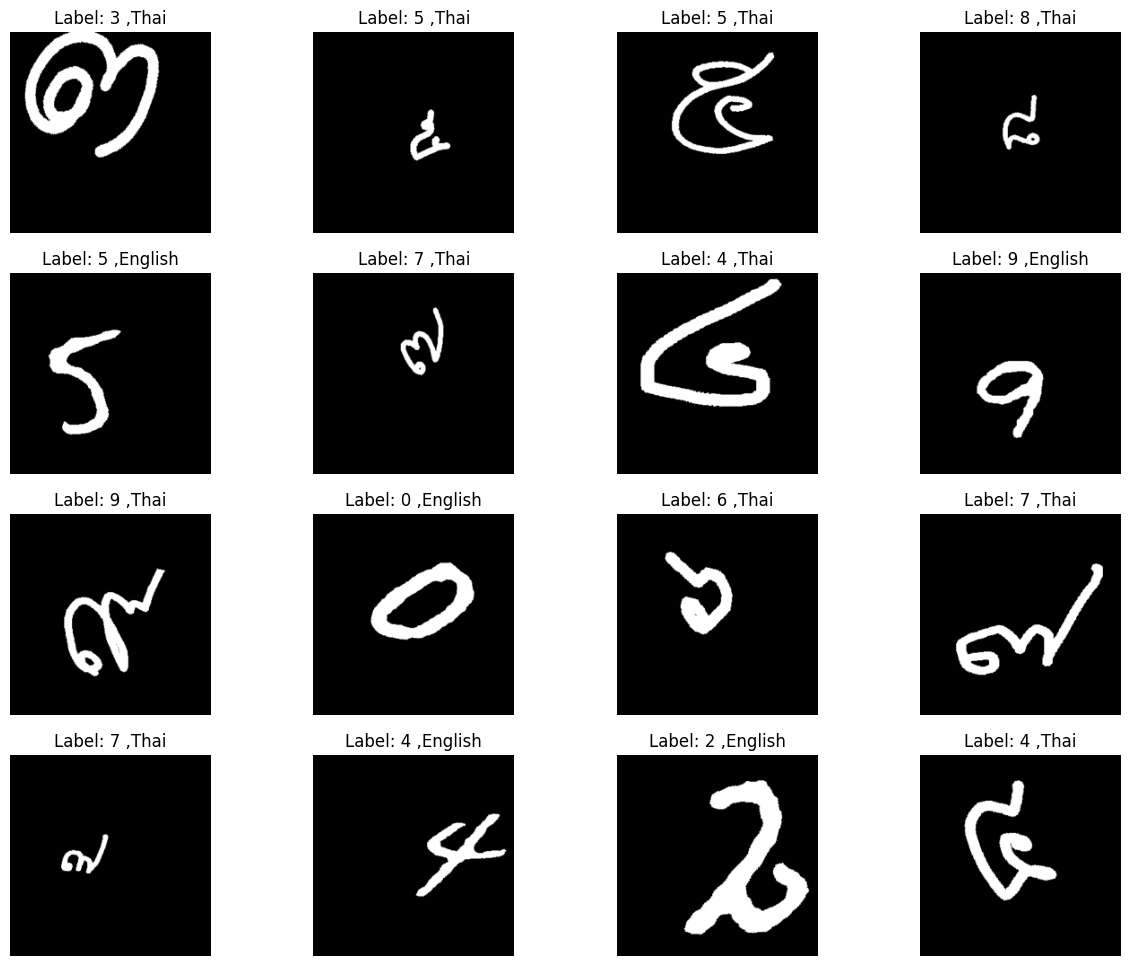

In [23]:
### START CODE HERE ###

images, labels,languages = next(iter(train_loader))
fig, axes = plt.subplots(4, 4, figsize=(15, 12))
axes = axes.flatten()
language_lable = ["English","Thai"]
for idx, (img ,label,languages, ax) in enumerate(zip(images, labels,languages, axes)):

    image = img.numpy().transpose((1,2,0))

    ax.imshow(image, cmap='gray')
    ax.axis('off')
    ax.set_title(f"Label: {label} ,{language_lable[languages]}")

### END CODE HERE ###

<b>VGG16 Architecture</b>

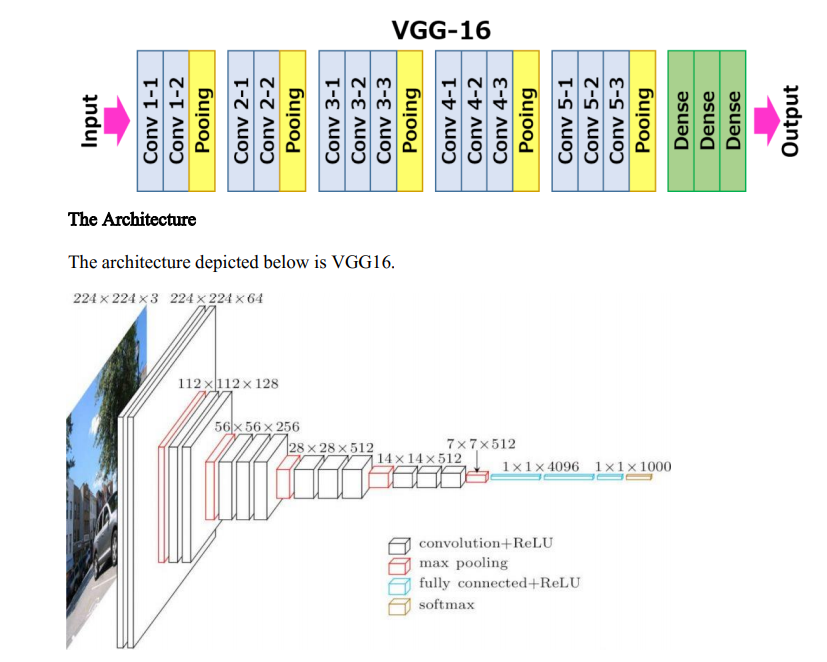

## Model Architechture

<details>
<summary>
<font size="3" color="orange">
<b>Example usage of customVGG16</b>
</font>
</summary>

**Initialization (init function)**
- **add_feat_dims:** List of additional feature dimensions for convolutional layers after VGG16 features. (Optional)
- **h_dims:** List of hidden layer dimensions for the classifier. (Optional)
- **input_size:** Input image size (channels, height, width).
- **usable_features:** List of indices for trainable layers in VGG16 features. (Optional)
- **usable_denses:** Number of fully connected layers in VGG16 classifier to use. (Optional)

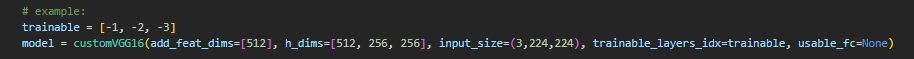
```
customVGG16(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (18): ReLU(inplace=True)
      (19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (20): ReLU(inplace=True)
      (21): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (22): ReLU(inplace=True)
      (23): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (24): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (25): ReLU(inplace=True)
      (26): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (27): ReLU(inplace=True)
      (28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (29): ReLU(inplace=True)
      (30): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (31): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (32): ReLU(inplace=True)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
    (classifier): Sequential(
      (0): Linear(in_features=25088, out_features=25088, bias=True)
      (1): Linear(in_features=25088, out_features=4096, bias=True)
      (2): ReLU(inplace=True)
      (3): Dropout(p=0.5, inplace=False)
      (4): Linear(in_features=4096, out_features=4096, bias=True)
      (5): ReLU(inplace=True)
      (6): Dropout(p=0.5, inplace=False)
      (7): Linear(in_features=4096, out_features=1000, bias=True)
      (8): Linear(in_features=1000, out_features=512, bias=True)
      (9): ReLU(inplace=True)
      (10): Dropout(p=0.4, inplace=False)
      (11): Linear(in_features=512, out_features=256, bias=True)
      (12): ReLU(inplace=True)
      (13): Dropout(p=0.4, inplace=False)
      (14): Linear(in_features=256, out_features=256, bias=True)
      (15): ReLU(inplace=True)
      (16): Dropout(p=0.4, inplace=False)
      (17): Linear(in_features=256, out_features=10, bias=True)
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
)
```
</details>

In [25]:
### START CODE HERE ###
class customVGG16(nn.Module):

  def __init__(self,add_feat_dims=None,
              h_dims=[1024,512,512],
              input_size=(3, 224, 224),
              usable_features=[28, 29],
              usable_denses=None):
    super(customVGG16, self).__init__()

    self.vgg16 = models.vgg16(pretrained=models.VGG16_Weights.DEFAULT)
    self.vgg16.flatten = nn.Flatten()

    for param in self.vgg16.features.parameters():
      param.requires_grad = True

    for param in self.vgg16.classifier.parameters():
      param.requires_grad = True

    if usable_features is not None:
      for idx in usable_features:
        for param in self.vgg16.features[idx].parameters():
          param.requires_grad = True

    if h_dims is not None:
      classifier = []
      in_features = self._get_input_size_fc(input_size, usable_features)

      for i, hdim in enumerate(h_dims):
        classifier.append(nn.Linear(in_features, hdim))
        classifier.append(nn.ReLU(inplace=True))
        classifier.append(nn.Dropout(p=0.4))
        in_features = hdim
      self.vgg16.classifier = nn.Sequential(*classifier)
    else:
      in_features = 1000

    self.classification_head = nn.Linear(in_features, 10)
    self.language_classification_head = nn.Linear(in_features, 1)

  def _get_input_size_fc(self,
                        input_shape,
                        usable_features=None,
                        flatten=False):
    with torch.no_grad():
      dummy_input = torch.zeros(1, *input_shape)
      x = self.vgg16.features(dummy_input)
      x = self.vgg16.flatten(x)
      return x.shape[-1]

  def forward(self, x):
    x = self.vgg16.features(x)
    x = self.vgg16.avgpool(x)
    x = self.vgg16.flatten(x)
    x = self.vgg16.classifier(x)

    class_output, lang_output = (self.classification_head(x),
                                self.language_classification_head(x))

    return F.log_softmax(class_output, dim=1), F.sigmoid(lang_output)
### END CODE HERE ###

Dummy inputs are often a first step in debugging, and further investigation might be required to pinpoint the exact cause of the problem.

In [26]:
### START CODE HERE ###

# debuging model
dummy_input = torch.zeros(32, *(3,224,224))
model = customVGG16(h_dims=[512,256] , input_size=(3,224,224),usable_features = None)

### END CODE HERE ###

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
### START CODE HERE ###
class_output , lang_output = model(dummy_input)
class_output.shape, lang_output.shape
### END CODE HERE ###

(torch.Size([32, 10]), torch.Size([32, 1]))

## Train

In [30]:
### START CODE HERE ###
best_score = 0.0
def train(model,optimizer,train_loader,test_loader,epochs=10,writer=None,checkpoint_path=None,device='cpu'):
  global best_score
  model = model.to(device)

  print("🤖Training on", device)

  for epoch in range(epochs):
    model.train()

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    l1_lambda = 1e-5

    bce_loss = nn.BCELoss()

    train_bar = tqdm(train_loader,
                     desc=f'🚀Training Epoch [{epoch+1}/{epochs}]',
                     unit='batch')

    for batch_idx, (data, target, language) in enumerate(train_bar):
      data, target = data.to(device), target.to(device)
      language = language.float().view(-1, 1).to(device)

      optimizer.zero_grad()

      class_output, lang_output = model(data)
      loss_class = F.nll_loss(class_output, target)
      loss_lang = bce_loss(lang_output, language)

      l1_lambda = 1e-5
      l1_norm = sum(p.abs().sum() for p in model.parameters())

      loss = 0.9 * loss_class + 0.1 * loss_lang + l1_lambda * l1_norm

      loss.backward()
      optimizer.step()

      train_bar.set_postfix(loss=loss.item())

    model.eval()

    scheduler.step()

    correct = 0
    language_correct = 0
    test_loss = 0
    test_lang_loss = 0

    all_preds = []
    all_targets = []
    all_lang_preds = []
    all_lang_targets = []

    with torch.no_grad():
      test_bar = tqdm(test_loader,
                      desc=f" Testing Epoch [{epoch+1}/{epochs}]",
                      unit='batch')

      for data, target, language in test_bar:
        data, target, language = data.to(device), target.to(
            device), language.to(device)
        class_output, lang_output = model(data)

        test_loss += F.nll_loss(class_output, target, reduction='sum').item()
        pred = class_output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        all_preds.extend(pred.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

        test_lang_loss += bce_loss(lang_output, language.float().view(-1, 1))

        language_pred = lang_output.round()
        language_correct += language_pred.eq(
            language.view_as(language_pred)).sum().item()

        all_lang_preds.extend(language_pred.cpu().numpy())
        all_lang_targets.extend(language.cpu().numpy())

      test_loss /= len(test_loader.dataset)
      test_lang_loss /= len(test_loader.dataset)

      accuracy = 100. * correct / len(test_loader.dataset)
      language_accuracy = 100. * language_correct / len(test_loader.dataset)

      class_f1 = f1_score(all_targets, all_preds, average='weighted')
      language_f1 = f1_score(all_lang_targets,
                             all_lang_preds,
                             average='weighted')

      print(
          '✅Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\nAverage BCE loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\nF1 Score (Class): {:.4f}\nF1 Score (Language): {:.4f}\n✅Score: {:.4f}'
          .format(test_loss, correct, len(test_loader.dataset),
                  accuracy, test_lang_loss, language_correct,
                  len(test_loader.dataset), language_accuracy, class_f1,
                  language_f1, class_f1 * 0.9 + language_f1 * 0.1))

      Realscore = class_f1 * 0.9 + language_f1 * 0.1
      if Realscore > best_score:
        best_score = Realscore
        torch.save(model.state_dict(), checkpoint_path)
        print(
            f'❤️❤️❤️Best score : {best_score:.2f}🤨 epoch {epoch+1}❤️❤️❤️'
        )
### END CODE HERE ###

In [31]:
### START CODE HERE ###
model = customVGG16(h_dims=[1024,512,256])
opt = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train(model=model,
      optimizer=opt,
      train_loader=train_loader,
      test_loader=test_loader,
      epochs=50,
      checkpoint_path="/content/Weigth_save.pth",
      device=device)

print(f"😎Best Score is {best_score}")
### END CODE HERE ###

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🤖Training on cuda


 Testing Epoch [1/50]: 100%|██████████| 22/22 [00:05<00:00,  4.04batch/s]


✅Test set: Average loss: 1.2652, Accuracy: 429/700 (61%)
Average BCE loss: 0.0179, Accuracy: 537/700 (77%)
F1 Score (Class): 0.6020
F1 Score (Language): 0.7575
✅Score: 0.6175
❤️❤️❤️Best score : 0.62🤨 epoch 1❤️❤️❤️


 Testing Epoch [2/50]: 100%|██████████| 22/22 [00:05<00:00,  4.01batch/s]


✅Test set: Average loss: 0.5049, Accuracy: 603/700 (86%)
Average BCE loss: 0.0131, Accuracy: 578/700 (83%)
F1 Score (Class): 0.8582
F1 Score (Language): 0.8240
✅Score: 0.8547
❤️❤️❤️Best score : 0.85🤨 epoch 2❤️❤️❤️


 Testing Epoch [3/50]: 100%|██████████| 22/22 [00:05<00:00,  4.09batch/s]


✅Test set: Average loss: 0.3429, Accuracy: 634/700 (91%)
Average BCE loss: 0.0072, Accuracy: 669/700 (96%)
F1 Score (Class): 0.9051
F1 Score (Language): 0.9557
✅Score: 0.9101
❤️❤️❤️Best score : 0.91🤨 epoch 3❤️❤️❤️


 Testing Epoch [4/50]: 100%|██████████| 22/22 [00:05<00:00,  4.30batch/s]


✅Test set: Average loss: 0.2687, Accuracy: 653/700 (93%)
Average BCE loss: 0.0050, Accuracy: 681/700 (97%)
F1 Score (Class): 0.9330
F1 Score (Language): 0.9729
✅Score: 0.9370
❤️❤️❤️Best score : 0.94🤨 epoch 4❤️❤️❤️


🚀Training Epoch [5/50]:  43%|████▎     | 38/88 [00:20<00:27,  1.85batch/s, loss=2.75]


KeyboardInterrupt: 

experiment to fine the best parameter!

Use the `FeatureExtractor()` class and `visualize_feature_map()` function to visualize the feature map of ***ALL*** layers of the Convolution Feature Extractor part. Then, save it as an image.
<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- layer name : features.0<br>
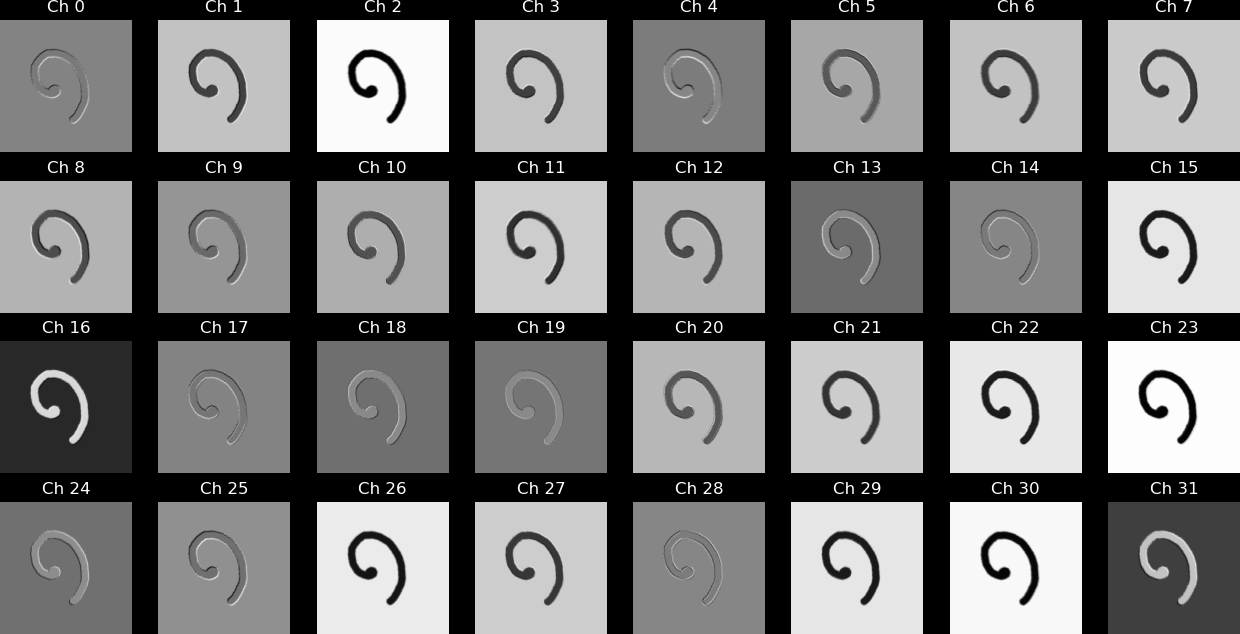
- layer name : features.1<br>
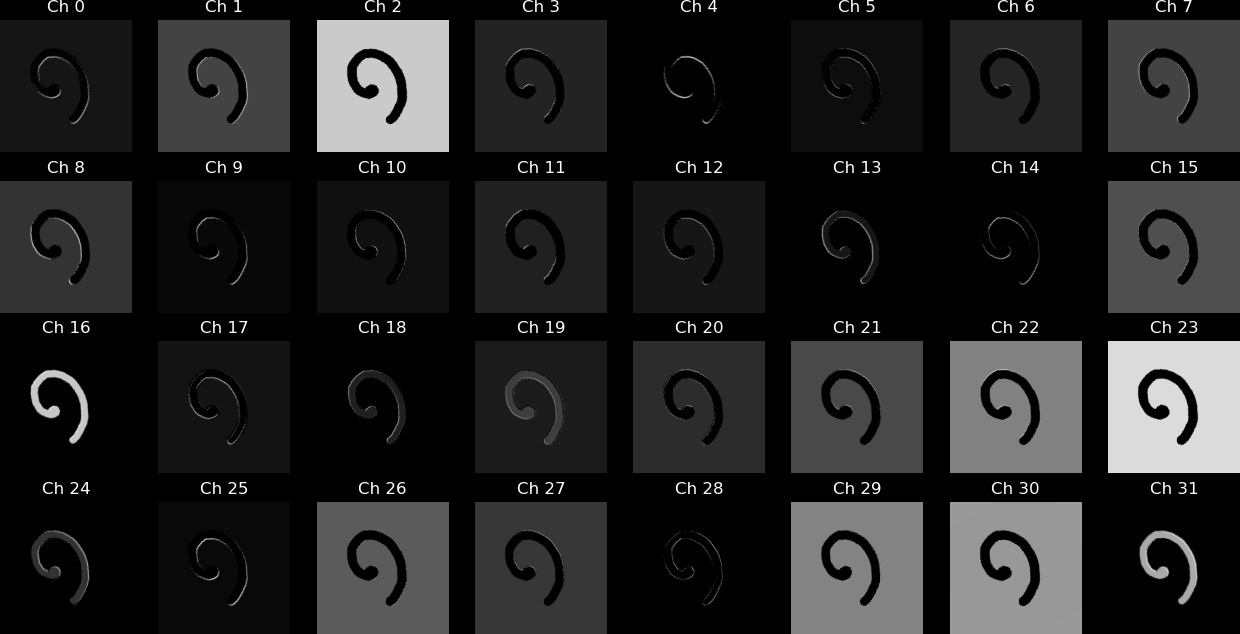
![features_1.png](attachment:features_1.png)
- and so on . . .
</details>

In [41]:
class FeatureExtractor(nn.Module):
    def __init__(self, model, target_layers):
        super(FeatureExtractor, self).__init__()
        self.model = model
        self.target_layers = target_layers
        self.features = []

        for layer_name, layer in self.model.named_modules():
            if layer_name in target_layers:
                print(layer_name)
                layer.register_forward_hook(self.save_feature(layer_name))

    def save_feature(self, layer_name):
        def hook(module, input, output):
            self.features.append(output.clone())
        return hook

    def forward(self, x):
        self.features = []
        self.model(x)
        return self.features

In [42]:
### START CODE HERE ###
targets = [name for name,_ in model.named_modules() if 'features.' in name]
targets
### END CODE HERE ###

['vgg16.features.0',
 'vgg16.features.1',
 'vgg16.features.2',
 'vgg16.features.3',
 'vgg16.features.4',
 'vgg16.features.5',
 'vgg16.features.6',
 'vgg16.features.7',
 'vgg16.features.8',
 'vgg16.features.9',
 'vgg16.features.10',
 'vgg16.features.11',
 'vgg16.features.12',
 'vgg16.features.13',
 'vgg16.features.14',
 'vgg16.features.15',
 'vgg16.features.16',
 'vgg16.features.17',
 'vgg16.features.18',
 'vgg16.features.19',
 'vgg16.features.20',
 'vgg16.features.21',
 'vgg16.features.22',
 'vgg16.features.23',
 'vgg16.features.24',
 'vgg16.features.25',
 'vgg16.features.26',
 'vgg16.features.27',
 'vgg16.features.28',
 'vgg16.features.29',
 'vgg16.features.30']

In [43]:
### START CODE HERE ###
def visualize_feature_map(x,base_filename):
    out_dir = 'feature_map_result'
    os.makedirs(out_dir, exist_ok=True)
    x_channel_last = x[0].permute(1, 2, 0).cpu()

    num_channels = x_channel_last.size(2)

    num_rows = int(num_channels**0.5)
    num_cols = (num_channels // num_rows) + int(num_channels % num_rows > 0)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 8), subplot_kw={'xticks': [], 'yticks': []})
    for channel in range(num_channels):
        row = channel // num_cols
        col = channel % num_cols
        feat_m = x_channel_last[:, :, channel].detach().numpy()
        axes[row, col].imshow(feat_m, cmap='gray')
        axes[row, col].set_title(f'ch {channel + 1}\nrange: {feat_m.min(),feat_m.max()}',fontsize=7)


    base_filename = base_filename
    filename = f"{base_filename}.png"

    count = 1
    while os.path.exists(os.path.join(out_dir,filename)):
        filename = f"{base_filename}_{count}.png"
        count += 1
    fig.suptitle(filename.split('.')[0].split('/')[-1], fontsize=16)
    plt.tight_layout()
    plt.show()

### END CODE HERE ###

In [44]:
model

customVGG16(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (1

In [45]:
targets = [name for name, _ in model.named_modules() if 'features.' in name]
targets

['vgg16.features.0',
 'vgg16.features.1',
 'vgg16.features.2',
 'vgg16.features.3',
 'vgg16.features.4',
 'vgg16.features.5',
 'vgg16.features.6',
 'vgg16.features.7',
 'vgg16.features.8',
 'vgg16.features.9',
 'vgg16.features.10',
 'vgg16.features.11',
 'vgg16.features.12',
 'vgg16.features.13',
 'vgg16.features.14',
 'vgg16.features.15',
 'vgg16.features.16',
 'vgg16.features.17',
 'vgg16.features.18',
 'vgg16.features.19',
 'vgg16.features.20',
 'vgg16.features.21',
 'vgg16.features.22',
 'vgg16.features.23',
 'vgg16.features.24',
 'vgg16.features.25',
 'vgg16.features.26',
 'vgg16.features.27',
 'vgg16.features.28',
 'vgg16.features.29',
 'vgg16.features.30']

In [51]:
### START CODE HERE ###
feature_extractor = FeatureExtractor(model=model, target_layers=targets)
images, labels,languages = next(iter(train_loader))
images.shape
### END CODE HERE ###

vgg16.features.0
vgg16.features.1
vgg16.features.2
vgg16.features.3
vgg16.features.4
vgg16.features.5
vgg16.features.6
vgg16.features.7
vgg16.features.8
vgg16.features.9
vgg16.features.10
vgg16.features.11
vgg16.features.12
vgg16.features.13
vgg16.features.14
vgg16.features.15
vgg16.features.16
vgg16.features.17
vgg16.features.18
vgg16.features.19
vgg16.features.20
vgg16.features.21
vgg16.features.22
vgg16.features.23
vgg16.features.24
vgg16.features.25
vgg16.features.26
vgg16.features.27
vgg16.features.28
vgg16.features.29
vgg16.features.30


torch.Size([32, 3, 224, 224])

In [52]:
### START CODE HERE ###
input_data = images[0].unsqueeze(0).to(device)
input_data.shape
### END CODE HERE ###

torch.Size([1, 3, 224, 224])

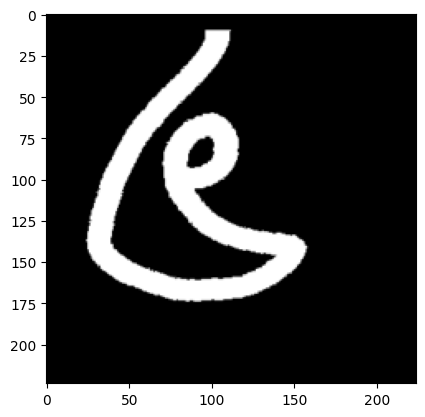

In [54]:
### START CODE HERE ###
input_data[0].shape
plt.imshow(input_data[0].cpu().numpy().transpose(1, 2, 0))
### END CODE HERE ###

In [55]:
### START CODE HERE ###
extracted_features = feature_extractor(input_data)

for idx, feature in enumerate(extracted_features):
    print(f"Feature from layer {targets[idx]}: {feature.shape}")
### END CODE HERE ###

Feature from layer vgg16.features.0: torch.Size([1, 64, 224, 224])
Feature from layer vgg16.features.1: torch.Size([1, 64, 224, 224])
Feature from layer vgg16.features.2: torch.Size([1, 64, 224, 224])
Feature from layer vgg16.features.3: torch.Size([1, 64, 224, 224])
Feature from layer vgg16.features.4: torch.Size([1, 64, 112, 112])
Feature from layer vgg16.features.5: torch.Size([1, 128, 112, 112])
Feature from layer vgg16.features.6: torch.Size([1, 128, 112, 112])
Feature from layer vgg16.features.7: torch.Size([1, 128, 112, 112])
Feature from layer vgg16.features.8: torch.Size([1, 128, 112, 112])
Feature from layer vgg16.features.9: torch.Size([1, 128, 56, 56])
Feature from layer vgg16.features.10: torch.Size([1, 256, 56, 56])
Feature from layer vgg16.features.11: torch.Size([1, 256, 56, 56])
Feature from layer vgg16.features.12: torch.Size([1, 256, 56, 56])
Feature from layer vgg16.features.13: torch.Size([1, 256, 56, 56])
Feature from layer vgg16.features.14: torch.Size([1, 256, 5

In [56]:
### START CODE HERE ###
conv_output = extracted_features[8].squeeze(0) # vgg16.features.7
conv_output.shape
### END CODE HERE ###

torch.Size([128, 112, 112])

In [57]:
### START CODE HERE ###
num_channels = conv_output.shape[0]
num_cols = 8
num_rows = (num_channels + num_cols - 1) // num_cols

num_channels, num_cols, num_rows
### END CODE HERE ###

(128, 8, 16)

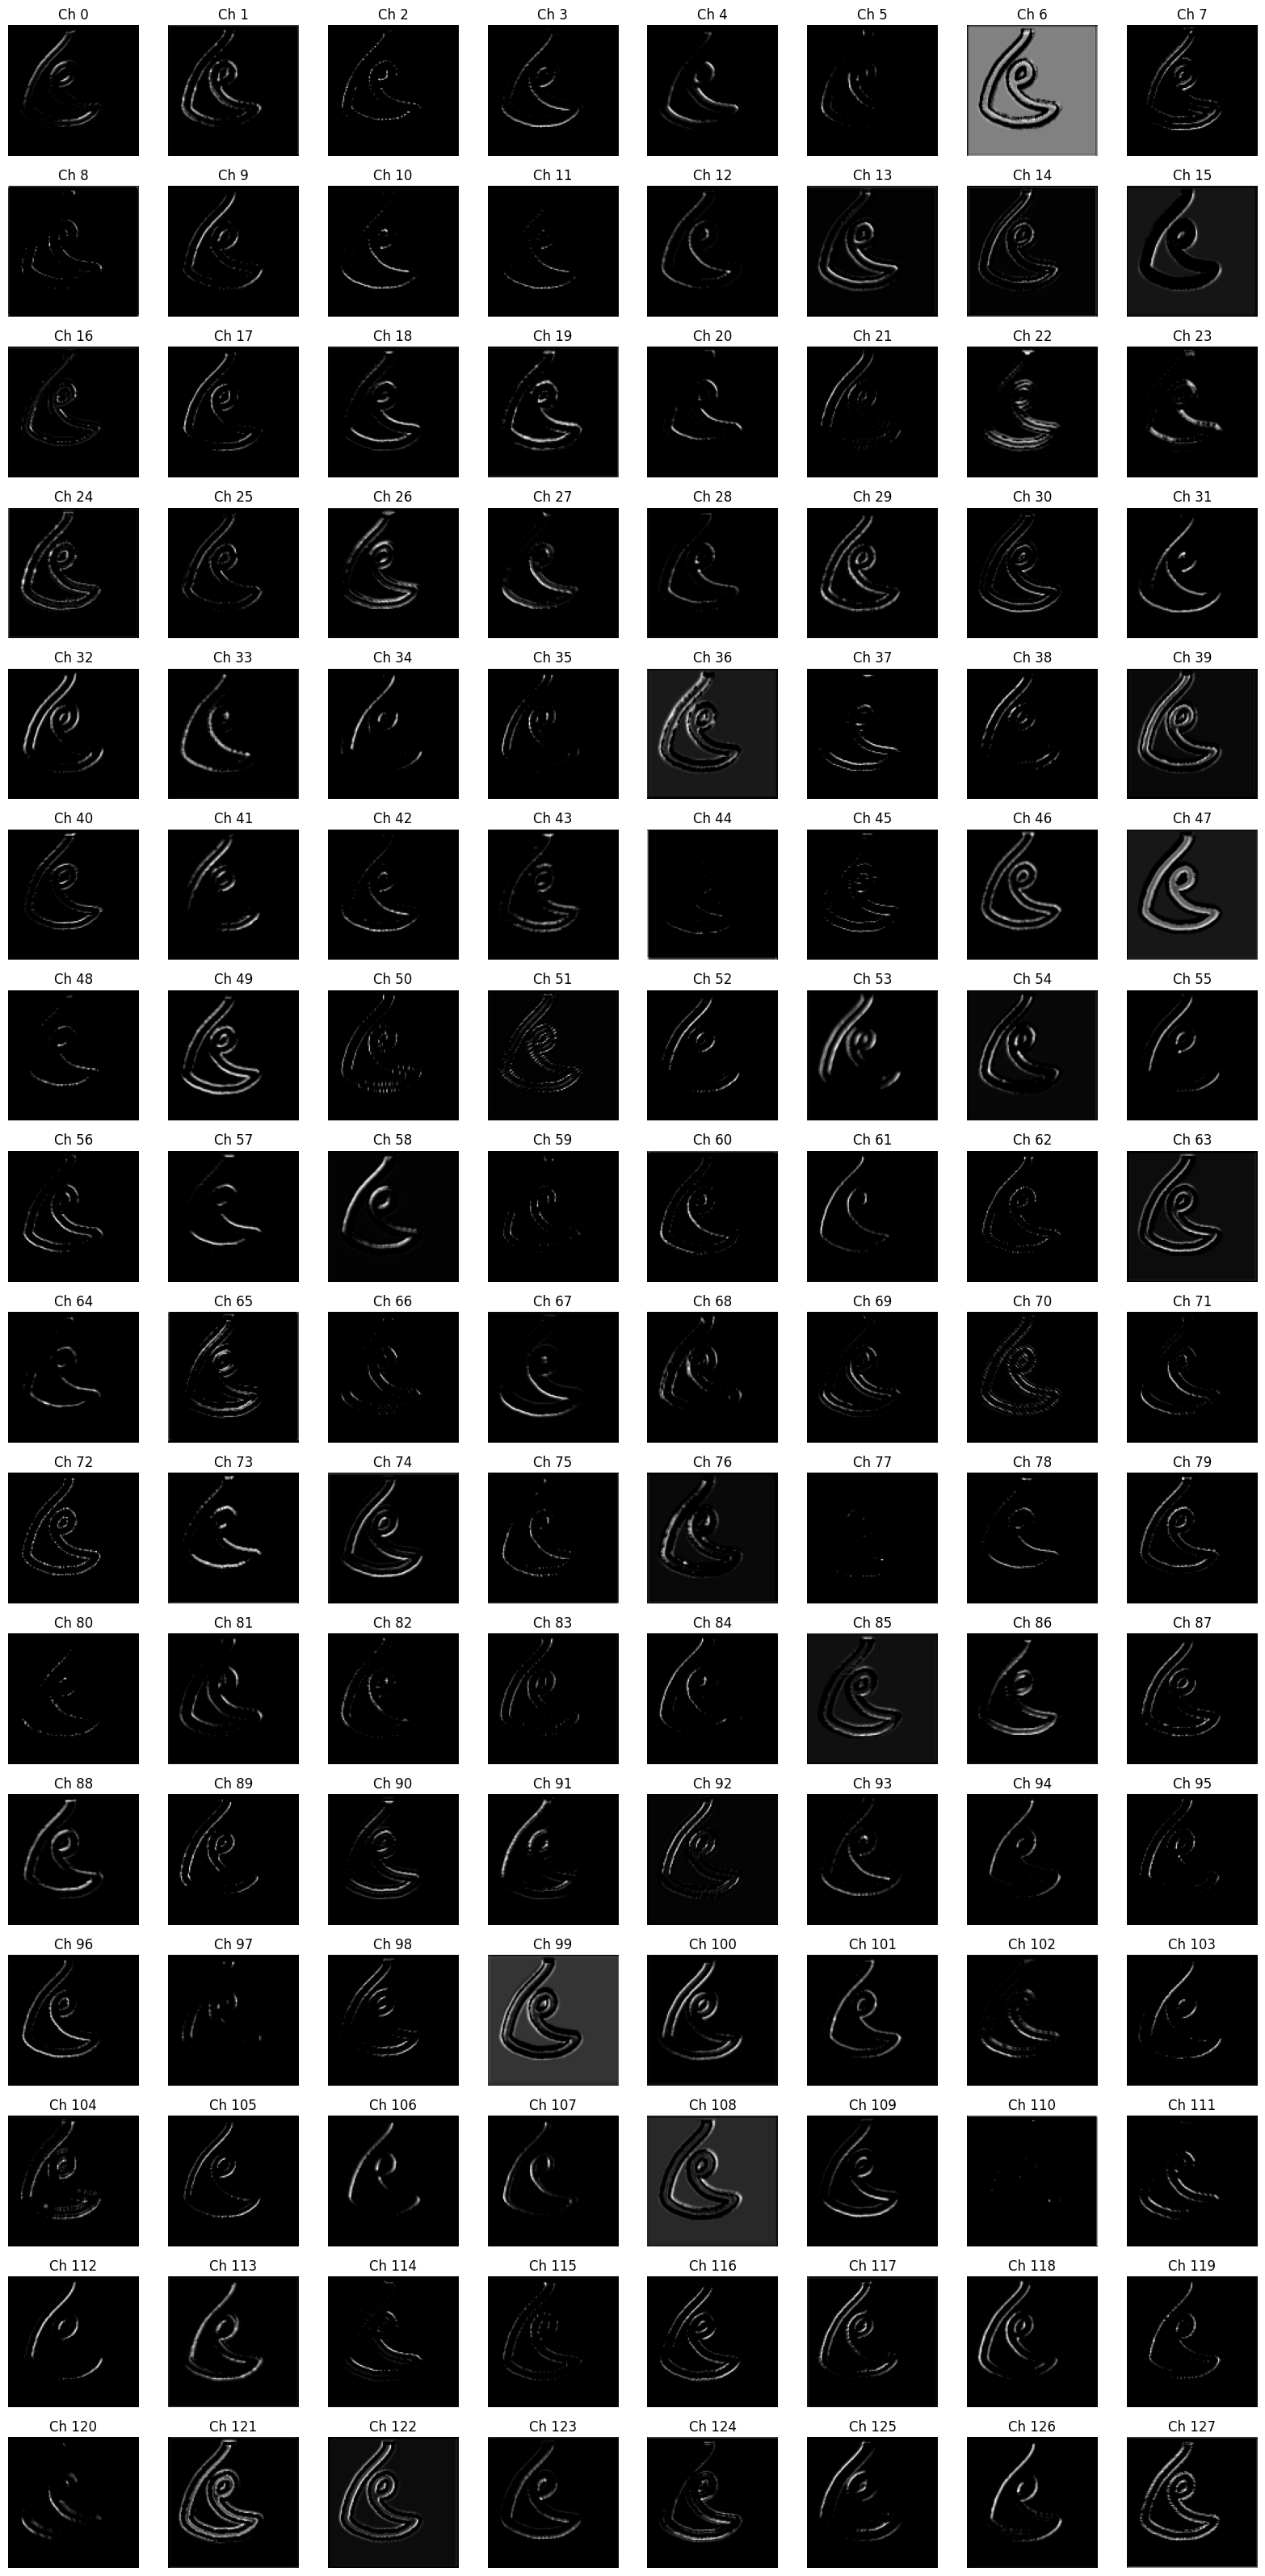

In [59]:
### START CODE HERE ###
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
axes = axes.flatten()  # Flatten to easily iterate through

for i in range(num_channels):
    ax = axes[i]
    channel_data = conv_output[i].detach().cpu().numpy()
    # print(np.unique(channel_data))

    ax.imshow(channel_data, cmap='gray')
    ax.axis('off')
    ax.set_title(f'Ch {i}')

# Hide any remaining subplots if there are any
for i in range(num_channels, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()
### END CODE HERE ###

## Eval

Display the confusion matrix and classification report for best models of all classifier heads

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

The output should resemble this, but not be identical
You should have 2 results of classifier heads:
- language classification 2 classes (TH, ENG)
- number classification 10 classes (0, 1, 2, ..., 9)
```
              precision    recall  f1-score   support

           0       0.90      0.88      0.89        81
           1       0.87      0.77      0.82        75
           2       0.89      0.88      0.89        66
           3       0.79      0.81      0.80        67
           4       0.78      0.81      0.79        69
           5       0.89      0.81      0.84        77
           6       0.94      0.80      0.86        94
           7       0.85      0.86      0.85        78
           8       0.54      0.90      0.68        73
           9       0.91      0.70      0.79        97

    accuracy                           0.82       777
   macro avg       0.83      0.82      0.82       777
weighted avg       0.84      0.82      0.82       777
```
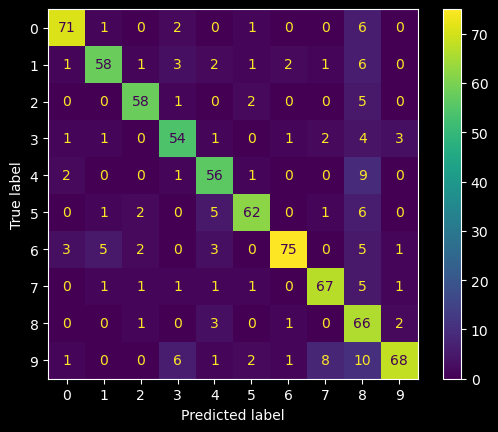
</details>

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
### START CODE HERE ###

model.eval()

test_bar = tqdm(test_loader,desc=f'📄Testing' ,unit='batch')

for inputs, labels in test_bar:
    pass

### END CODE HERE ###

📄Testing:   0%|          | 0/22 [00:00<?, ?batch/s]


ValueError: too many values to unpack (expected 2)

In [ ]:
### START CODE HERE ###

# try it out here!

### END CODE HERE ###

## Submission

In [ ]:
###################################################
############## Exercise Submission ################
###################################################

import pandas as pd
import os

model.load_state_dict(torch.load("/content/Weigth_save.pth"))
base_dir = '/content/submission' # for example: /mnt/c/root/datasets/submission
file_names, class_preds, lang_preds = [], [], []

model.eval()
with torch.no_grad():
    submit_bar = tqdm(range(0, 350), desc=f'📄 submit_dataset', unit='batch') # dataset's number,
    # you can also using glob to fine you paths: glob.glob('/mnt/c/root/datasets/submission*.png')
    submit_transform = transforms.Compose([
                                  transforms.Grayscale(),  # Convert the image to grayscale first
                                  ReverseIntensity(threshold=100),  # Apply the custom intensity reversal
                                  transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels (the final size)
                                  transforms.ToTensor(),  # Convert the image to a tensor
                                  transforms.Lambda(lambda x: torch.cat([x, x, x], 0))  # Convert grayscale image to 3-channel by duplicating the single channel
    ])

    for idx in submit_bar:

        file_name = f'image_{idx}.png'
        file_names.append(file_name)

        img_path = os.path.join(base_dir, file_name)

        image = Image.open(img_path).convert('RGB')
        image = submit_transform(image)
        image = image.unsqueeze(0).to(device)

        class_output, lang_output = model(image)

        class_pred = class_output.argmax(dim=1, keepdim=True)
        class_preds.extend(class_pred.cpu().numpy().flatten())

        lang_pred = lang_output.round()
        lang_preds.extend(lang_pred.cpu().numpy().flatten().astype('uint8'))

data = list(zip(file_names, lang_preds, class_preds))
submission_df = pd.DataFrame(data, columns=['file_name', 'language', 'value'])

output_path = '/content/Natthasit.csv' # for example: /mnt/c/root/results/submission.csv
submission_df.to_csv(output_path, index=False)

print(f"CSV file saved to {output_path}")


###################################################
############## Exercise Submission ################
###################################################

📄 submit_dataset: 100%|██████████| 350/350 [00:04<00:00, 82.33batch/s] 

CSV file saved to /content/Natthasit.csv


In [ ]:
### START CODE HERE ###

base_data = pd.read_csv('/content/ans.csv')
submiss_data = pd.read_csv(output_path)
# ดึงค่าของแถวที่ต้องการ
acc = 0
for i in range(0,len(submiss_data)):
  if submiss_data.iloc[i, 2] == base_data.iloc[i, 0]:
    acc += 1
  else :
    print(f'{submiss_data.iloc[i, 0]} : {submiss_data.iloc[i, 2]}')
  #print(f'{submiss_data.iloc[i, 2]} : {base_data.iloc[i, 0]}')
print(acc/len(submiss_data)*100)
### END CODE HERE ###

image_13.png : 7
image_15.png : 1
image_23.png : 3
image_31.png : 9
image_43.png : 2
image_48.png : 4
image_69.png : 4
image_91.png : 5
image_118.png : 4
image_157.png : 4
image_171.png : 0
image_181.png : 1
image_211.png : 7
image_232.png : 2
image_244.png : 3
image_294.png : 7
image_298.png : 1
image_308.png : 7
image_313.png : 7
image_332.png : 1
image_338.png : 6
94.0


In [ ]:
### START CODE HERE ###

submission_df

### END CODE HERE ###